<a href="https://colab.research.google.com/github/Fermu25/Cursos/blob/main/Datos%20prueba%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

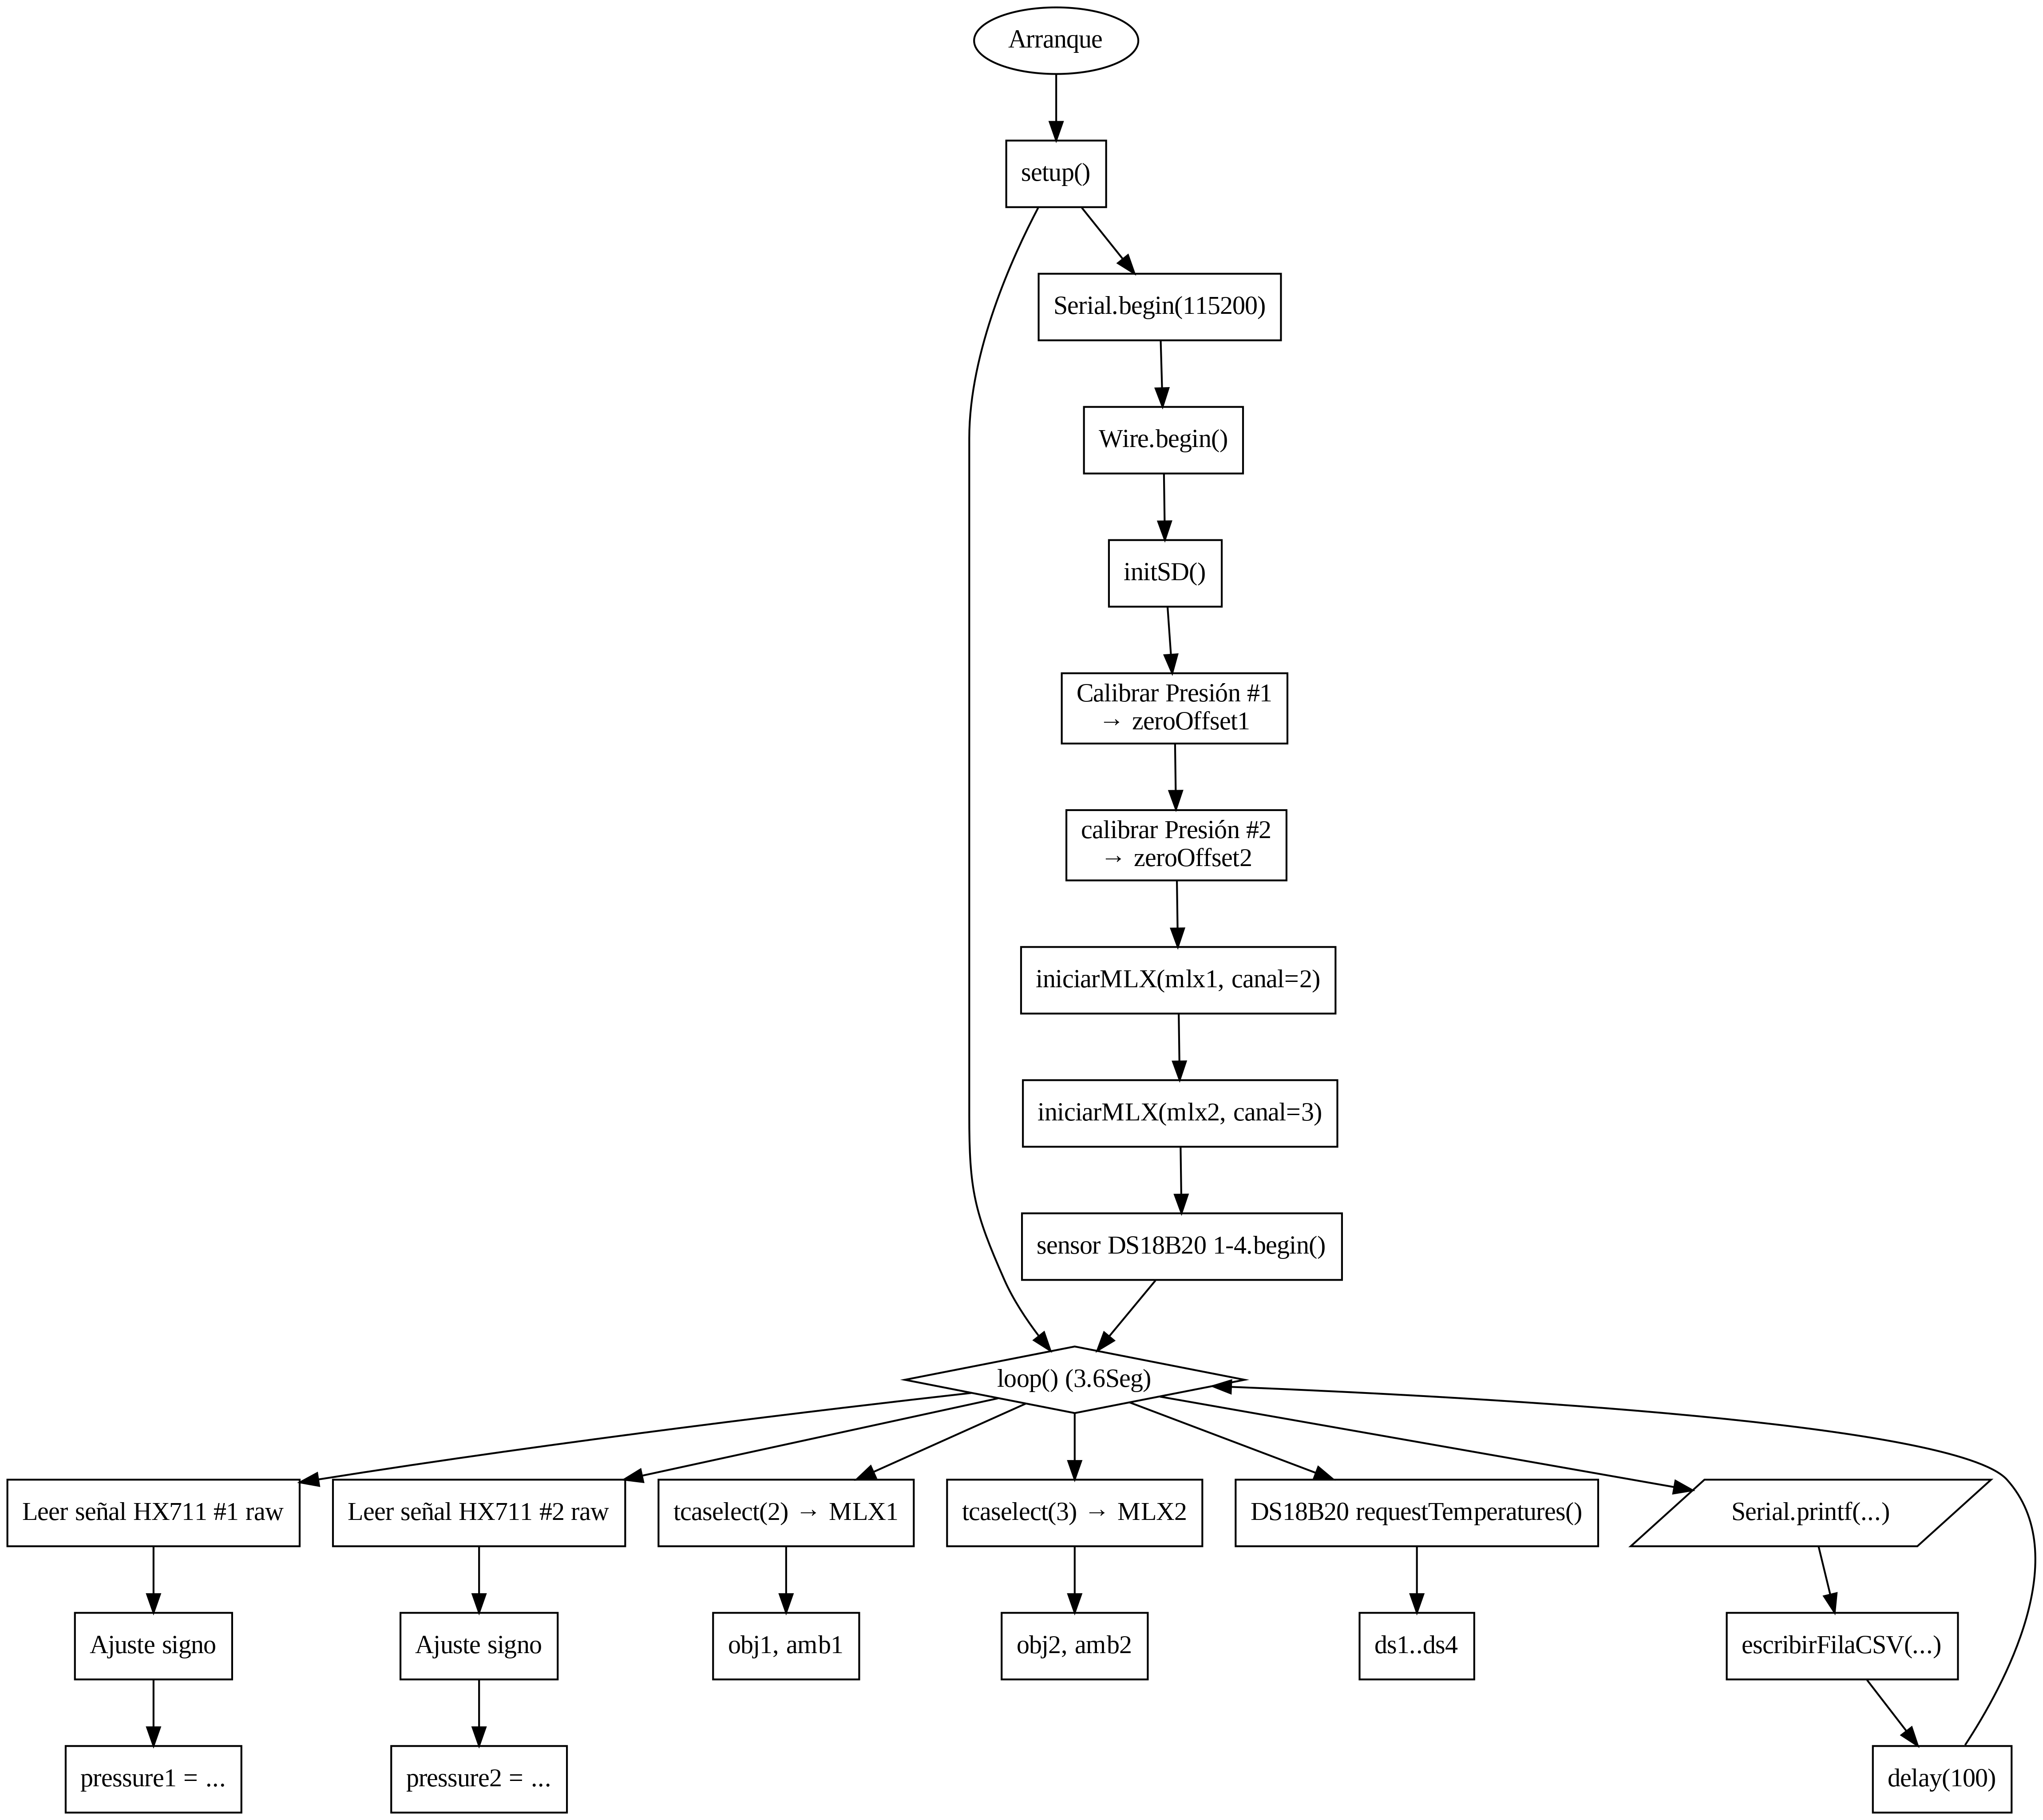

In [11]:
!apt-get -qq install graphviz > /dev/null
!pip install graphviz > /dev/null

from graphviz import Digraph
from IPython.display import Image

dot = Digraph(comment="Diagrama de flujo del logger", format='png')

dot.attr(rankdir='TB')
dot.attr(size='20')
dot.attr(dpi='300')
dot.attr(fontname="Helvetica")

# Nodos principales
dot.node("A", "Arranque", shape="ellipse")
dot.node("B", "setup()", shape="box")
dot.node("C", "loop() (3.6Seg)", shape="diamond")

# Setup
dot.edge("A", "B")
dot.edge("B", "C")
dot.node("B1", "Serial.begin(115200)", shape="box")
dot.node("B2", "Wire.begin()", shape="box")
dot.node("B3", "initSD()", shape="box")
dot.node("B4", "Calibrar Presión #1\n→ zeroOffset1", shape="box")
dot.node("B5", "calibrar Presión #2\n→ zeroOffset2", shape="box")
dot.node("B6", "iniciarMLX(mlx1, canal=2)", shape="box")
dot.node("B7", "iniciarMLX(mlx2, canal=3)", shape="box")
dot.node("B8", "sensor DS18B20 1-4.begin()", shape="box")

dot.edges([("B","B1"),("B1","B2"),("B2","B3"),("B3","B4"),
           ("B4","B5"),("B5","B6"),("B6","B7"),("B7","B8"),("B8","C")])

# Loop interno
dot.node("D1", "Leer señal HX711 #1 raw", shape="box")
dot.node("D2", "Ajuste signo", shape="box")
dot.node("D3", "pressure1 = ...", shape="box")

dot.node("E1", "Leer señal HX711 #2 raw", shape="box")
dot.node("E2", "Ajuste signo", shape="box")
dot.node("E3", "pressure2 = ...", shape="box")

dot.node("F1", "tcaselect(2) → MLX1", shape="box")
dot.node("F2", "obj1, amb1", shape="box")

dot.node("G1", "tcaselect(3) → MLX2", shape="box")
dot.node("G2", "obj2, amb2", shape="box")

dot.node("H1", "DS18B20 requestTemperatures()", shape="box")
dot.node("H2", "ds1..ds4", shape="box")

dot.node("I", "Serial.printf(...)", shape="parallelogram")
dot.node("J", "escribirFilaCSV(...)", shape="box")
dot.node("K", "delay(100)", shape="box")

# Relaciones loop
dot.edges([("C","D1"),("D1","D2"),("D2","D3")])
dot.edges([("C","E1"),("E1","E2"),("E2","E3")])
dot.edges([("C","F1"),("F1","F2")])
dot.edges([("C","G1"),("G1","G2")])
dot.edges([("C","H1"),("H1","H2")])
dot.edge("C","I")
dot.edge("I","J")
dot.edge("J","K")
dot.edge("K","C")

output_path = "diagrama_logger"
dot.render(output_path, format="png", cleanup=True)
Image(filename=output_path + ".png")


In [3]:
import re
from datetime import timedelta
from pathlib import Path
import pandas as pd
import numpy as np

INPUT_PATH  = "serial_log_parte1.csv"
OUTPUT_PATH = "salida1.csv"

TS_RE = re.compile(r'^(?P<ts>\d{2}:\d{2}:\d{2}[.,]\d{3})\s*->\s*(?P<rest>.*)$')

PRESS_RE = re.compile(
    r'Presiones:\s*P1\s*=\s*([-\d\.NaNnan]+)\s*mmHg\s*\|\s*P2\s*=\s*([-\d\.NaNnan]+)\s*mmHg',
    re.IGNORECASE
)

IR_RE = re.compile(
    r'IR\s*Canal\s*(\d+):\s*Obj\s*=\s*([-\d\.NaNnan]+)\s*°C,\s*Amb\s*=\s*([-\d\.NaNnan]+)\s*°C',
    re.IGNORECASE
)

DS_RE = re.compile(
    r'DS18B20:\s*T1\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T2\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T3\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T4\s*=\s*([-\d\.NaNnan]+)\s*°C',
    re.IGNORECASE
)

SEP_RE = re.compile(r'^-+\s*$')

def to_float(x: str):
    x = (x or "").strip()
    if x.lower() == 'nan' or x == '':
        return float('nan')
    try:
        return float(x)
    except ValueError:
        return float('nan')

def parse_file(text_lines):
    blocks = []
    cur = None

    def finalize_current():
        nonlocal cur
        if cur is not None:
            blocks.append(cur)
            cur = None

    for raw in text_lines:
        line = raw.rstrip('\n')
        if not line.strip():
            continue

        m = TS_RE.match(line)
        if not m:
            if SEP_RE.match(line):
                finalize_current()
            continue

        ts = m.group('ts').replace(',', '.')  # normaliza coma decimal si existiera
        rest = m.group('rest')

        if SEP_RE.match(rest):
            finalize_current()
            continue

        mp = PRESS_RE.search(rest)
        if mp:
            finalize_current()
            cur = {
                'time': ts,  # ¡conservamos la hora EXACTA del log!
                'P1_mmHg': to_float(mp.group(1)),
                'P2_mmHg': to_float(mp.group(2)),
                'IR2_Obj_C': float('nan'),
                'IR2_Amb_C': float('nan'),
                'IR3_Obj_C': float('nan'),
                'IR3_Amb_C': float('nan'),
                'DS_T1_C': float('nan'),
                'DS_T2_C': float('nan'),
                'DS_T3_C': float('nan'),
                'DS_T4_C': float('nan'),
            }
            continue

        if cur is None:
            continue

        mi = IR_RE.search(rest)
        if mi:
            canal = mi.group(1)
            obj = to_float(mi.group(2))
            amb = to_float(mi.group(3))
            if canal == '2':
                cur['IR2_Obj_C'] = obj
                cur['IR2_Amb_C'] = amb
            elif canal == '3':
                cur['IR3_Obj_C'] = obj
                cur['IR3_Amb_C'] = amb
            continue

        md = DS_RE.search(rest)
        if md:
            cur['DS_T1_C'] = to_float(md.group(1))
            cur['DS_T2_C'] = to_float(md.group(2))
            cur['DS_T3_C'] = to_float(md.group(3))
            cur['DS_T4_C'] = to_float(md.group(4))
            continue

    finalize_current()
    return blocks

def compute_times(df: pd.DataFrame) -> pd.DataFrame:
    """
    Añade elapsed_s (desde primer bloque) y dt_s usando tiempos reales.
    - Mantiene df['time'] sin modificar (HH:MM:SS.mmm tal cual del log).
    - Soporta coma o punto como separador decimal.
    - Maneja rollover de medianoche.
    """
    # Serie de strings original (NO la tocamos en el DataFrame)
    t_str = df['time'].astype(str)

    # Normaliza SOLO para parseo
    t_norm = t_str.str.replace(',', '.', regex=False)

    # Concatena fecha ficticia para parsear con precisión de milisegundos
    t_dt = pd.to_datetime('2000-01-01 ' + t_norm,
                          format='%Y-%m-%d %H:%M:%S.%f',
                          errors='coerce')
    if t_dt.isna().any():
        malos = t_str[t_dt.isna()].unique()
        raise ValueError("No se pudieron parsear algunas marcas de tiempo: " + ", ".join(malos[:5]))

    # Manejo de rollover: si el reloj "retrocede", sumamos +24h desde ese punto
    neg = t_dt.diff() < pd.Timedelta(0)
    roll = neg.cumsum()  # 0,0,0,1,1,1,2,...
    t_adj = t_dt + pd.to_timedelta(roll, unit='D')  # +N días (24h por rollover)

    elapsed = (t_adj - t_adj.iloc[0]).dt.total_seconds()
    dt = elapsed.diff().fillna(0.0)

    df['elapsed_s'] = elapsed.astype(float)
    df['dt_s'] = dt.astype(float)
    return df

def main(in_path=INPUT_PATH, out_path=OUTPUT_PATH):
    p = Path(in_path)
    if not p.exists():
        raise FileNotFoundError(f"No se encontró el archivo de entrada: {p.resolve()}")
    with p.open('r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()

    blocks = parse_file(lines)
    if not blocks:
        raise RuntimeError("No se pudieron extraer bloques. ¿El formato coincide con los ejemplos?")

    df = pd.DataFrame(blocks, columns=[
        'time','P1_mmHg','P2_mmHg',
        'IR2_Obj_C','IR2_Amb_C','IR3_Obj_C','IR3_Amb_C',
        'DS_T1_C','DS_T2_C','DS_T3_C','DS_T4_C'
    ])
    df = compute_times(df)

    cols = [
        'time','elapsed_s','dt_s',
        'P1_mmHg','P2_mmHg',
        'IR2_Obj_C','IR2_Amb_C','IR3_Obj_C','IR3_Amb_C',
        'DS_T1_C','DS_T2_C','DS_T3_C','DS_T4_C'
    ]
    df = df[cols]

    # Guarda con 3 decimales para tiempos
    df.to_csv(out_path, index=False, encoding='utf-8', float_format='%.3f')
    print(f"Listo. Se escribió el CSV limpio en: {Path(out_path).resolve()}")

if __name__ == "__main__":
    main()


Listo. Se escribió el CSV limpio en: /content/salida1.csv


In [4]:
import re
from pathlib import Path
import pandas as pd
import numpy as np

# === Configura aquí ===
INPUT_PATH  = "serial_log_parte2.csv"   # tu CSV con: seq, iso_ts, mensaje
OUTPUT_PATH = "salida2.csv"             # CSV limpio de salida

# --- Patrones ---
PRESS_RE = re.compile(
    r'Presiones:\s*P1\s*=\s*([-\d\.NaNnan]+)\s*mmHg\s*\|\s*P2\s*=\s*([-\d\.NaNnan]+)\s*mmHg',
    re.IGNORECASE
)
IR_RE = re.compile(
    r'IR\s*Canal\s*(\d+):\s*Obj\s*=\s*([-\d\.NaNnan]+)\s*°C,\s*Amb\s*=\s*([-\d\.NaNnan]+)\s*°C',
    re.IGNORECASE
)
DS_RE = re.compile(
    r'DS18B20:\s*T1\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T2\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T3\s*=\s*([-\d\.NaNnan]+)\s*°C\s*\|\s*T4\s*=\s*([-\d\.NaNnan]+)\s*°C',
    re.IGNORECASE
)
SEP_RE = re.compile(r'^-+\s*$')

def to_float(x: str):
    x = (x or "").strip()
    if x.lower() == "nan" or x == "":
        return np.nan
    try:
        return float(x)
    except ValueError:
        return np.nan

def iso_to_parts(iso_str: str):
    """
    Devuelve:
      - dt (datetime64[ns]) en UTC-naive consistente
      - time_str: 'HH:MM:SS.mmm'
    """
    dt = pd.to_datetime(iso_str, utc=False, errors="raise")
    # formatea HH:MM:SS.mmm
    time_str = dt.strftime("%H:%M:%S.") + f"{int(dt.microsecond/1000):03d}"
    return dt, time_str

def parse_blocks(df_raw: pd.DataFrame) -> list[dict]:
    """
    Recorre el CSV (en el orden del archivo por 'seq') y arma bloques
    anclados a la línea 'Presiones'. Cada bloque hereda su timestamp de esa línea.
    """
    blocks = []
    cur = None
    cur_dt = None

    for _, row in df_raw.sort_values("seq").iterrows():
        msg = str(row["mensaje"]).strip()
        iso = str(row["iso_ts"]).strip()

        # Cierre por separador
        if SEP_RE.match(msg):
            if cur is not None:
                blocks.append(cur)
                cur = None
                cur_dt = None
            continue

        # Inicio de bloque: Presiones
        mp = PRESS_RE.search(msg)
        if mp:
            if cur is not None:
                blocks.append(cur)

            dt, time_str = iso_to_parts(iso)
            cur_dt = dt

            cur = {
                "seq": int(row["seq"]) if pd.notna(row["seq"]) else None,
                "anchor_dt": cur_dt,     # para tiempos relativos
                "time": time_str,        # HH:MM:SS.mmm (hora completa)
                "P1_mmHg": to_float(mp.group(1)),
                "P2_mmHg": to_float(mp.group(2)),
                "IR2_Obj_C": np.nan, "IR2_Amb_C": np.nan,
                "IR3_Obj_C": np.nan, "IR3_Amb_C": np.nan,
                "DS_T1_C": np.nan, "DS_T2_C": np.nan, "DS_T3_C": np.nan, "DS_T4_C": np.nan,
            }
            continue

        # Si no estamos dentro de un bloque, ignoramos
        if cur is None:
            continue

        # IR
        mi = IR_RE.search(msg)
        if mi:
            canal = mi.group(1)
            obj = to_float(mi.group(2))
            amb = to_float(mi.group(3))
            if canal == "2":
                cur["IR2_Obj_C"] = obj
                cur["IR2_Amb_C"] = amb
            elif canal == "3":
                cur["IR3_Obj_C"] = obj
                cur["IR3_Amb_C"] = amb
            continue

        # DS18B20
        md = DS_RE.search(msg)
        if md:
            cur["DS_T1_C"] = to_float(md.group(1))
            cur["DS_T2_C"] = to_float(md.group(2))
            cur["DS_T3_C"] = to_float(md.group(3))
            cur["DS_T4_C"] = to_float(md.group(4))
            continue

    if cur is not None:
        blocks.append(cur)

    return blocks

def compute_time_cols(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula elapsed_s y dt_s respetando el orden del archivo (seq).
    El tiempo cero es la primera línea 'Presiones' del archivo.
    """
    df = df.sort_values("seq").reset_index(drop=True)

    # tiempos relativos en segundos
    t0 = df.loc[0, "anchor_dt"]
    elapsed = (df["anchor_dt"] - t0).dt.total_seconds()
    df["elapsed_s"] = elapsed.astype(float)
    df["dt_s"] = df["elapsed_s"].diff().fillna(0.0)

    # limpia columnas auxiliares
    return df.drop(columns=["anchor_dt", "seq"])

def main(in_path=INPUT_PATH, out_path=OUTPUT_PATH):
    p = Path(in_path)
    if not p.exists():
        raise FileNotFoundError(f"No se encontró el archivo: {p.resolve()}")

    # Lee 3 columnas: seq, iso_ts, mensaje (maneja comillas en 'mensaje')
    df_raw = pd.read_csv(
        p,
        header=None,
        names=["seq", "iso_ts", "mensaje"],
        dtype={"seq": "Int64", "iso_ts": str, "mensaje": str},
        keep_default_na=False,
        encoding="utf-8",
        engine="python"  # más tolerante con comillas
    )

    blocks = parse_blocks(df_raw)
    if not blocks:
        raise RuntimeError("No se detectaron bloques con 'Presiones'.")

    df = pd.DataFrame(blocks)

    # tiempos
    df = compute_time_cols(df)

    # Orden/columnas homogéneas con tus otros CSV
    cols = [
        "time", "elapsed_s", "dt_s",
        "P1_mmHg", "P2_mmHg",
        "IR2_Obj_C", "IR2_Amb_C", "IR3_Obj_C", "IR3_Amb_C",
        "DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"
    ]
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    df = df[cols]

    df.to_csv(out_path, index=False, encoding="utf-8", float_format="%.3f")
    print(f"CSV homogéneo escrito en: {Path(out_path).resolve()}")

if __name__ == "__main__":
    main()


CSV homogéneo escrito en: /content/salida2.csv


In [6]:
import pandas as pd
from pathlib import Path

# === Configura aquí ===
CSV1 = "salida1.csv"   # primer CSV
CSV2 = "salida2.csv"   # segundo CSV
OUTPUT = "salida_unida.csv"

def unir_csvs(csv1, csv2, out_path=OUTPUT):
    # Cargar ambos
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)

    # Tomar solo columnas en común
    common_cols = [c for c in df1.columns if c in df2.columns]
    df1 = df1[common_cols]
    df2 = df2[common_cols]

    # Unir
    df = pd.concat([df1, df2], ignore_index=True)

    # Reordenar por hora (si existe columna 'time')
    if 'time' in df.columns:
        # Si es solo HH:MM:SS.mmm => la tratamos como texto para ordenar
        try:
            df = df.sort_values('time').reset_index(drop=True)
        except Exception:
            pass

    # Recalcular elapsed y dt en base al orden combinado
    if 'elapsed_s' in common_cols:
        df['elapsed_s'] = (df.index.to_series().astype(float)
                           - df.index.min())
        df['dt_s'] = df['elapsed_s'].diff().fillna(0.0)

    # Guardar
    df.to_csv(out_path, index=False, encoding='utf-8', float_format="%.3f")
    print(f"Archivo combinado guardado en: {Path(out_path).resolve()}")

if __name__ == "__main__":
    unir_csvs(CSV1, CSV2, OUTPUT)


Archivo combinado guardado en: /content/salida_unida.csv


In [9]:
import pandas as pd
from pathlib import Path

# === Configura aquí ===
CSV1 = "salida1.csv"   # primer CSV
CSV2 = "salida2.csv"   # segundo CSV
OUTPUT = "salida_unida.csv"

def unir_csvs(csv1, csv2, out_path=OUTPUT):
    # Cargar ambos
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)

    # Tomar solo columnas en común
    common_cols = [c for c in df1.columns if c in df2.columns]
    df1 = df1[common_cols]
    df2 = df2[common_cols]

    # Concatenar tal cual (sin reordenar ni recalcular)
    df = pd.concat([df1, df2], ignore_index=True)

    # Guardar
    df.to_csv(out_path, index=False, encoding="utf-8", float_format="%.3f")
    print(f"Archivo combinado guardado en: {Path(out_path).resolve()}")

if __name__ == "__main__":
    unir_csvs(CSV1, CSV2, OUTPUT)


Archivo combinado guardado en: /content/salida_unida.csv


In [18]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ================== Configura =================
CSV_PATH = "salida_unida.csv"   # archivo combinado
OUT_PREFIX = "fig_"             # prefijo de archivos de salida
SAVE_PNGS = True                # guardar PNG
SAVE_PDFS = True                # guardar PDF
DPI = 300                       # resolución de guardado
FIGSIZE = (10, 5.2)             # tamaño en pulgadas
LINEWIDTH = 2.0                 # grosor de línea
MARKERSIZE = 0                  # 0 = sin marcadores
GRID_ALPHA = 0.35               # opacidad de grilla
# ====================================================
plt.rcParams.update({
    "figure.figsize": FIGSIZE,
    "figure.dpi": 120,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": GRID_ALPHA,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10.5,
    "ytick.labelsize": 10.5,
    "legend.fontsize": 10.5,
    "lines.linewidth": LINEWIDTH,
    "lines.markersize": MARKERSIZE,
})

def construir_tiempo_continuo(time_series: pd.Series) -> pd.Series:

    t_str = time_series.astype(str).str.strip()

    # Normaliza coma decimal -> punto (si la hubiera)
    t_norm = t_str.str.replace(",", ".", regex=False)

    # Detecta si ya viene con fecha (ISO con 'T') o solo hora
    tiene_fecha = t_norm.str.contains("T")

    # Parseo flexible
    dt = pd.Series(pd.NaT, index=t_norm.index, dtype="datetime64[ns]")

    # Caso ISO completo
    if tiene_fecha.any():
        dt_iso = pd.to_datetime(t_norm[tiene_fecha], errors="coerce", utc=False)
        dt.loc[tiene_fecha] = dt_iso

    # Caso solo hora
    if (~tiene_fecha).any():
        # Anteponemos fecha ficticia
        t_hora = "2000-01-01 " + t_norm[~tiene_fecha]
        dt_hora = pd.to_datetime(t_hora, format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
        # Si algunos no traen milisegundos
        mask_na = dt_hora.isna()
        if mask_na.any():
            dt_hora2 = pd.to_datetime(
                ("2000-01-01 " + t_norm[~tiene_fecha][mask_na]),
                format="%Y-%m-%d %H:%M:%S",
                errors="coerce",
            )
            dt_hora[mask_na] = dt_hora2
        dt.loc[~tiene_fecha] = dt_hora

    # Validación
    if dt.isna().any():
        ejemplos = t_str[dt.isna()].unique()[:5]
        raise ValueError(
            "No se pudieron parsear algunas marcas de tiempo. Ejemplos: "
            + ", ".join(map(str, ejemplos))
        )

    # Orden lógico por si viniera desordenado (no altera el df original)
    # y cálculo de continuidad con rollover
    dt_sorted = dt.sort_index()
    neg = dt_sorted.diff() < pd.Timedelta(0)
    roll = neg.cumsum()
    dt_cont = dt_sorted + pd.to_timedelta(roll, unit="D")

    # Regresa al orden original
    dt_cont = dt_cont.sort_index()
    return dt_cont

def plot_lineas(x_dt, y_cols, df, titulo, ylabel, fname_base):
    """
    Crea una figura por conjunto de columnas, con formato profesional.
    """
    fig, ax = plt.subplots()

    plotted = 0
    for col in y_cols:
        if col in df.columns:
            y = pd.to_numeric(df[col], errors="coerce")
            # Sugerencia: evita dibujar series completamente vacías
            if np.isfinite(y).sum() == 0:
                continue
            ax.plot(x_dt, y, label=col)
            plotted += 1

    if plotted == 0:
        plt.close(fig)
        print(f"[AVISO] Ninguna de las columnas {y_cols} está presente/con datos.")
        return

    ax.set_title(titulo)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Tiempo (hora)")

    # Formato del eje de tiempo
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    fig.autofmt_xdate(rotation=20, ha="right")

    # Leyenda clara
    leg = ax.legend(ncol=2, frameon=True, fancybox=True, framealpha=0.9)
    for lh in leg.legend_handles:
        lh.set_linewidth(LINEWIDTH)

    # Bordes sutiles
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()

    # Guardados
    if SAVE_PNGS:
        plt.savefig(f"{OUT_PREFIX}{fname_base}.png", dpi=DPI)
    if SAVE_PDFS:
        plt.savefig(f"{OUT_PREFIX}{fname_base}.pdf")

    # Si quieres mostrar en pantalla, descomenta:
    # plt.show()
    plt.close(fig)

def main():
    # === Carga ===
    df = pd.read_csv(CSV_PATH)

    # Validaciones mínimas
    if "time" not in df.columns:
        raise KeyError("La columna 'time' no existe en el CSV. Verifica el esquema del archivo.")

    # === Eje temporal continuo ===
    x_dt = construir_tiempo_continuo(df["time"])

    # === Gráficas ===
    # 1) Presiones
    plot_lineas(
        x_dt,
        ["P1_mmHg", "P2_mmHg"],
        df,
        titulo="Presiones vs Tiempo (hora)",
        ylabel="Presión [mmHg]",
        fname_base="presiones_vs_tiempo"
    )

    # 2) IR canales 2 y 3 (Objetivo)
    plot_lineas(
        x_dt,
        ["IR2_Obj_C", "IR3_Obj_C"],
        df,
        titulo="Temperaturas IR (Objetivo) vs Tiempo (hora)",
        ylabel="Temperatura [°C]",
        fname_base="ir_obj_vs_tiempo"
    )

    # 3) DS18B20 T1..T4
    plot_lineas(
        x_dt,
        ["DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"],
        df,
        titulo="DS18B20 (T1–T4) vs Tiempo (hora)",
        ylabel="Temperatura [°C]",
        fname_base="ds18b20_vs_tiempo"
    )

    print("Listo. Figuras guardadas con prefijo:", OUT_PREFIX)

if __name__ == "__main__":
    main()
#### Reemplaza en main(): x_dt = pd.to_timedelta(df['elapsed_s'], unit='s') + pd.Timestamp('2000-01-01') para usar el tiempo relativo y no el tiempo real


Listo. Figuras guardadas con prefijo: fig_


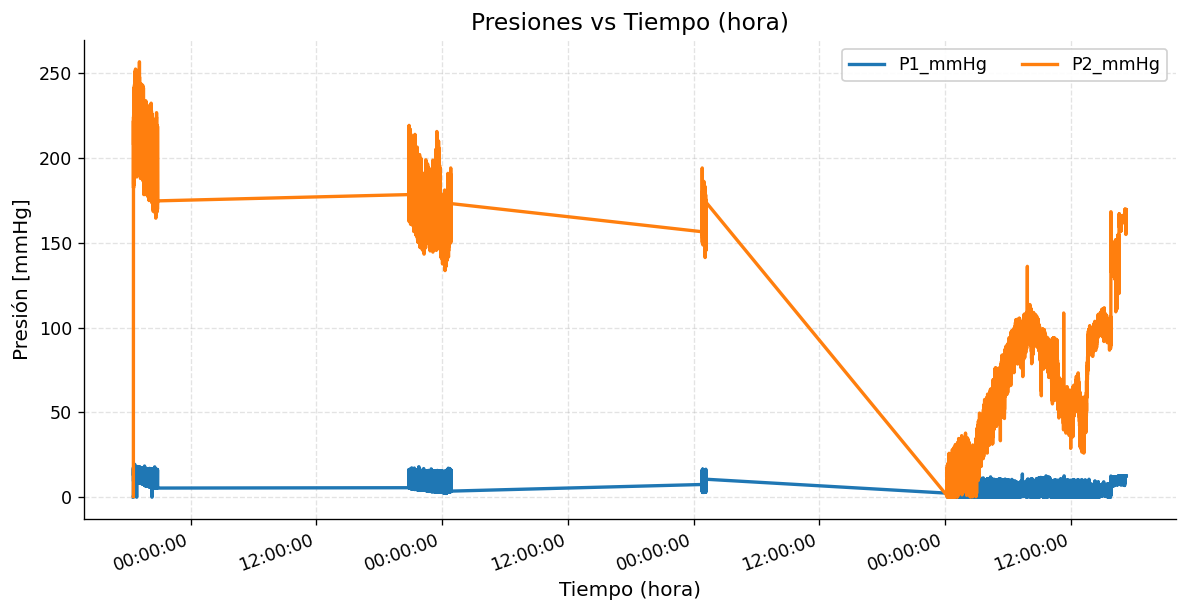

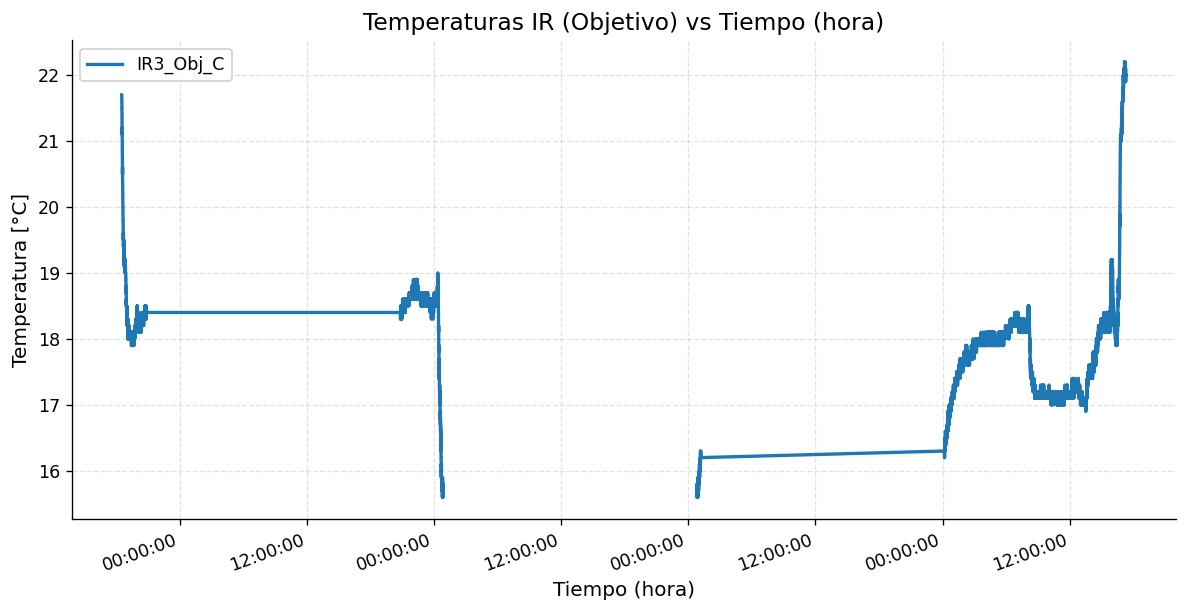

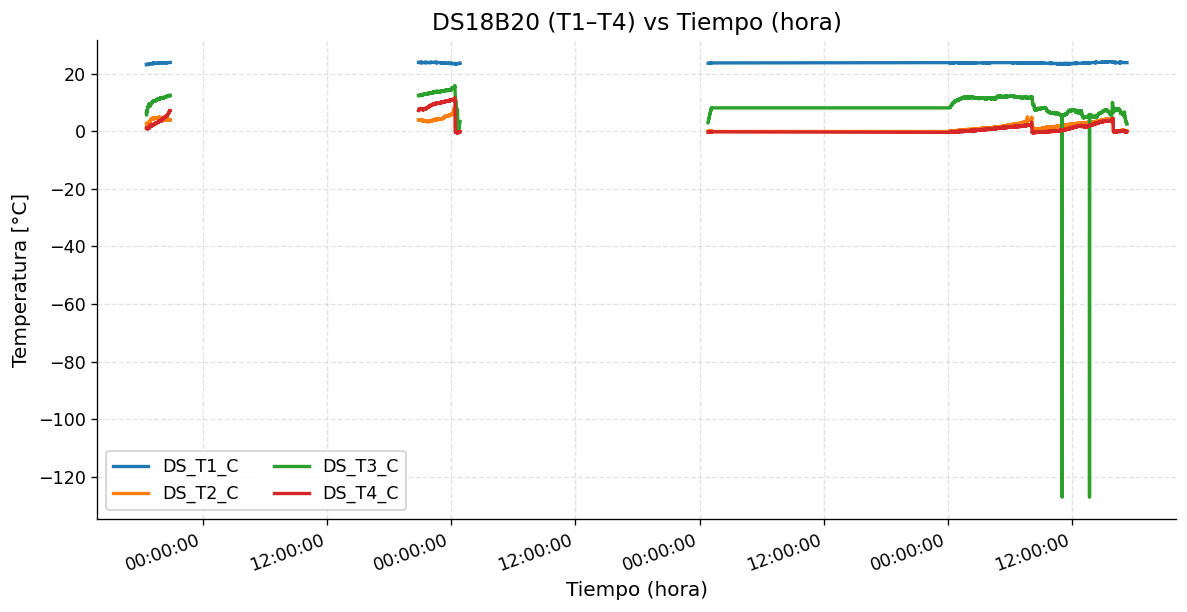

Listo. Figuras guardadas y mostradas.


In [12]:
# -*- coding: utf-8 -*-
"""
Graficación profesional: Presiones, IR y DS18B20 vs tiempo (hora)
- Formato de presentación (fuentes grandes, líneas más gruesas, grilla sutil)
- Manejo de rollover de medianoche para eje temporal continuo
- Guardado en PNG (300 dpi) y PDF + mostrar en pantalla
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ================== Configura aquí ==================
CSV_PATH = "salida_unida.csv"   # archivo combinado
OUT_PREFIX = "fig_"             # prefijo de archivos de salida
SAVE_PNGS = True                # guardar PNG
SAVE_PDFS = True                # guardar PDF
SHOW_PLOTS = True               # mostrar las gráficas en ventana interactiva
DPI = 300                       # resolución de guardado
FIGSIZE = (10, 5.2)             # tamaño en pulgadas
LINEWIDTH = 2.0                 # grosor de línea
MARKERSIZE = 0                  # 0 = sin marcadores
GRID_ALPHA = 0.35               # opacidad de grilla
# ====================================================

# ---- Estilo global ----
plt.rcParams.update({
    "figure.figsize": FIGSIZE,
    "figure.dpi": 120,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": GRID_ALPHA,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10.5,
    "ytick.labelsize": 10.5,
    "legend.fontsize": 10.5,
    "lines.linewidth": LINEWIDTH,
    "lines.markersize": MARKERSIZE,
})

def construir_tiempo_continuo(time_series: pd.Series) -> pd.Series:
    """
    Convierte columnas de tiempo a datetime continuo,
    manejando rollover de medianoche.
    """
    t_str = time_series.astype(str).str.strip()
    t_norm = t_str.str.replace(",", ".", regex=False)
    tiene_fecha = t_norm.str.contains("T")
    dt = pd.Series(pd.NaT, index=t_norm.index, dtype="datetime64[ns]")

    if tiene_fecha.any():
        dt.loc[tiene_fecha] = pd.to_datetime(t_norm[tiene_fecha], errors="coerce")

    if (~tiene_fecha).any():
        t_hora = "2000-01-01 " + t_norm[~tiene_fecha]
        dt_hora = pd.to_datetime(t_hora, format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
        mask_na = dt_hora.isna()
        if mask_na.any():
            dt_hora2 = pd.to_datetime(
                ("2000-01-01 " + t_norm[~tiene_fecha][mask_na]),
                format="%Y-%m-%d %H:%M:%S",
                errors="coerce",
            )
            dt_hora[mask_na] = dt_hora2
        dt.loc[~tiene_fecha] = dt_hora

    if dt.isna().any():
        ejemplos = t_str[dt.isna()].unique()[:5]
        raise ValueError(f"No se pudieron parsear marcas de tiempo: {ejemplos}")

    neg = dt.diff() < pd.Timedelta(0)
    roll = neg.cumsum()
    return dt + pd.to_timedelta(roll, unit="D")

def plot_lineas(x_dt, y_cols, df, titulo, ylabel, fname_base):
    """
    Crea una figura y la muestra/guarda con formato profesional.
    """
    fig, ax = plt.subplots()
    plotted = 0

    for col in y_cols:
        if col in df.columns:
            y = pd.to_numeric(df[col], errors="coerce")
            if np.isfinite(y).sum() == 0:
                continue
            ax.plot(x_dt, y, label=col)
            plotted += 1

    if plotted == 0:
        plt.close(fig)
        print(f"[AVISO] Ninguna de las columnas {y_cols} tiene datos.")
        return

    ax.set_title(titulo)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Tiempo (hora)")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    fig.autofmt_xdate(rotation=20, ha="right")

    leg = ax.legend(ncol=2, frameon=True, fancybox=True, framealpha=0.9)
    for lh in leg.legend_handles:
        lh.set_linewidth(LINEWIDTH)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()

    if SAVE_PNGS:
        plt.savefig(f"{OUT_PREFIX}{fname_base}.png", dpi=DPI)
    if SAVE_PDFS:
        plt.savefig(f"{OUT_PREFIX}{fname_base}.pdf")

    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close(fig)

def main():
    df = pd.read_csv(CSV_PATH)
    if "time" not in df.columns:
        raise KeyError("La columna 'time' no existe en el CSV.")

    x_dt = construir_tiempo_continuo(df["time"])

    plot_lineas(x_dt, ["P1_mmHg", "P2_mmHg"], df,
                "Presiones vs Tiempo (hora)", "Presión [mmHg]", "presiones_vs_tiempo")

    plot_lineas(x_dt, ["IR2_Obj_C", "IR3_Obj_C"], df,
                "Temperaturas IR (Objetivo) vs Tiempo (hora)", "Temperatura [°C]", "ir_obj_vs_tiempo")

    plot_lineas(x_dt, ["DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"], df,
                "DS18B20 (T1–T4) vs Tiempo (hora)", "Temperatura [°C]", "ds18b20_vs_tiempo")

    print("Listo. Figuras guardadas y mostradas.")

if __name__ == "__main__":
    main()


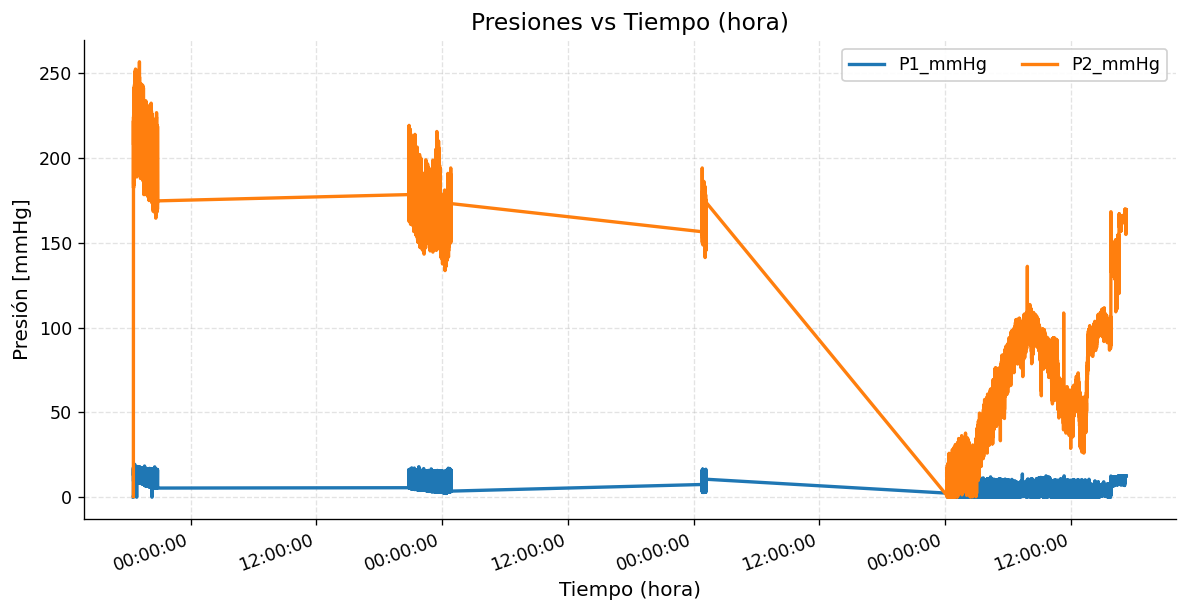

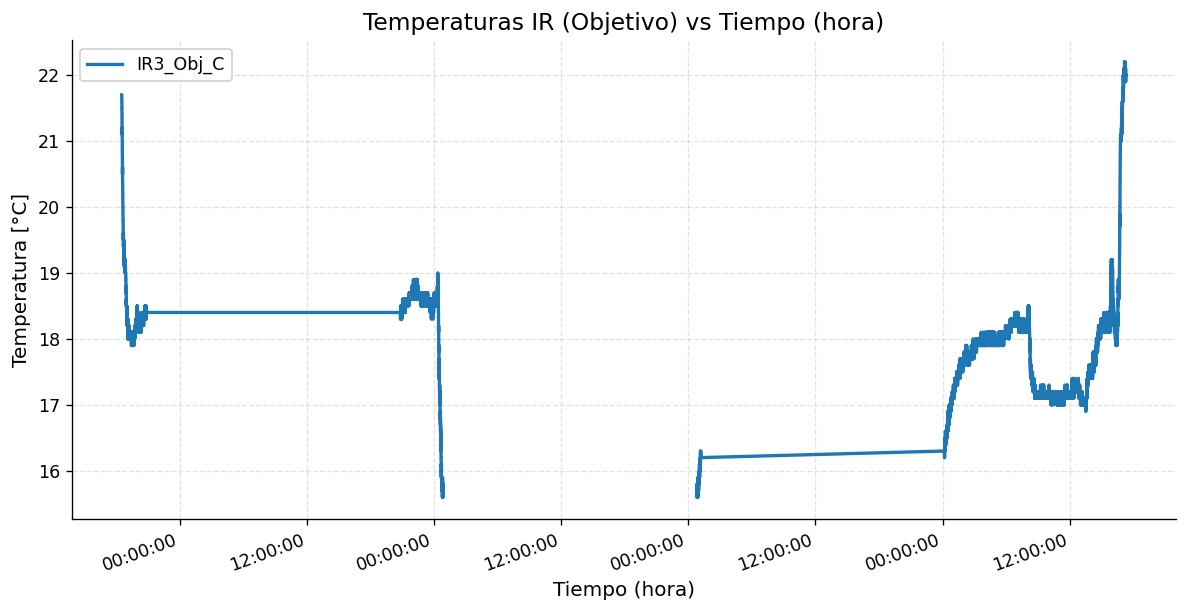

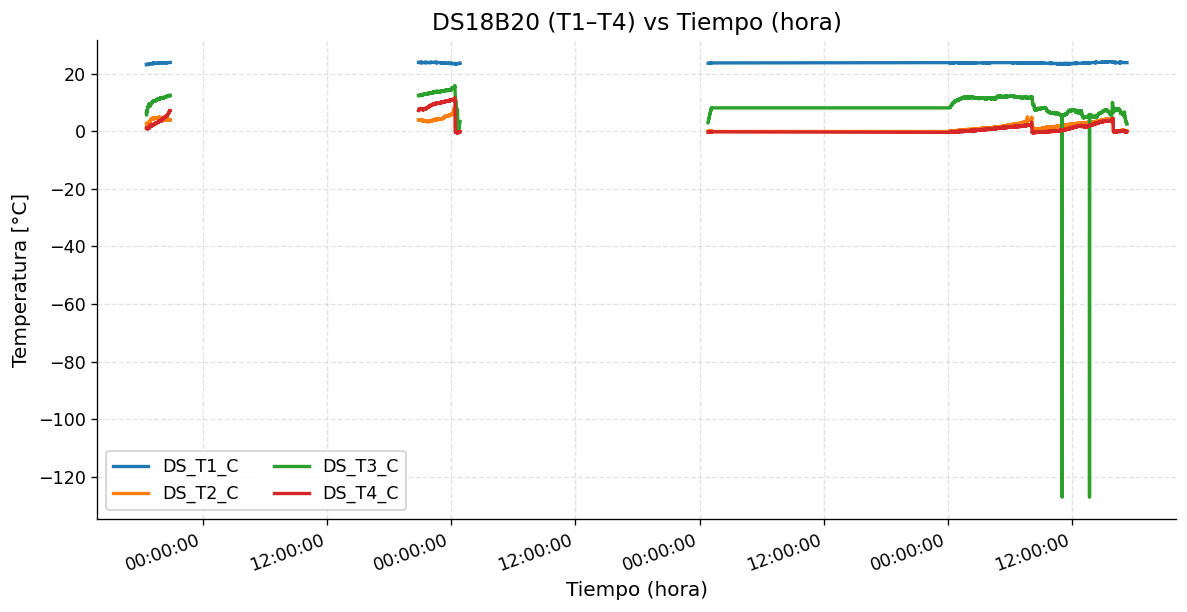

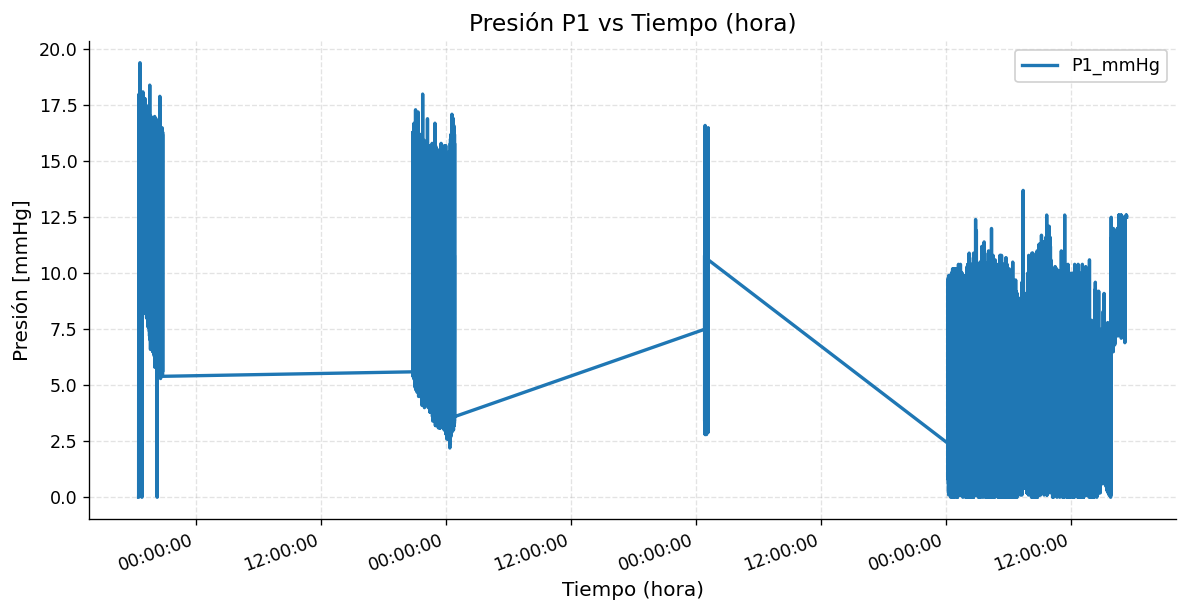

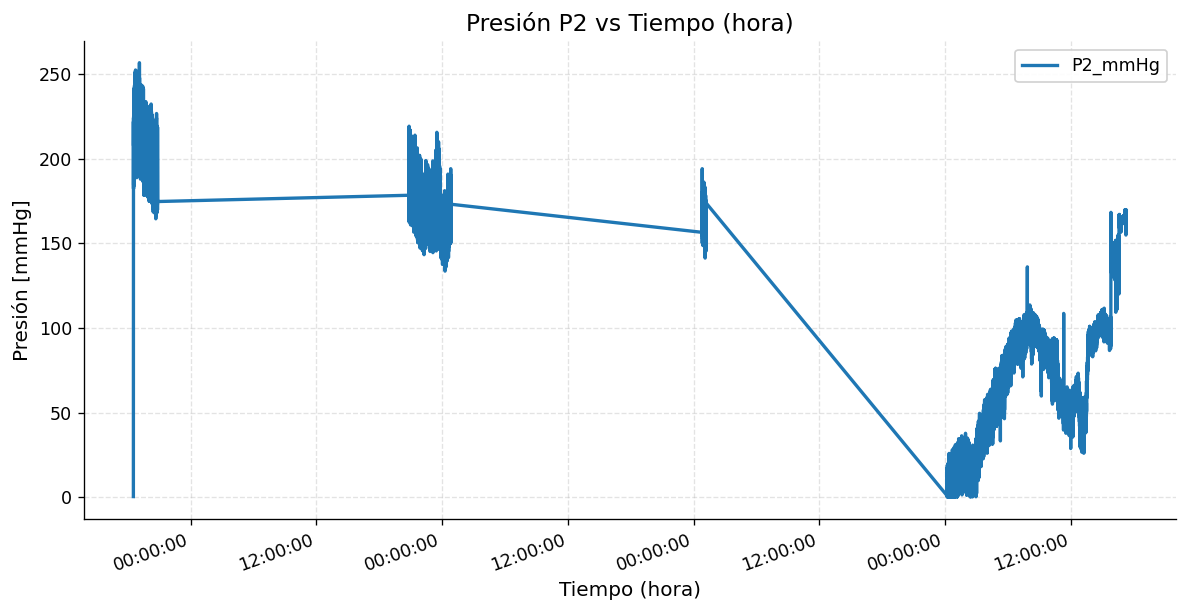

[AVISO] 'IR2_Obj_C' no tiene datos numéricos válidos.


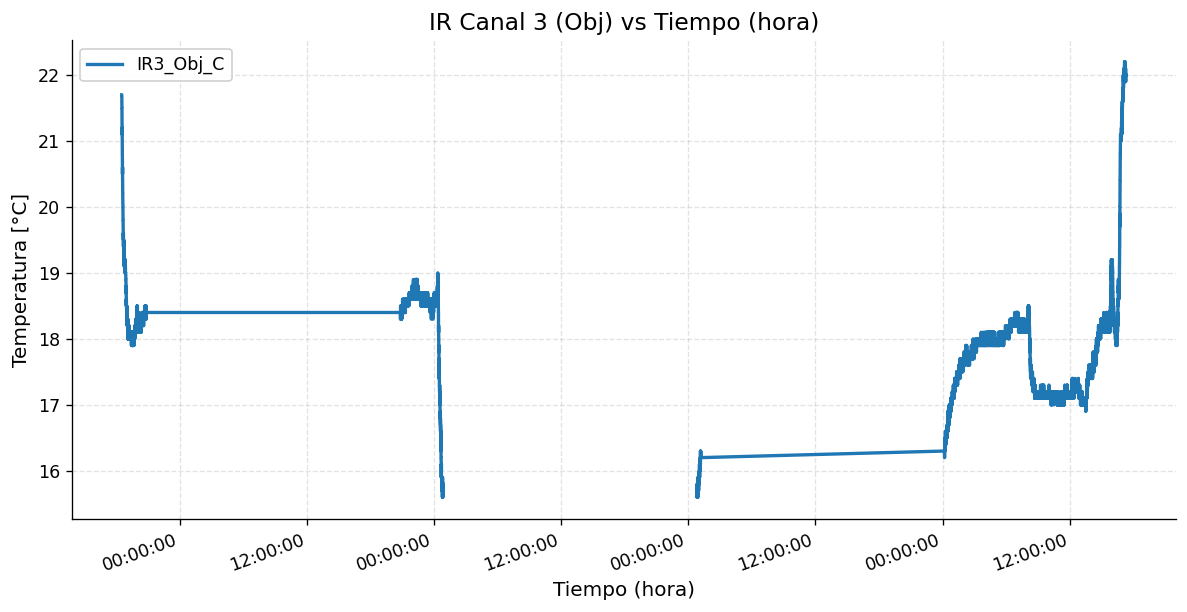

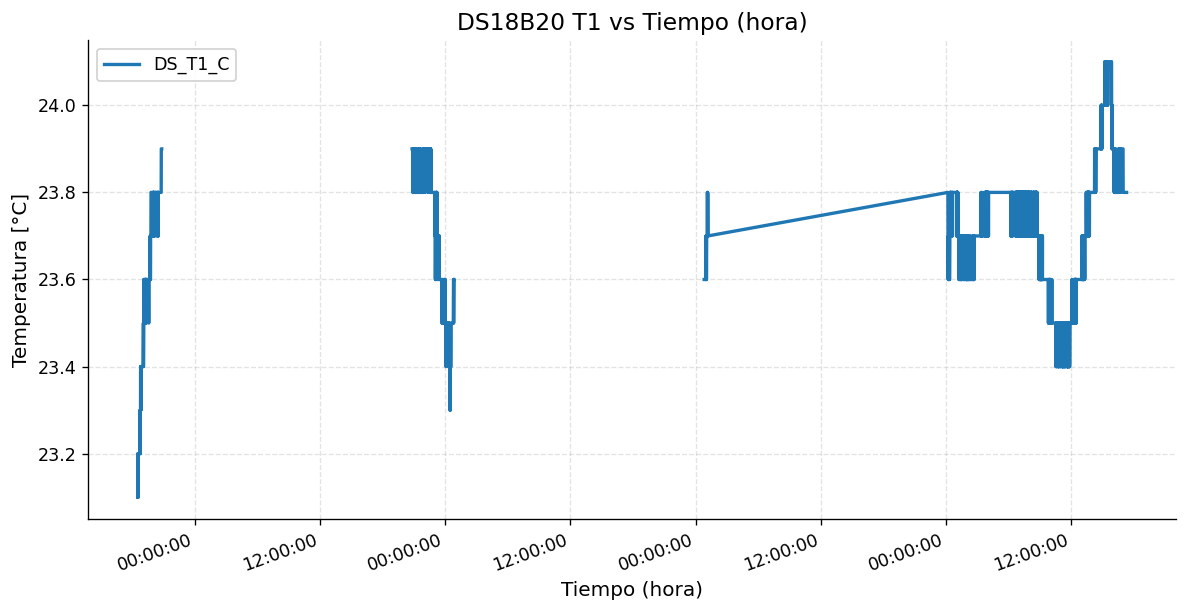

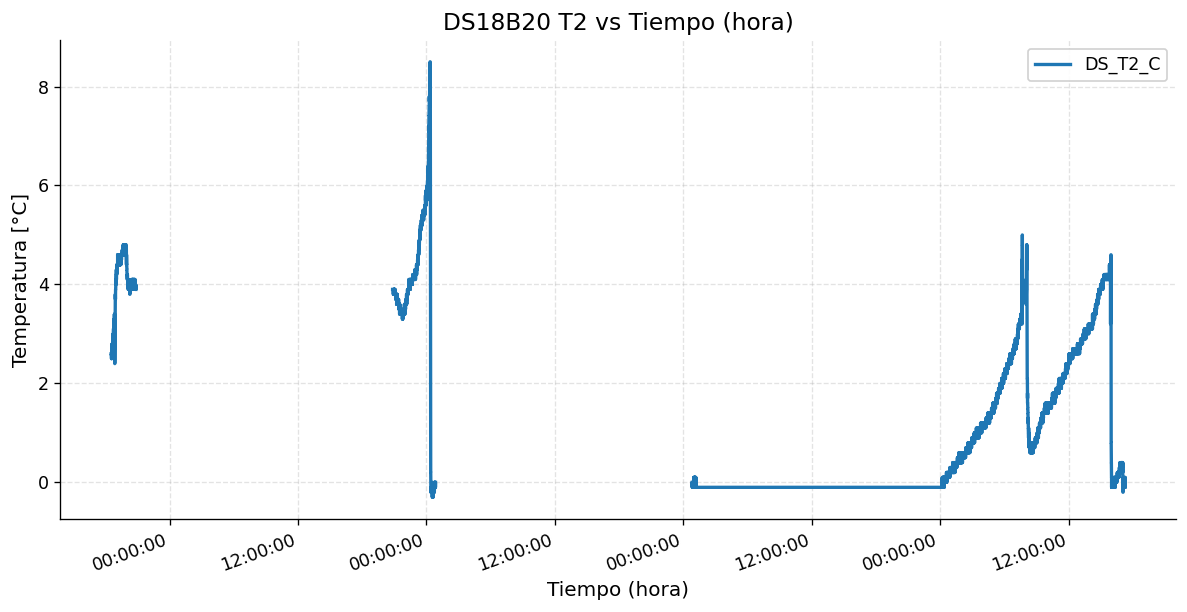

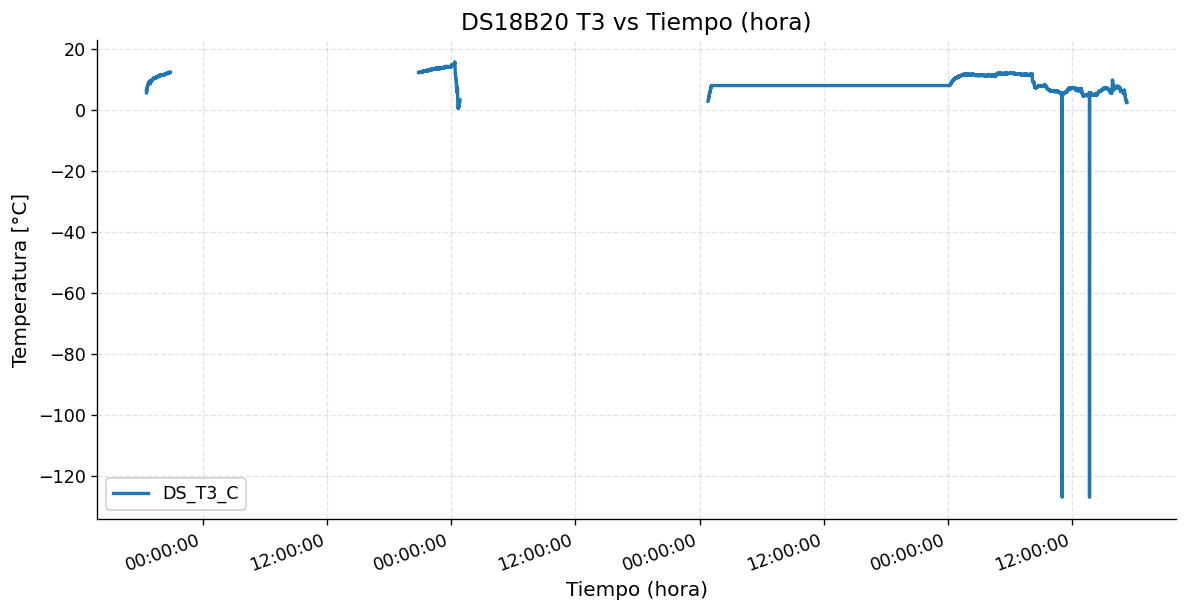

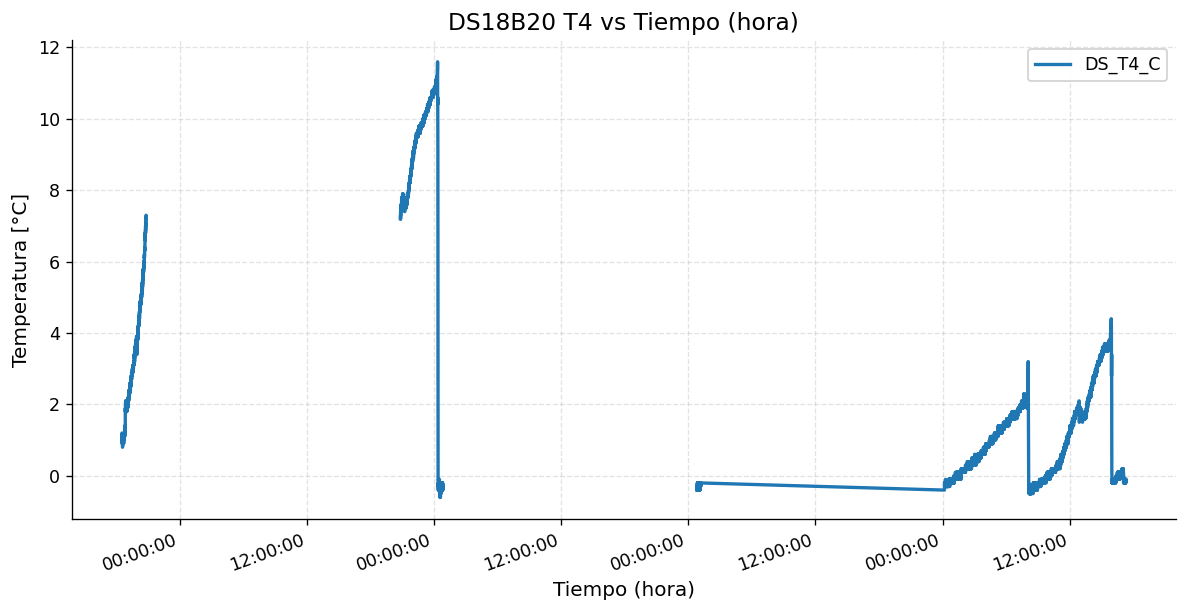

Listo. Figuras generadas.


In [6]:
# -*- coding: utf-8 -*-
"""
Graficación profesional + cortes por intervalos:
- Presiones, IR y DS18B20 (conjuntas e individuales)
- Eje X por 'time' continuo o por 'elapsed_s'
- Filtro por rango [start, end]
- Cortes automáticos en intervalos (5min, 15min, 30min, 1h) con figuras por chunk
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Optional, List, Tuple

# ================== Configura aquí ==================
CSV_PATH      = "salida_unida.csv"   # archivo combinado
OUT_PREFIX    = "fig_"               # prefijo archivos de salida
SAVE_PNGS     = False                 # guardar PNG
SAVE_PDFS     = False                 # guardar PDF
SHOW_PLOTS    = True                 # mostrar ventanas interactivas
DPI           = 300                  # resolución de guardado
FIGSIZE       = (10, 5.2)            # tamaño de figura
LINEWIDTH     = 2.0                  # grosor de línea
MARKERSIZE    = 0                    # 0 = sin marcadores
GRID_ALPHA    = 0.35                 # opacidad grilla

# Eje temporal:
USE_ELAPSED   = False                # True -> usa 'elapsed_s'; False -> usa 'time' continuo
ELAPSED_ZERO_DATE = pd.Timestamp('2000-01-01')  # “fecha cero” para elapsed_s

# Filtros de tiempo (opcional). Aceptan:
# - strings tipo 'HH:MM:SS' (cuando USE_ELAPSED=False o True)
# - None para no aplicar ese extremo del filtro
RANGE_START: Optional[str] = None    # ej. "00:00:00" o None
RANGE_END:   Optional[str] = None    # ej. "01:00:00" o None

# Cortes automáticos en intervalos (chunks):
# Opciones típicas: '5min', '15min', '30min', '1h'
# Deja None para no hacer cortes automáticos.
CHUNK_FREQ: Optional[str] = None     # ej. '15min' o None
# ====================================================

# ---- Estilo global (profesional, limpio) ----
plt.rcParams.update({
    "figure.figsize": FIGSIZE,
    "figure.dpi": 120,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": GRID_ALPHA,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10.5,
    "ytick.labelsize": 10.5,
    "legend.fontsize": 10.5,
    "lines.linewidth": LINEWIDTH,
    "lines.markersize": MARKERSIZE,
})

def construir_tiempo_continuo(time_series: pd.Series) -> pd.Series:
    """
    Convierte 'time' a datetime continuo:
    - Acepta 'HH:MM:SS(.mmm)' o ISO 'YYYY-MM-DDTHH:MM:SS(.mmm)'
    - Usa fecha ficticia cuando solo hay hora
    - Maneja rollover de medianoche sumando +1 día cuando el reloj retrocede
    """
    t_str = time_series.astype(str).str.strip()
    t_norm = t_str.str.replace(",", ".", regex=False)
    tiene_fecha = t_norm.str.contains("T")
    dt = pd.Series(pd.NaT, index=t_norm.index, dtype="datetime64[ns]")

    if tiene_fecha.any():
        dt.loc[tiene_fecha] = pd.to_datetime(t_norm[tiene_fecha], errors="coerce")

    if (~tiene_fecha).any():
        t_hora = "2000-01-01 " + t_norm[~tiene_fecha]
        dt_hora = pd.to_datetime(t_hora, format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
        mask_na = dt_hora.isna()
        if mask_na.any():
            dt_hora2 = pd.to_datetime(
                ("2000-01-01 " + t_norm[~tiene_fecha][mask_na]),
                format="%Y-%m-%d %H:%M:%S",
                errors="coerce",
            )
            dt_hora[mask_na] = dt_hora2
        dt.loc[~tiene_fecha] = dt_hora

    if dt.isna().any():
        ejemplos = t_str[dt.isna()].unique()[:5]
        raise ValueError(
            "No se pudieron parsear algunas marcas de tiempo. Ejemplos: "
            + ", ".join(map(str, ejemplos))
        )

    neg = dt.diff() < pd.Timedelta(0)
    roll = neg.cumsum()
    return dt + pd.to_timedelta(roll, unit="D")

def construir_x(df: pd.DataFrame) -> pd.Series:
    """
    Elige el eje X según configuración:
    - USE_ELAPSED=True  -> 'elapsed_s' + fecha ficticia
    - USE_ELAPSED=False -> 'time' continuo
    """
    if USE_ELAPSED:
        if "elapsed_s" not in df.columns:
            raise KeyError("Se configuró USE_ELAPSED=True pero falta la columna 'elapsed_s'.")
        return pd.to_timedelta(pd.to_numeric(df["elapsed_s"], errors="coerce"), unit='s') + ELAPSED_ZERO_DATE
    else:
        if "time" not in df.columns:
            raise KeyError("Se configuró USE_ELAPSED=False pero falta la columna 'time'.")
        return construir_tiempo_continuo(df["time"])

def parse_hhmmss_to_datetime(base_date: pd.Timestamp, hhmmss: str) -> pd.Timestamp:
    """Convierte 'HH:MM:SS' a base_date + ese tiempo."""
    t = pd.to_timedelta(hhmmss)
    return base_date + t

def filtrar_rango(x_dt: pd.Series, df: pd.DataFrame,
                  start_hhmmss: Optional[str], end_hhmmss: Optional[str]) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Filtra por un rango [start, end] dado en 'HH:MM:SS'.
    Si alguno es None, no aplica ese extremo.
    """
    if start_hhmmss is None and end_hhmmss is None:
        return x_dt, df

    base_date = x_dt.iloc[0].normalize()
    mask = pd.Series(True, index=df.index)

    if start_hhmmss is not None:
        t0 = parse_hhmmss_to_datetime(base_date, start_hhmmss)
        mask &= (x_dt >= t0)
    if end_hhmmss is not None:
        t1 = parse_hhmmss_to_datetime(base_date, end_hhmmss)
        mask &= (x_dt <= t1)

    return x_dt[mask], df.loc[mask].reset_index(drop=True)

def cortes_por_intervalo(x_dt: pd.Series, df: pd.DataFrame, freq: str) -> List[Tuple[pd.Series, pd.DataFrame, str]]:
    """
    Divide el rango total en intervalos consecutivos de tamaño 'freq'
    (ej. '5min', '15min', '30min', '1h'), devolviendo una lista de (x_dt_chunk, df_chunk, etiqueta).
    """
    tmp = df.copy()
    tmp = tmp.assign(_x=x_dt.values).set_index("_x")

    # Asegura orden por el índice temporal
    tmp = tmp.sort_index()

    chunks = []
    for tbin, df_chunk in tmp.groupby(pd.Grouper(freq=freq)):
        if df_chunk.empty:
            continue
        x_chunk = df_chunk.index.to_series()
        # Etiqueta legible con el rango del chunk
        t_start = x_chunk.iloc[0]
        t_end   = x_chunk.iloc[-1]
        label   = f"{t_start.strftime('%H-%M-%S')}_a_{t_end.strftime('%H-%M-%S')}"
        chunks.append((x_chunk.reset_index(drop=True), df_chunk.reset_index(drop=True), label))
    return chunks

def _save_and_show(fig, fname_base: str):
    if SAVE_PNGS:
        fig.savefig(f"{OUT_PREFIX}{fname_base}.png", dpi=DPI)
    if SAVE_PDFS:
        fig.savefig(f"{OUT_PREFIX}{fname_base}.pdf")
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close(fig)

def plot_lineas(x_dt, y_cols, df, titulo, ylabel, fname_base):
    """Gráfica multi-serie con formato profesional."""
    fig, ax = plt.subplots()
    plotted = 0
    for col in y_cols:
        if col in df.columns:
            y = pd.to_numeric(df[col], errors="coerce")
            if np.isfinite(y).sum() == 0:
                continue
            ax.plot(x_dt, y, label=col)
            plotted += 1

    if plotted == 0:
        plt.close(fig)
        print(f"[AVISO] Sin datos en {y_cols}")
        return

    ax.set_title(titulo)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Tiempo (hora)")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    fig.autofmt_xdate(rotation=20, ha="right")

    leg = ax.legend(ncol=2, frameon=True, fancybox=True, framealpha=0.9)
    for lh in leg.legend_handles:
        lh.set_linewidth(LINEWIDTH)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    _save_and_show(fig, fname_base)

def plot_individual(x_dt, col, df, titulo, ylabel, fname_base):
    """Gráfica de una sola serie con el mismo formato profesional."""
    if col not in df.columns:
        print(f"[AVISO] Columna '{col}' no encontrada.")
        return
    y = pd.to_numeric(df[col], errors="coerce")
    if not np.isfinite(y).any():
        print(f"[AVISO] '{col}' no tiene datos numéricos válidos.")
        return

    fig, ax = plt.subplots()
    ax.plot(x_dt, y, label=col)
    ax.set_title(titulo)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Tiempo (hora)")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    fig.autofmt_xdate(rotation=20, ha="right")
    ax.legend(frameon=True, fancybox=True, framealpha=0.9)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    _save_and_show(fig, fname_base)

def generar_todas_las_graficas(x_dt, df, sufijo=""):
    """Genera gráficas combinadas e individuales. 'sufijo' se agrega al nombre del archivo."""
    sfx = ("" if not sufijo else f"__{sufijo}")

    # Combinadas
    plot_lineas(x_dt, ["P1_mmHg", "P2_mmHg"], df,
                "Presiones vs Tiempo (hora)", "Presión [mmHg]",
                f"presiones_vs_tiempo{sfx}")

    plot_lineas(x_dt, ["IR2_Obj_C", "IR3_Obj_C"], df,
                "Temperaturas IR (Objetivo) vs Tiempo (hora)", "Temperatura [°C]",
                f"ir_obj_vs_tiempo{sfx}")

    plot_lineas(x_dt, ["DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"], df,
                "DS18B20 (T1–T4) vs Tiempo (hora)", "Temperatura [°C]",
                f"ds18b20_vs_tiempo{sfx}")

    # Individuales — Presiones
    plot_individual(x_dt, "P1_mmHg", df, "Presión P1 vs Tiempo (hora)", "Presión [mmHg]",
                    f"P1_vs_tiempo{sfx}")
    plot_individual(x_dt, "P2_mmHg", df, "Presión P2 vs Tiempo (hora)", "Presión [mmHg]",
                    f"P2_vs_tiempo{sfx}")

    # Individuales — IR
    plot_individual(x_dt, "IR2_Obj_C", df, "IR Canal 2 (Obj) vs Tiempo (hora)", "Temperatura [°C]",
                    f"IR2_obj_vs_tiempo{sfx}")
    plot_individual(x_dt, "IR3_Obj_C", df, "IR Canal 3 (Obj) vs Tiempo (hora)", "Temperatura [°C]",
                    f"IR3_obj_vs_tiempo{sfx}")

    # Individuales — DS18B20
    for col, etiqueta in [
        ("DS_T1_C", "DS18B20 T1"),
        ("DS_T2_C", "DS18B20 T2"),
        ("DS_T3_C", "DS18B20 T3"),
        ("DS_T4_C", "DS18B20 T4"),
    ]:
        plot_individual(x_dt, col, df, f"{etiqueta} vs Tiempo (hora)", "Temperatura [°C]",
                        f"{col}_vs_tiempo{sfx}")

def main():
    # Carga
    df = pd.read_csv(CSV_PATH)

    # Eje X
    x_dt = construir_x(df)

    # Filtro de rango manual (si se configuró)
    x_use, df_use = filtrar_rango(x_dt, df, RANGE_START, RANGE_END)

    if CHUNK_FREQ is None:
        # Sin cortes automáticos: graficar todo el rango (con/ sin filtro)
        generar_todas_las_graficas(x_use, df_use)
    else:
        # Con cortes automáticos: genera un set de figuras por cada intervalo
        chunks = cortes_por_intervalo(x_use, df_use, CHUNK_FREQ)
        if not chunks:
            print(f"[AVISO] No hubo datos para intervalos '{CHUNK_FREQ}'.")
        for x_chunk, df_chunk, label in chunks:
            generar_todas_las_graficas(x_chunk, df_chunk, sufijo=f"chunk_{CHUNK_FREQ}_{label}")

    print("Listo. Figuras generadas.")

if __name__ == "__main__":
    main()


    #######################33
    ########Eje por elapsed_s (cero relativo):
    #Cambia USE_ELAPSED = True.
    #El eje seguirá formateado en HH:MM:SS partiendo de 00:00:00.
    #Filtrar un rango manual (antes de cortar):
    #RANGE_START = "00:00:00"
    #RANGE_END   = "01:00:00"
    #Cortes automáticos (chunks):
    #CHUNK_FREQ = "15min"   # también "5min", "30min", "1h"


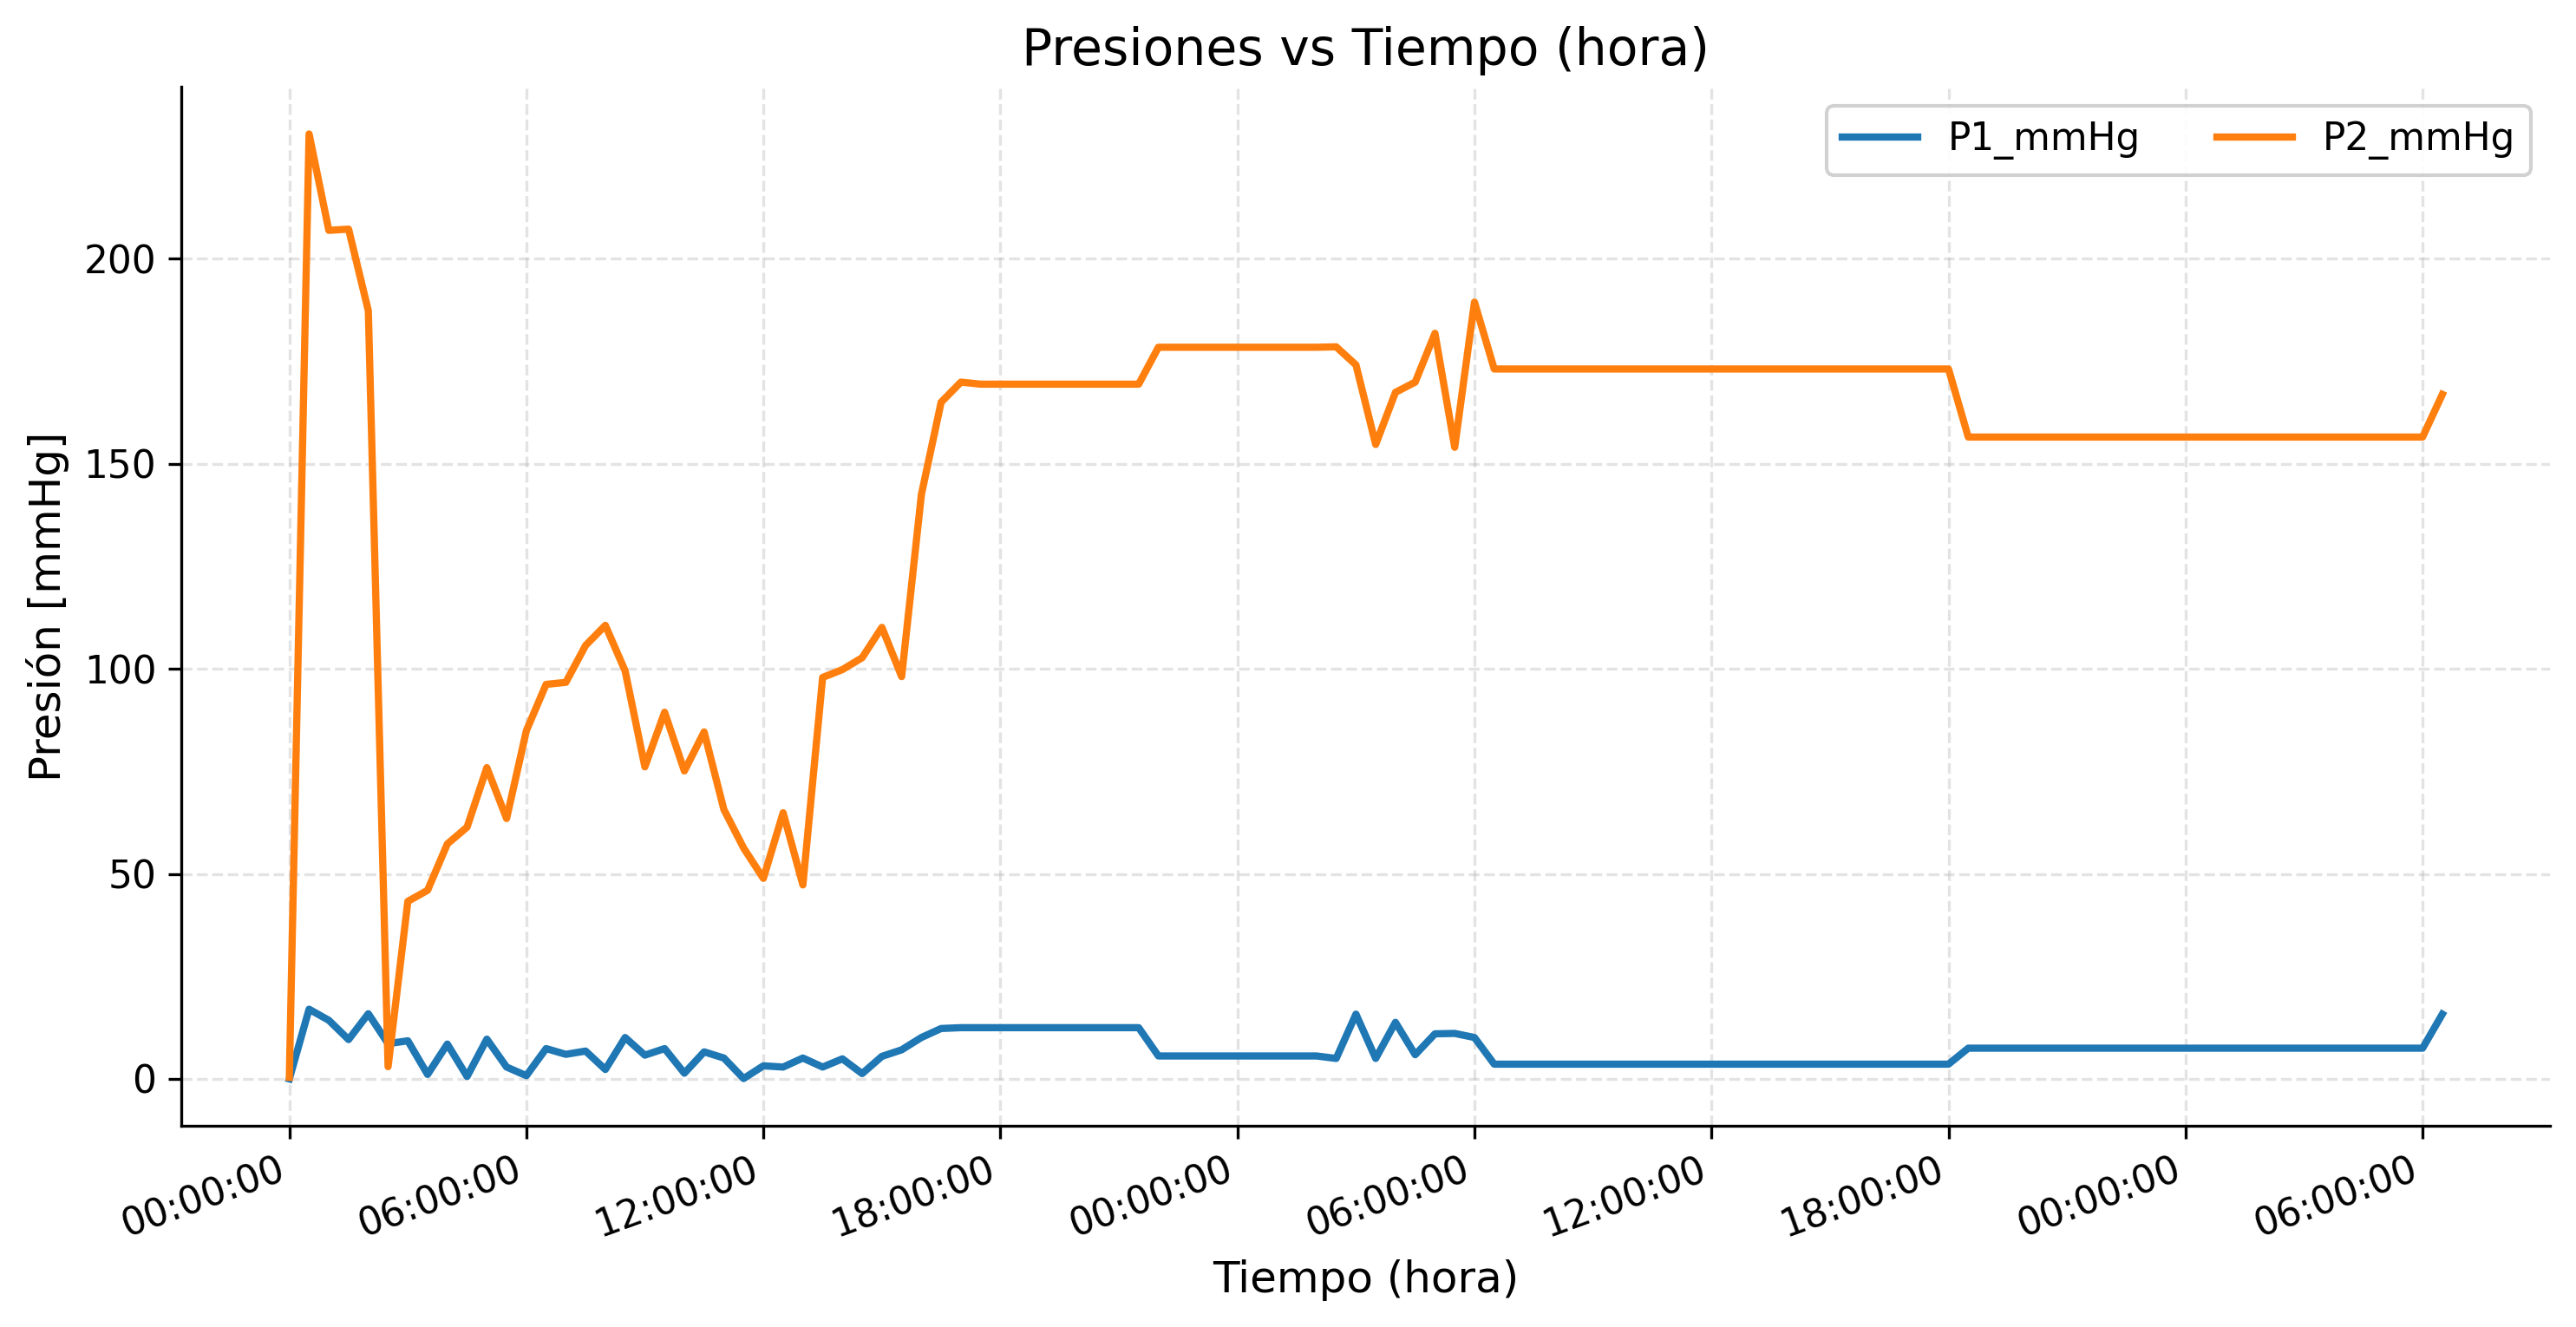

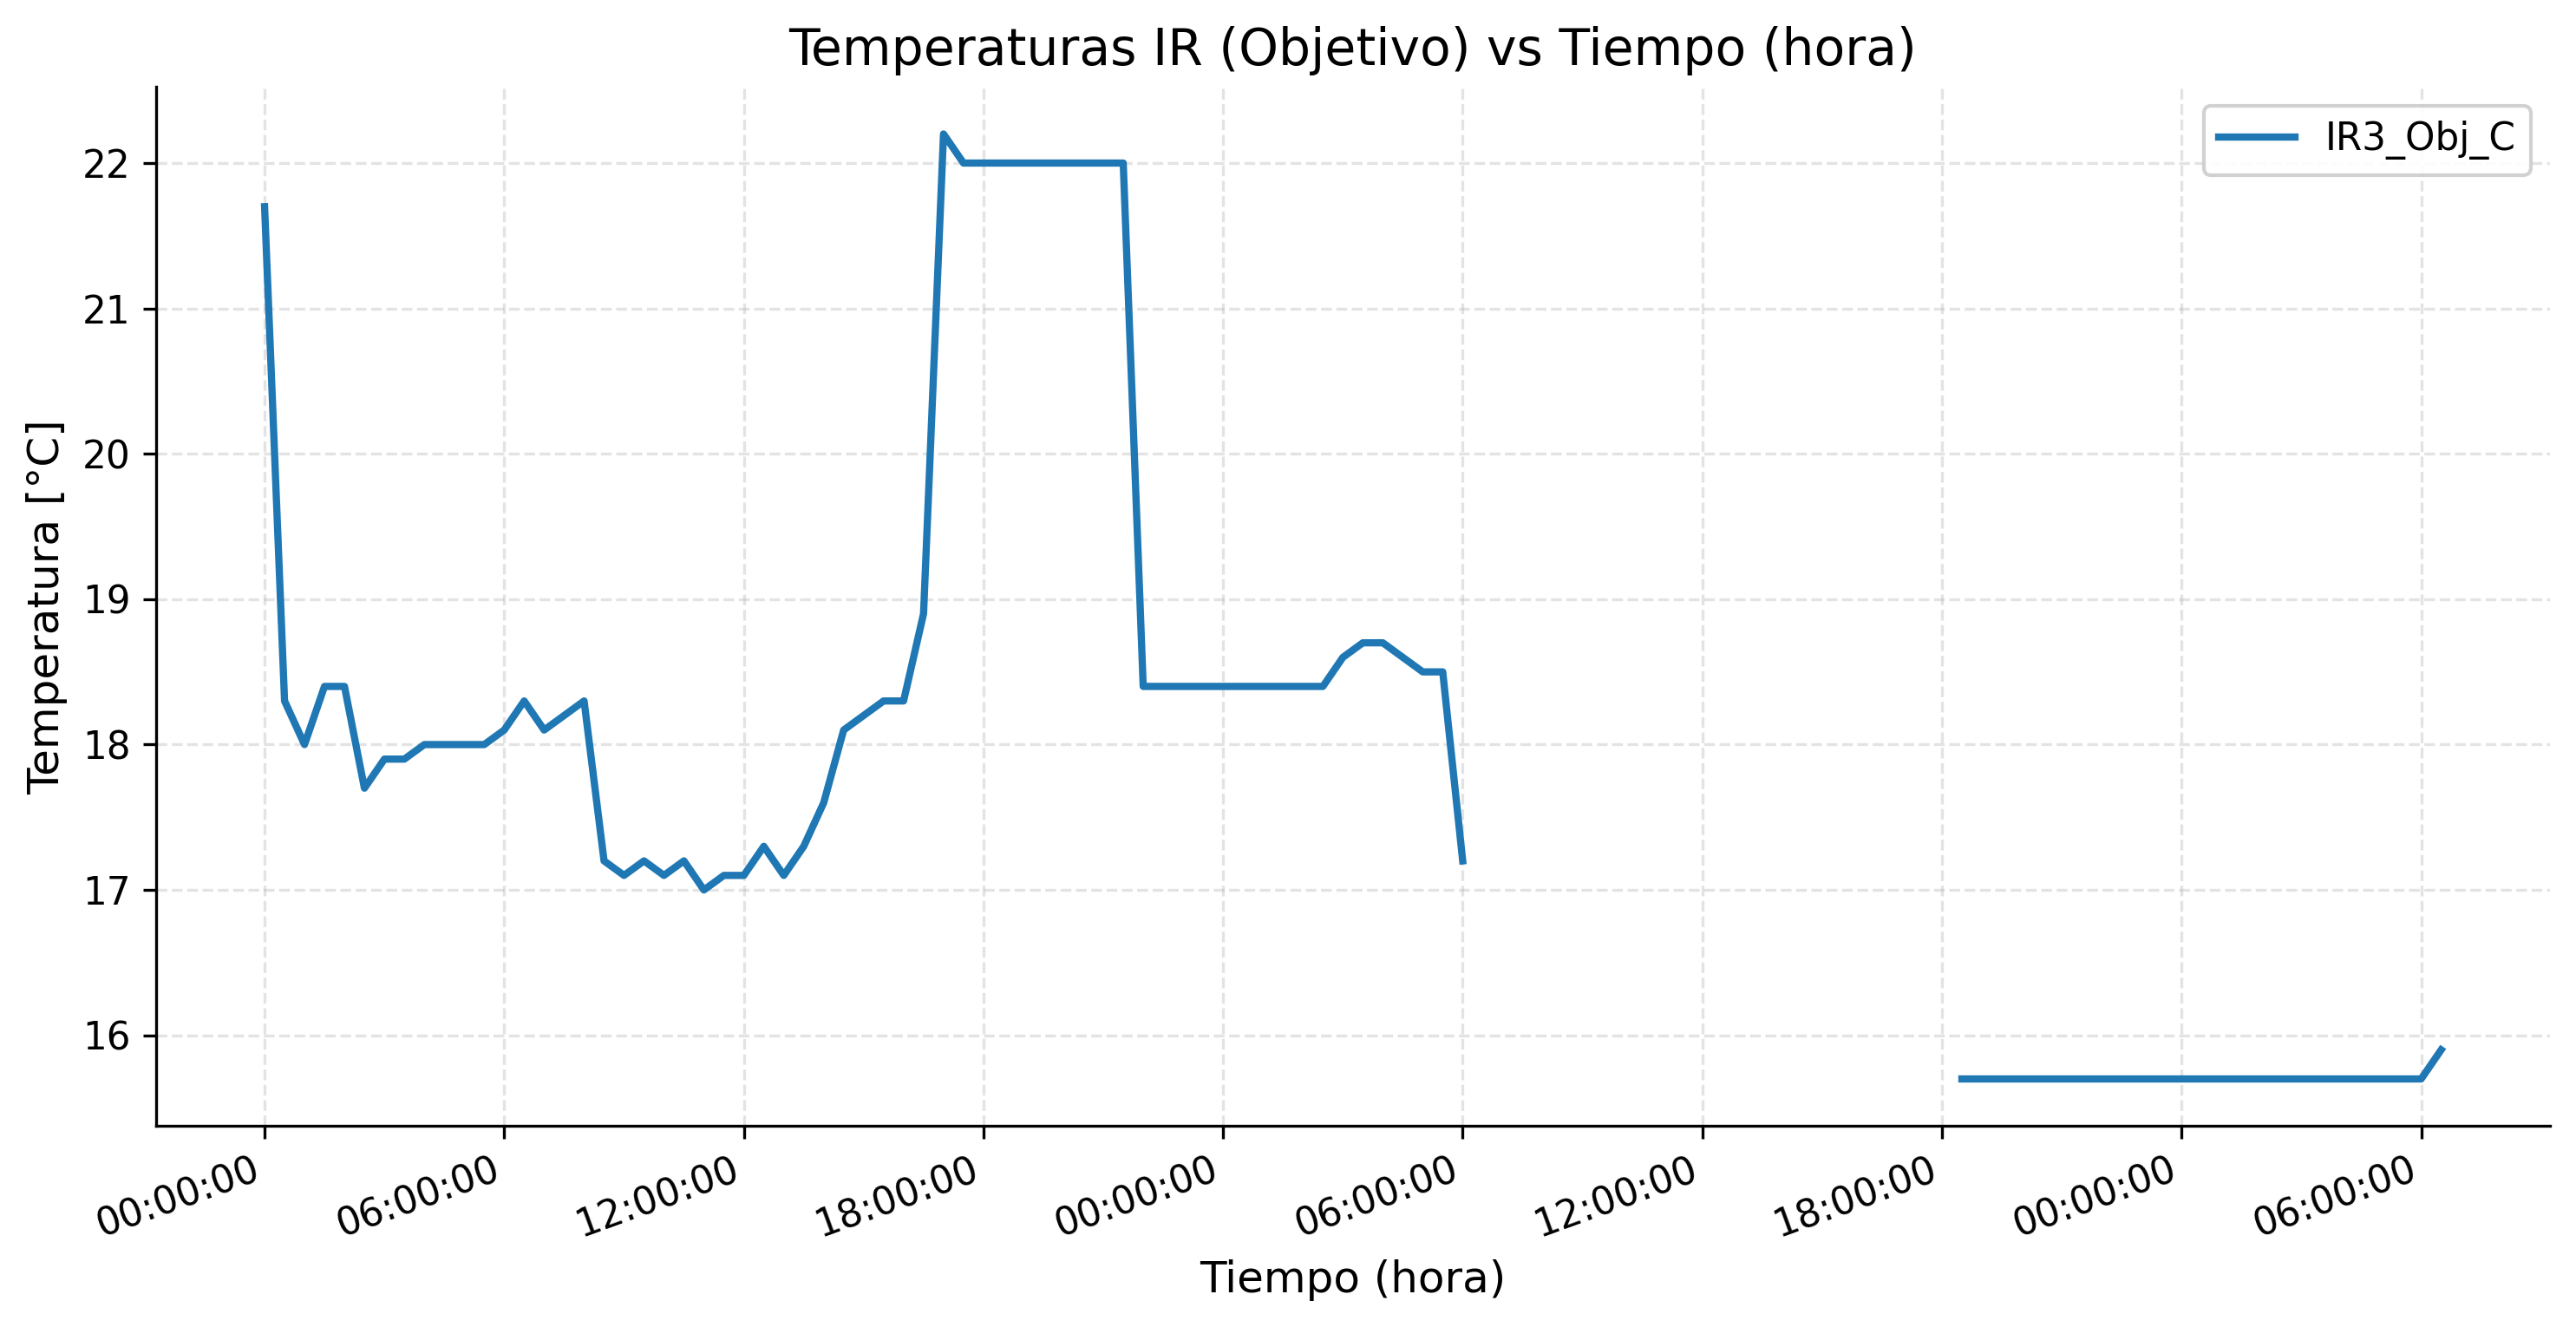

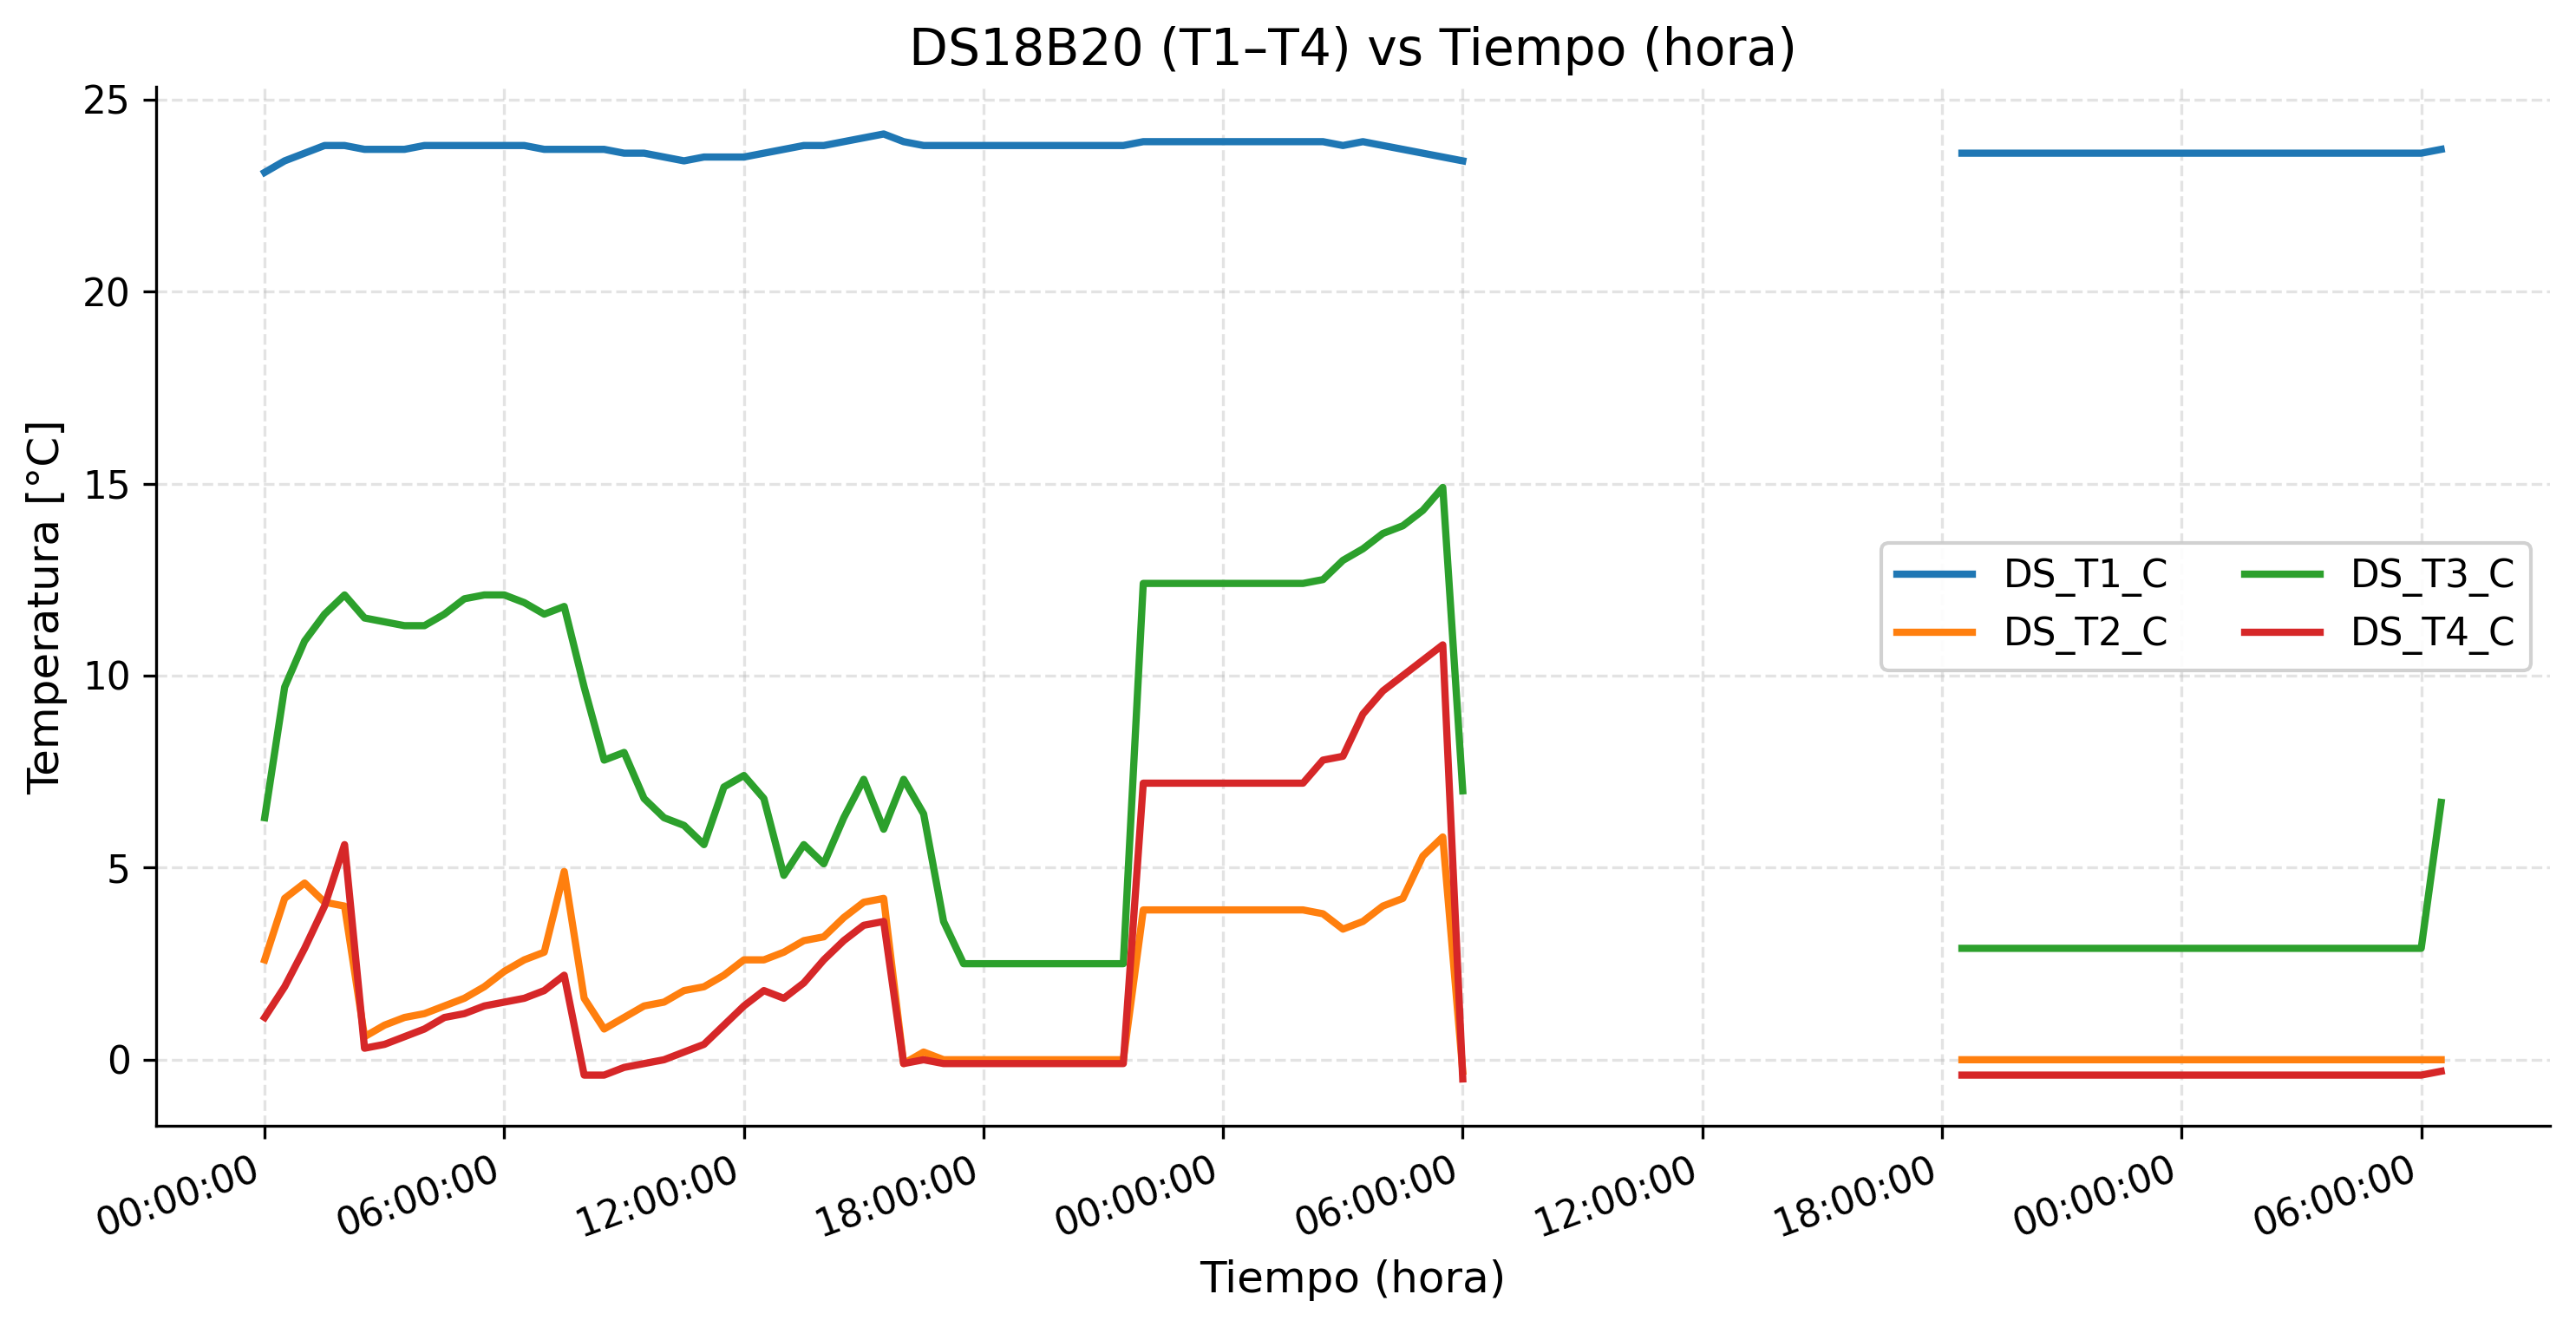

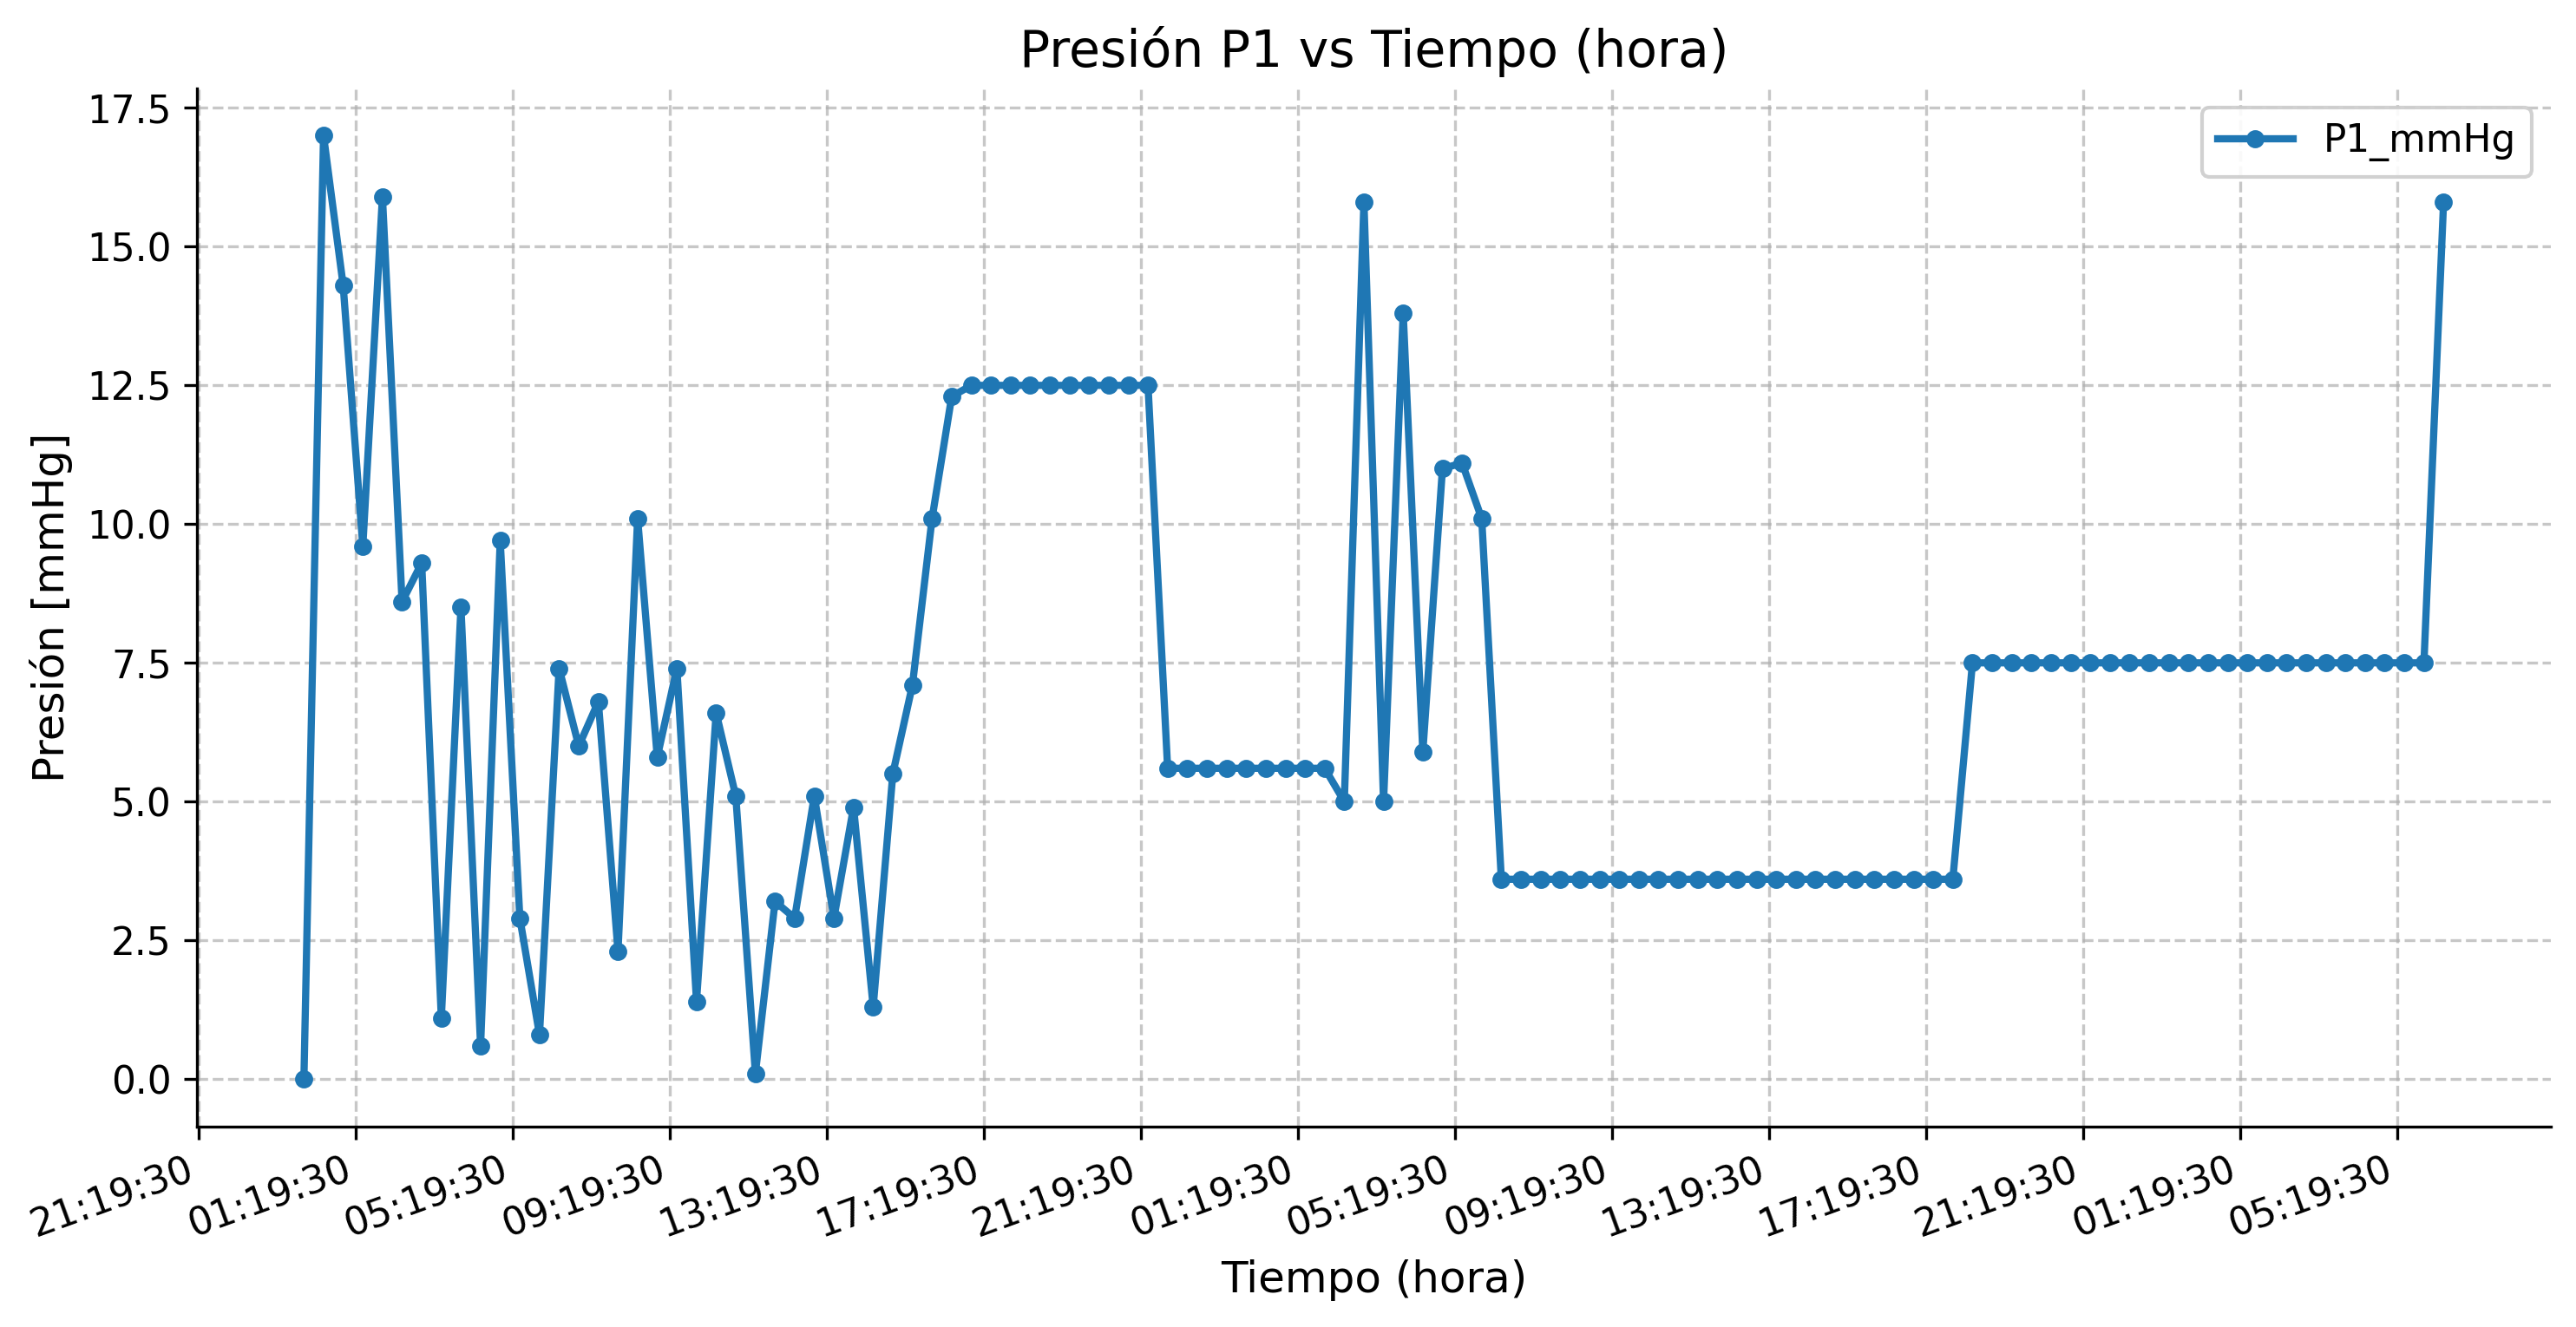

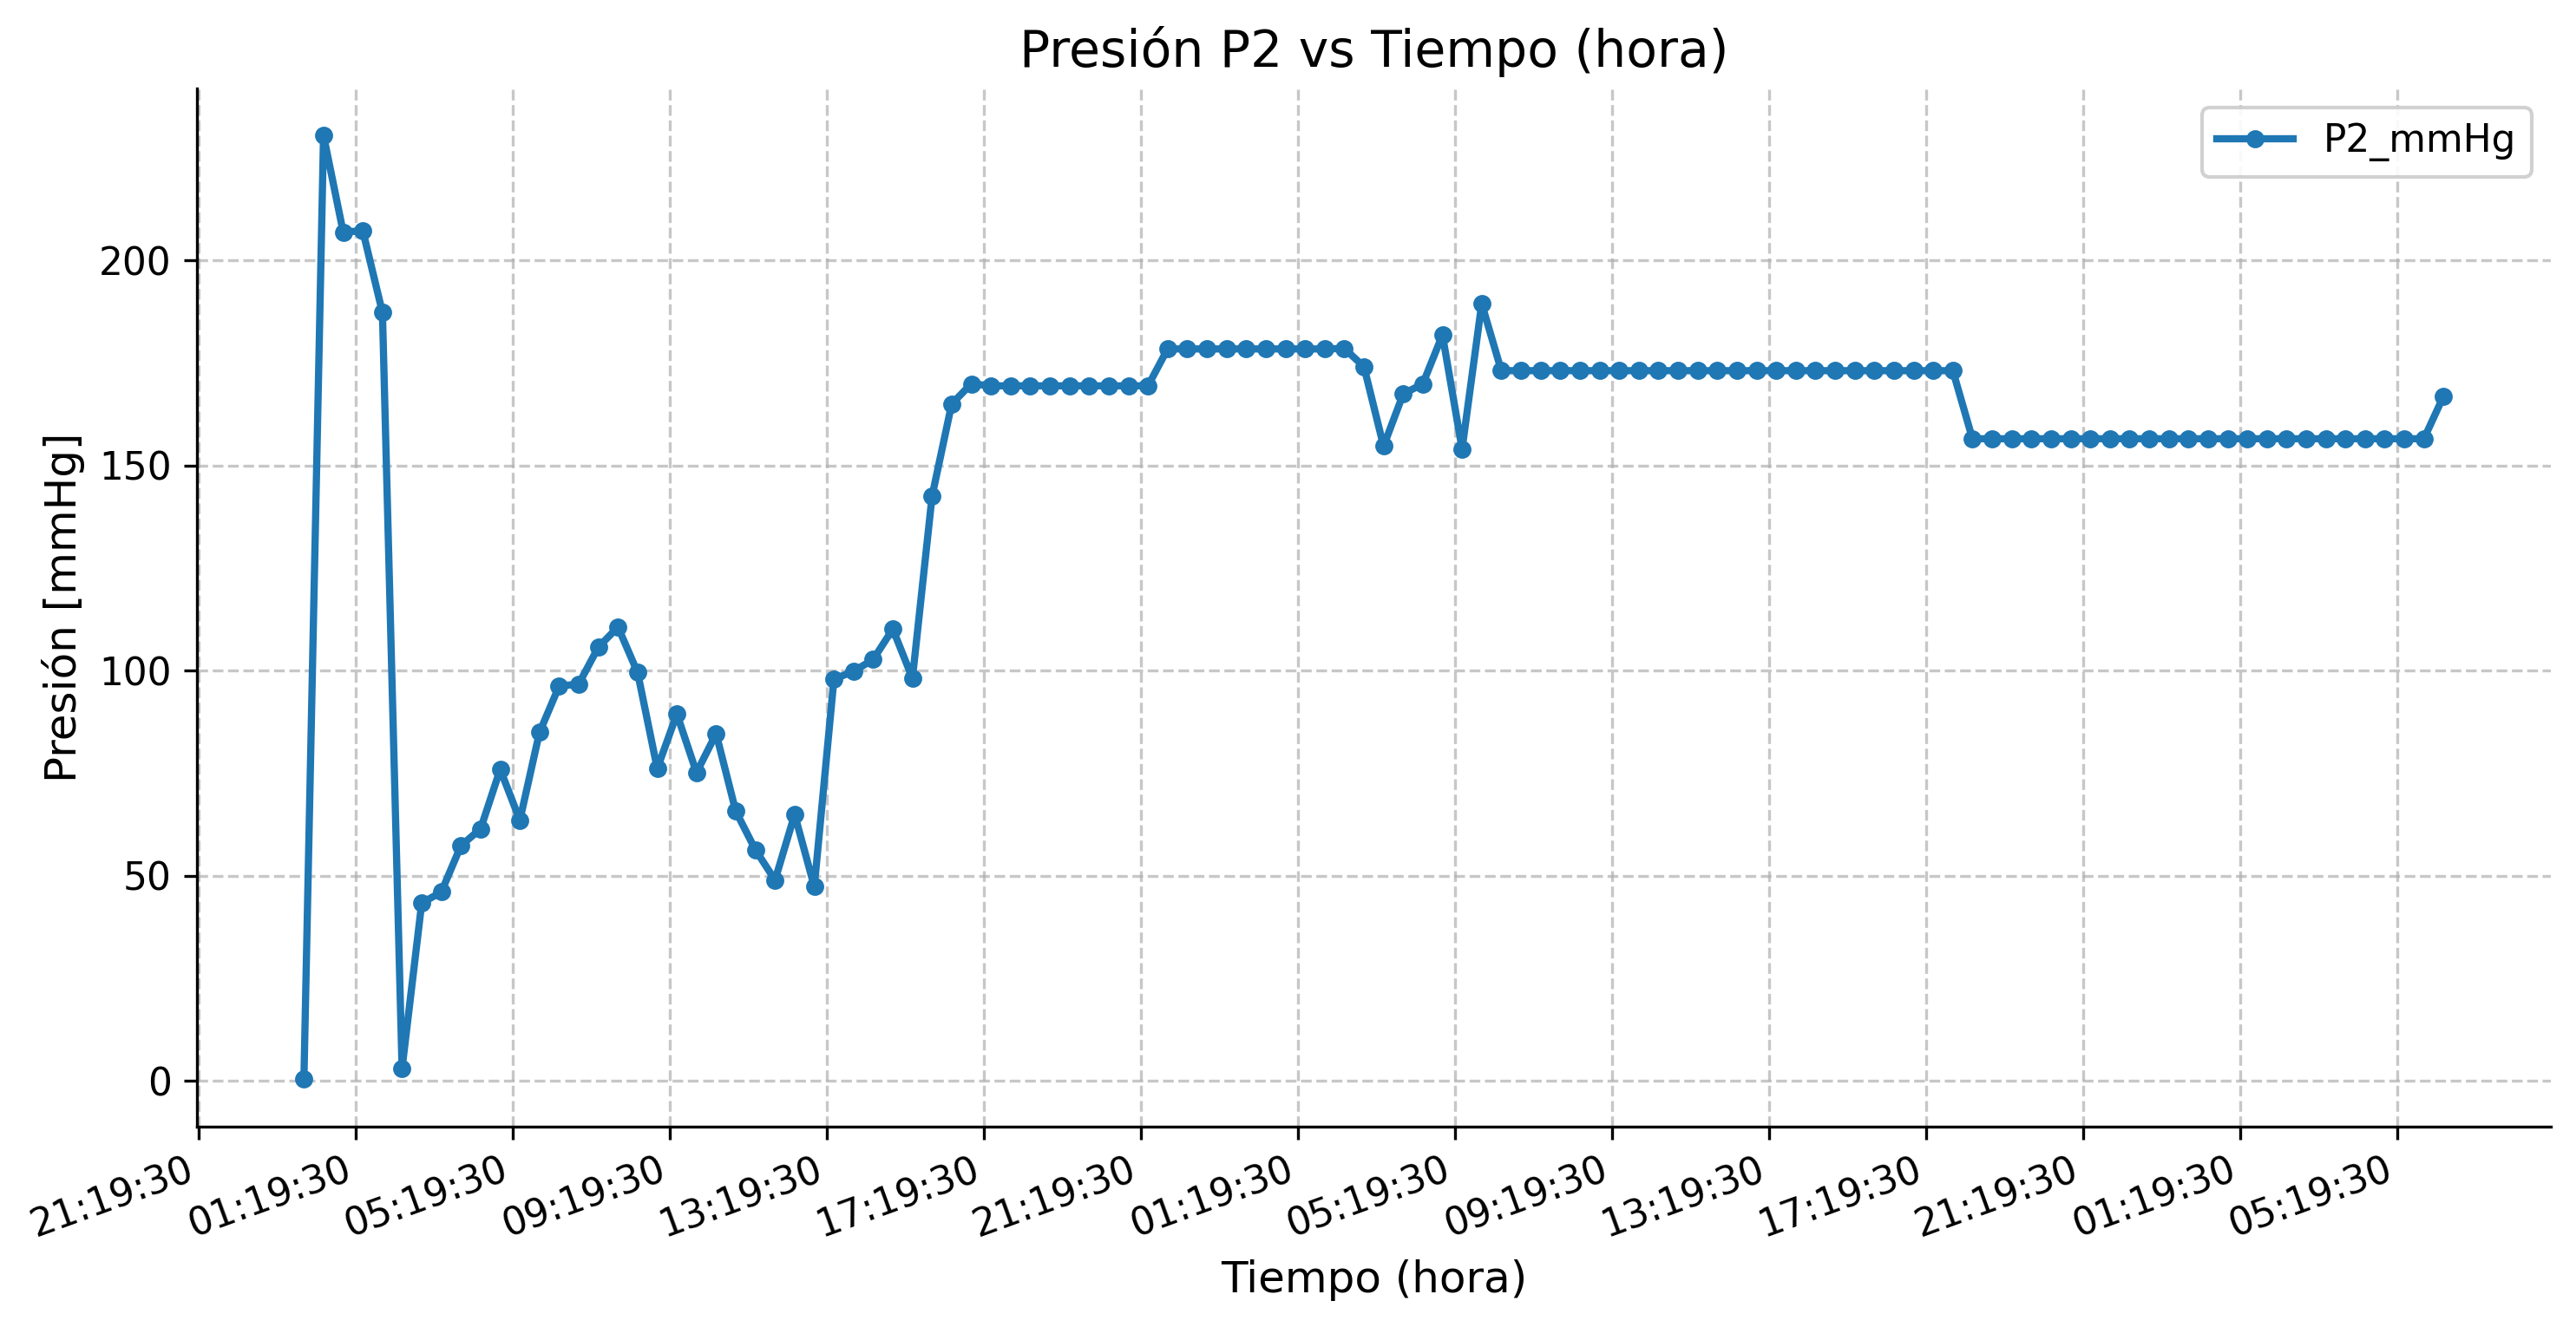

[AVISO] 'IR2_Obj_C' no tiene datos numéricos válidos.


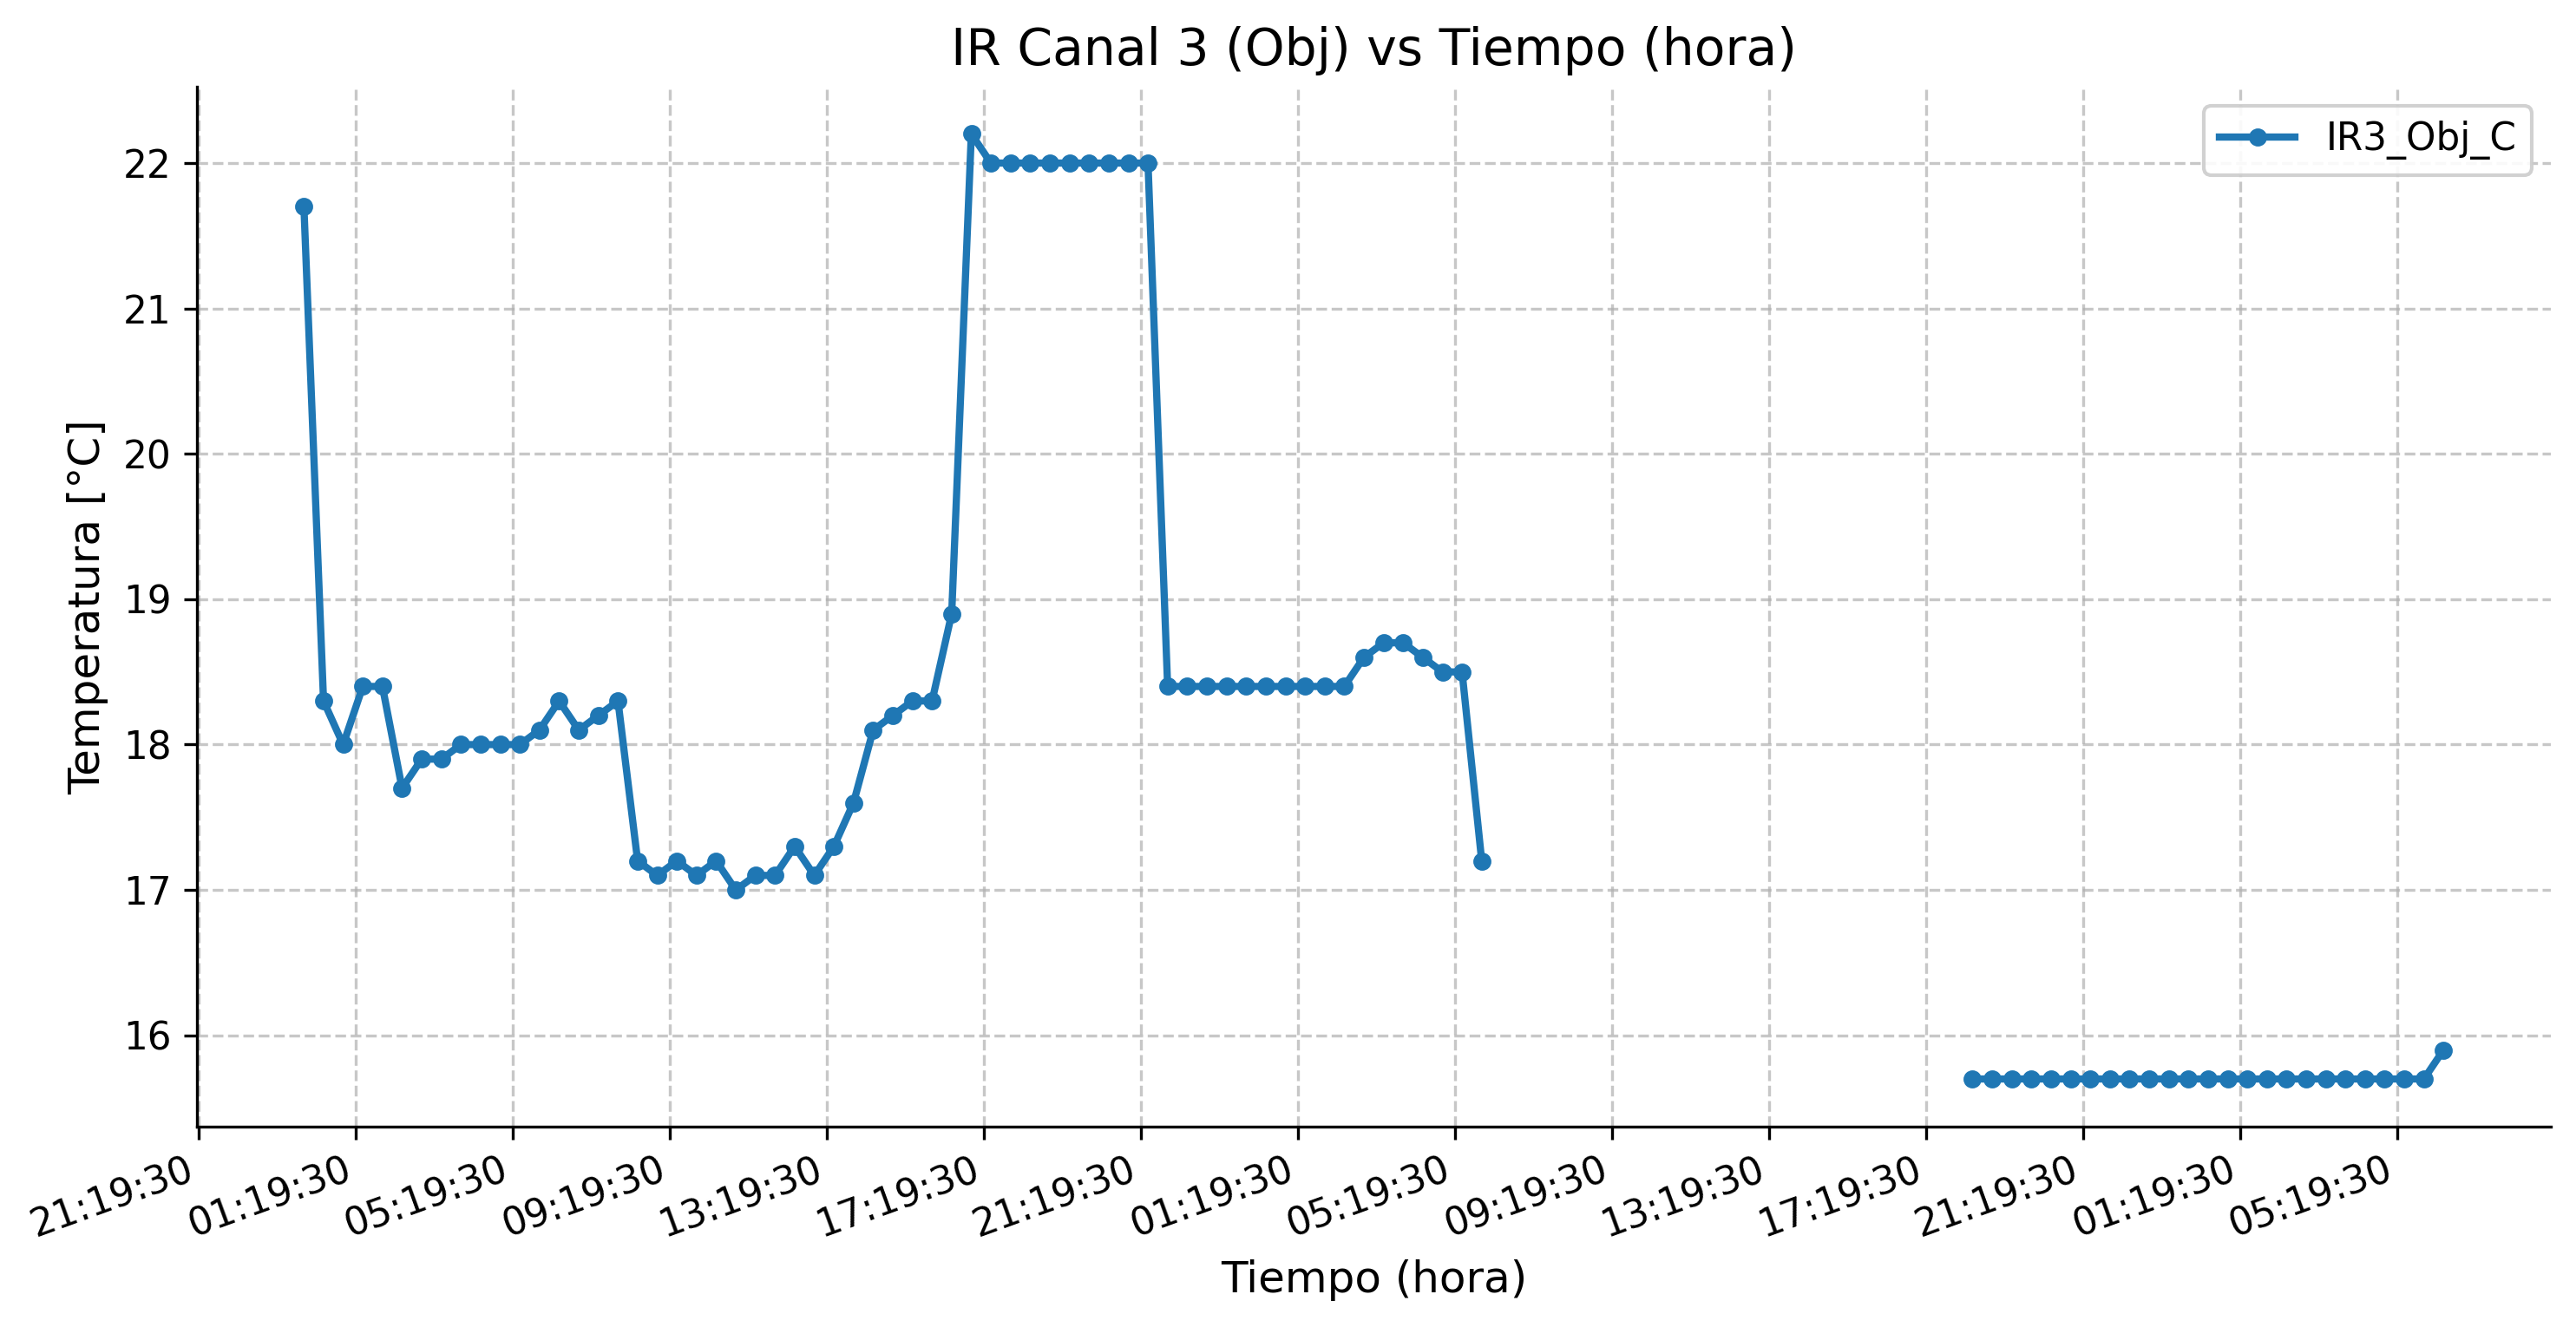

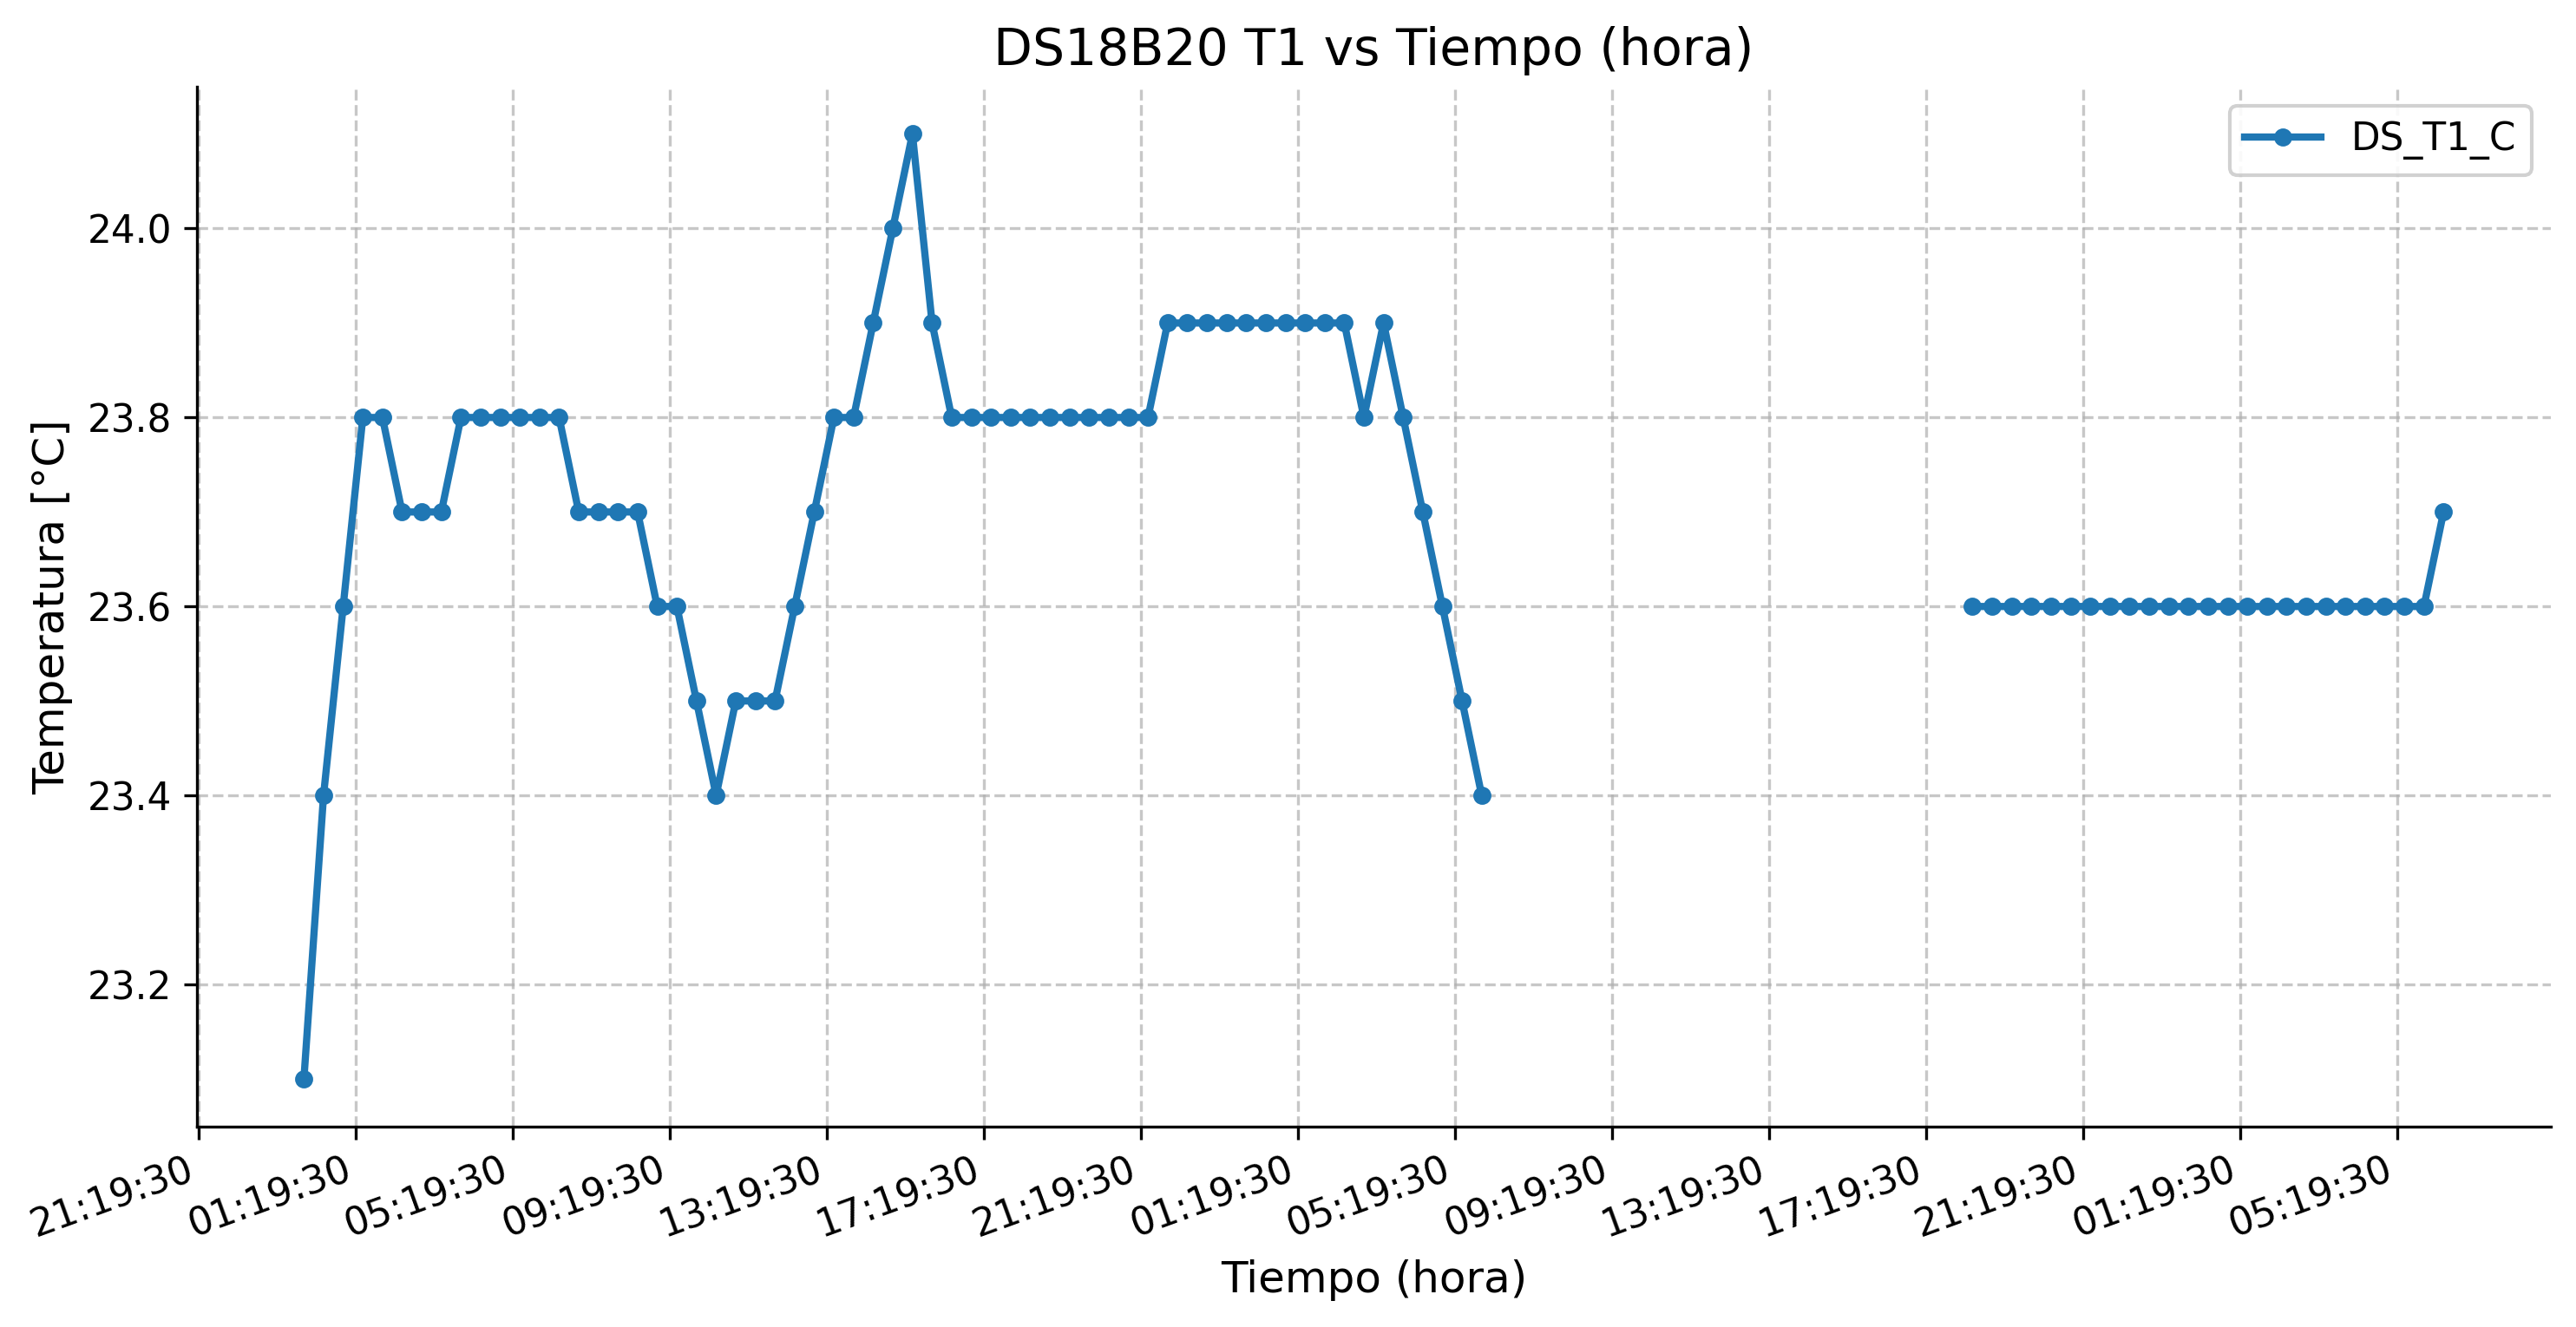

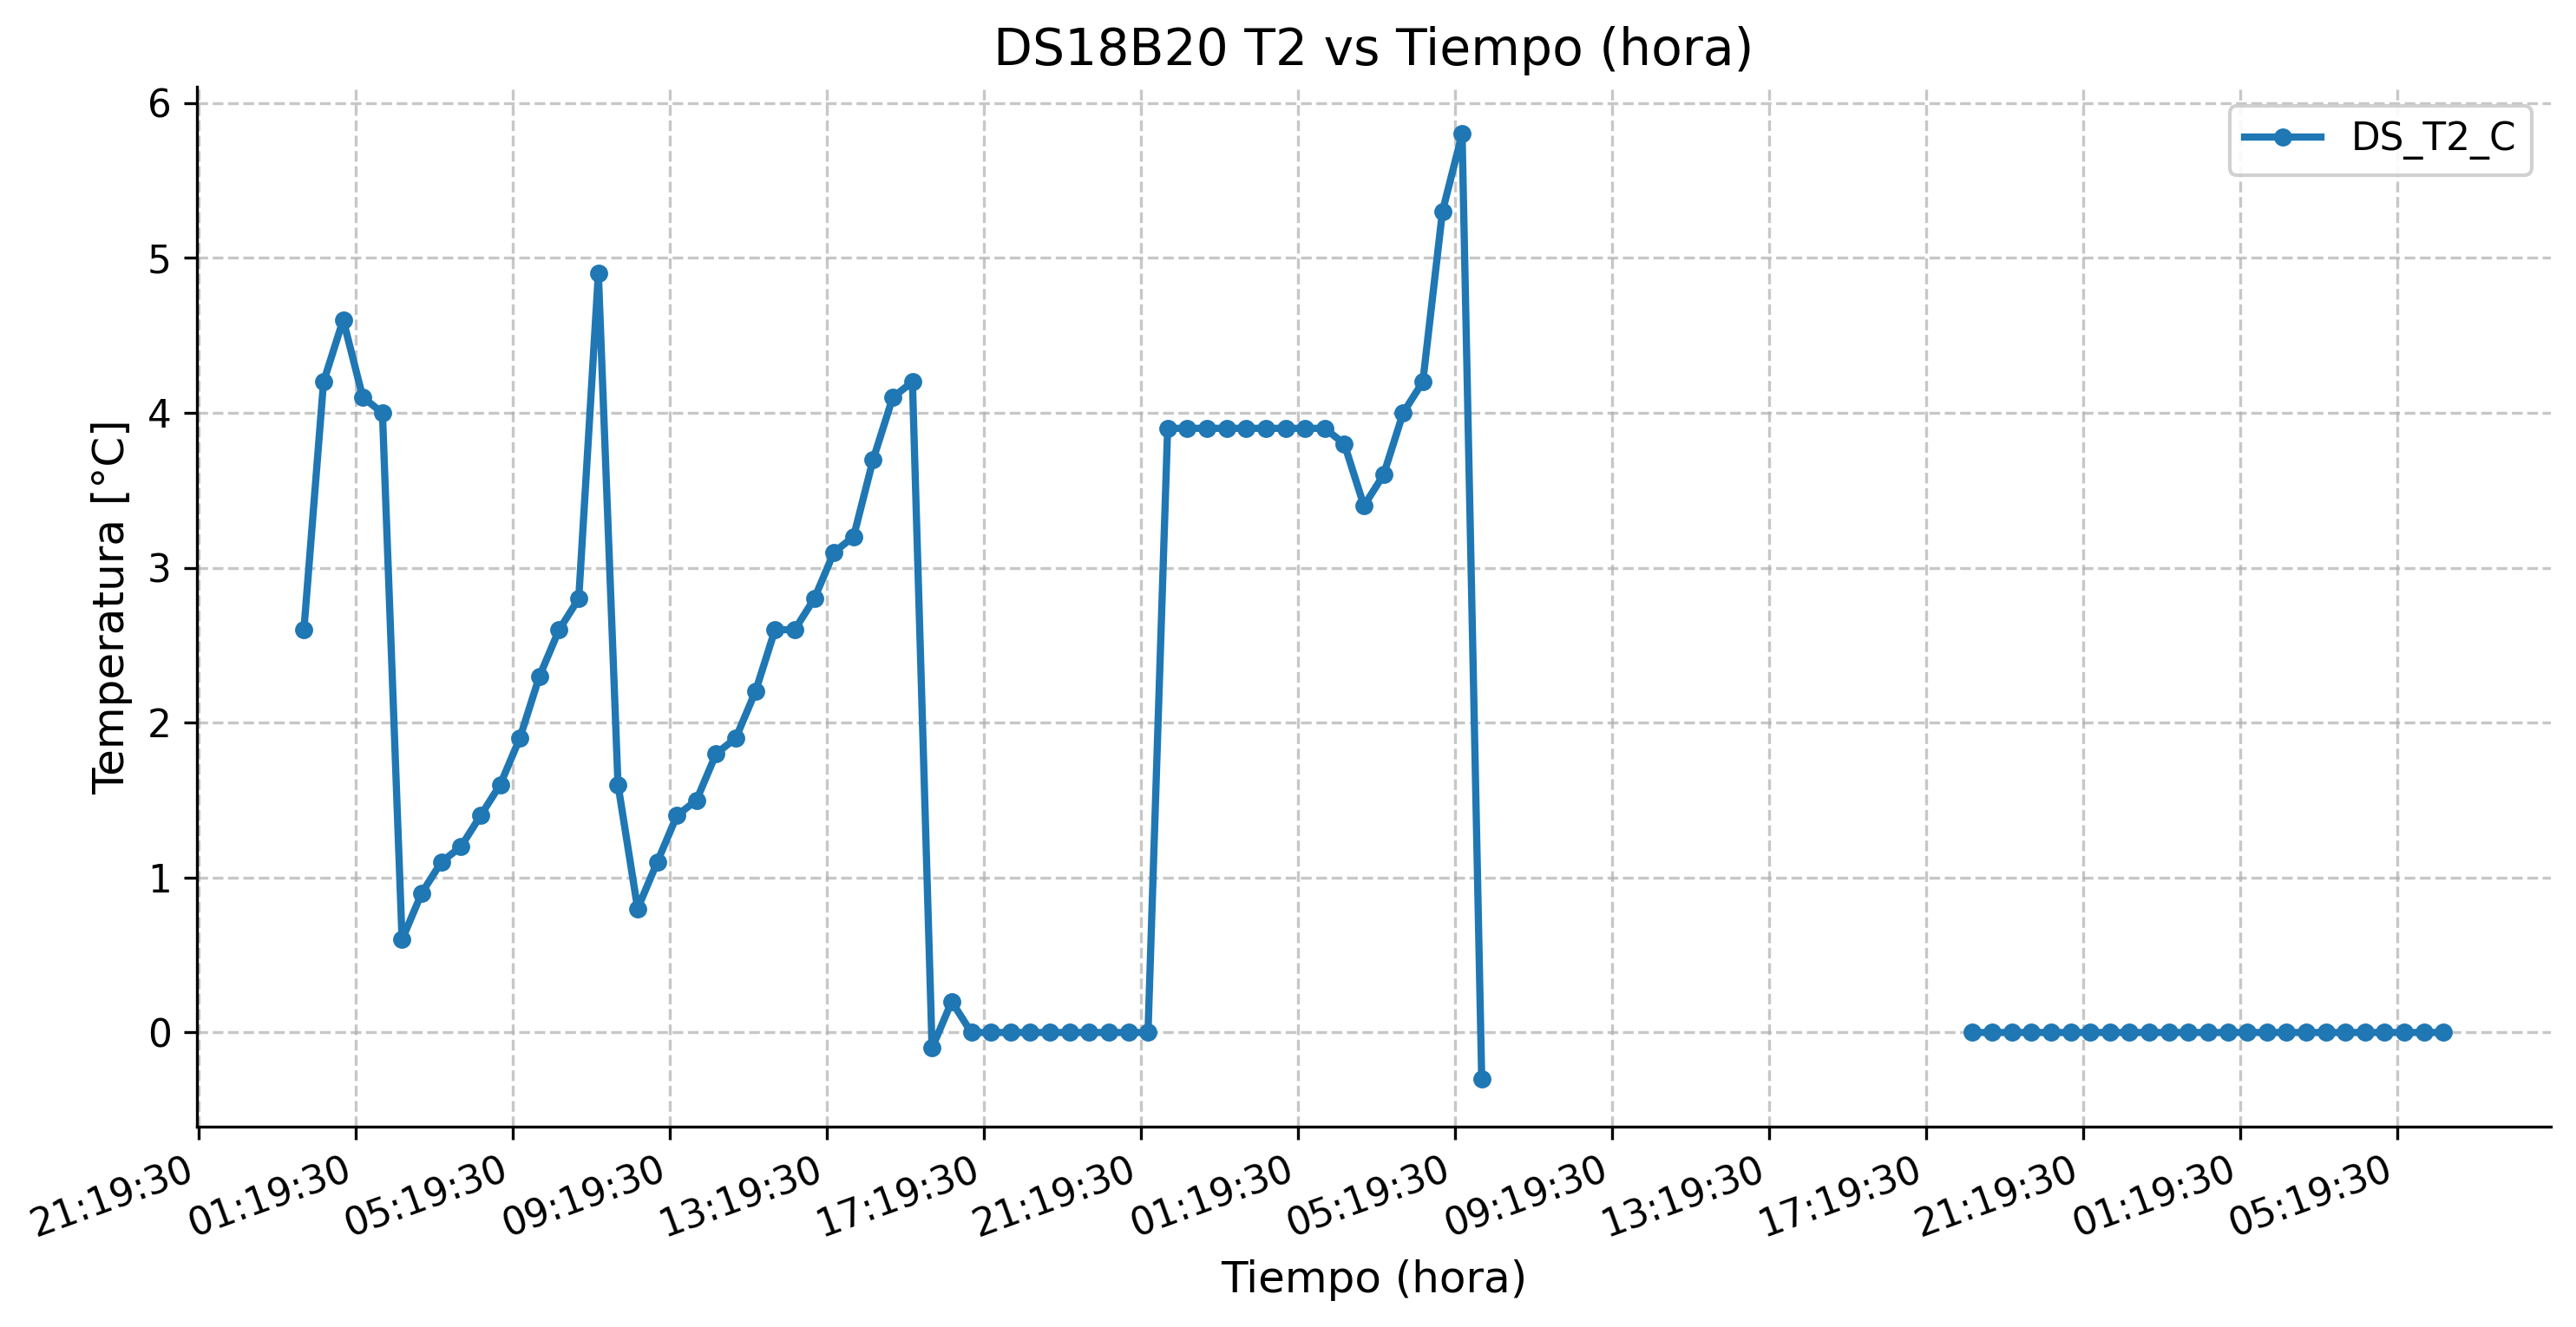

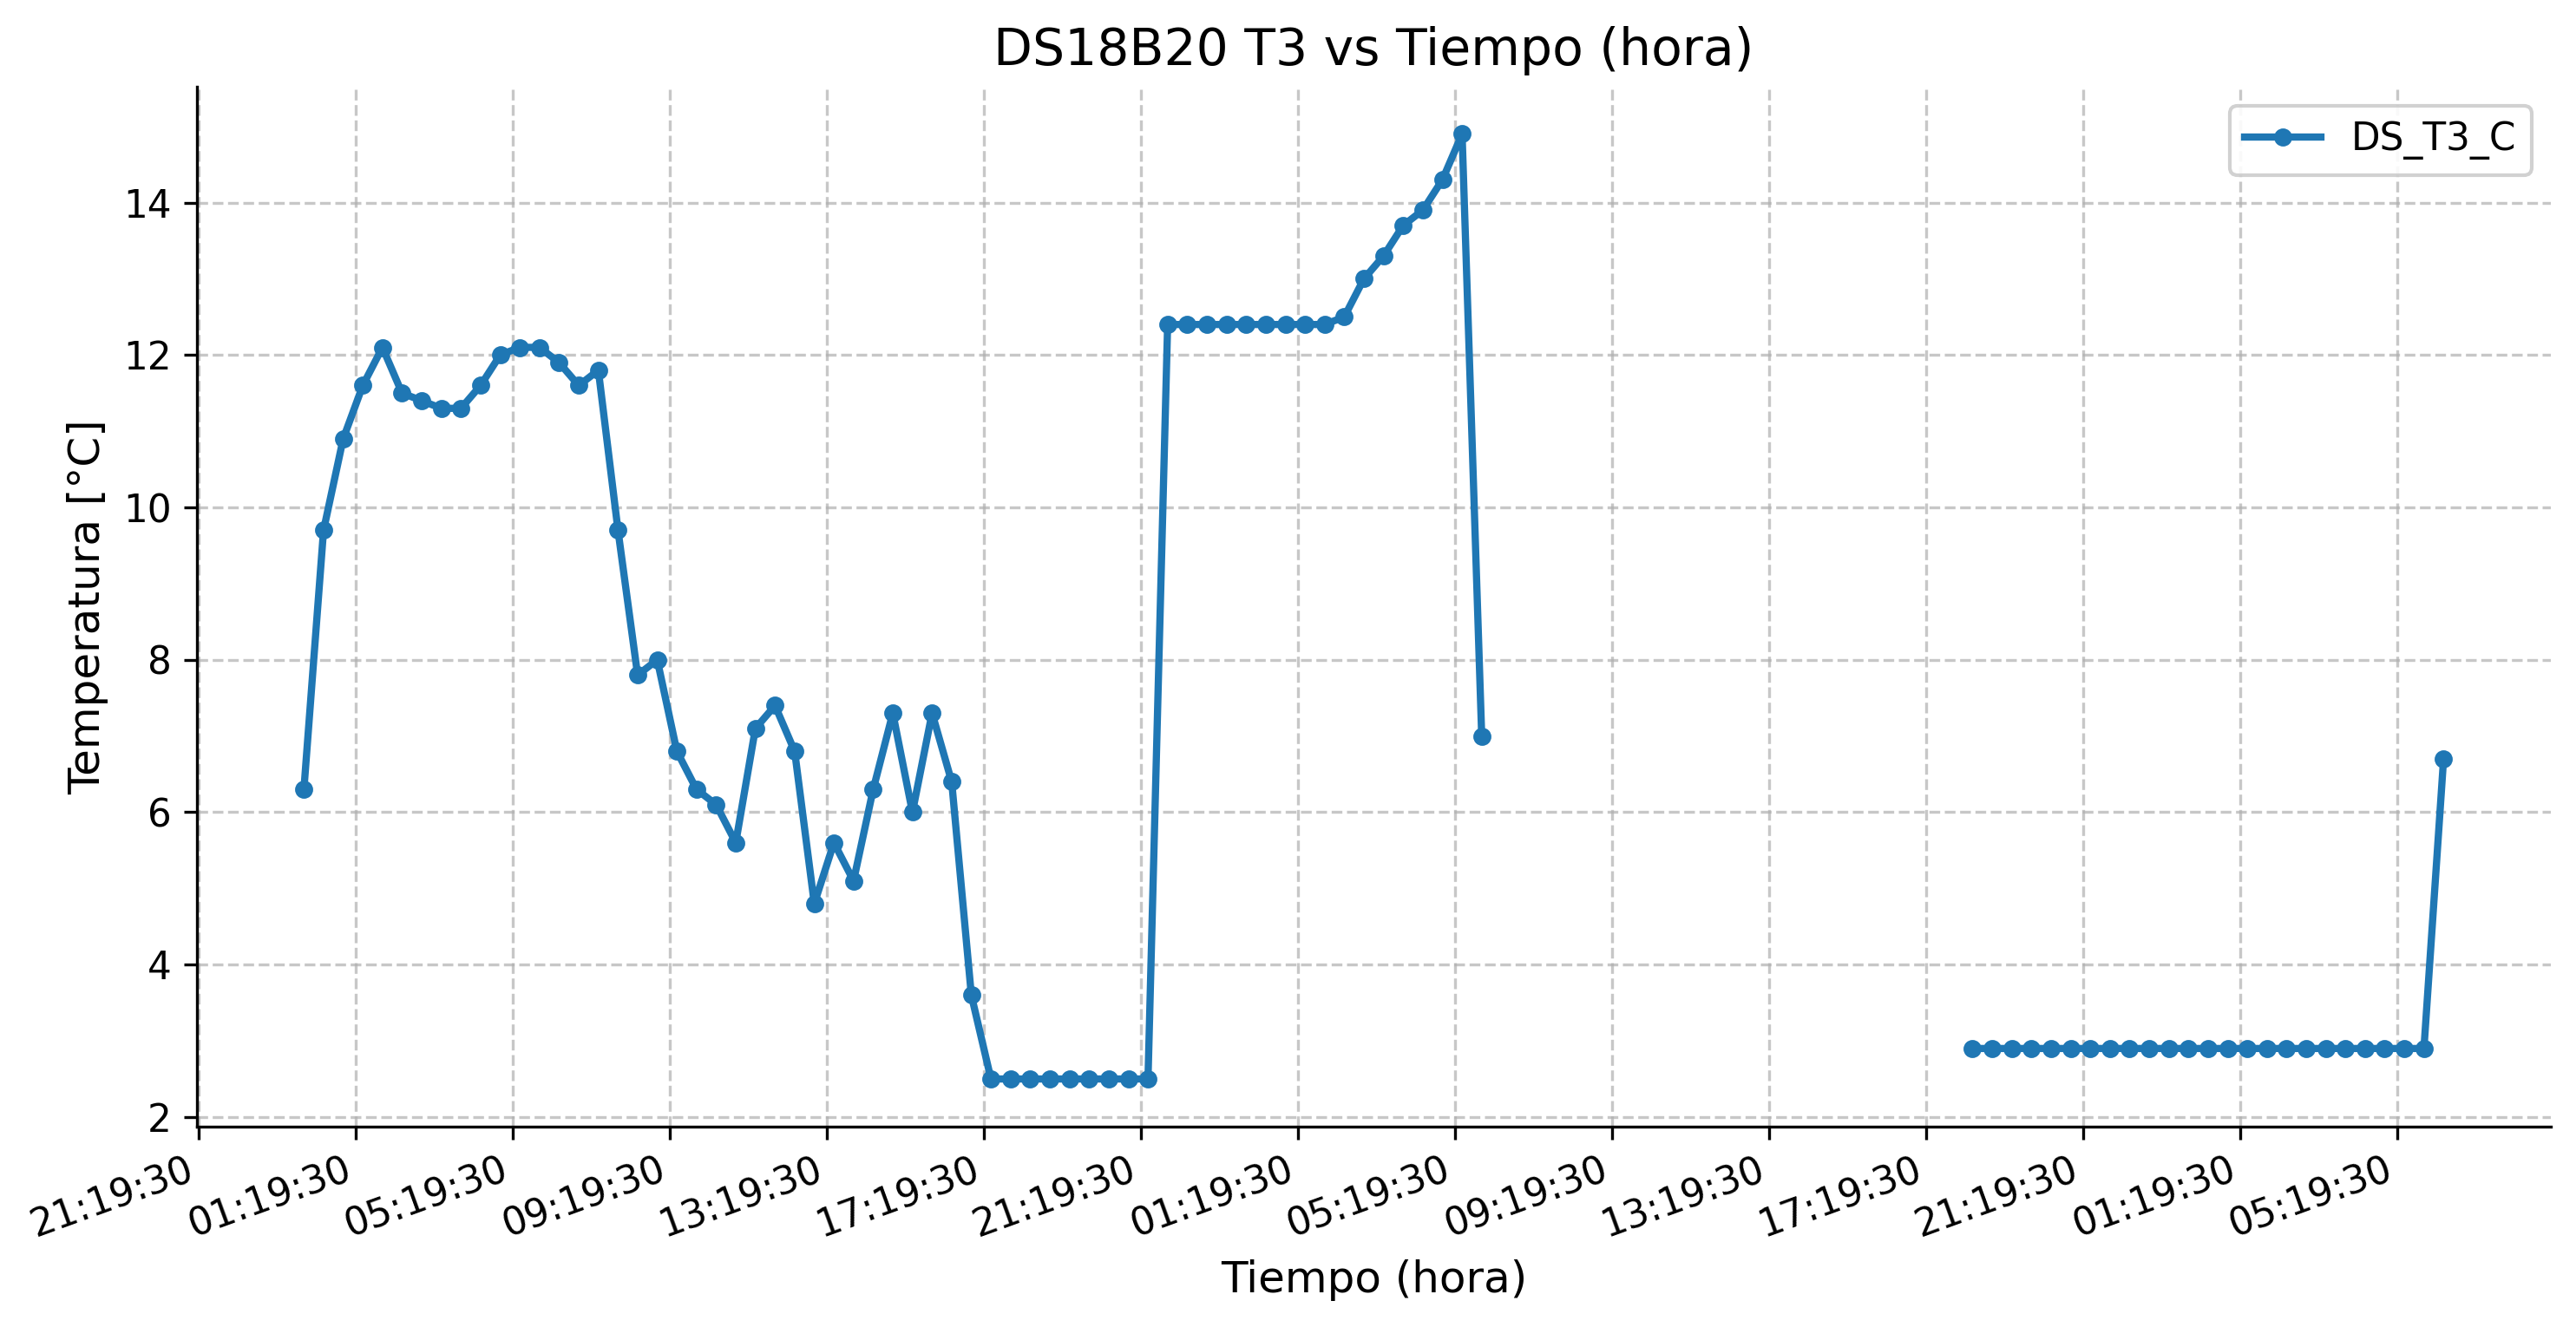

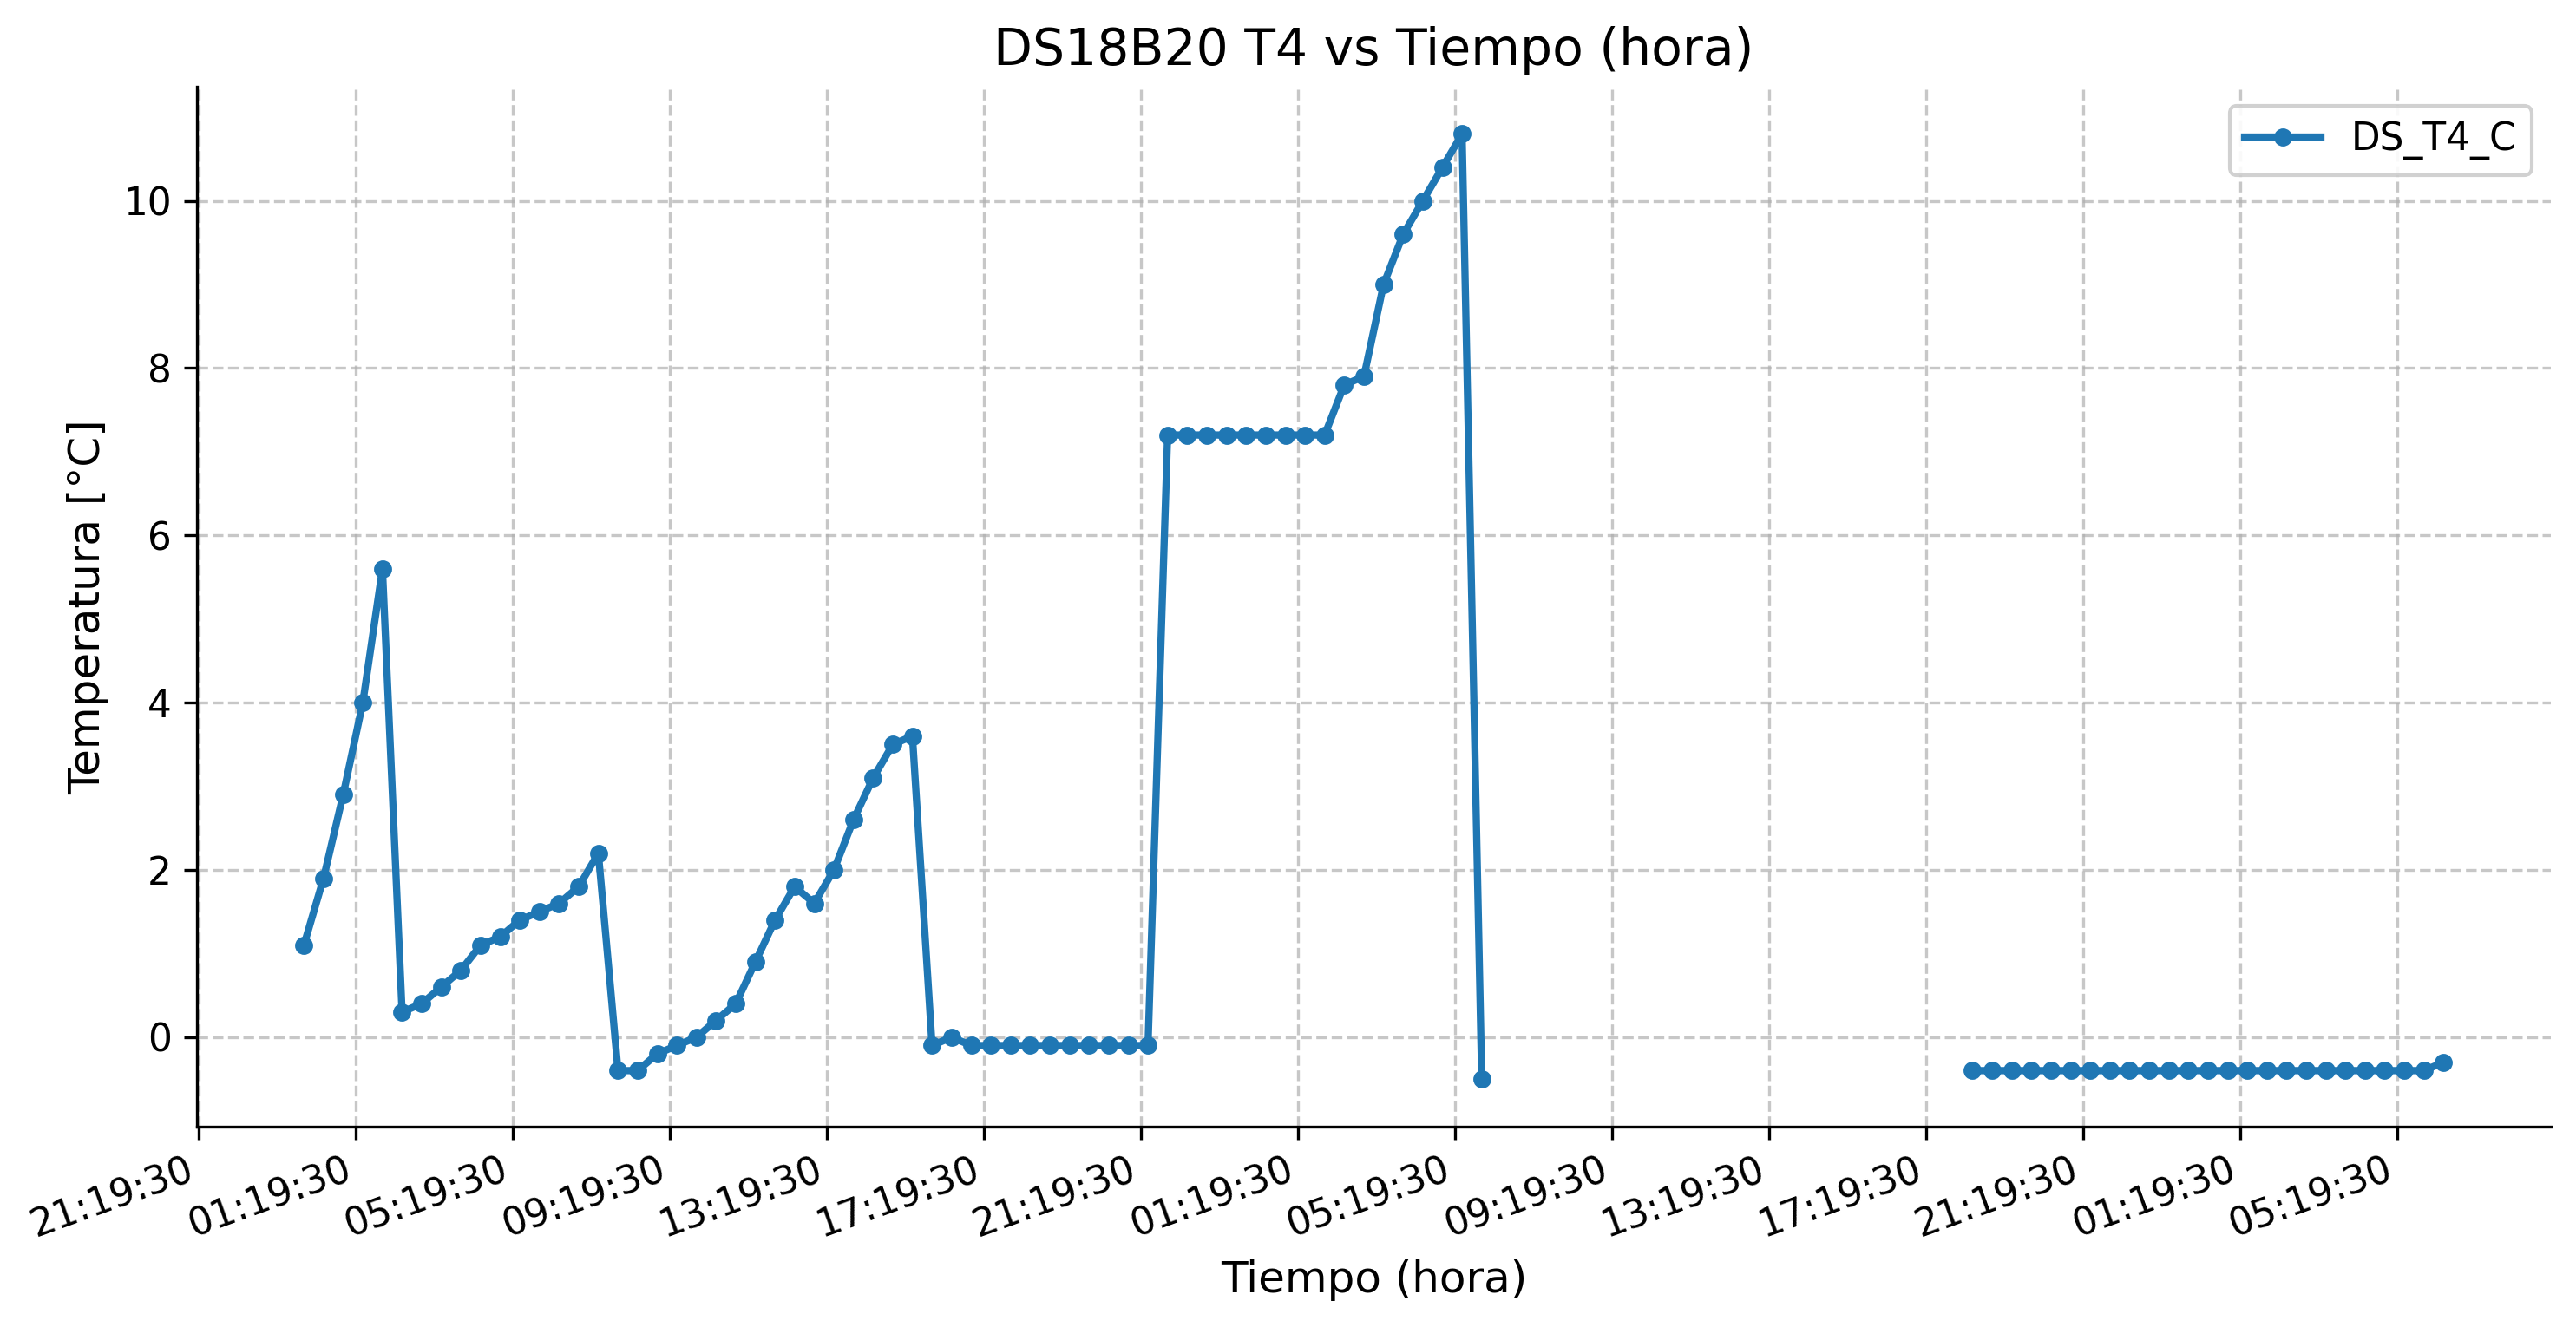

Listo. Figuras generadas (con muestreo: nearest 30min )


In [12]:
# -*- coding: utf-8 -*-                      # Codificación del archivo (útil en entornos antiguos/editores).
"""
Graficación profesional + muestreo por intervalos:
- Presiones, IR y DS18B20 (conjuntas e individuales)
- Opción de muestreo temporal en un solo gráfico (nearest/mean/median)
- Eje X por 'time' continuo o por 'elapsed_s'
- Filtro de rango [start, end]
"""
# ↑ Docstring descriptivo: explica el propósito del script y sus funciones principales.

import pandas as pd                             # Pandas: manejo de CSVs y series temporales (resample, to_datetime, etc.).
import numpy as np                              # NumPy: utilidades numéricas (isfinite, etc.).
import matplotlib.pyplot as plt                 # Matplotlib: ploteo de figuras.
import matplotlib.dates as mdates               # Herramientas de fecha/hora para ejes de Matplotlib.
from typing import Optional, Tuple              # Tipado opcional (para ayudar a entender qué devuelve cada función).

# ================== Configura aquí ==================
CSV_PATH      = "salida_unida.csv"   # archivo combinado   # Ruta del CSV de entrada (ajústala a tu archivo).
OUT_PREFIX    = "fig_"               # prefijo archivos de salida  # Prefijo de nombres para los PNG/PDF que se guardan.
SAVE_PNGS     = True                 # guardar PNG         # True: guarda .png; False: no guarda .png.
SAVE_PDFS     = False                 # guardar PDF         # True: guarda .pdf; False: no guarda .pdf.
SHOW_PLOTS    = True                 # mostrar ventanas interactivas  # True: abre ventana(s) con las gráficas; False: no.
DPI           = 300                  # resolución de guardado         # Resolución al guardar figuras (300 recomendado).
FIGSIZE       = (10, 5.2)            # tamaño de figura               # Tamaño por defecto de cada figura (pulgadas).
LINEWIDTH     = 2.0                  # grosor de línea                # Grosor de las curvas (líneas).
MARKERSIZE    = 0                    # 0 = sin marcadores             # Tamaño de marcadores; 0 implica no dibujar marker.
GRID_ALPHA    = 0.35                 # opacidad grilla                # Transparencia de la grilla.

# Eje temporal:
USE_ELAPSED   = True                # True -> usa 'elapsed_s'; False -> usa 'time' continuo
# ↑ Si True, el eje X se construye a partir de la columna 'elapsed_s' (segundos desde el inicio).
#   Si False, se usa la columna 'time' y se “cosen” medianoches para continuidad.

ELAPSED_ZERO_DATE = pd.Timestamp('2000-01-01')
# ↑ Fecha ficticia base para mapear 'elapsed_s' a datetimes (ej. 00:00:00 del 2000-01-01).

# Filtros de tiempo (opcional) en formato 'HH:MM:SS' o None:
RANGE_START: Optional[str] = None    # ej. "00:00:00"   # Hora mínima a mostrar (respecto al primer día del eje).
RANGE_END:   Optional[str] = None    # ej. "01:00:00"   # Hora máxima a mostrar (respecto al primer día del eje).
# ↑ Deja ambos en None para no recortar; solo aplica cuando el eje es datetime (no numérico).

# === Muestreo temporal en UN SOLO gráfico ===
# Opciones: "none", "nearest", "mean", "median"
SAMPLE_MODE = "nearest"              # p.ej. "nearest"  # Modo de muestreo: none (sin tocar), nearest, mean, o median.
SAMPLE_FREQ = "30min"                # p.ej. "5min", "15min", "30min", "1h"  # Tamaño del intervalo de muestreo.
# ====================================================

# ---- Estilo global (profesional, limpio) ----
plt.rcParams.update({
    "figure.figsize": FIGSIZE,       # Aplica tamaño por defecto a todas las figuras.
    "figure.dpi": 300,               # DPI por defecto en pantalla (independiente del savefig dpi).
    "savefig.bbox": "tight",         # Recorta bordes en guardado para evitar espacios en blanco excesivos.
    "axes.grid": True,               # Activa la grilla en los ejes.
    "grid.linestyle": "--",          # Estilo de la grilla (línea punteada).
    "grid.alpha": GRID_ALPHA,        # Opacidad de la grilla.
    "axes.titlesize": 14,            # Tamaño de fuente para títulos de ejes.
    "axes.labelsize": 12,            # Tamaño de fuente para etiquetas de ejes.
    "xtick.labelsize": 10.5,         # Tamaño de etiquetas en X.
    "ytick.labelsize": 10.5,         # Tamaño de etiquetas en Y.
    "legend.fontsize": 10.5,         # Tamaño de fuente en la leyenda.
    "lines.linewidth": LINEWIDTH,    # Grosor de línea por defecto.
    "lines.markersize": MARKERSIZE,  # Tamaño de marcadores por defecto.
})

def construir_tiempo_continuo(time_series: pd.Series) -> pd.Series:
    # ↑ Convierte texto de hora a datetime continuo, “cosiendo” medianoches (rollover).
    t_str = time_series.astype(str).str.strip()                       # Normaliza a cadena y quita espacios.
    t_norm = t_str.str.replace(",", ".", regex=False)                 # Cambia coma decimal por punto (si apareciera).
    tiene_fecha = t_norm.str.contains("T")                            # Heurística: ¿viene con fecha ISO (contiene 'T')?
    dt = pd.Series(pd.NaT, index=t_norm.index, dtype="datetime64[ns]")# Serie vacía (datetimes) para llenar.

    if tiene_fecha.any():                                             # Si algunas filas traen fecha completa...
        dt.loc[tiene_fecha] = pd.to_datetime(t_norm[tiene_fecha],     # ...parsea directo con pandas (tolerante).
                                             errors="coerce")

    if (~tiene_fecha).any():                                          # Si otras filas son “solo hora”...
        t_hora = "2000-01-01 " + t_norm[~tiene_fecha]                 # ...antepone fecha ficticia para parsear.
        dt_hora = pd.to_datetime(t_hora,                              # Intenta con milisegundos/microsegundos (%f).
                                 format="%Y-%m-%d %H:%M:%S.%f",
                                 errors="coerce")
        mask_na = dt_hora.isna()                                      # Algunas podrían no tener fracción -> NaT.
        if mask_na.any():                                             # Fallback: parsear sin %f.
            dt_hora2 = pd.to_datetime(
                ("2000-01-01 " + t_norm[~tiene_fecha][mask_na]),
                format="%Y-%m-%d %H:%M:%S",
                errors="coerce",
            )
            dt_hora[mask_na] = dt_hora2                               # Rellena las que fallaron con el parseo sin fracción.
        dt.loc[~tiene_fecha] = dt_hora                                # Escribe esos datetimes finales.

    if dt.isna().any():                                               # Validación: si quedan NaT, reporta ejemplos.
        ejemplos = t_str[dt.isna()].unique()[:5]
        raise ValueError("No se pudieron parsear algunas marcas de tiempo: " + ", ".join(map(str, ejemplos)))

    neg = dt.diff() < pd.Timedelta(0)                                 # Detecta “retrocesos” (cambio de día).
    roll = neg.cumsum()                                               # Acumula cuántas veces se retrocedió (D+N).
    return dt + pd.to_timedelta(roll, unit="D")                       # Suma N días para “coser” y hacer el eje continuo.

def construir_x(df: pd.DataFrame) -> pd.Series:
    # ↑ Construye el eje X según configuración USE_ELAPSED.
    if USE_ELAPSED:
        if "elapsed_s" not in df.columns:                             # Exige la columna 'elapsed_s' si está activado.
            raise KeyError("Se configuró USE_ELAPSED=True pero falta 'elapsed_s'.")
        return pd.to_timedelta(pd.to_numeric(df["elapsed_s"], errors="coerce"), unit='s') + ELAPSED_ZERO_DATE
        # ↑ Convierte 'elapsed_s' a Timedelta y lo “pega” a una fecha cero (para que Matplotlib lo trate como datetime).
    else:
        if "time" not in df.columns:                                  # Exige la columna 'time' si no usamos elapsed.
            raise KeyError("Se configuró USE_ELAPSED=False pero falta 'time'.")
        return construir_tiempo_continuo(df["time"])                  # Usa el parser continuo de arriba.

def parse_hhmmss_to_datetime(base_date: pd.Timestamp, hhmmss: str) -> pd.Timestamp:
    return base_date + pd.to_timedelta(hhmmss)                        # Convierte 'HH:MM:SS' relativo a un día base.

def filtrar_rango(x_dt: pd.Series, df: pd.DataFrame,
                  start_hhmmss: Optional[str], end_hhmmss: Optional[str]) -> Tuple[pd.Series, pd.DataFrame]:
    # ↑ Recorta el DataFrame y el eje X a un rango horario [start, end] relativo al “primer día” del eje.
    if start_hhmmss is None and end_hhmmss is None:
        return x_dt, df                                                # Sin filtro: devuelve tal cual.
    base_date = x_dt.iloc[0].normalize()                               # Día base (00:00:00 del día inicial).
    mask = pd.Series(True, index=df.index)                             # Máscara booleana para filtrar filas.
    if start_hhmmss is not None:
        t0 = parse_hhmmss_to_datetime(base_date, start_hhmmss)         # Límite inferior (datetime).
        mask &= (x_dt >= t0)
    if end_hhmmss is not None:
        t1 = parse_hhmmss_to_datetime(base_date, end_hhmmss)           # Límite superior (datetime).
        mask &= (x_dt <= t1)
    return x_dt[mask], df.loc[mask].reset_index(drop=True)             # Devuelve eje/df filtrados y reindexados.

def aplicar_muestreo(x_dt: pd.Series, df: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Devuelve (x_dt_sampled, df_sampled) según SAMPLE_MODE/FREQ:
    - "nearest": toma el dato más cercano a cada marca del resample
    - "mean": promedio por intervalo
    - "median": mediana por intervalo
    - "none": no aplica muestreo
    """
    if SAMPLE_MODE == "none" or SAMPLE_FREQ is None:
        return x_dt, df                                                # Sin muestreo: retorna originales.

    tmp = df.copy().assign(_x=x_dt.values)                             # Copia el df y añade columna con el eje datetime.

    # Add a small, unique time delta to each row to ensure uniqueness for resampling
    tmp['_x_unique'] = tmp['_x'] + pd.to_timedelta(tmp.index, unit='ns')
    # ↑ Crea un índice datetime único (añade nanosegundos según índice) para evitar colisiones en resample.
    tmp = tmp.set_index("_x_unique").sort_index()                      # Establece ese índice y ordena por tiempo.

    if SAMPLE_MODE == "nearest":
        df_s = tmp.resample(SAMPLE_FREQ).nearest()                     # Toma las filas más cercanas a cada marca.
    elif SAMPLE_MODE == "mean":
        df_s = tmp.resample(SAMPLE_FREQ).mean(numeric_only=True)       # Agrega por promedio
    elif SAMPLE_MODE == "median":
        df_s = tmp.resample(SAMPLE_FREQ).median(numeric_only=True)     # Agrega por mediana
    else:
        raise ValueError("SAMPLE_MODE debe ser 'none', 'nearest', 'mean' o 'median'.")

    # Conserva columnas no numéricas vía forward-fill si te interesa (opcional)
    # cols_nonnum = [c for c in tmp.columns if not pd.api.types.is_numeric_dtype(tmp[c])]
    # if cols_nonnum:
    #     df_s[cols_nonnum] = tmp[cols_nonnum].resample(SAMPLE_FREQ).ffill()
    # ↑ Si hay columnas categóricas/strings que quieras arrastrar, descomenta y ajusta.

    x_s = df_s.index.to_series().reset_index(drop=True)                # Eje X muestreado (como Series).
    df_s = df_s.reset_index(drop=True)                                 # DataFrame muestreado con índice limpio.
    return x_s, df_s

def _save_and_show(fig, fname_base: str):
    # ↑ Guarda y/o muestra la figura según flags globales.
    if SAVE_PNGS:
        fig.savefig(f"{OUT_PREFIX}{fname_base}.png", dpi=DPI)          # Guarda como PNG con DPI definido.
    if SAVE_PDFS:
        fig.savefig(f"{OUT_PREFIX}{fname_base}.pdf")                   # Guarda como PDF (vectorial).
    if SHOW_PLOTS:
        plt.show()                                                     # Abre ventana interactiva (bloquea hasta cerrar).
    else:
        plt.close(fig)                                                 # Cierra para liberar memoria si no se muestra.

def plot_lineas(x_dt, y_cols, df, titulo, ylabel, fname_base):
    # ↑ Dibuja en una misma figura varias columnas (series) contra el eje x_dt.
    fig, ax = plt.subplots()                                           # Crea figura y ejes.
    plotted = 0                                                        # Contador de series dibujadas.
    for col in y_cols:
        if col in df.columns:                                          # Sólo grafica si la columna existe.
            y = pd.to_numeric(df[col], errors="coerce")                # Convierte a numérico (NaN donde no se pueda).
            if np.isfinite(y).sum() == 0:                              # Si todo es NaN, salta esa serie.
                continue
            ax.plot(x_dt, y, label=col)                                # Traza la serie (línea por defecto).
            plotted += 1

    if plotted == 0:                                                   # Si no se graficó nada, cierra y avisa.
        plt.close(fig)
        print(f"[AVISO] Sin datos en {y_cols}")
        return

    ax.set_title(titulo)                                               # Título del gráfico.
    ax.set_ylabel(ylabel)                                              # Etiqueta eje Y.
    ax.set_xlabel("Tiempo (hora)")                                     # Etiqueta eje X.
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())               # Ticks automáticos adecuados al rango.
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))     # Formato HH:MM:SS para etiquetas en X.
    fig.autofmt_xdate(rotation=20, ha="right")                         # Inclina etiquetas de X para legibilidad.

    leg = ax.legend(ncol=2, frameon=True, fancybox=True, framealpha=0.9) # Leyenda con estilo.
    for lh in leg.legend_handles:
        lh.set_linewidth(LINEWIDTH)                                     # Asegura grosor de líneas en leyenda.
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)                             # Limpia bordes sup/der (estética).

    plt.tight_layout()                                                  # Ajusta layout para evitar cortes.
    _save_and_show(fig, fname_base)                                     # Guarda y/o muestra.

def plot_individual(x_dt, col, df, titulo, ylabel, fname_base):
    # ↑ Versión de una sola serie (útil para P1, P2, IR2, IR3, DS_T1..T4).
    if col not in df.columns:
        print(f"[AVISO] Columna '{col}' no encontrada.")
        return
    y = pd.to_numeric(df[col], errors="coerce")
    if not np.isfinite(y).any():
        print(f"[AVISO] '{col}' no tiene datos numéricos válidos.")
        return

    fig, ax = plt.subplots()
    ax.plot(x_dt, y, '-o', label=col, markersize=4)                    # Línea + puntos (marcadores tamaño 4).
    ax.set_title(titulo)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Tiempo (hora)")
    ax.grid(True, which='both', linestyle='--', alpha=0.7)             # Grilla sutil.

# Controla los ticks principales (ej. cada 10 s) y secundarios (ej. cada 1 s)
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=14400))     # Ticks mayores cada 3600 s (1 hora).
#   ax.xaxis.set_minor_locator(mdates.SecondLocator(interval=3600))      # (Comentado) Ticks menores cada 600 s (10 min).
#   ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))      # (Comentado) Formato explícito HH:MM:SS.

# Formato de fechas inclinado
 #   fig.autofmt_xdate()                                                # (Comentado) Alternativa sin rotación/ha.
    #ax.xaxis.set_major_locator(mdates.AutoDateLocator())               # (Comentado) Locator automático (en lugar del fijo).
    #ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))     # (Comentado) Formato HH:MM:SS con locator auto.
    fig.autofmt_xdate(rotation=20, ha="right")                          # Aplica formato inclinado a etiquetas X.
    ax.legend(frameon=True, fancybox=True, framealpha=0.9)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()
    _save_and_show(fig, fname_base)

def generar_todas_las_graficas(x_dt, df, sufijo=""):
    # ↑ Orquestador: genera todas las figuras (combinadas + individuales).
    sfx = ("" if not sufijo else f"__{sufijo}")                         # Sufijo para nombre de archivos si quisieras versionar.

    # Combinadas
    plot_lineas(x_dt, ["P1_mmHg", "P2_mmHg"], df,                       # P1 y P2 en la misma figura.
                "Presiones vs Tiempo (hora)", "Presión [mmHg]",
                f"presiones_vs_tiempo{sfx}")
    plot_lineas(x_dt, ["IR2_Obj_C", "IR3_Obj_C"], df,                   # IR2 e IR3 en la misma figura.
                "Temperaturas IR (Objetivo) vs Tiempo (hora)", "Temperatura [°C]",
                f"ir_obj_vs_tiempo{sfx}")
    plot_lineas(x_dt, ["DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"], df,# DS18B20 T1–T4 en la misma figura.
                "DS18B20 (T1–T4) vs Tiempo (hora)", "Temperatura [°C]",
                f"ds18b20_vs_tiempo{sfx}")

    # Individuales
    plot_individual(x_dt, "P1_mmHg", df, "Presión P1 vs Tiempo (hora)", "Presión [mmHg]", f"P1_vs_tiempo{sfx}")
    plot_individual(x_dt, "P2_mmHg", df, "Presión P2 vs Tiempo (hora)", "Presión [mmHg]", f"P2_vs_tiempo{sfx}")
    plot_individual(x_dt, "IR2_Obj_C", df, "IR Canal 2 (Obj) vs Tiempo (hora)", "Temperatura [°C]", f"IR2_obj_vs_tiempo{sfx}")
    plot_individual(x_dt, "IR3_Obj_C", df, "IR Canal 3 (Obj) vs Tiempo (hora)", "Temperatura [°C]", f"IR3_obj_vs_tiempo{sfx}")
    for col, etiqueta in [("DS_T1_C", "DS18B20 T1"), ("DS_T2_C", "DS18B20 T2"),
                          ("DS_T3_C", "DS18B20 T3"), ("DS_T4_C", "DS18B20 T4")]:
        plot_individual(x_dt, col, df, f"{etiqueta} vs Tiempo (hora)", "Temperatura [°C]", f"{col}_vs_tiempo{sfx}")

def main():
    # Carga
    df = pd.read_csv(CSV_PATH)                                          # Lee el CSV a DataFrame.

    # Eje X base
    x_dt = construir_x(df)                                              # Construye el eje datetime (elapsed o time continuo).

    # Filtro de rango (antes del muestreo)
    x_use, df_use = filtrar_rango(x_dt, df, RANGE_START, RANGE_END)    # Aplica recorte por hora (si definiste rangos).

    # Muestreo temporal (aquí sucede la “magia” de tomar cada 30 min, p.ej.)
    x_s, df_s = aplicar_muestreo(x_use, df_use)                         # Aplica SAMPLE_MODE y SAMPLE_FREQ.

    # Graficar todo con el muestreo aplicado
    generar_todas_las_graficas(x_s, df_s)                               # Dibuja y guarda/muestra todas las figuras.

    print("Listo. Figuras generadas (con muestreo:", SAMPLE_MODE, SAMPLE_FREQ, ")")
    # ↑ Mensaje final indicando qué muestreo se aplicó.

if __name__ == "__main__":
    main()                                                              # Punto de entrada: ejecuta main() al correr el script.


    #######################33
    ########Eje por elapsed_s (cero relativo):
    #Cambia USE_ELAPSED = True.                                        # Consejo: activa elapsed para eje relativo a 00:00:00.
    #El eje seguirá formateado en HH:MM:SS partiendo de 00:00:00.      # Se mantiene el formato HH:MM:SS por ser datetime.
    #Filtrar un rango manual (antes de cortar):
    #RANGE_START = "00:00:00"                                          # Ejemplo de filtro inferior.
    #RANGE_END   = "01:00:00"                                          # Ejemplo de filtro superior (1 hora).
    #Cortes automáticos (chunks):
    #CHUNK_FREQ = "15min"   # también "5min", "30min", "1h"            # (Nota informativa; en este script no se usa CHUNK_FREQ).


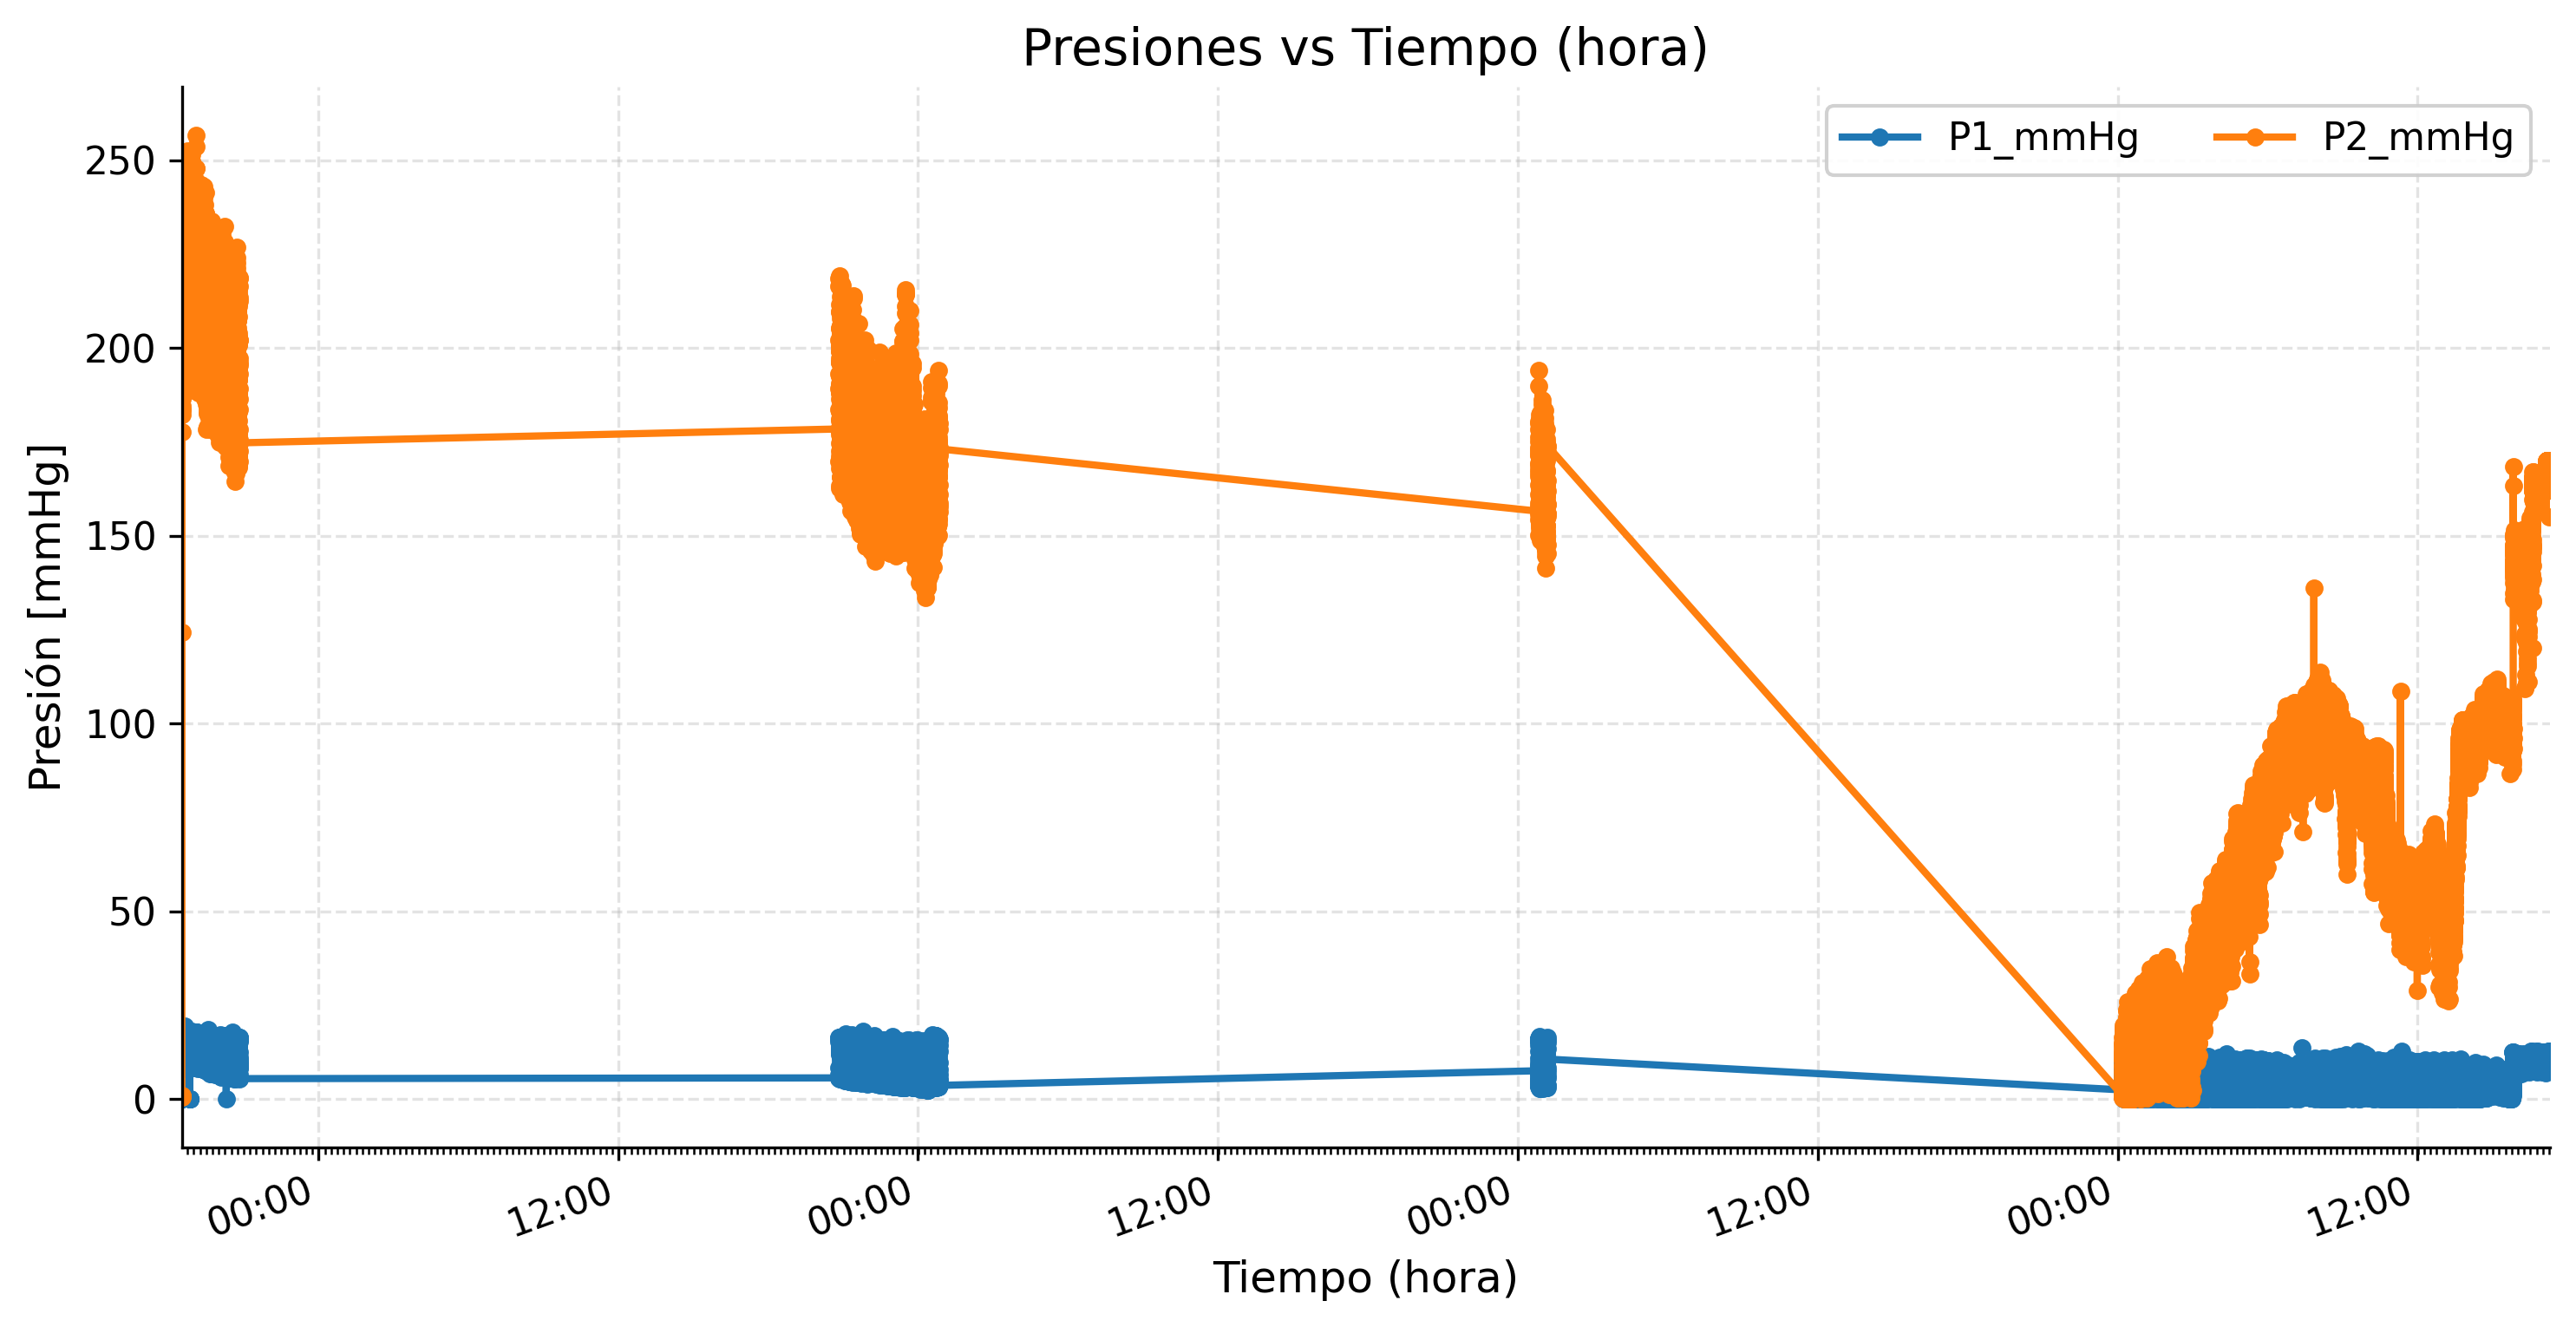

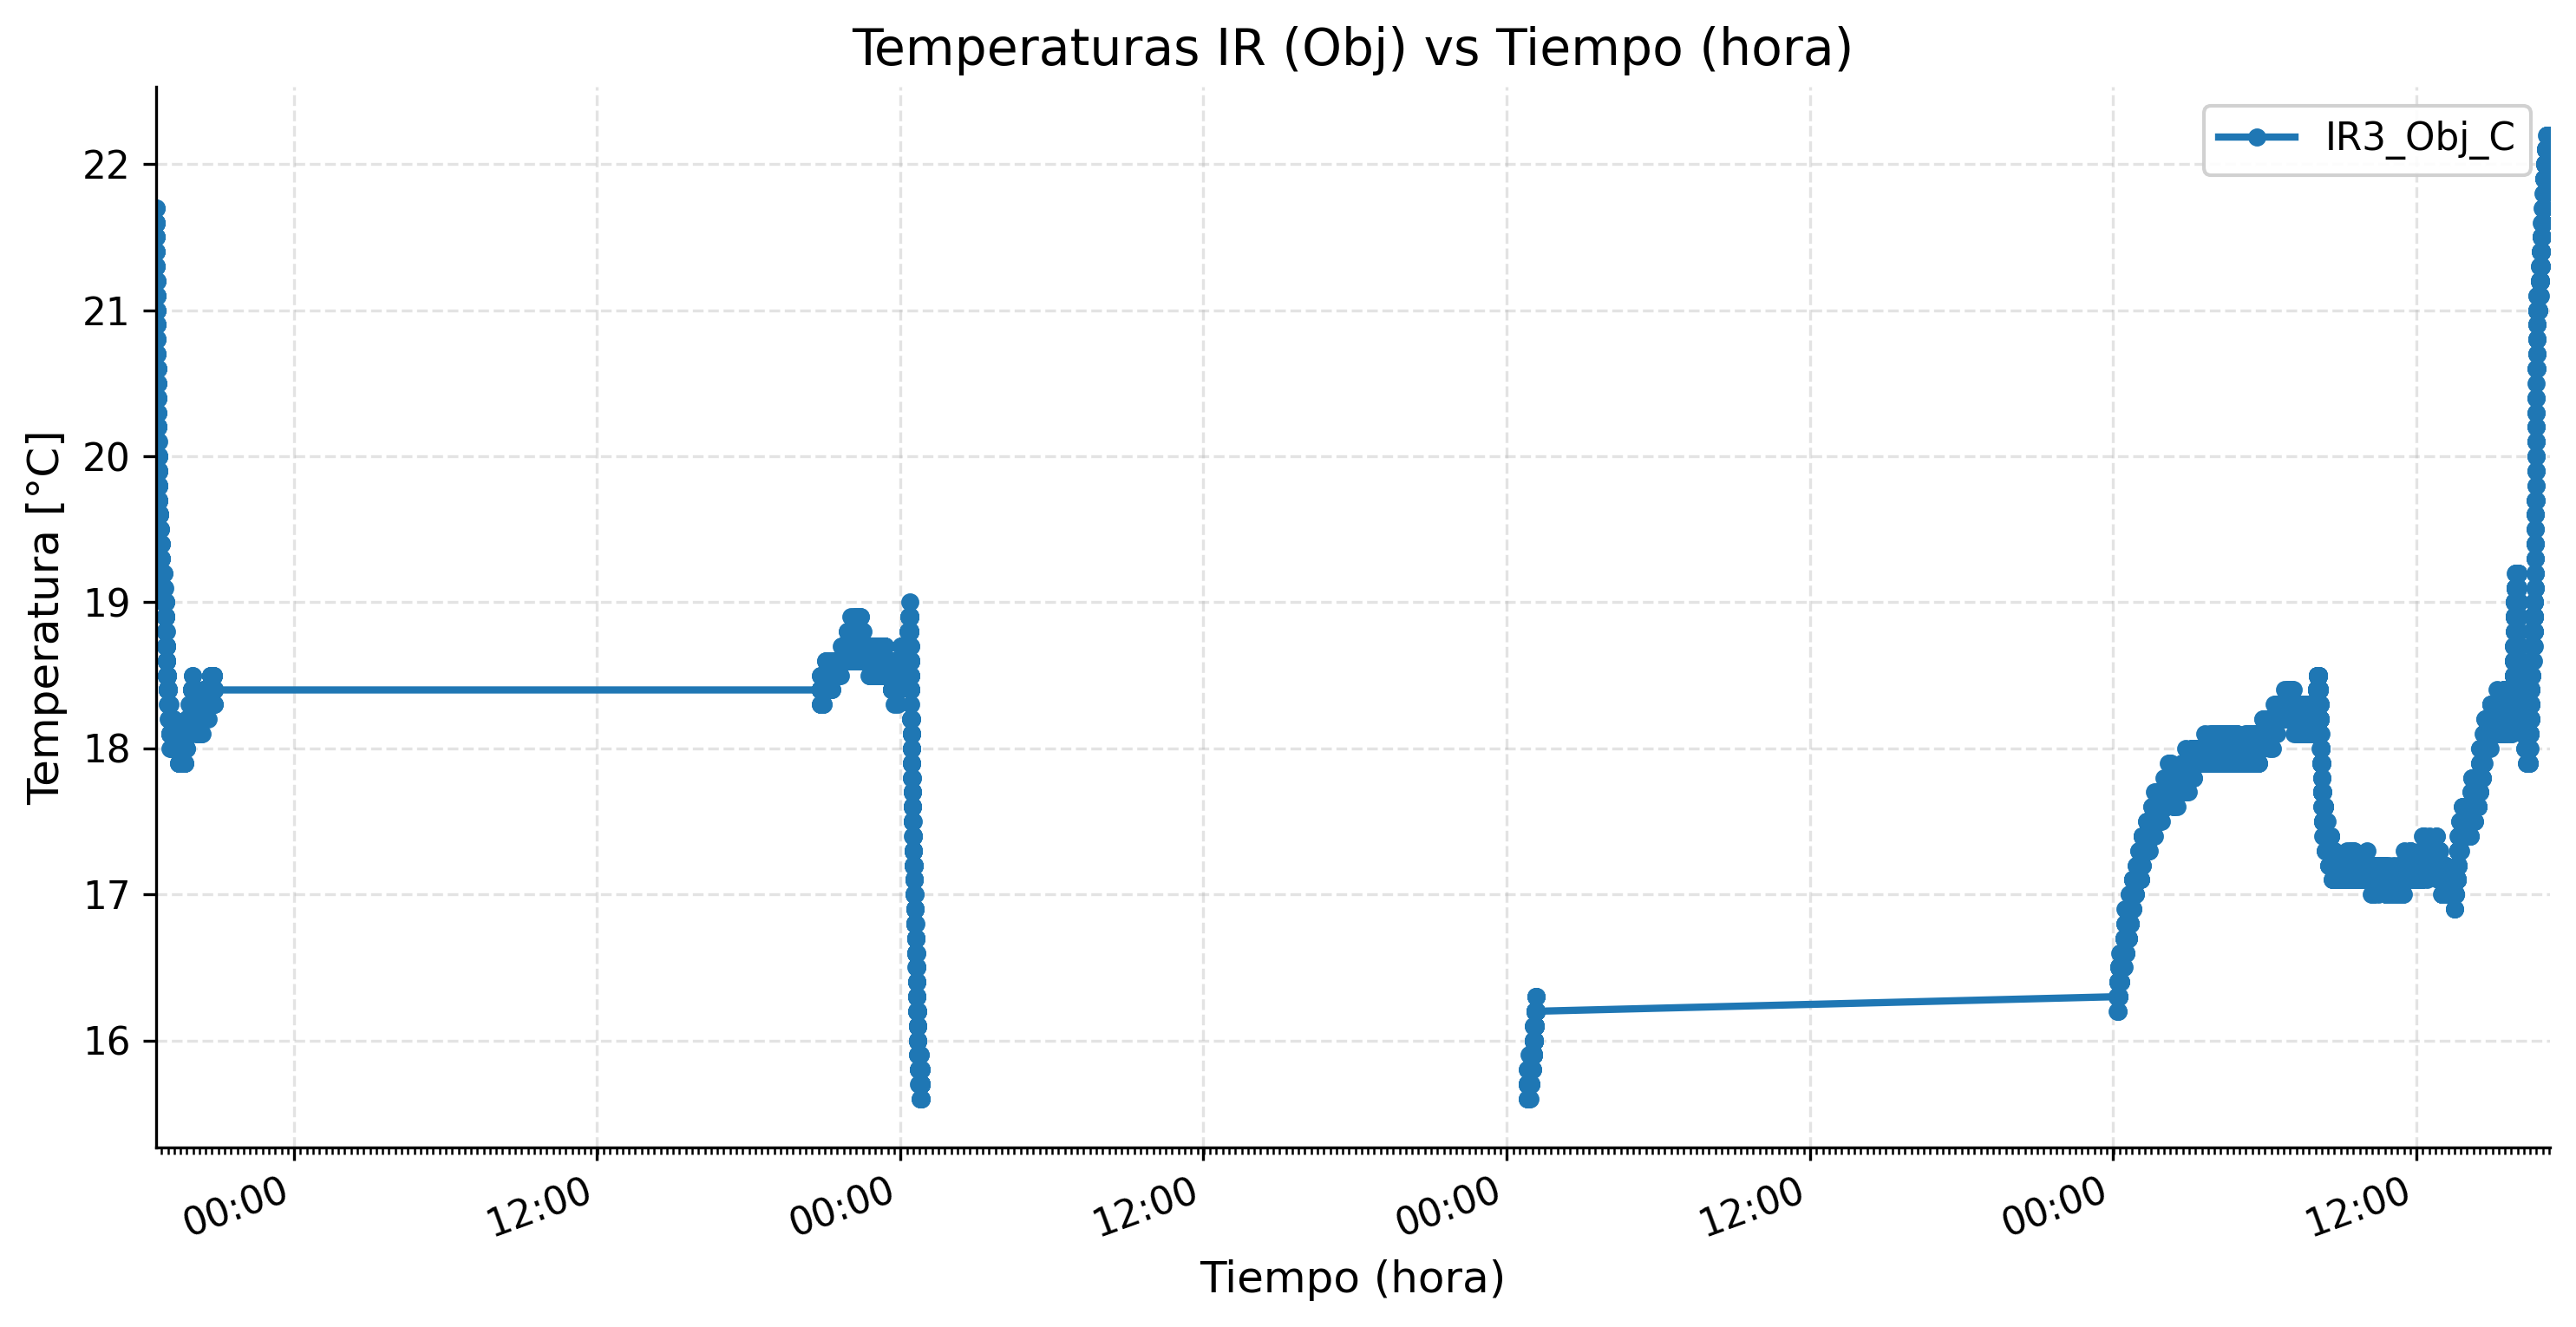

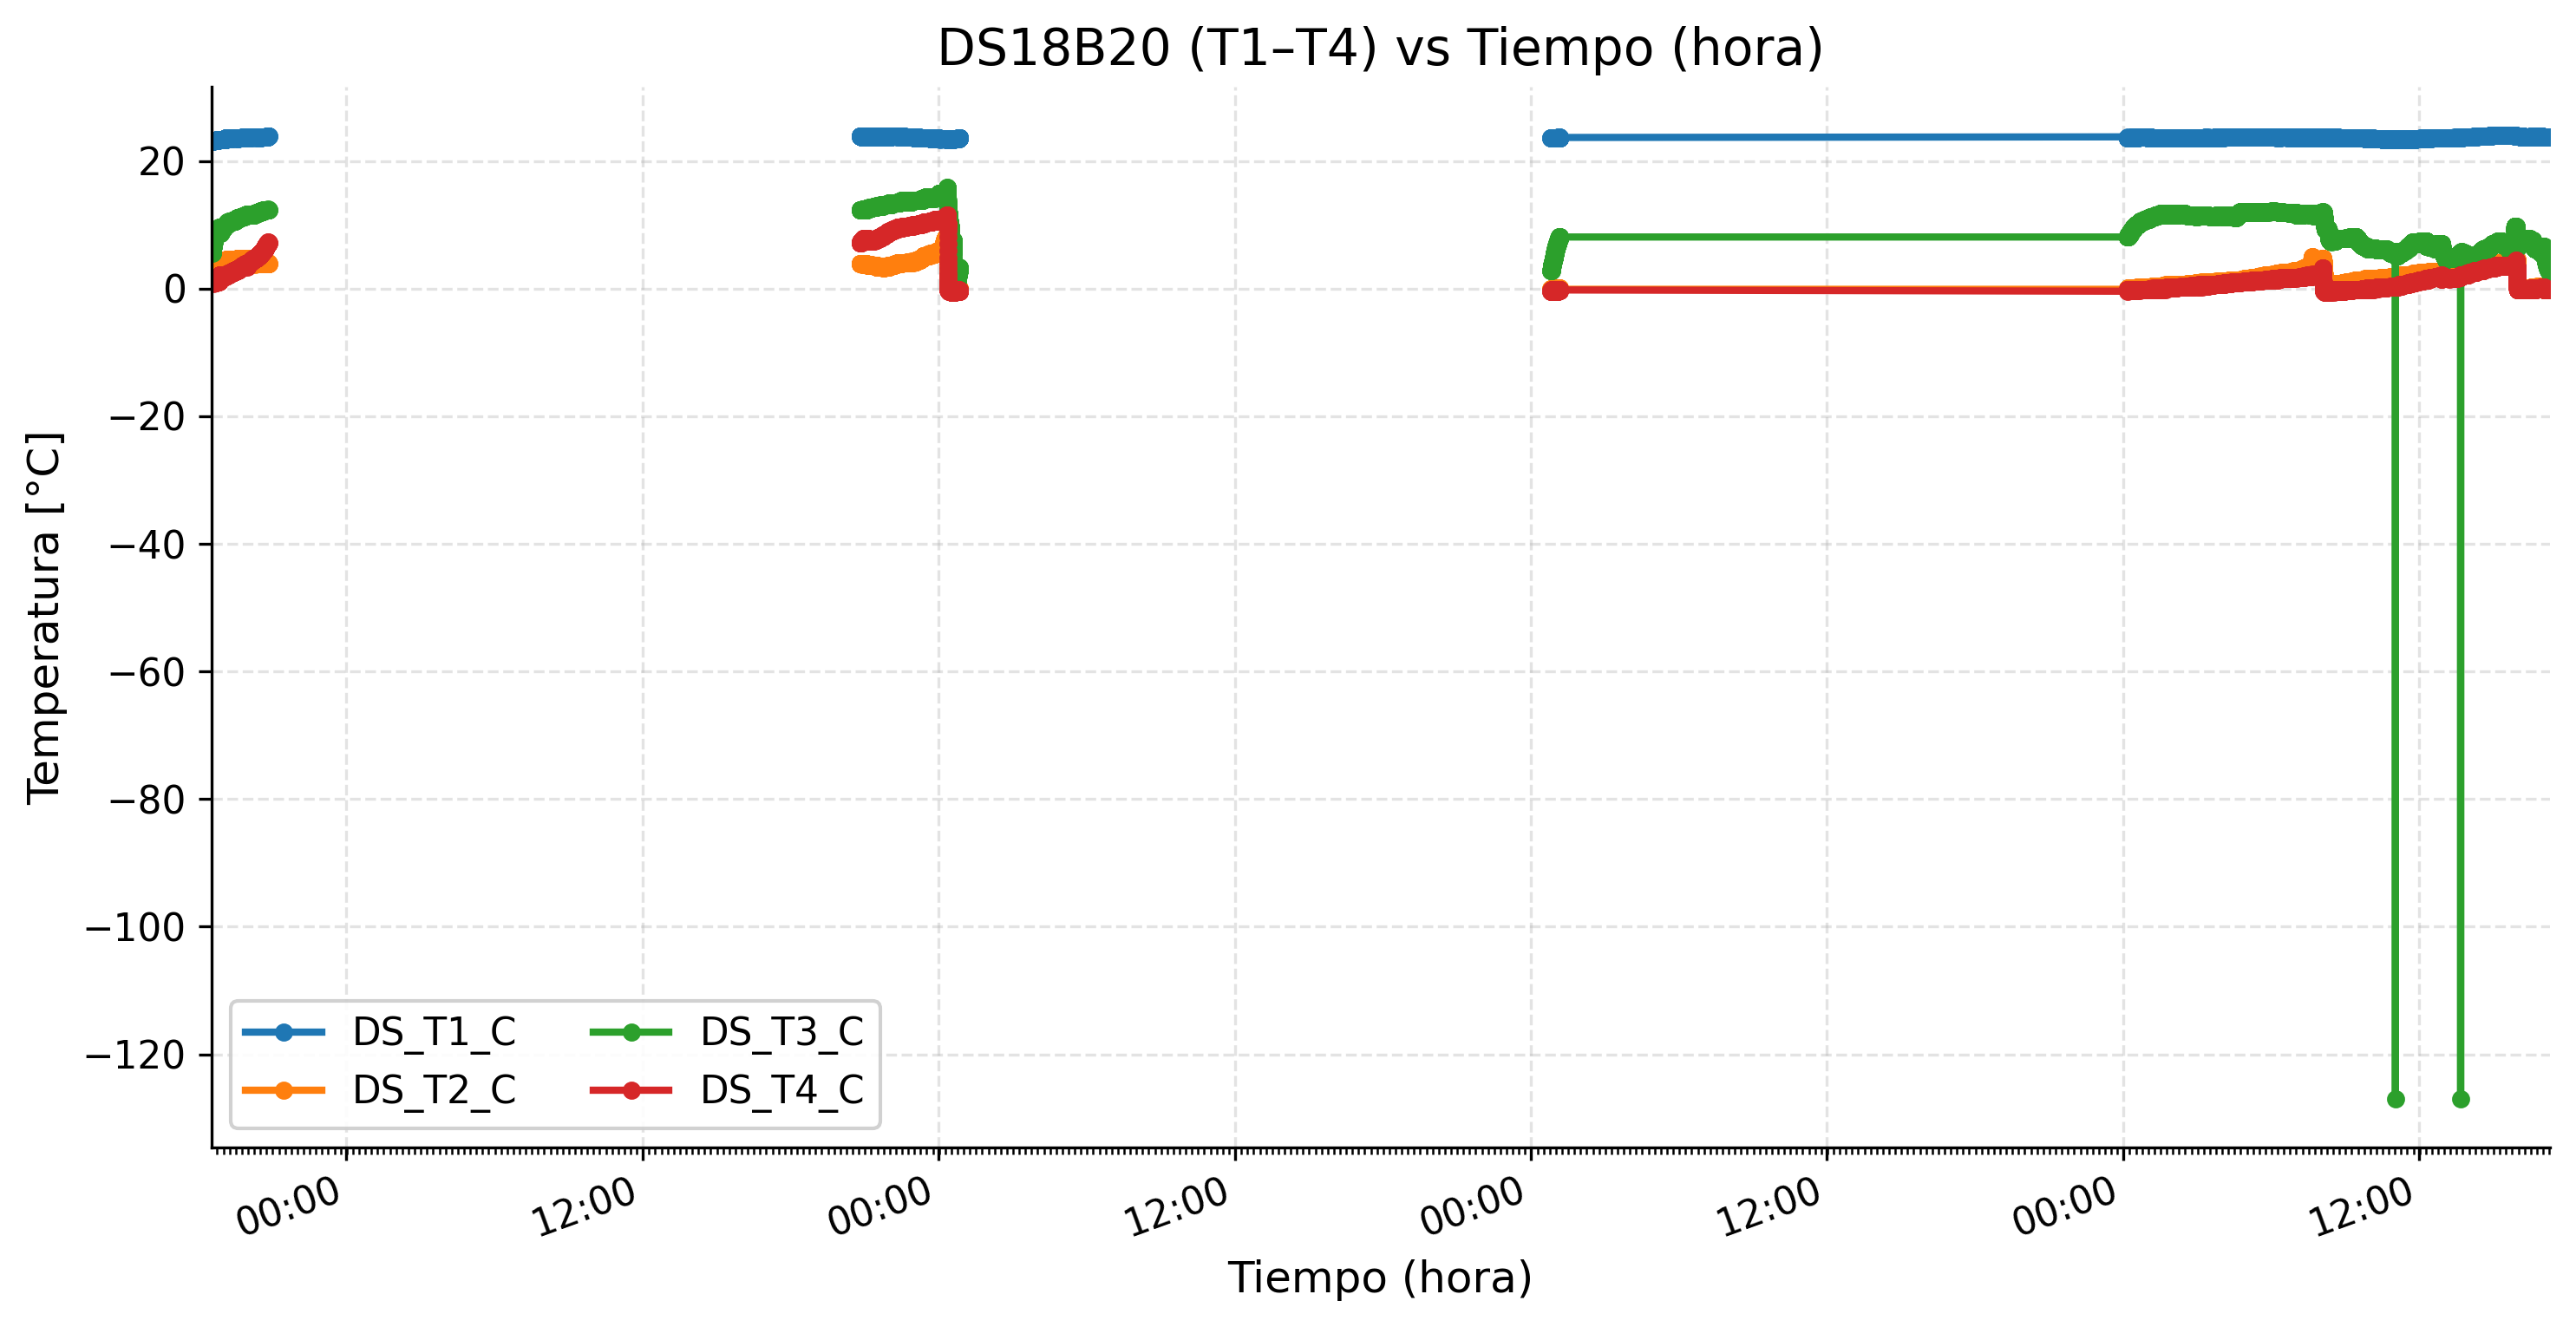

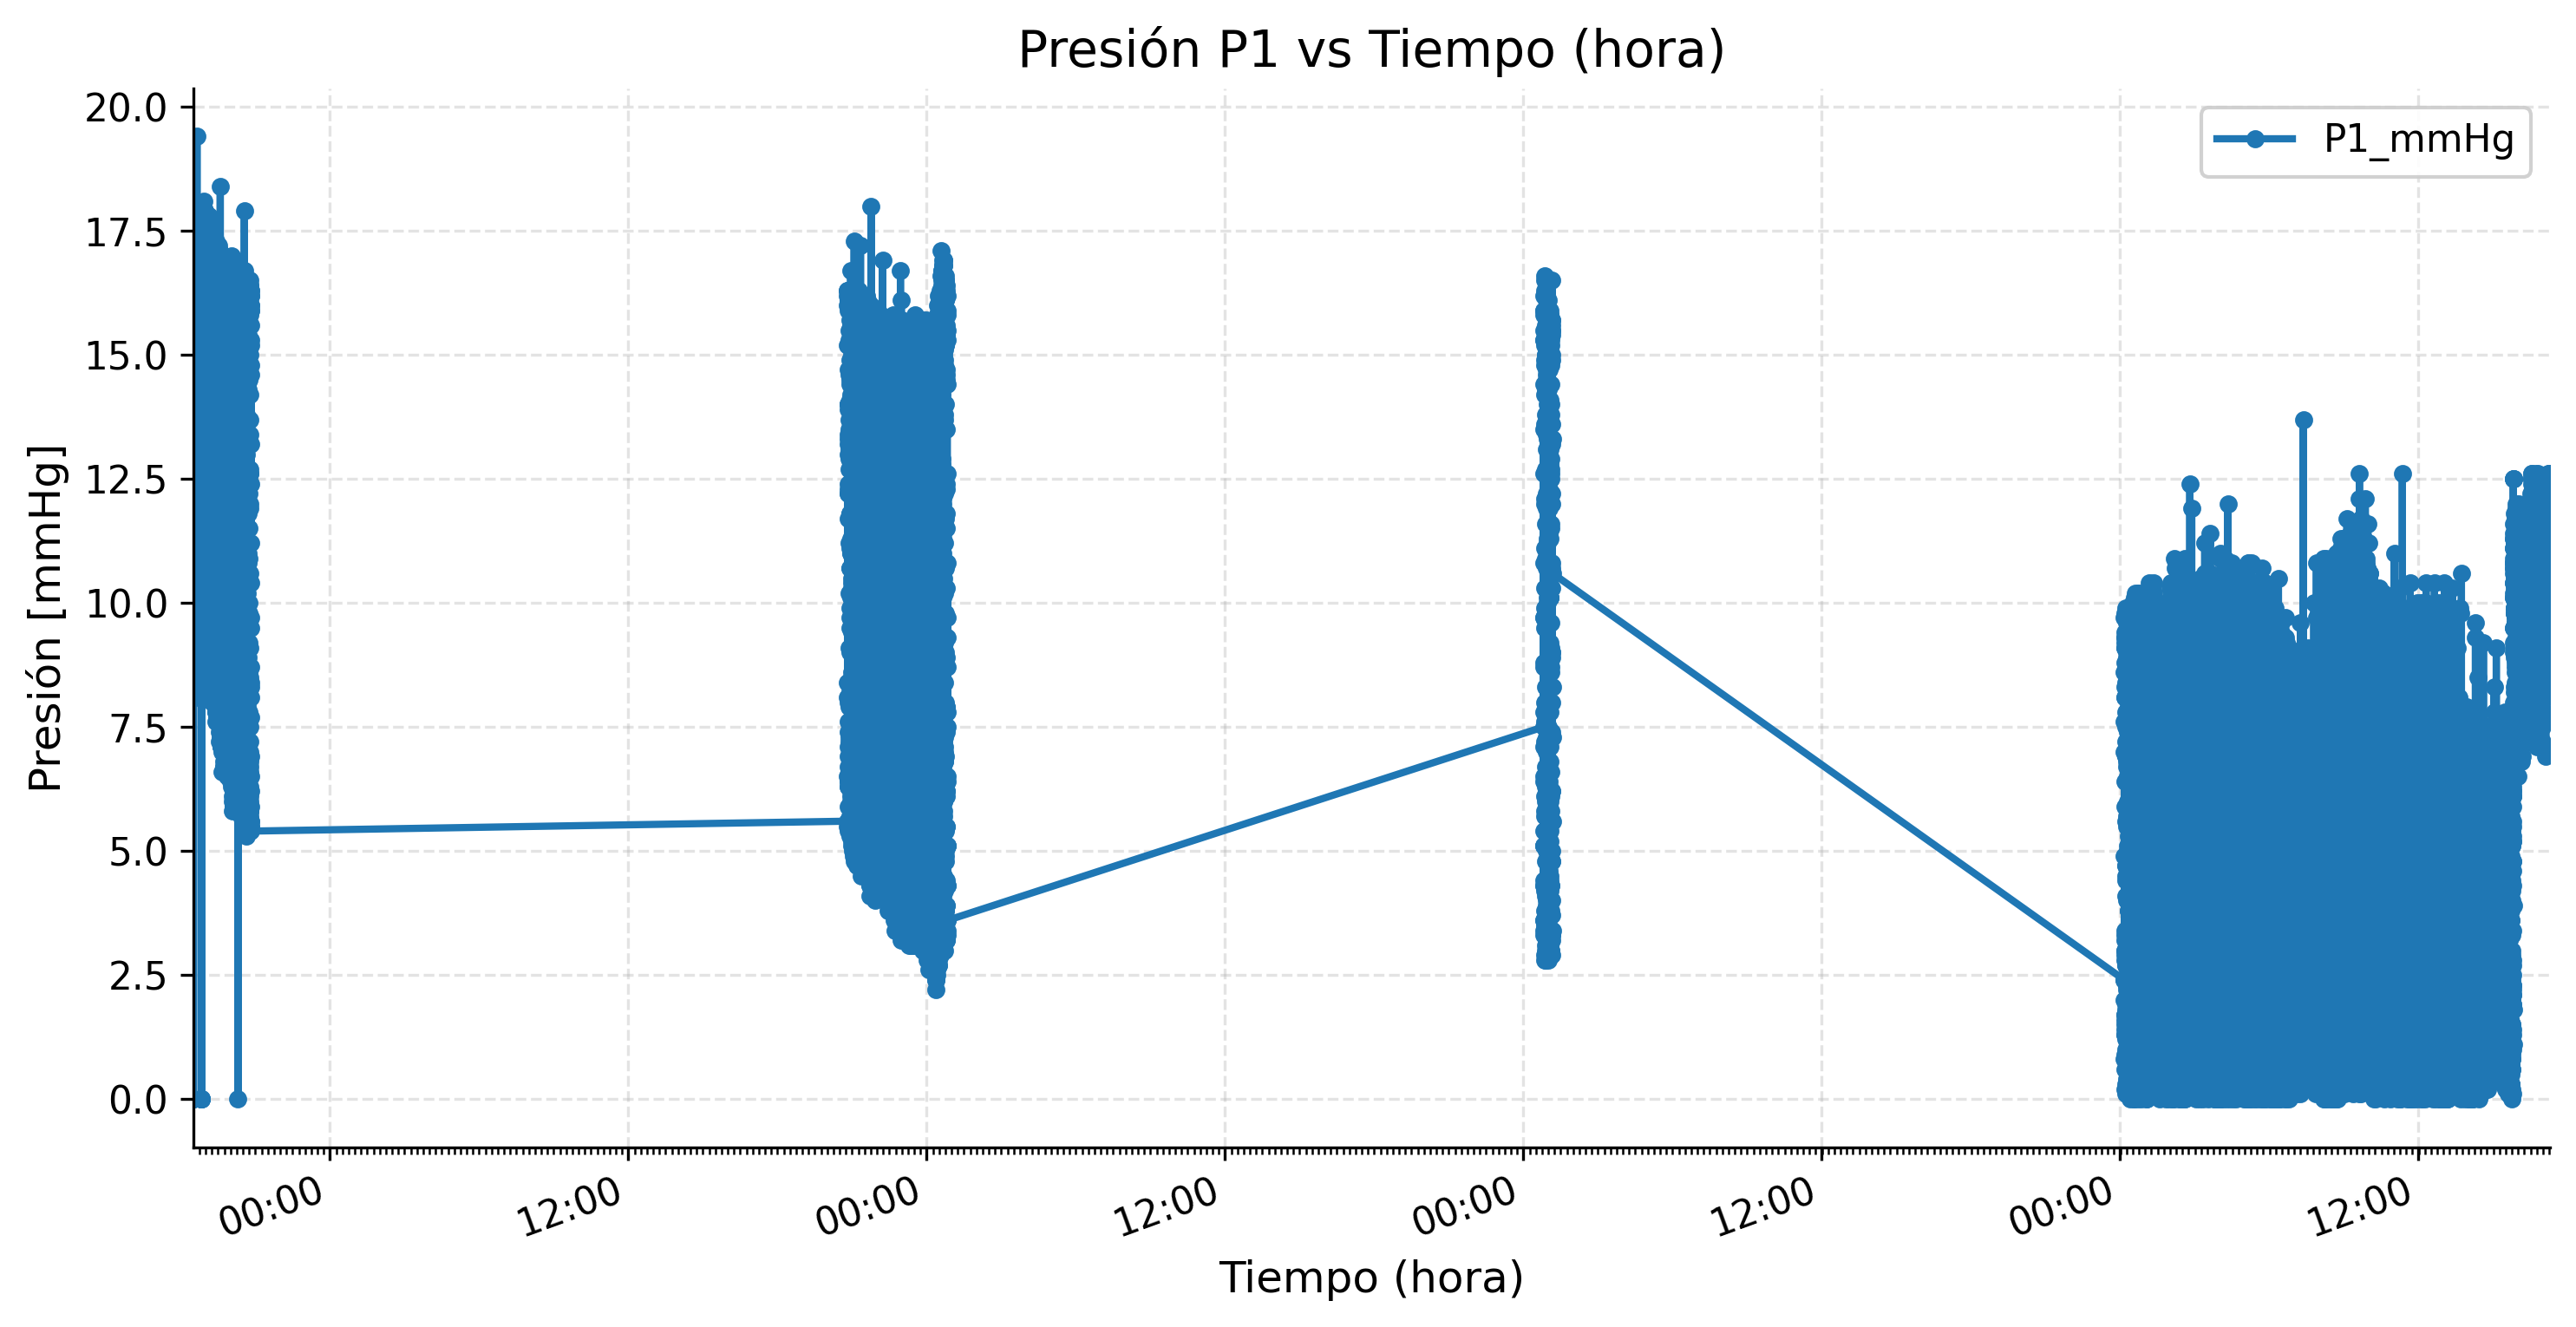

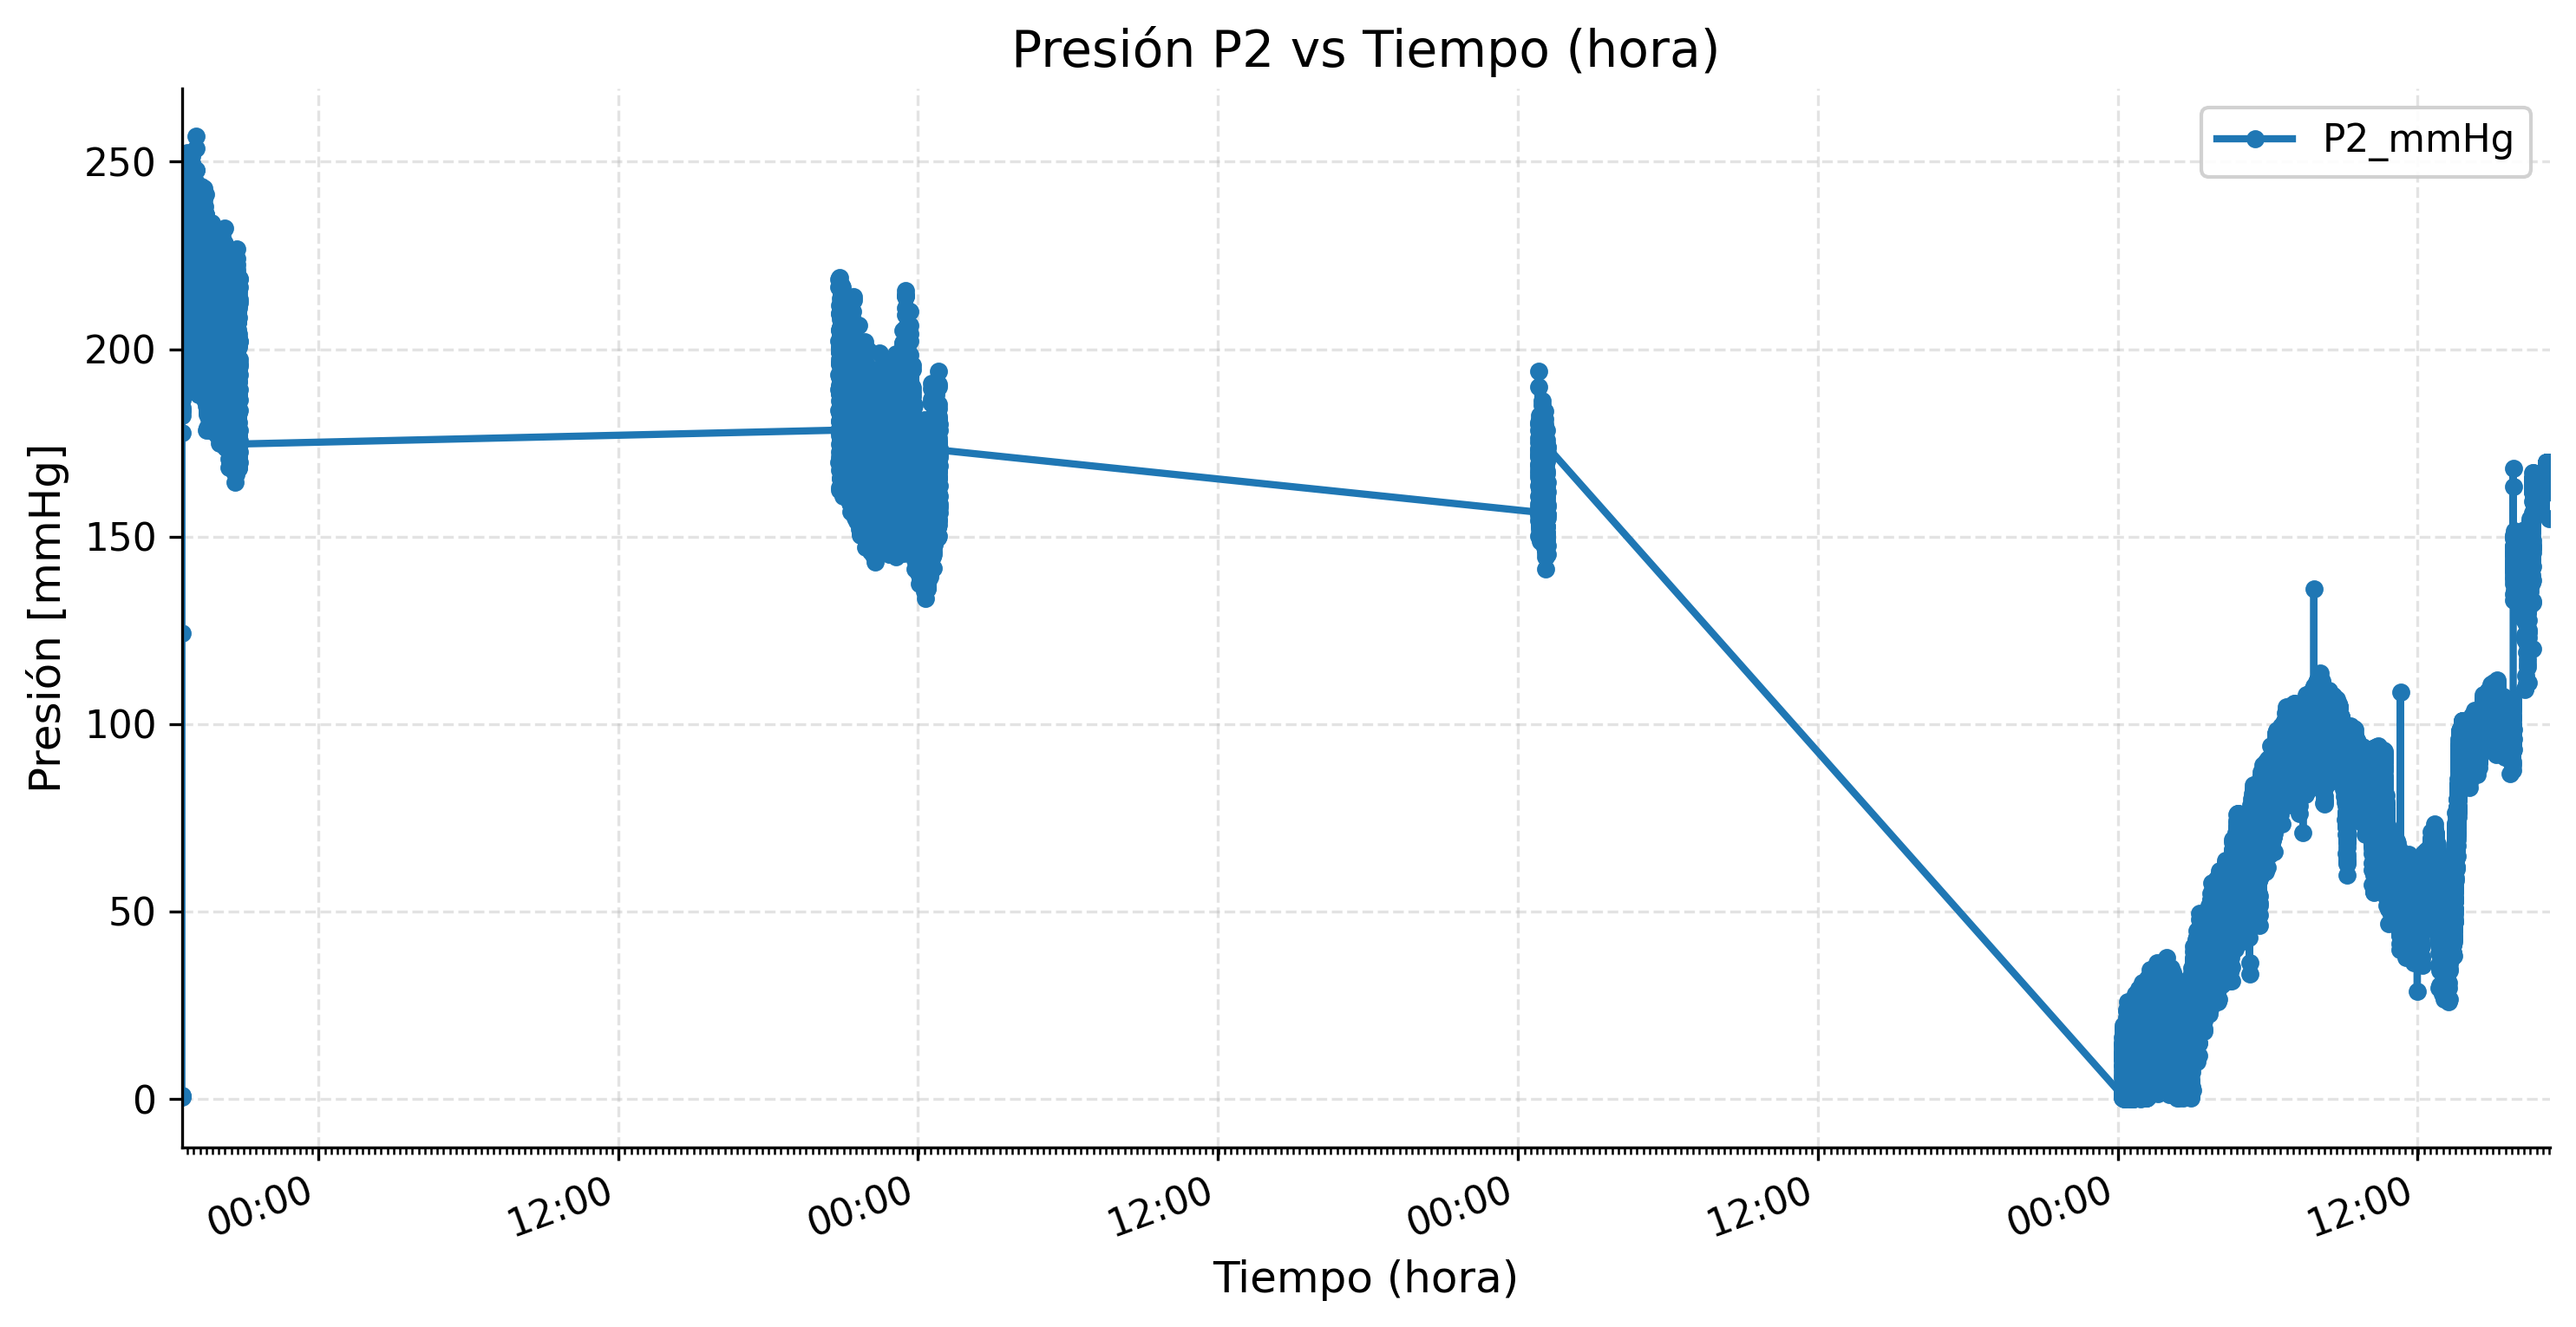

[AVISO] 'IR2_Obj_C' no tiene datos válidos.


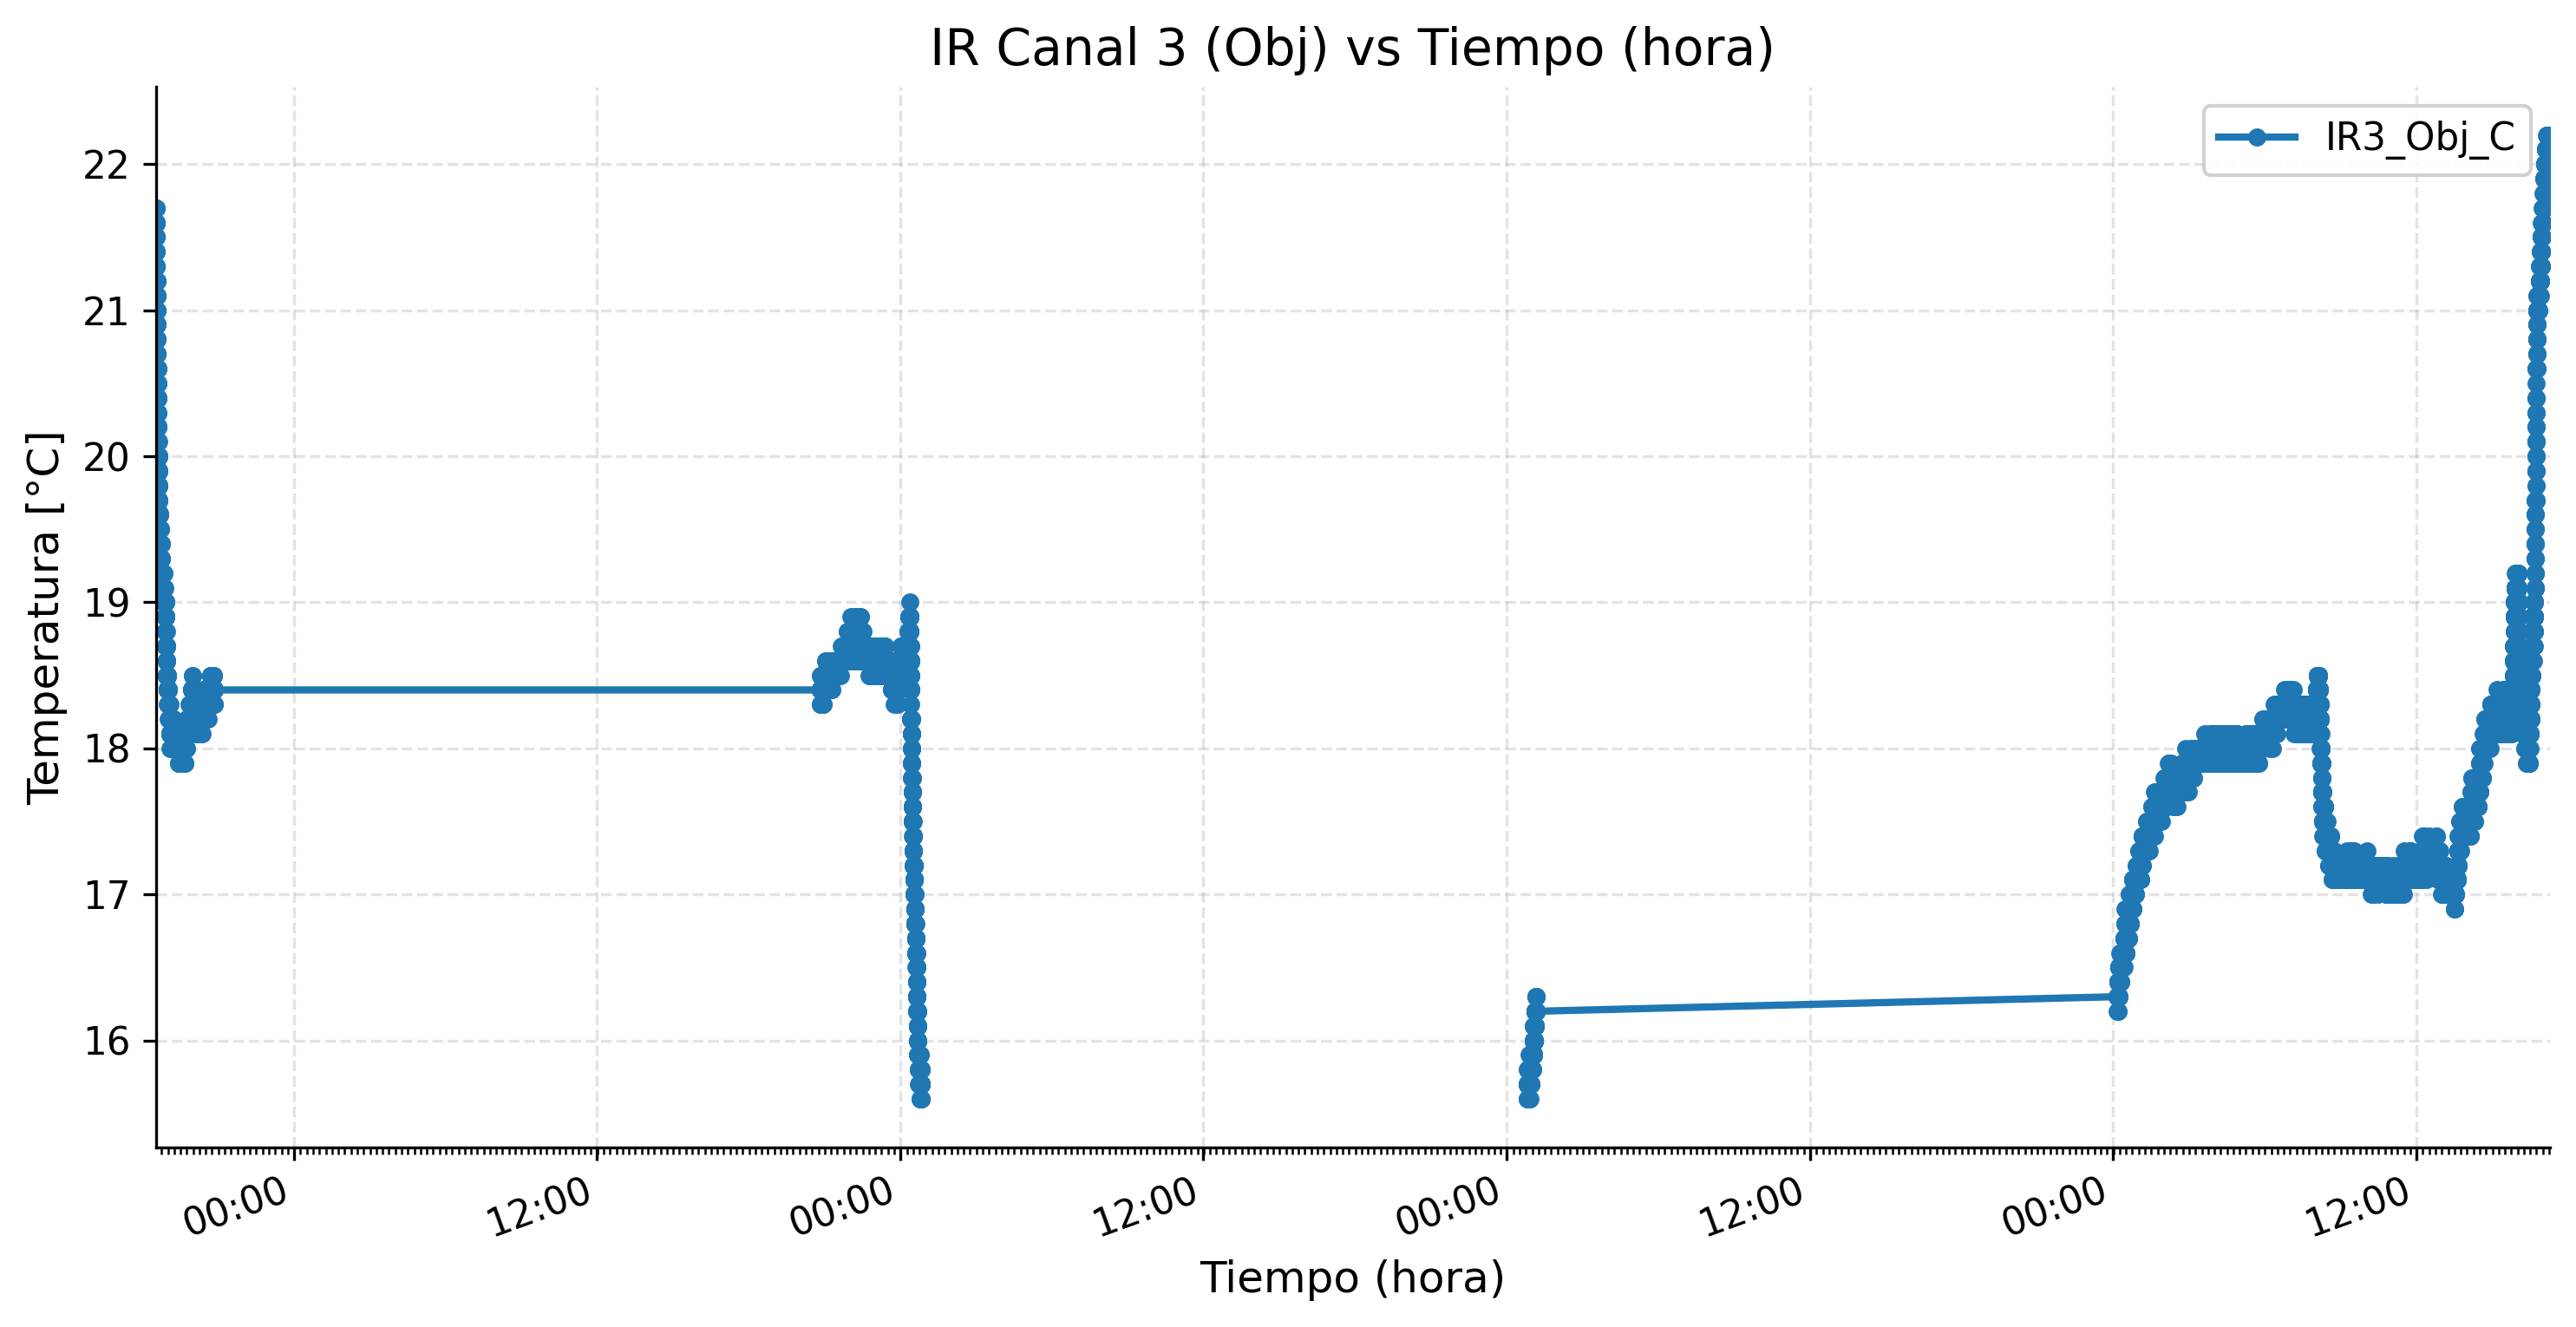

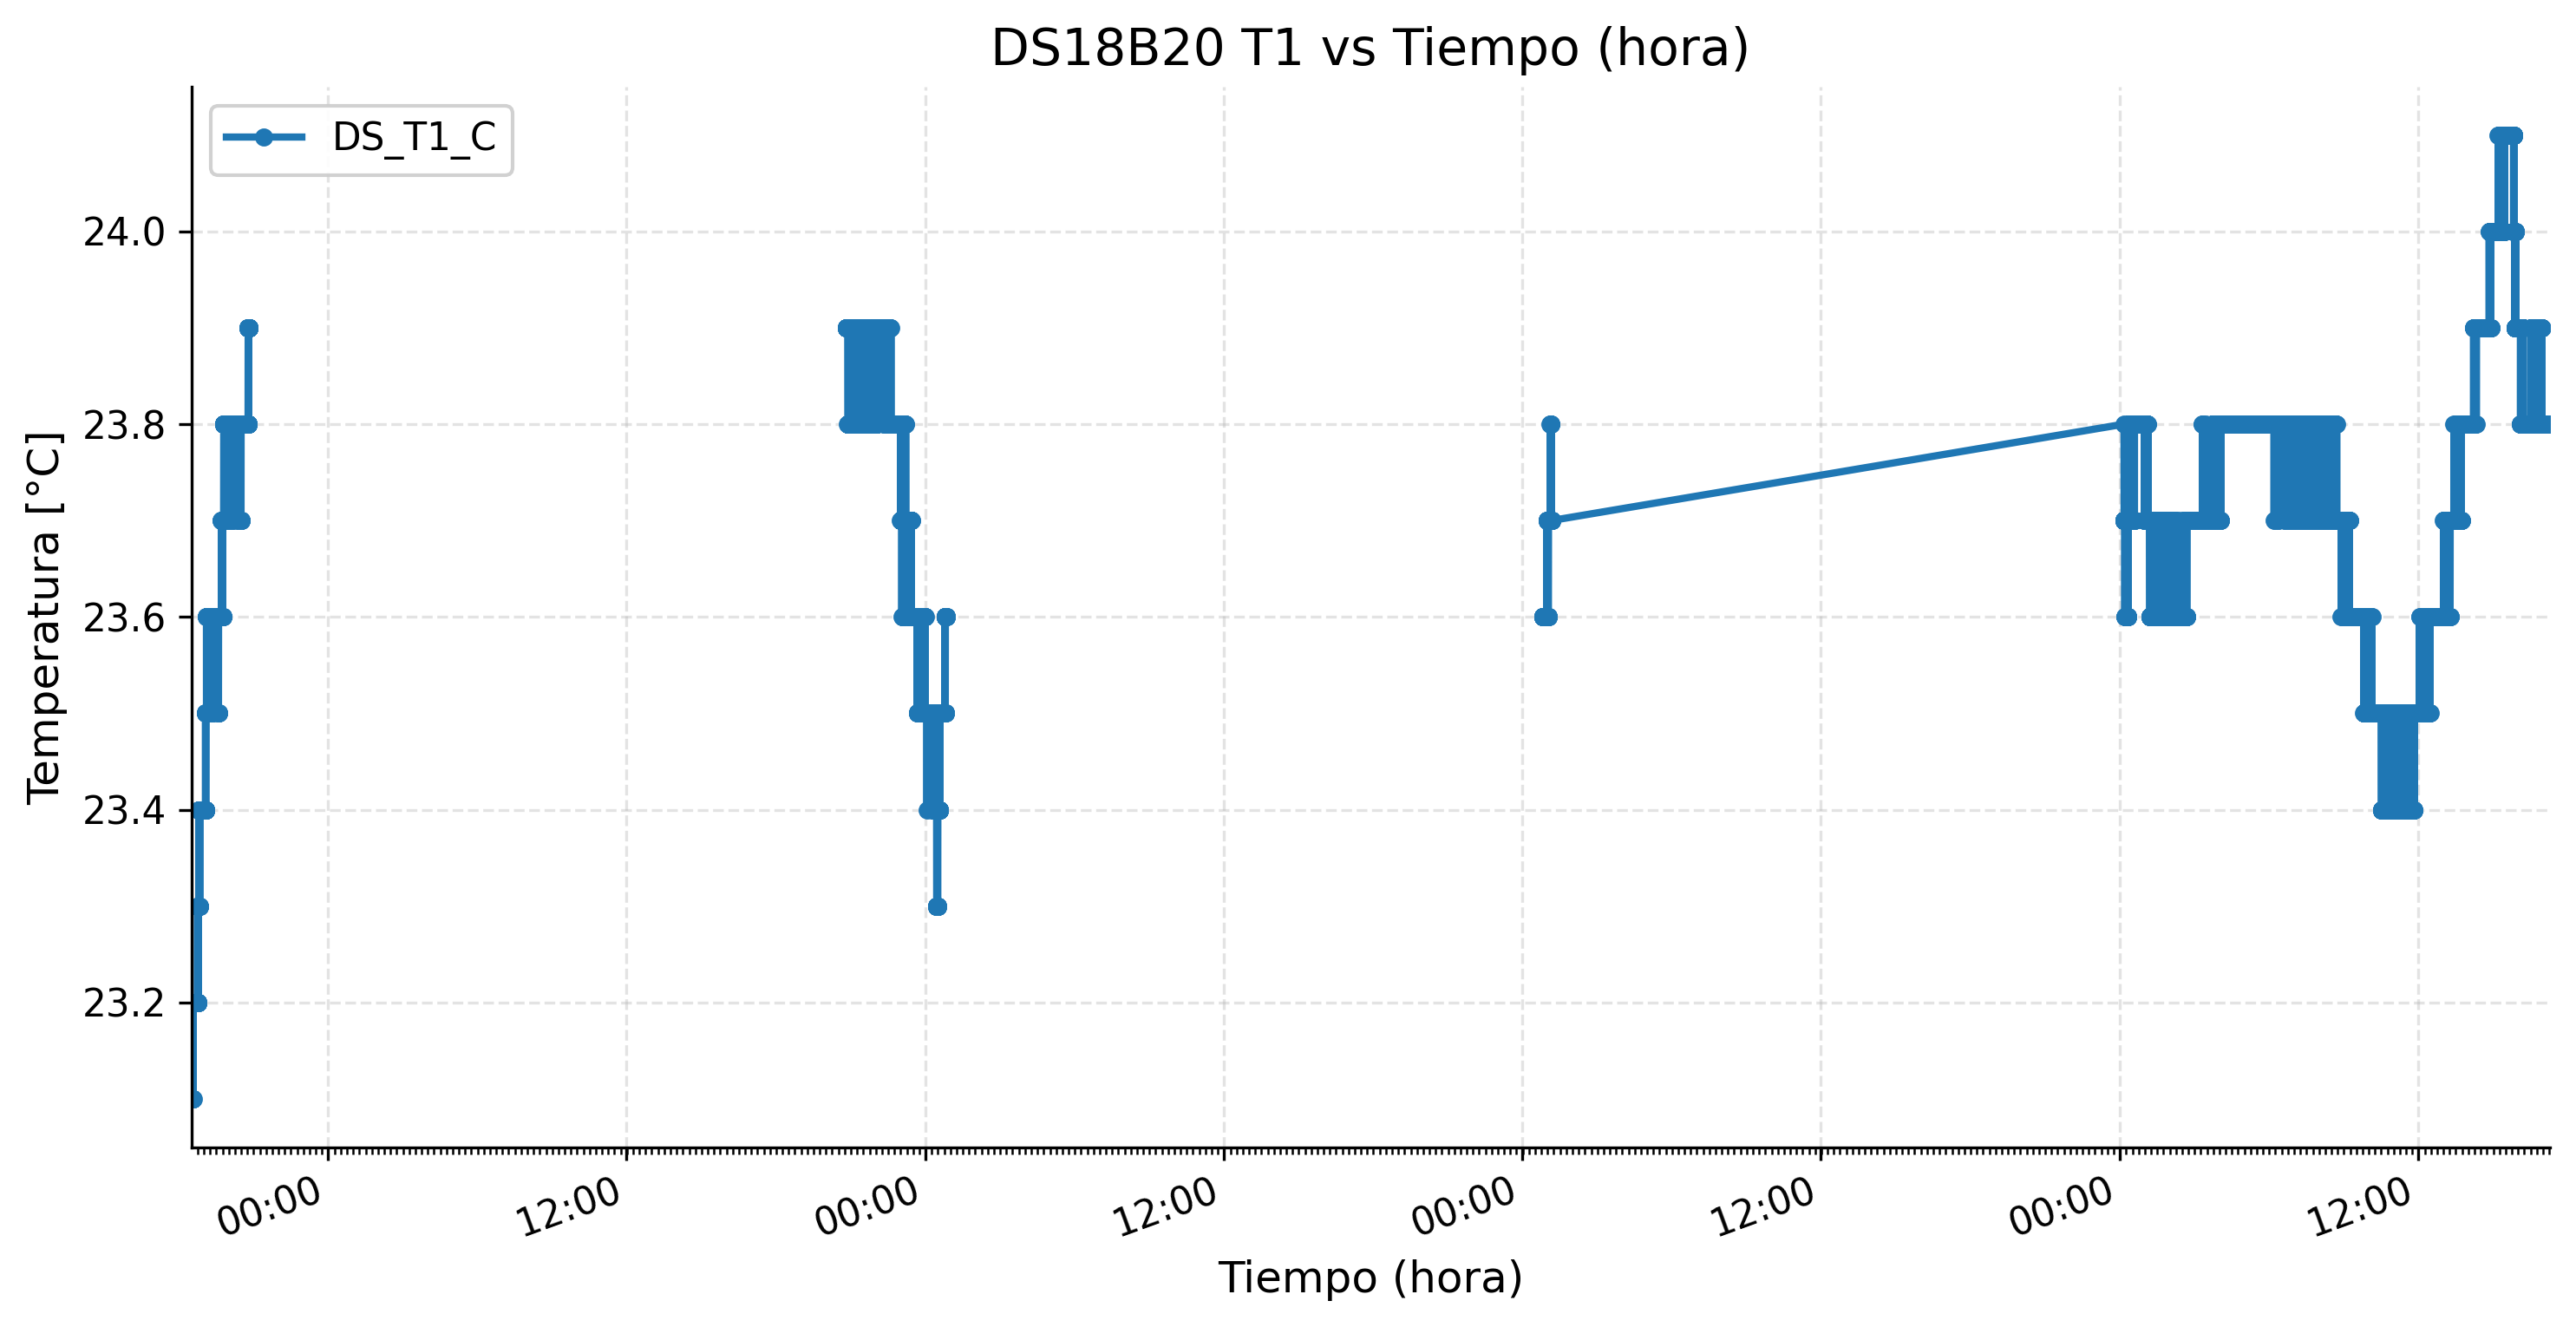

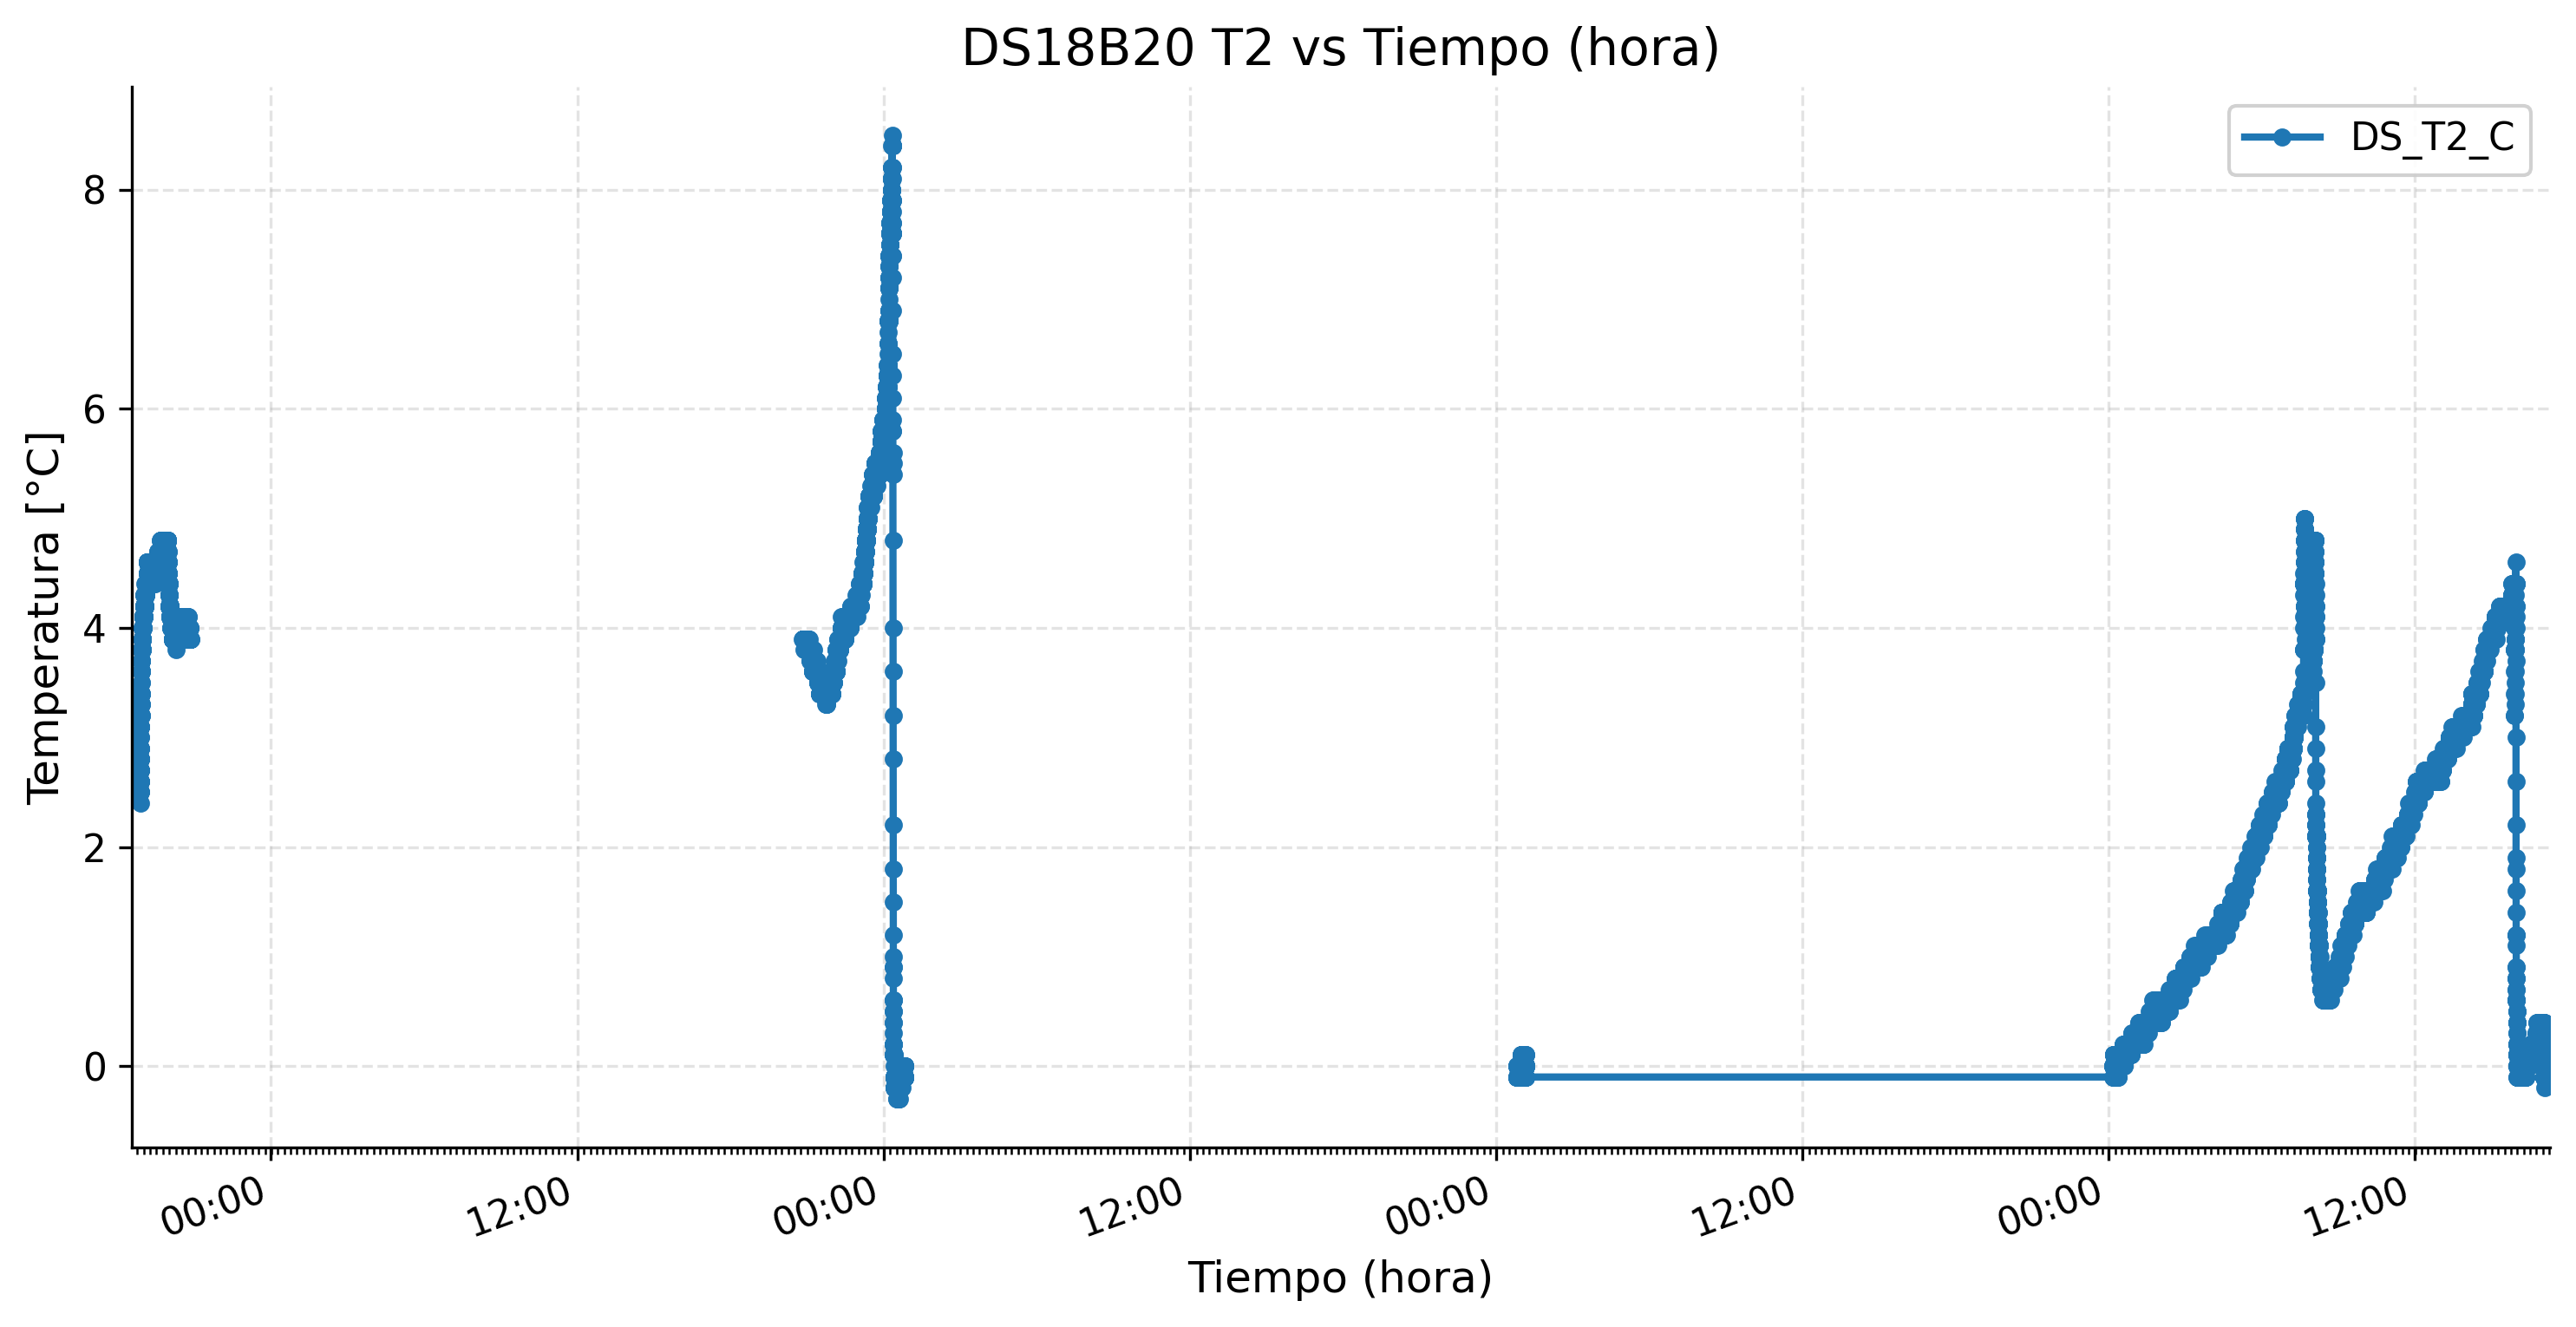

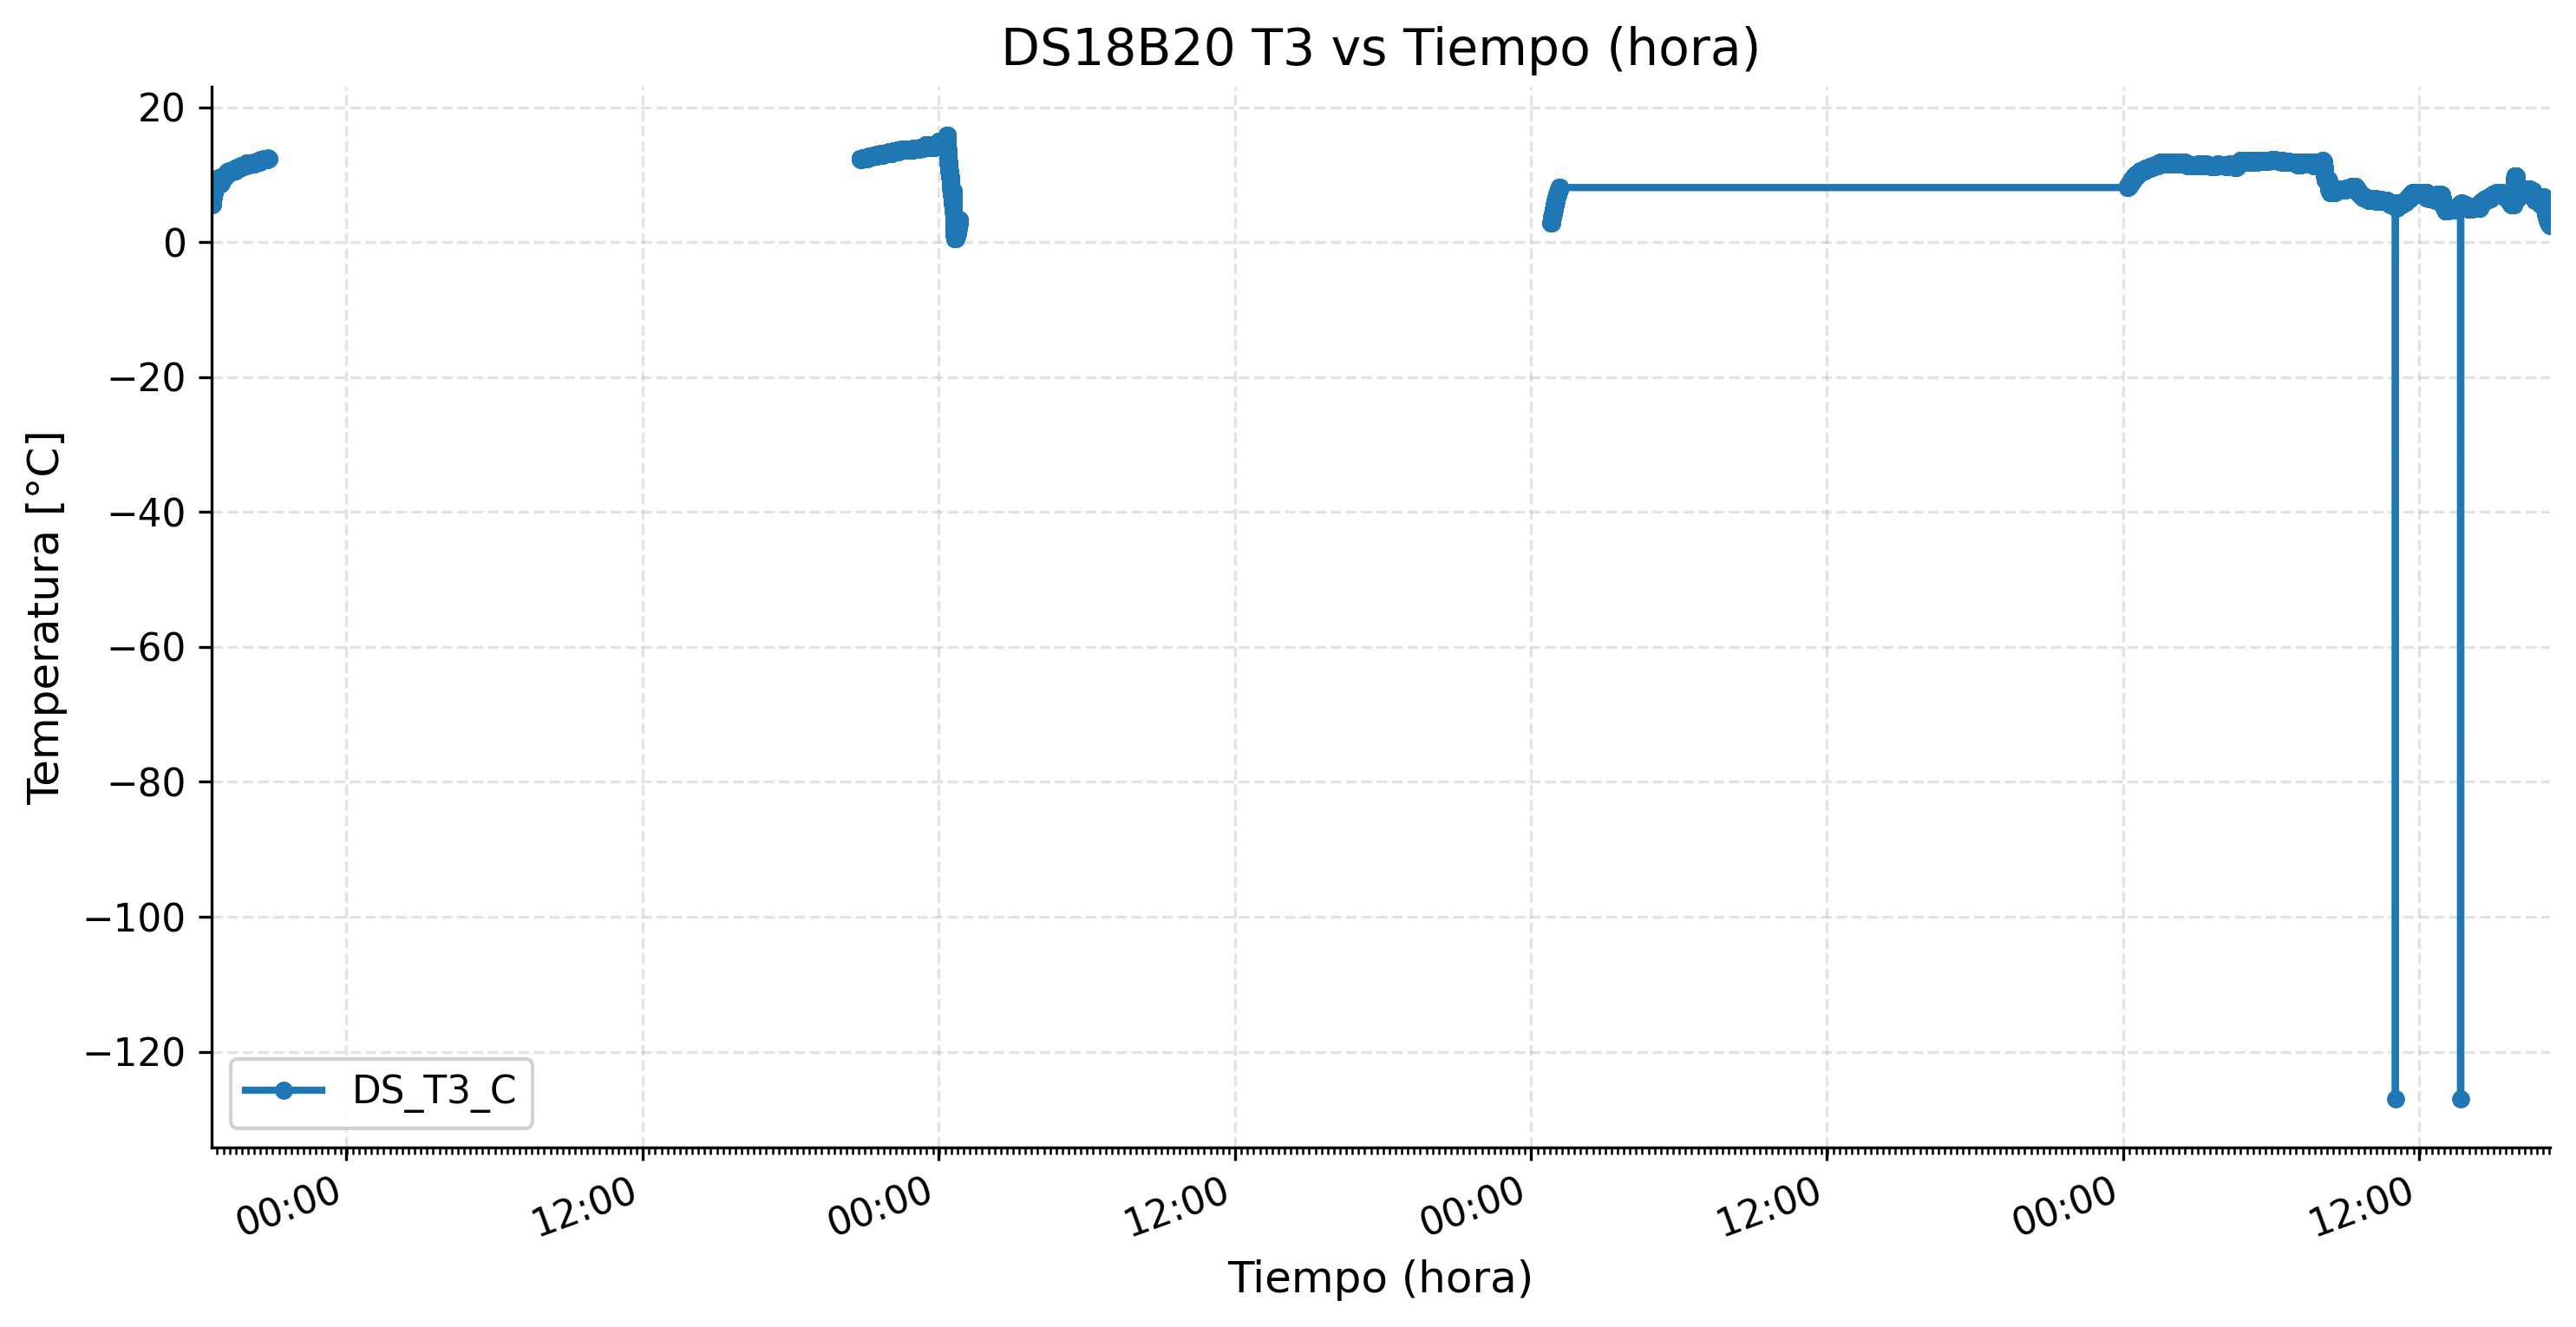

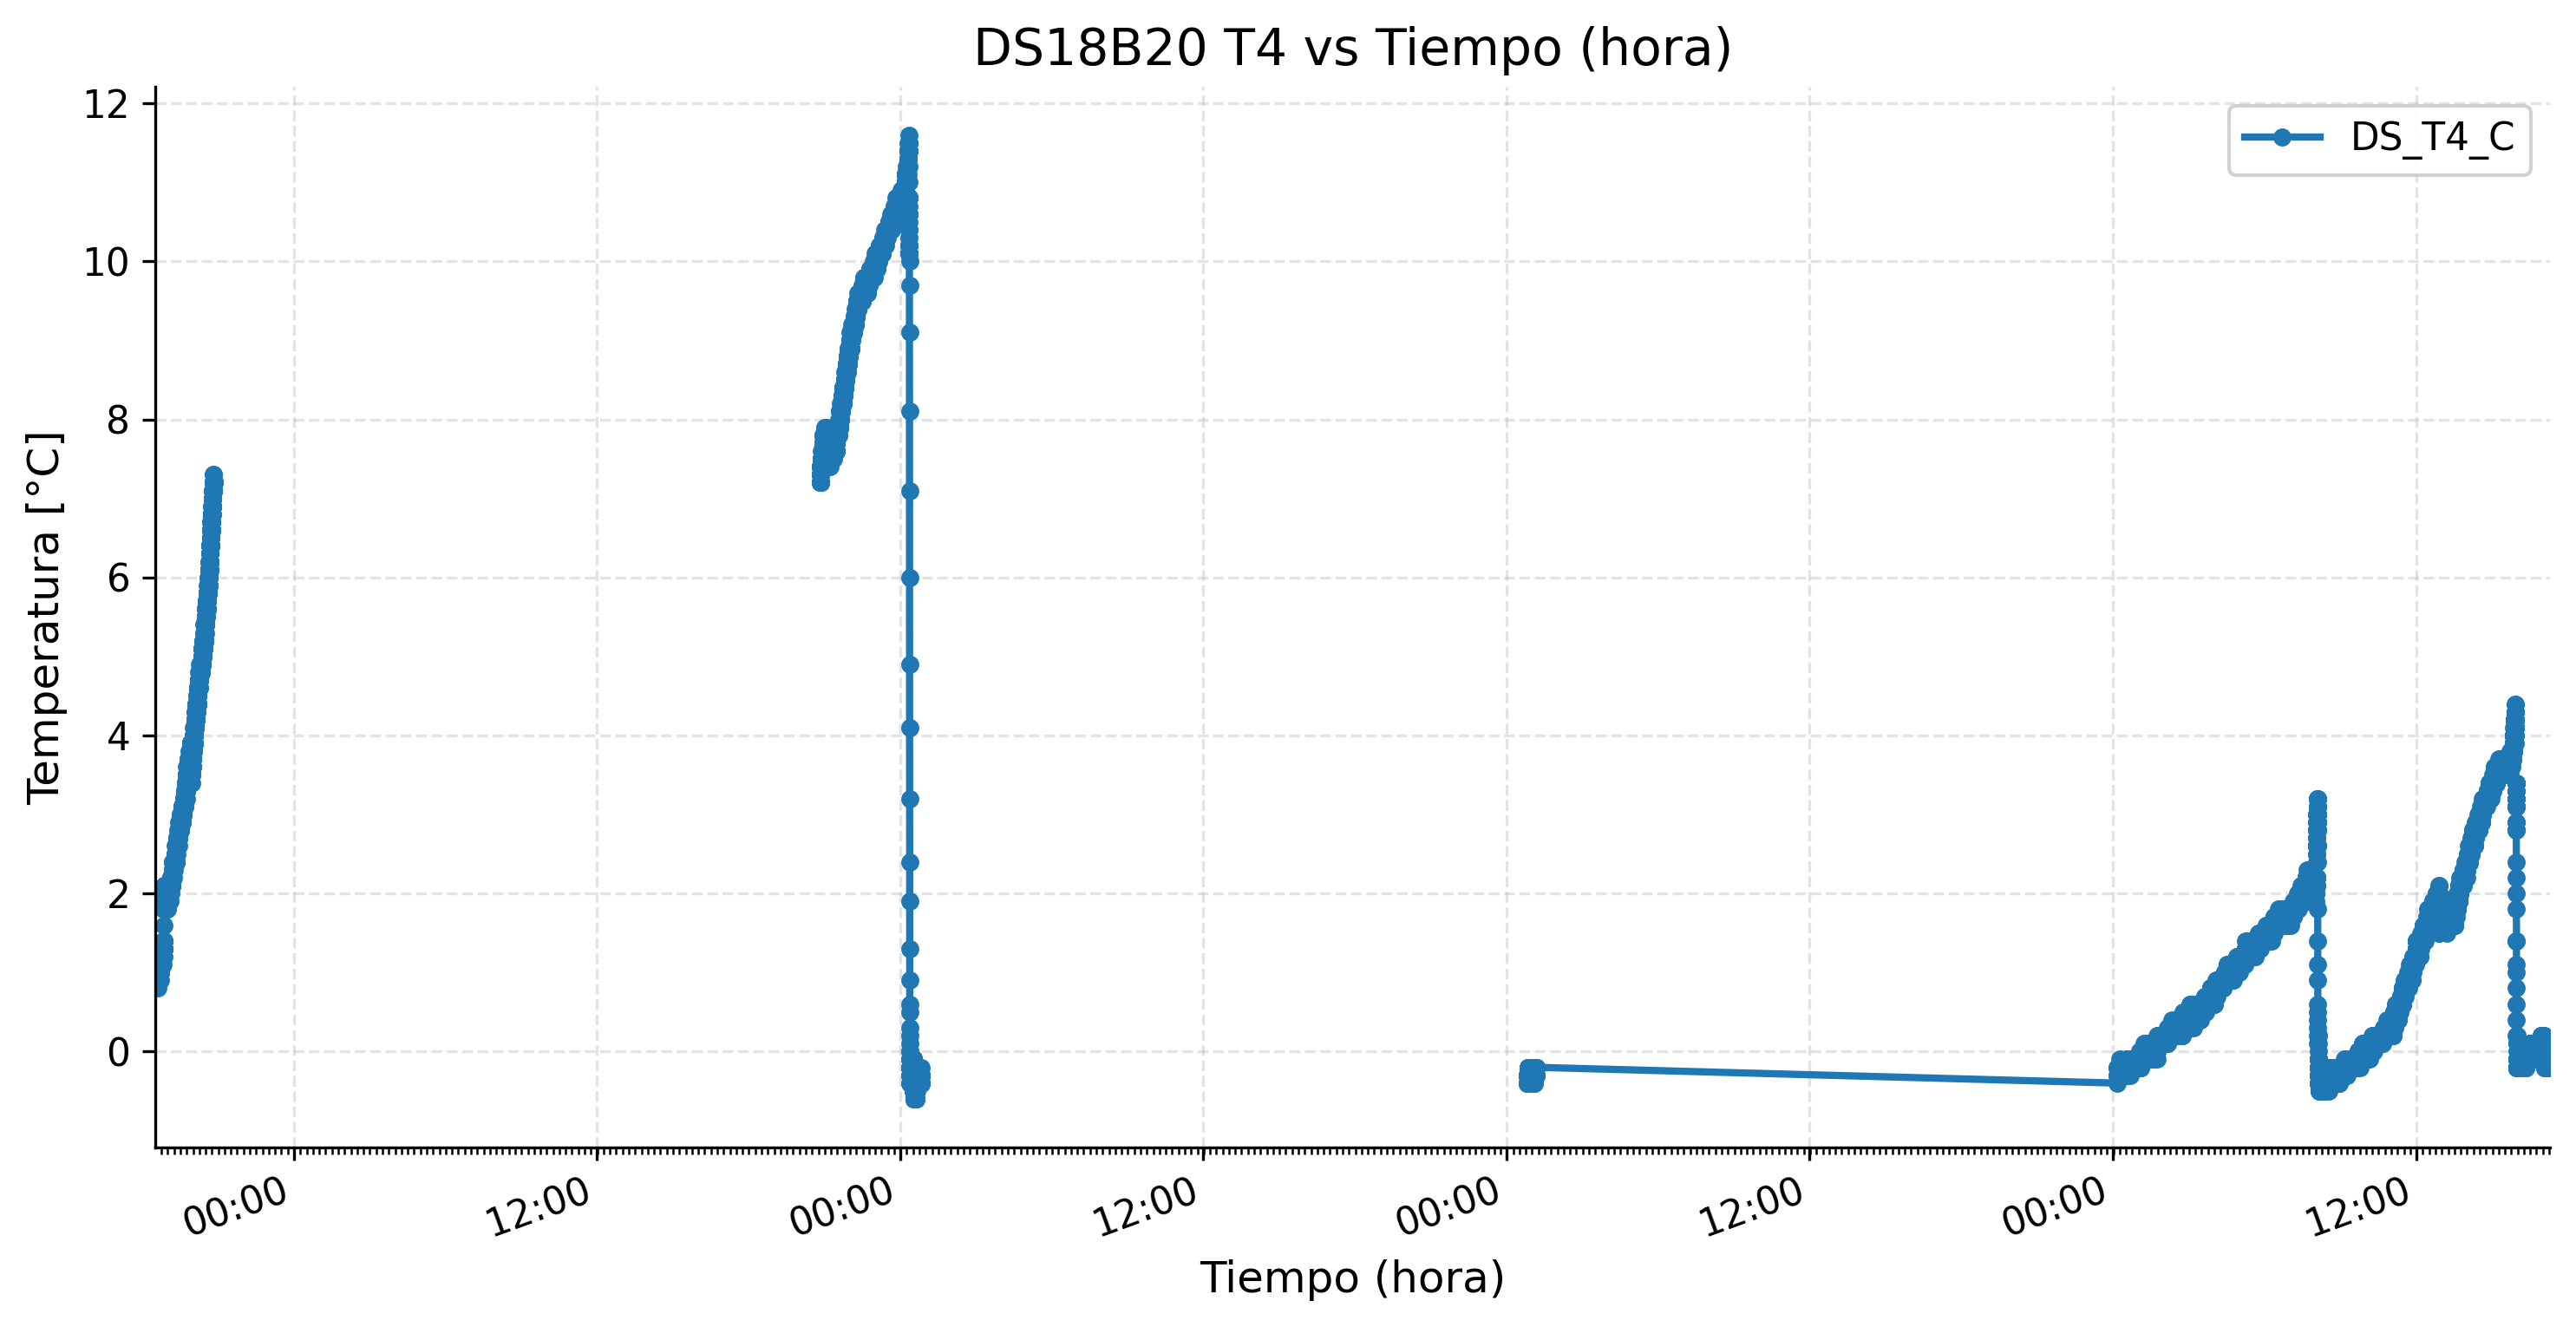

✅ Figuras generadas con eje horario real y continuo (sin D+ ni líneas).


In [16]:
# -*- coding: utf-8 -*-
"""
Graficación profesional + muestreo por intervalos:
- Presiones, IR y DS18B20 (conjuntas e individuales)
- Eje X respeta la hora real del primer dato (ej. 18:32)
- Sin líneas de medianoche ni etiquetas D+N
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Optional, Tuple

# ================== CONFIGURACIÓN ==================
CSV_PATH      = "salida_unida.csv"
OUT_PREFIX    = "fig_"
SAVE_PNGS     = True
SAVE_PDFS     = False
SHOW_PLOTS    = True
DPI           = 300
FIGSIZE       = (10, 5.2)
LINEWIDTH     = 2.0
MARKERSIZE    = 4
GRID_ALPHA    = 0.35

USE_ELAPSED   = False               # False = usa la columna 'time' (HH:MM:SS)
ELAPSED_ZERO_DATE = pd.Timestamp('2000-01-01')

RANGE_START: Optional[str] = None   # Ej: "18:00:00"
RANGE_END:   Optional[str] = None   # Ej: "23:00:00"

SAMPLE_MODE = "none"                # "none", "nearest", "mean", "median"
SAMPLE_FREQ = "30min"               # "5min", "15min", "30min", "1h"
# ===================================================

# ---- Estilo global ----
plt.rcParams.update({
    "figure.figsize": FIGSIZE,
    "figure.dpi": 300,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": GRID_ALPHA,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10.5,
    "ytick.labelsize": 10.5,
    "legend.fontsize": 10.5,
    "lines.linewidth": LINEWIDTH,
    "lines.markersize": MARKERSIZE,
})

# ===================================================
# == PARSER DE TIEMPO CON CAMBIO DE DÍA AUTOMÁTICO ==
# ===================================================
def construir_tiempo_continuo(time_series: pd.Series) -> pd.Series:
    """Convierte texto de hora a datetime continuo, manejando medianoches."""
    t_str = time_series.astype(str).str.strip()
    t_norm = t_str.str.replace(",", ".", regex=False)
    tiene_fecha = t_norm.str.contains("T")
    dt = pd.Series(pd.NaT, index=t_norm.index, dtype="datetime64[ns]")

    if tiene_fecha.any():
        dt.loc[tiene_fecha] = pd.to_datetime(t_norm[tiene_fecha], errors="coerce")

    if (~tiene_fecha).any():
        t_hora = "2000-01-01 " + t_norm[~tiene_fecha]
        dt_hora = pd.to_datetime(t_hora, format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
        mask_na = dt_hora.isna()
        if mask_na.any():
            dt_hora2 = pd.to_datetime(
                ("2000-01-01 " + t_norm[~tiene_fecha][mask_na]),
                format="%Y-%m-%d %H:%M:%S",
                errors="coerce",
            )
            dt_hora[mask_na] = dt_hora2
        dt.loc[~tiene_fecha] = dt_hora

    if dt.isna().any():
        ejemplos = t_str[dt.isna()].unique()[:5]
        raise ValueError("No se pudieron parsear marcas de tiempo: " + ", ".join(map(str, ejemplos)))

    neg = dt.diff() < pd.Timedelta(0)
    roll = neg.cumsum()
    return dt + pd.to_timedelta(roll, unit="D")

def construir_x(df: pd.DataFrame) -> pd.Series:
    """Construye el eje X según USE_ELAPSED o time."""
    if USE_ELAPSED:
        if "elapsed_s" not in df.columns:
            raise KeyError("USE_ELAPSED=True pero falta 'elapsed_s'.")
        return pd.to_timedelta(pd.to_numeric(df["elapsed_s"], errors="coerce"), unit='s') + ELAPSED_ZERO_DATE
    else:
        if "time" not in df.columns:
            raise KeyError("USE_ELAPSED=False pero falta 'time'.")
        return construir_tiempo_continuo(df["time"])

# ===================================================
# == FILTRO Y MUESTREO ==
# ===================================================
def parse_hhmmss_to_datetime(base_date: pd.Timestamp, hhmmss: str) -> pd.Timestamp:
    return base_date + pd.to_timedelta(hhmmss)

def filtrar_rango(x_dt: pd.Series, df: pd.DataFrame,
                  start_hhmmss: Optional[str], end_hhmmss: Optional[str]) -> Tuple[pd.Series, pd.DataFrame]:
    if start_hhmmss is None and end_hhmmss is None:
        return x_dt, df
    base_date = x_dt.iloc[0].normalize()
    mask = pd.Series(True, index=df.index)
    if start_hhmmss is not None:
        t0 = parse_hhmmss_to_datetime(base_date, start_hhmmss)
        mask &= (x_dt >= t0)
    if end_hhmmss is not None:
        t1 = parse_hhmmss_to_datetime(base_date, end_hhmmss)
        mask &= (x_dt <= t1)
    return x_dt[mask], df.loc[mask].reset_index(drop=True)

def aplicar_muestreo(x_dt: pd.Series, df: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame]:
    """Muestreo temporal en un solo gráfico."""
    if SAMPLE_MODE == "none" or SAMPLE_FREQ is None:
        return x_dt, df
    tmp = df.copy().assign(_x=x_dt.values)
    tmp["_x_unique"] = tmp["_x"] + pd.to_timedelta(tmp.index, unit="ns")
    tmp = tmp.set_index("_x_unique").sort_index()

    if SAMPLE_MODE == "nearest":
        df_s = tmp.resample(SAMPLE_FREQ).nearest()
    elif SAMPLE_MODE == "mean":
        df_s = tmp.resample(SAMPLE_FREQ).mean(numeric_only=True)
    elif SAMPLE_MODE == "median":
        df_s = tmp.resample(SAMPLE_FREQ).median(numeric_only=True)
    else:
        raise ValueError("SAMPLE_MODE debe ser 'none', 'nearest', 'mean' o 'median'.")

    x_s = df_s.index.to_series().reset_index(drop=True)
    df_s = df_s.reset_index(drop=True)
    return x_s, df_s

# ===================================================
# == NUEVO EJE: SOLO HORA REAL (sin D+ ni líneas) ==
# ===================================================
def aplicar_eje_hora_real(ax, x_dt):
    """Eje X continuo mostrando solo la hora real (HH:MM)."""
    ax.set_xlim(min(x_dt), max(x_dt))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=6, maxticks=12))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
    ax.figure.autofmt_xdate(rotation=20, ha="right")

# ===================================================
# == GRAFICACIÓN ==
# ===================================================
def _save_and_show(fig, fname_base: str):
    if SAVE_PNGS:
        fig.savefig(f"{OUT_PREFIX}{fname_base}.png", dpi=DPI)
    if SAVE_PDFS:
        fig.savefig(f"{OUT_PREFIX}{fname_base}.pdf")
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close(fig)

def plot_lineas(x_dt, y_cols, df, titulo, ylabel, fname_base):
    fig, ax = plt.subplots()
    plotted = 0
    for col in y_cols:
        if col in df.columns:
            y = pd.to_numeric(df[col], errors="coerce")
            if np.isfinite(y).sum() == 0:
                continue
            ax.plot(x_dt, y, '-o', label=col, markersize=MARKERSIZE)
            plotted += 1
    if plotted == 0:
        plt.close(fig)
        print(f"[AVISO] Sin datos en {y_cols}")
        return

    ax.set_title(titulo)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Tiempo (hora)")
    aplicar_eje_hora_real(ax, x_dt)
    ax.legend(ncol=2, frameon=True, fancybox=True, framealpha=0.9)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()
    _save_and_show(fig, fname_base)

def plot_individual(x_dt, col, df, titulo, ylabel, fname_base):
    if col not in df.columns:
        print(f"[AVISO] Columna '{col}' no encontrada.")
        return
    y = pd.to_numeric(df[col], errors="coerce")
    if not np.isfinite(y).any():
        print(f"[AVISO] '{col}' no tiene datos válidos.")
        return
    fig, ax = plt.subplots()
    ax.plot(x_dt, y, '-o', label=col, markersize=MARKERSIZE)
    ax.set_title(titulo)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Tiempo (hora)")
    aplicar_eje_hora_real(ax, x_dt)
    ax.legend(frameon=True, fancybox=True, framealpha=0.9)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()
    _save_and_show(fig, fname_base)

def generar_todas_las_graficas(x_dt, df, sufijo=""):
    sfx = ("" if not sufijo else f"__{sufijo}")
    plot_lineas(x_dt, ["P1_mmHg", "P2_mmHg"], df,
                "Presiones vs Tiempo (hora)", "Presión [mmHg]",
                f"presiones_vs_tiempo{sfx}")
    plot_lineas(x_dt, ["IR2_Obj_C", "IR3_Obj_C"], df,
                "Temperaturas IR (Obj) vs Tiempo (hora)", "Temperatura [°C]",
                f"ir_obj_vs_tiempo{sfx}")
    plot_lineas(x_dt, ["DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"], df,
                "DS18B20 (T1–T4) vs Tiempo (hora)", "Temperatura [°C]",
                f"ds18b20_vs_tiempo{sfx}")

    plot_individual(x_dt, "P1_mmHg", df, "Presión P1 vs Tiempo (hora)", "Presión [mmHg]", f"P1_vs_tiempo{sfx}")
    plot_individual(x_dt, "P2_mmHg", df, "Presión P2 vs Tiempo (hora)", "Presión [mmHg]", f"P2_vs_tiempo{sfx}")
    plot_individual(x_dt, "IR2_Obj_C", df, "IR Canal 2 (Obj) vs Tiempo (hora)", "Temperatura [°C]", f"IR2_obj_vs_tiempo{sfx}")
    plot_individual(x_dt, "IR3_Obj_C", df, "IR Canal 3 (Obj) vs Tiempo (hora)", "Temperatura [°C]", f"IR3_obj_vs_tiempo{sfx}")
    for col, etiqueta in [("DS_T1_C", "DS18B20 T1"), ("DS_T2_C", "DS18B20 T2"),
                          ("DS_T3_C", "DS18B20 T3"), ("DS_T4_C", "DS18B20 T4")]:
        plot_individual(x_dt, col, df, f"{etiqueta} vs Tiempo (hora)", "Temperatura [°C]", f"{col}_vs_tiempo{sfx}")

# ===================================================
# == PROGRAMA PRINCIPAL ==
# ===================================================
def main():
    df = pd.read_csv(CSV_PATH)
    x_dt = construir_x(df)
    x_use, df_use = filtrar_rango(x_dt, df, RANGE_START, RANGE_END)
    x_s, df_s = aplicar_muestreo(x_use, df_use)
    generar_todas_las_graficas(x_s, df_s)
    print("✅ Figuras generadas con eje horario real y continuo (sin D+ ni líneas).")

if __name__ == "__main__":
    main()


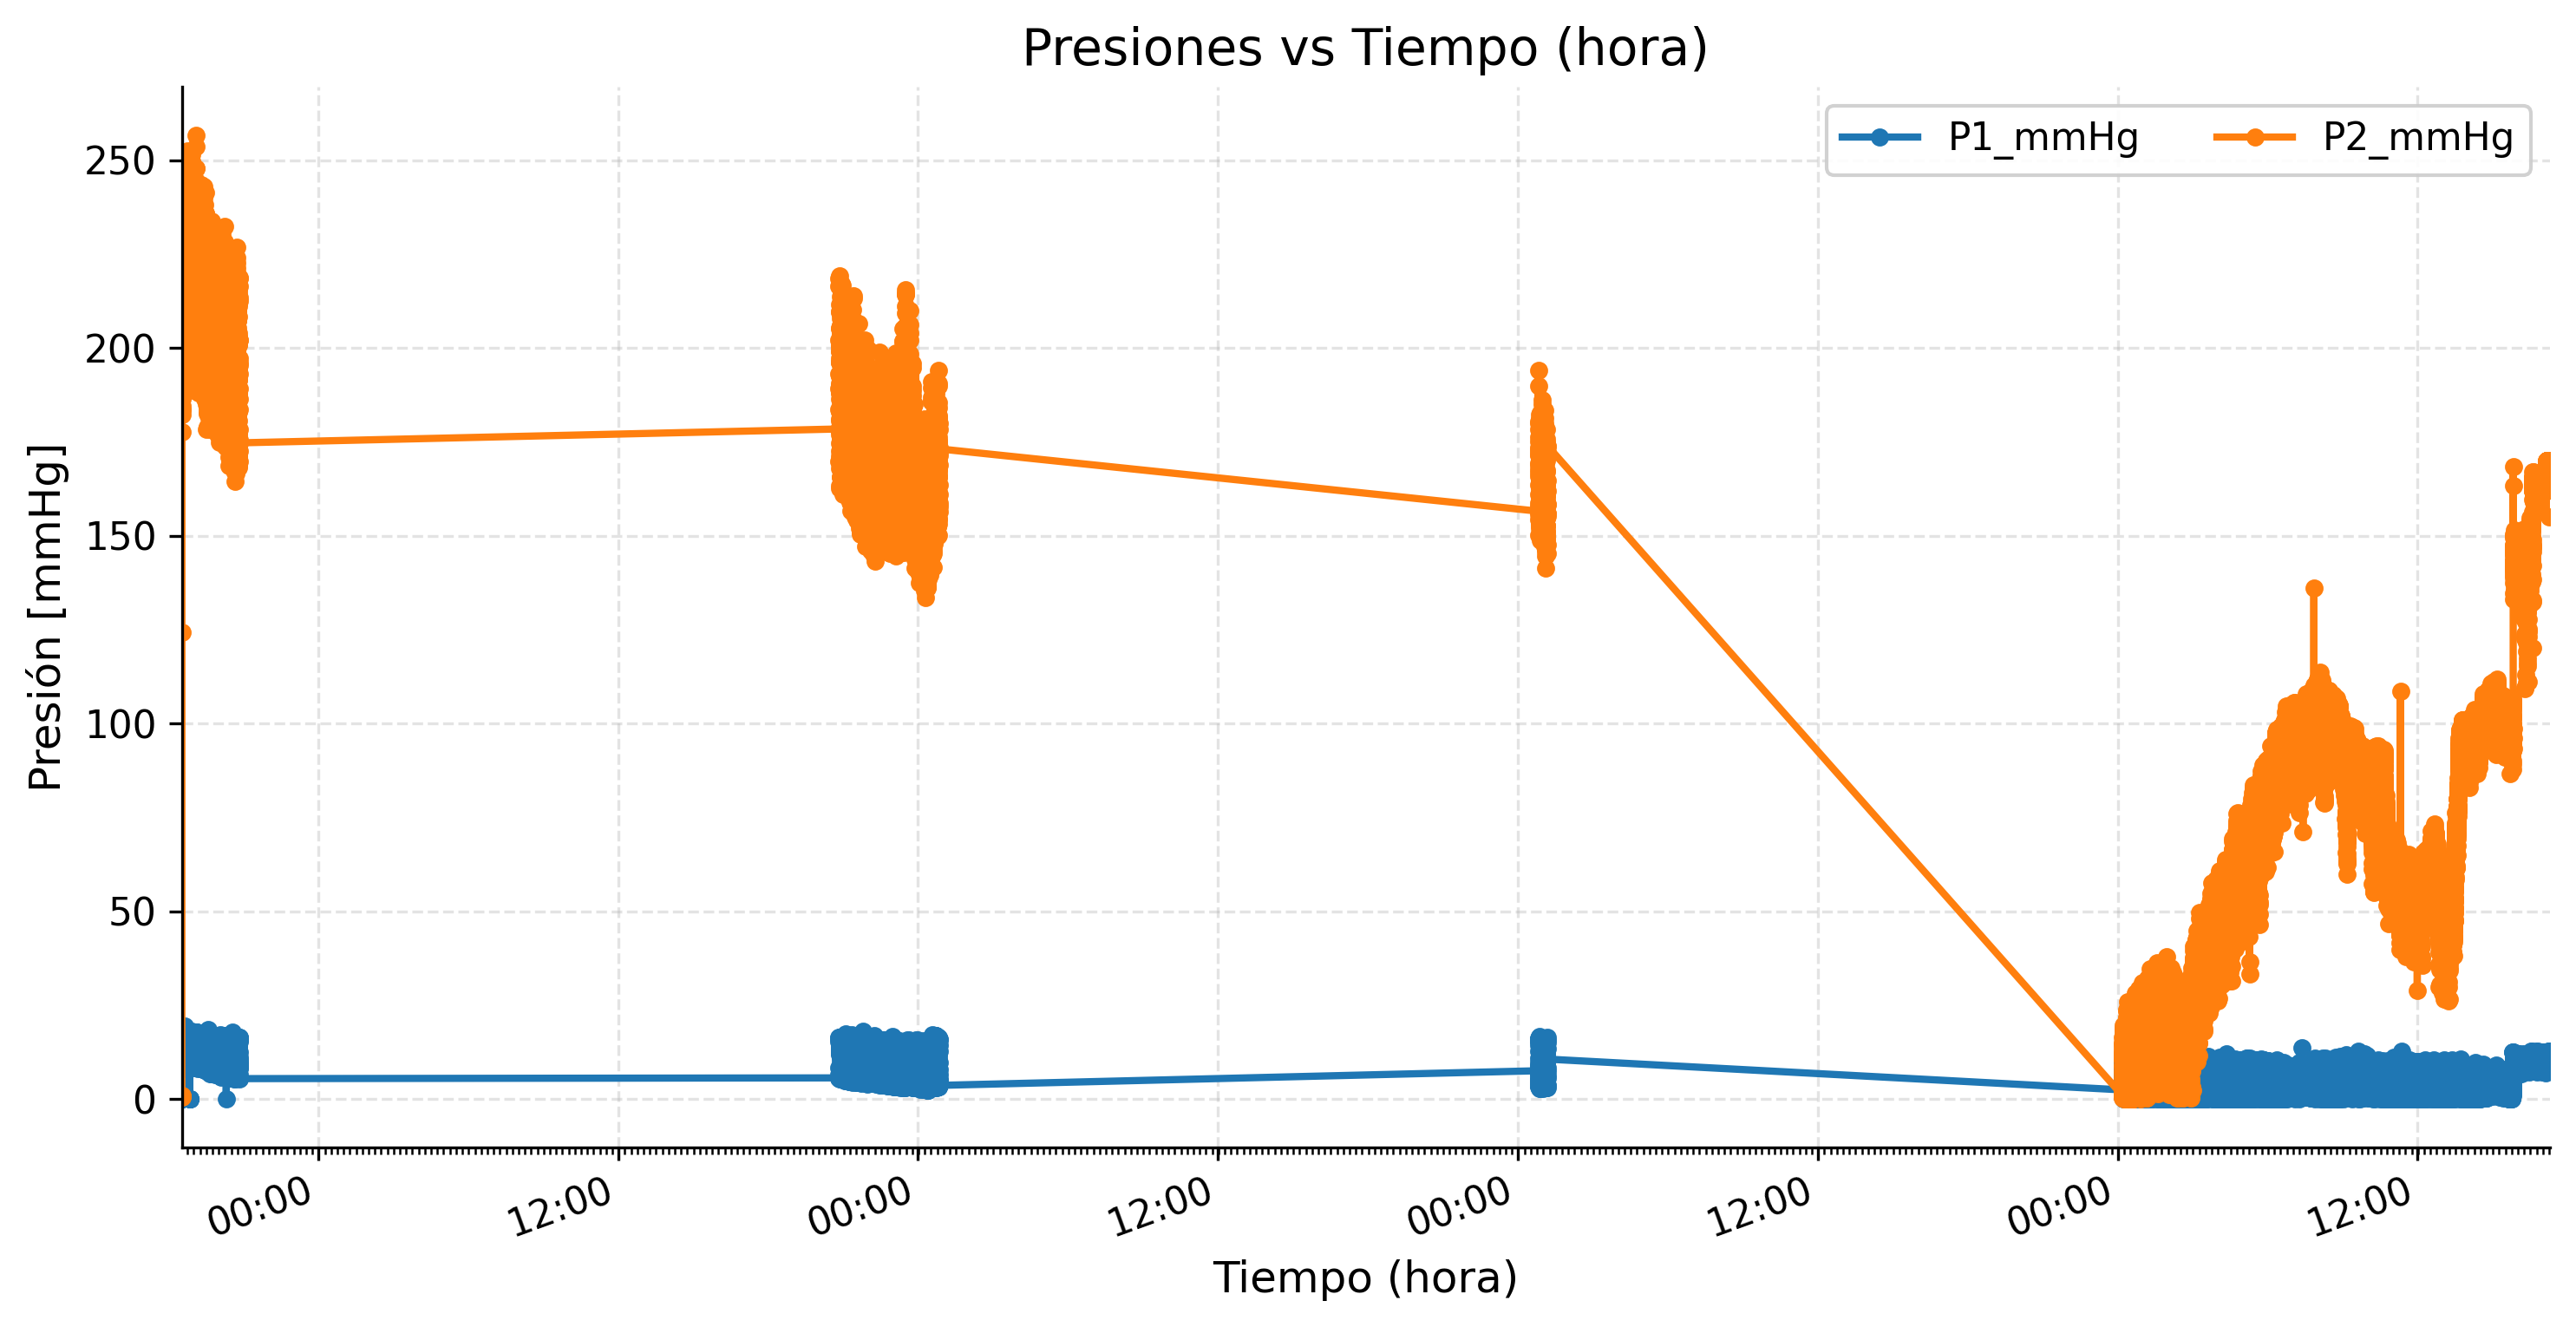

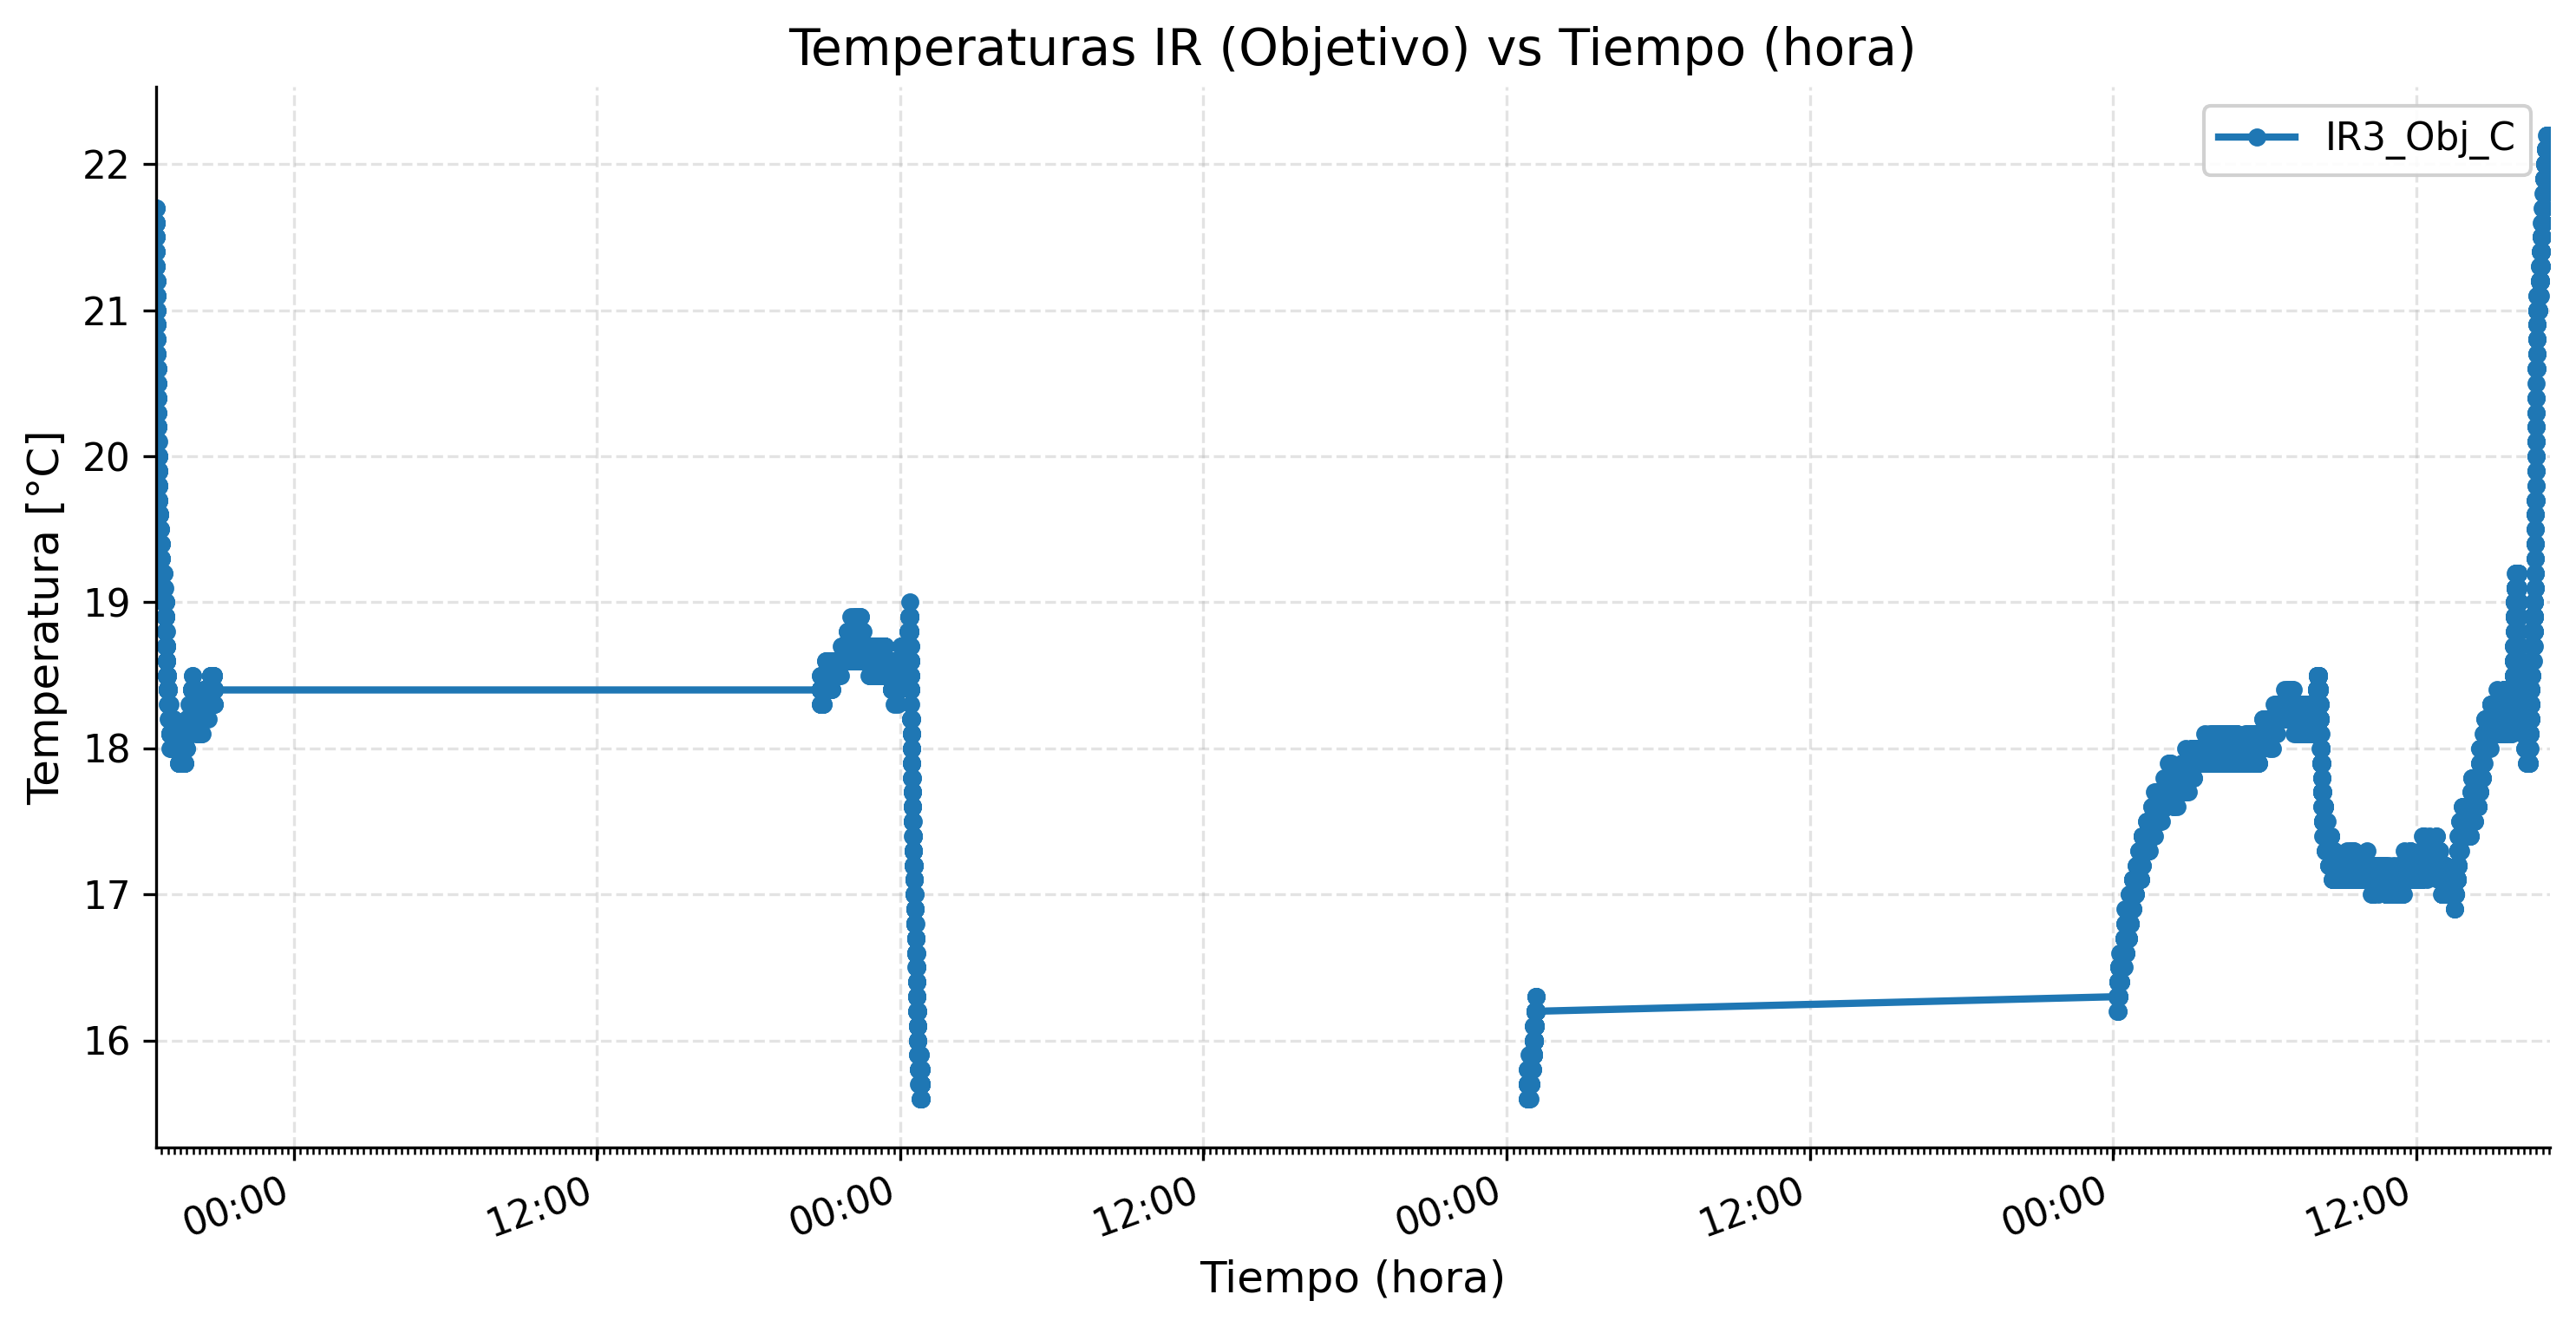

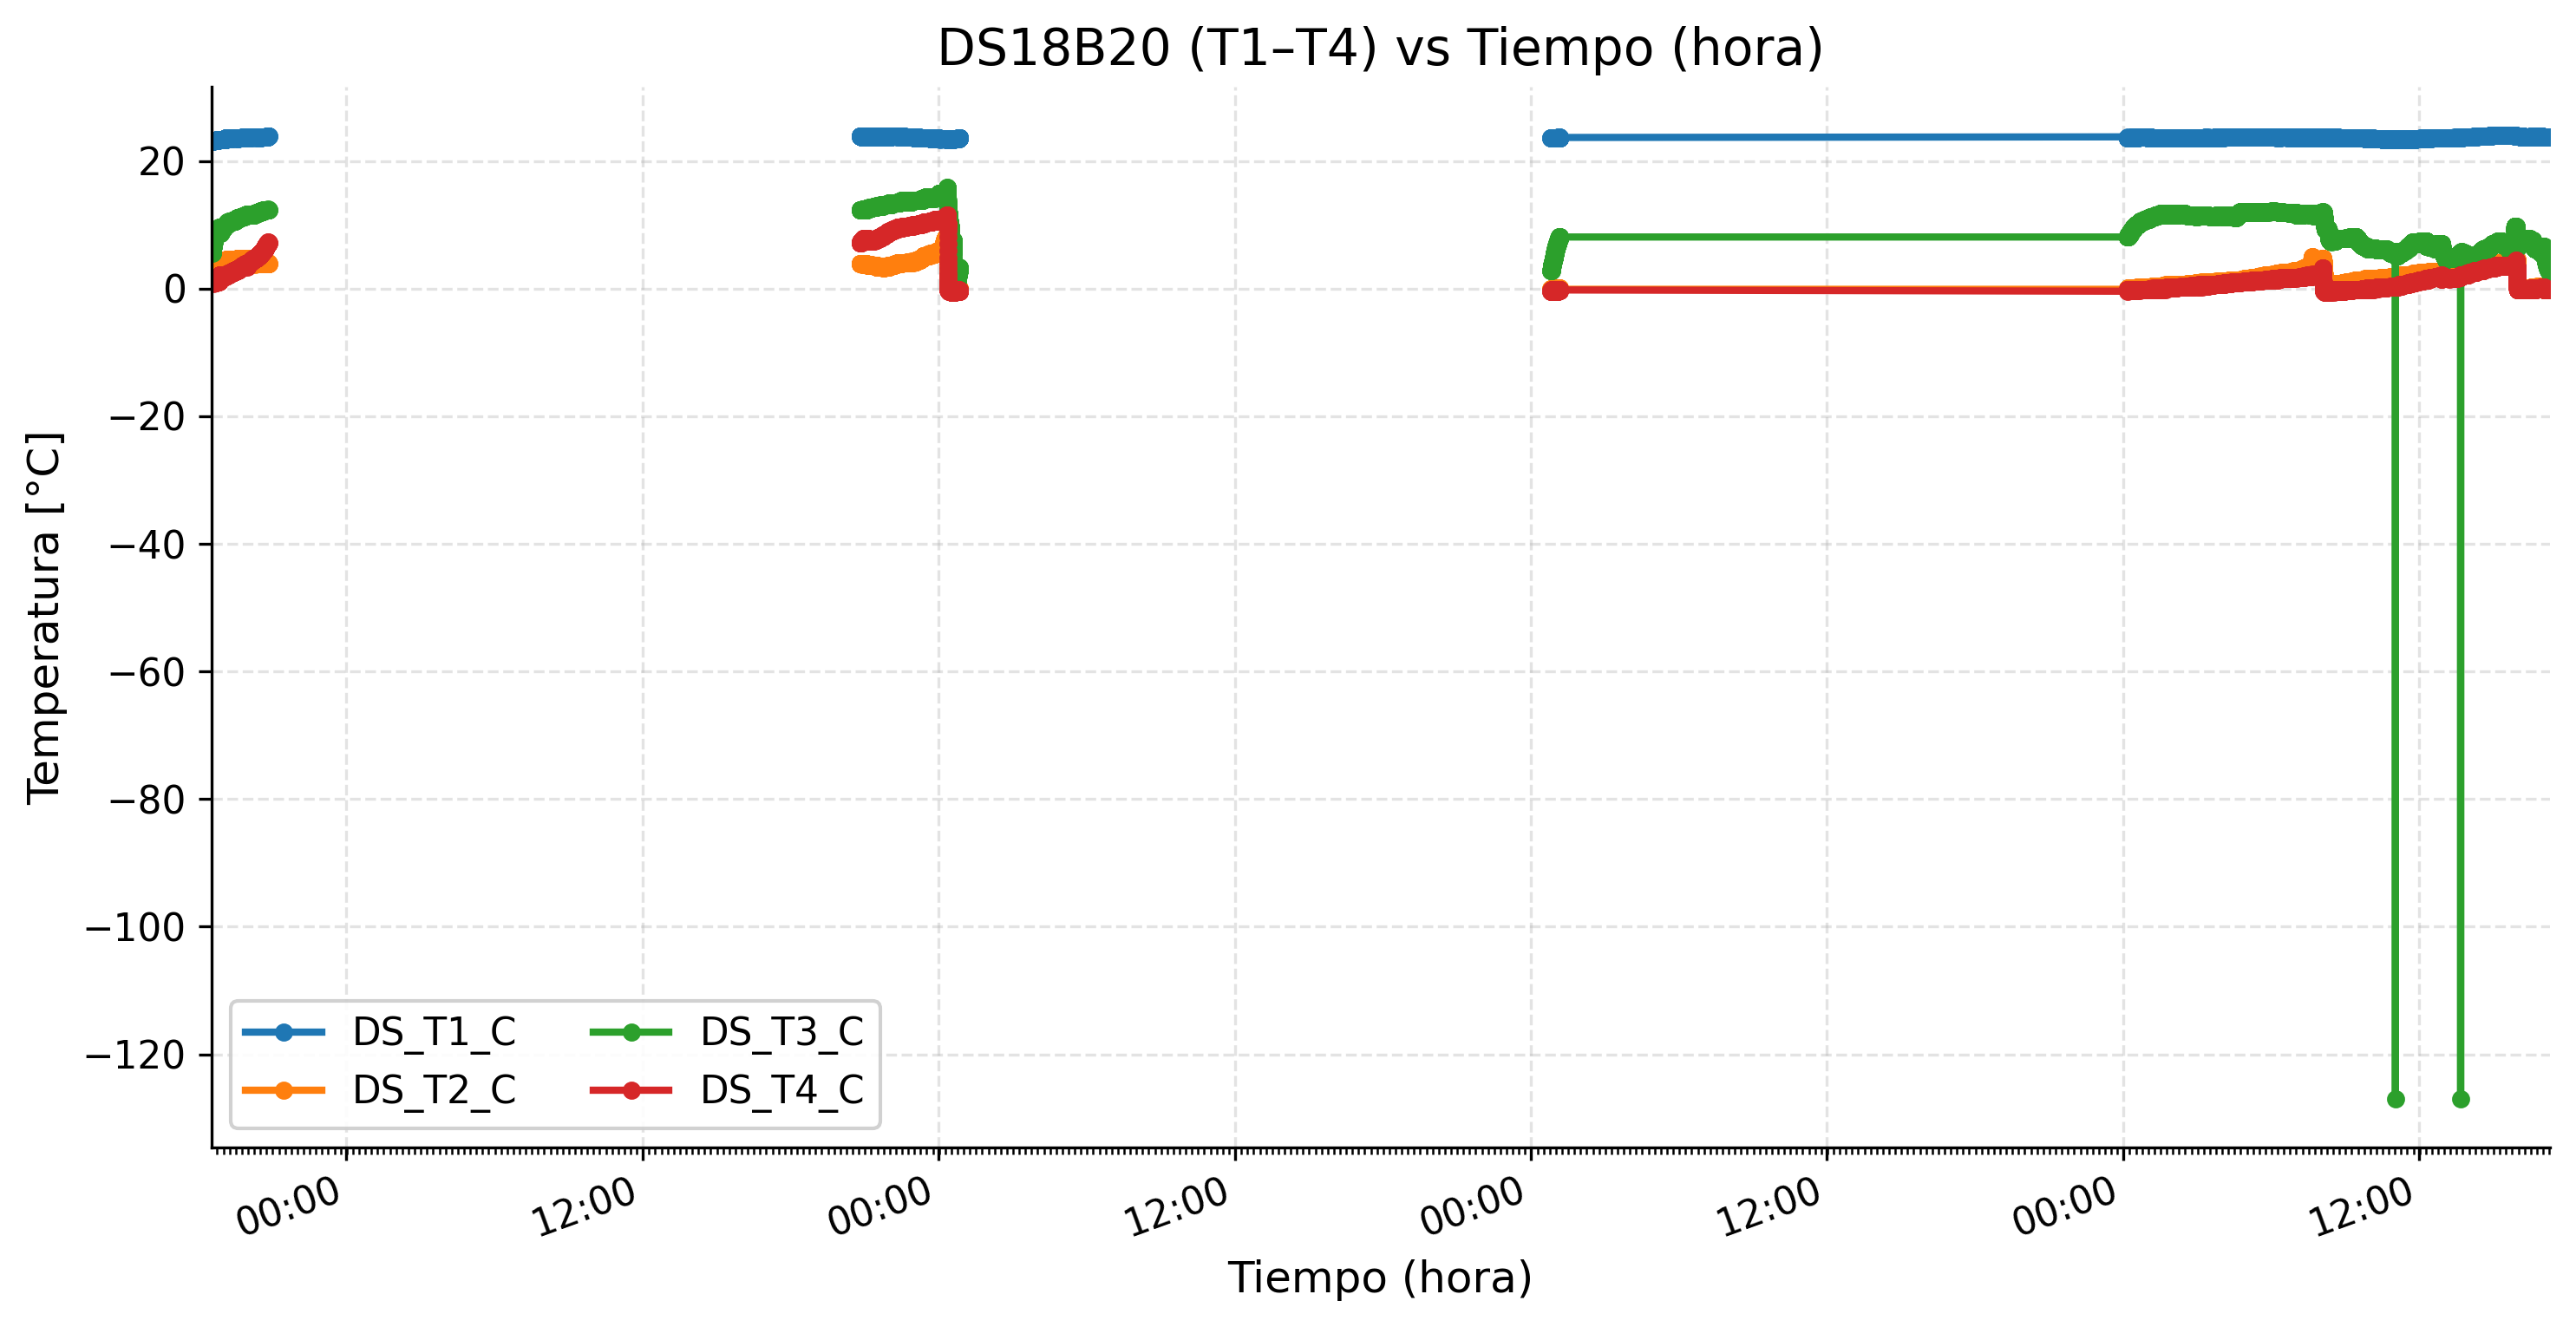

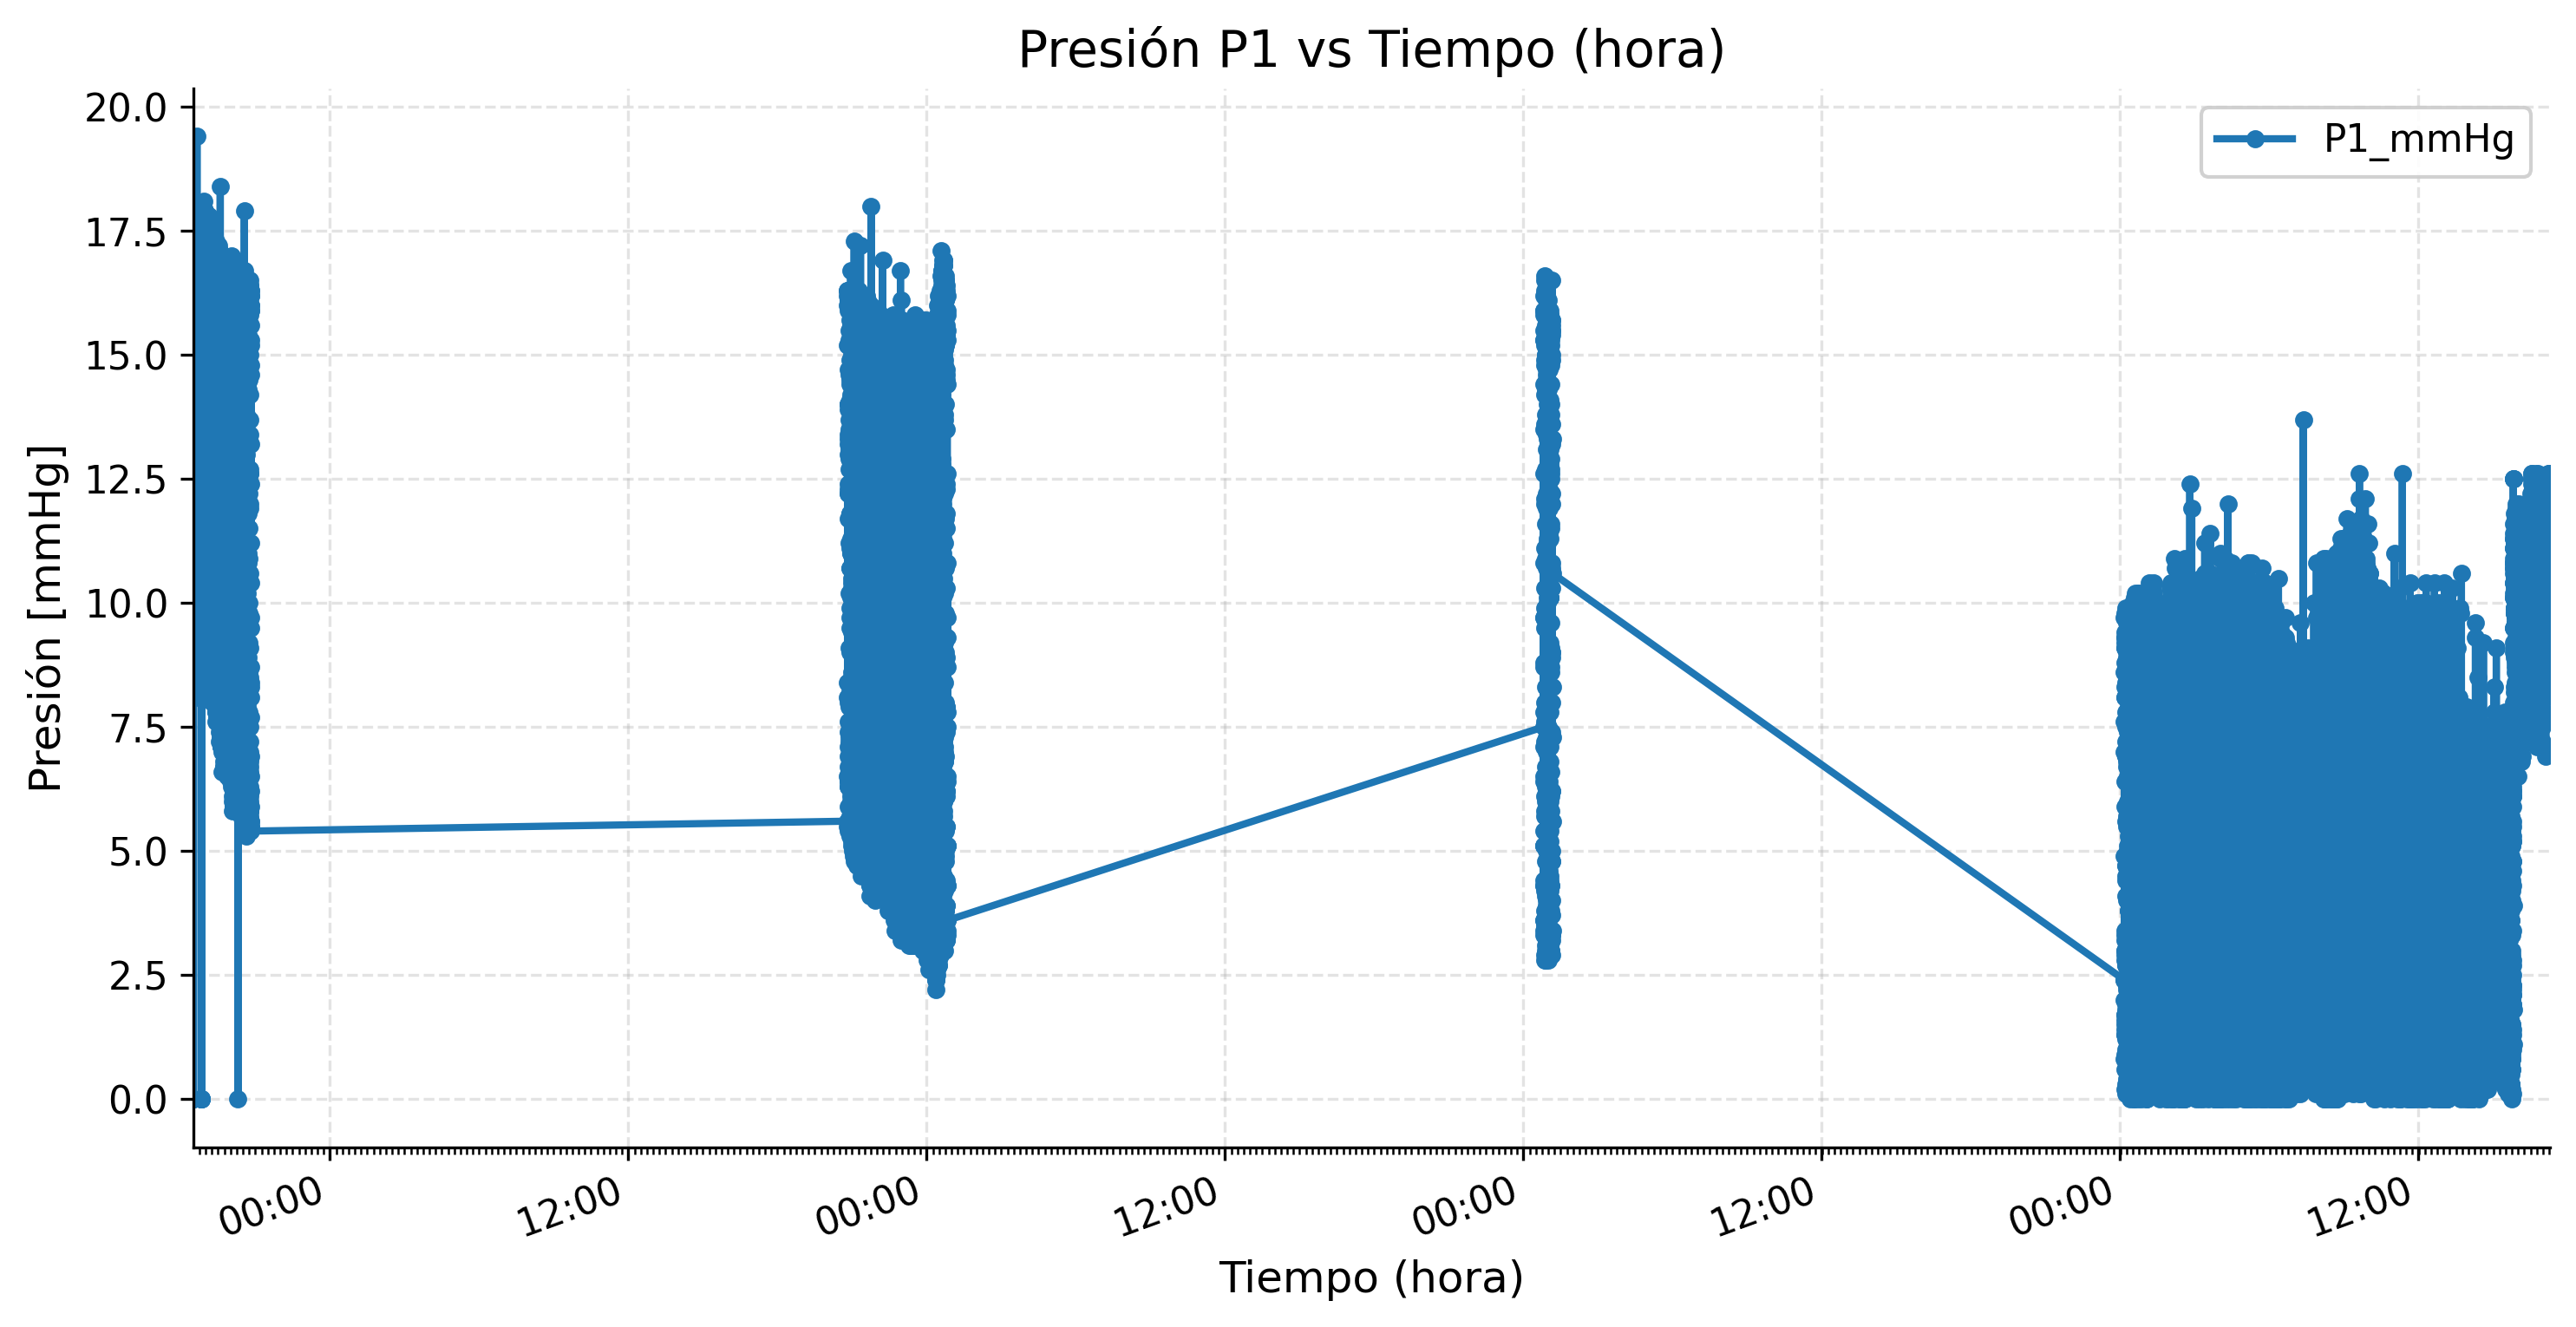

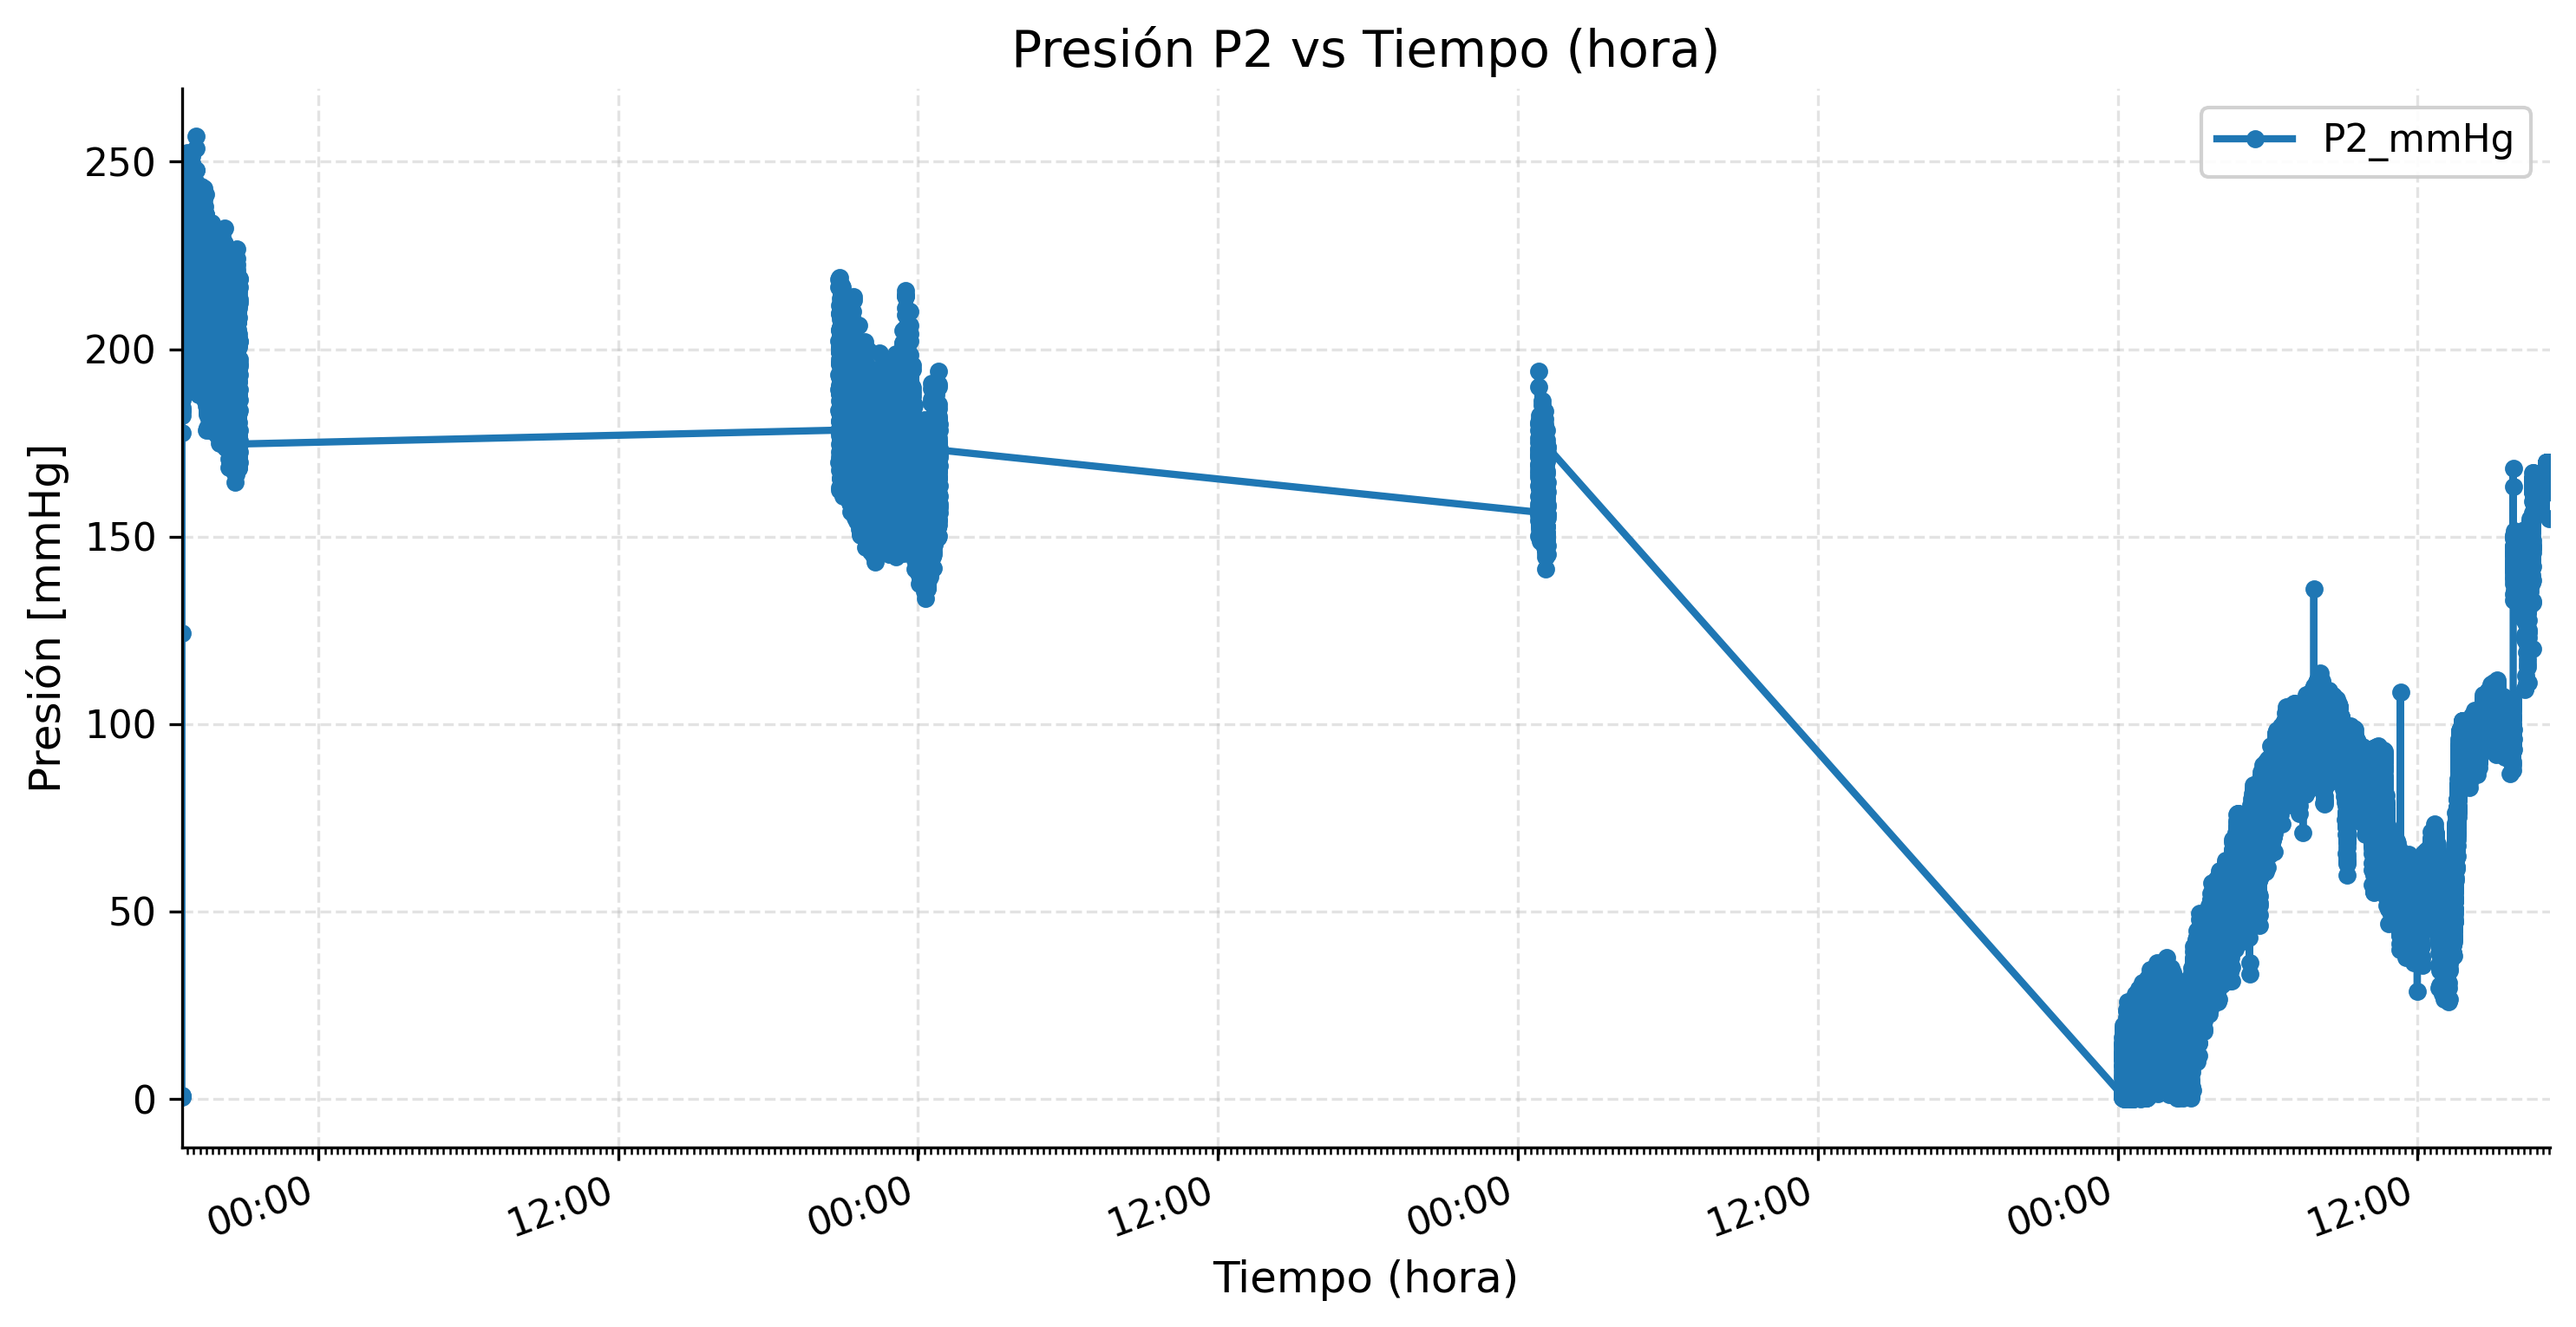

[AVISO] 'IR2_Obj_C' no tiene datos numéricos válidos.


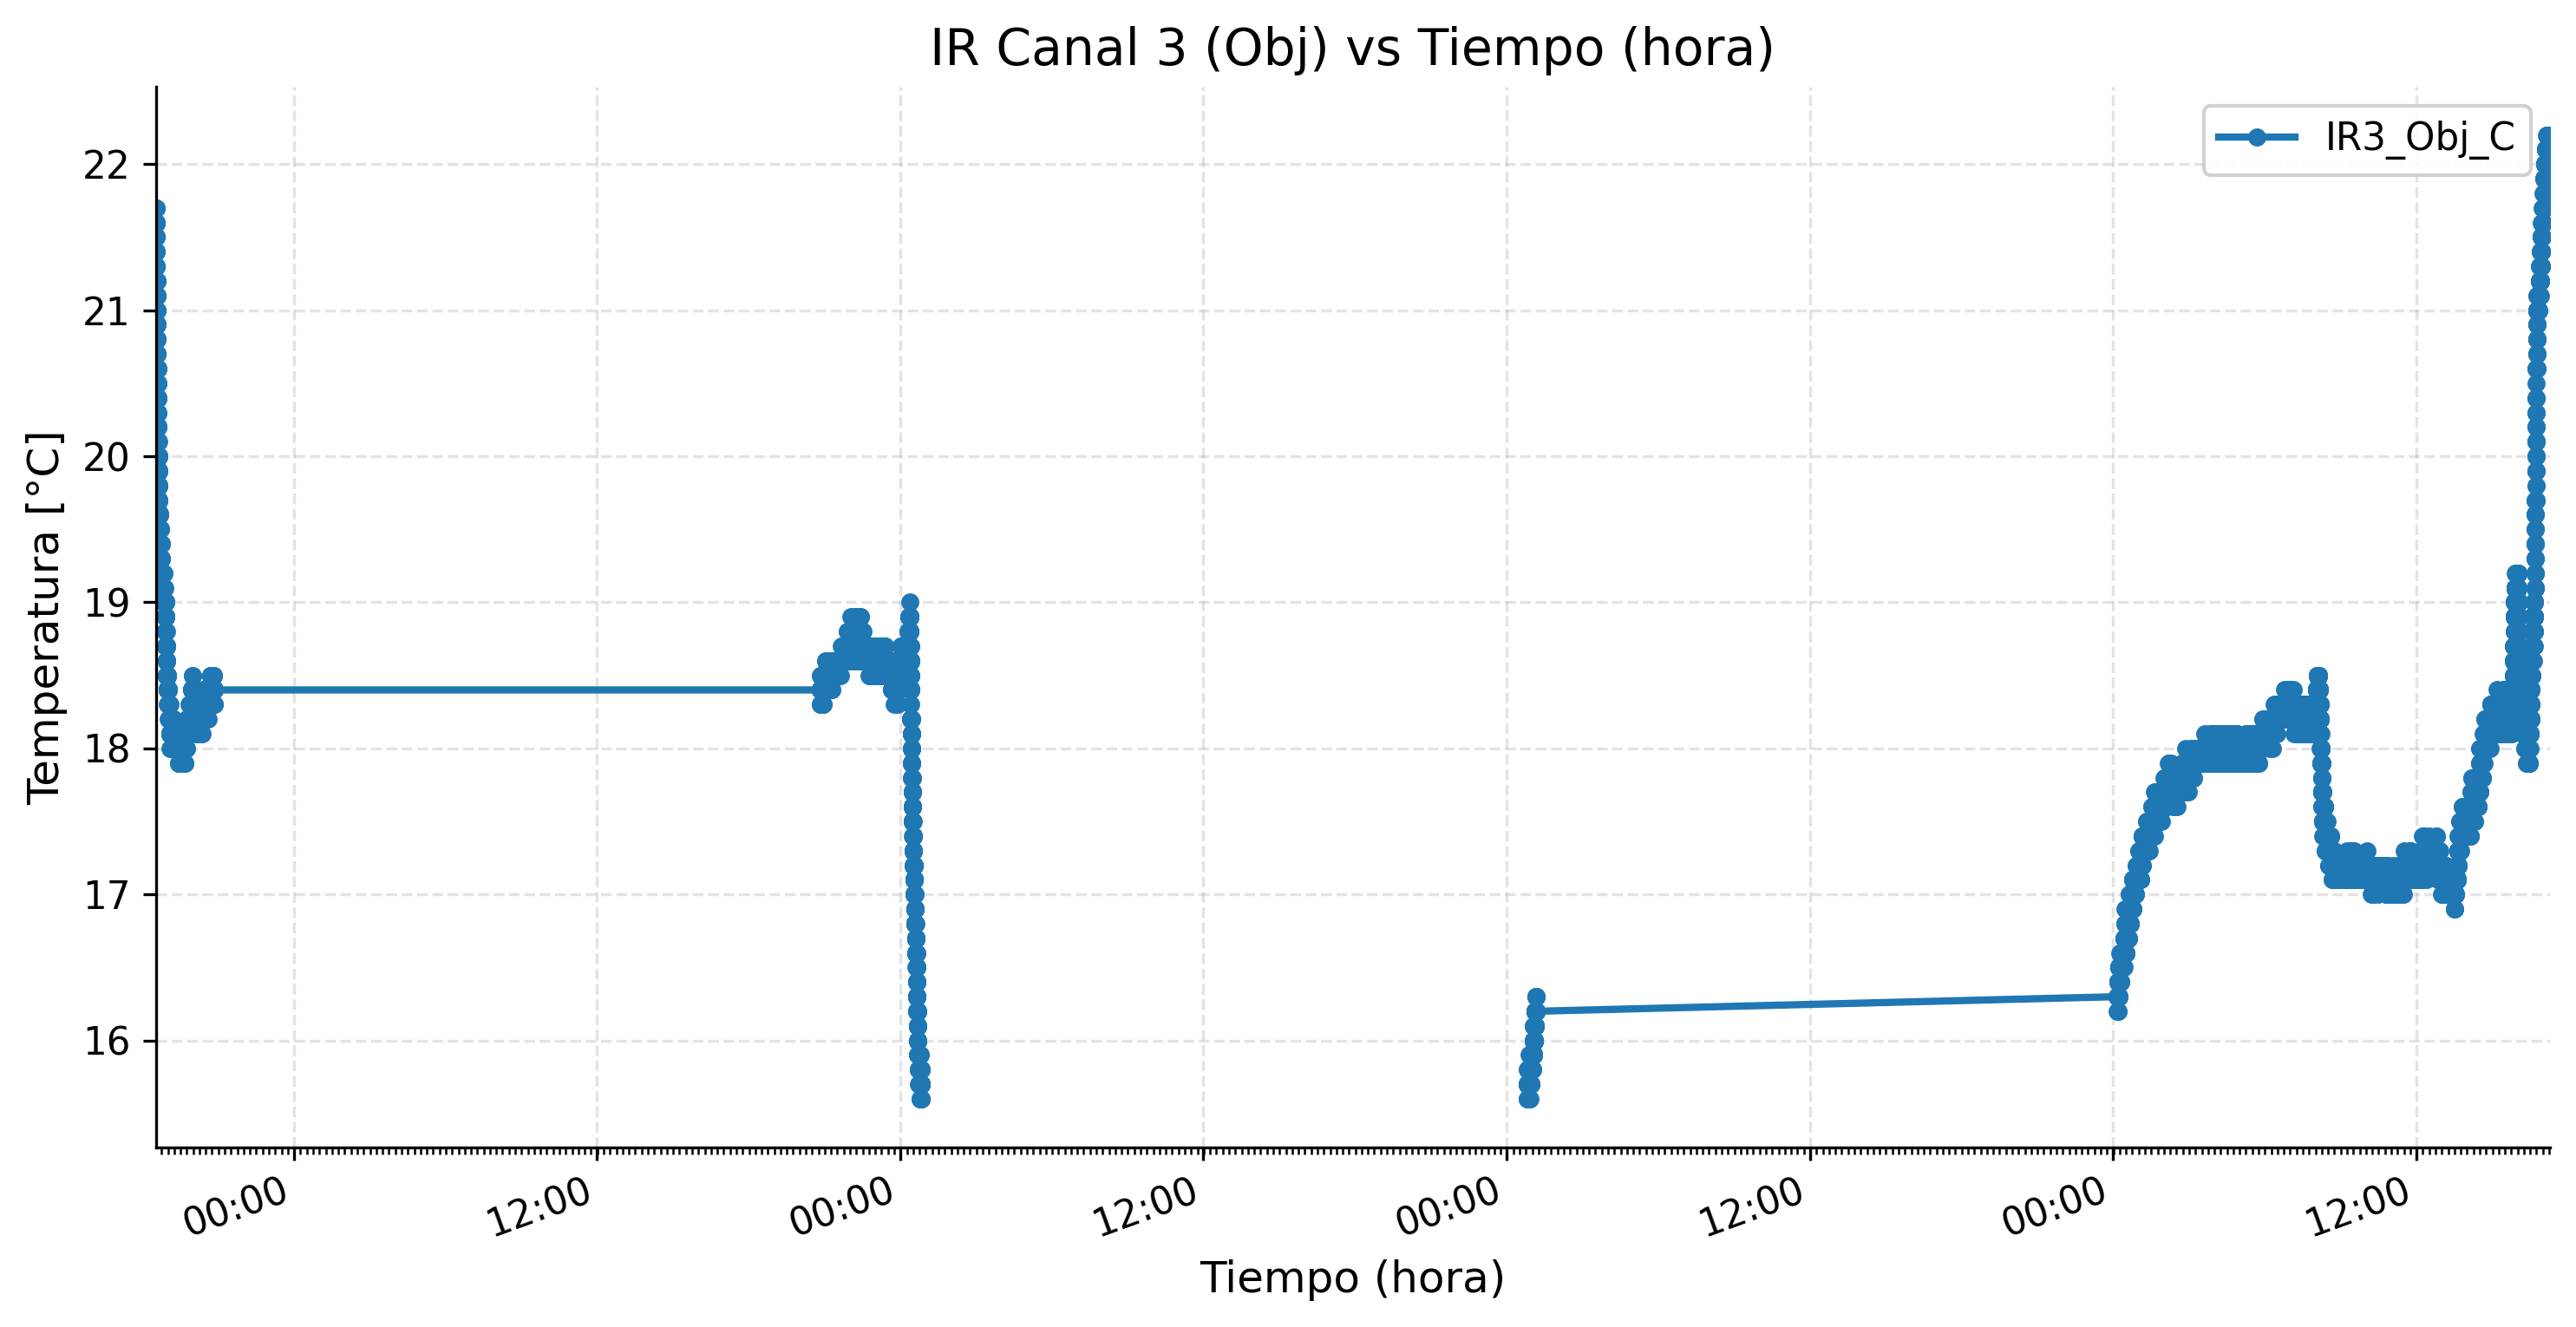

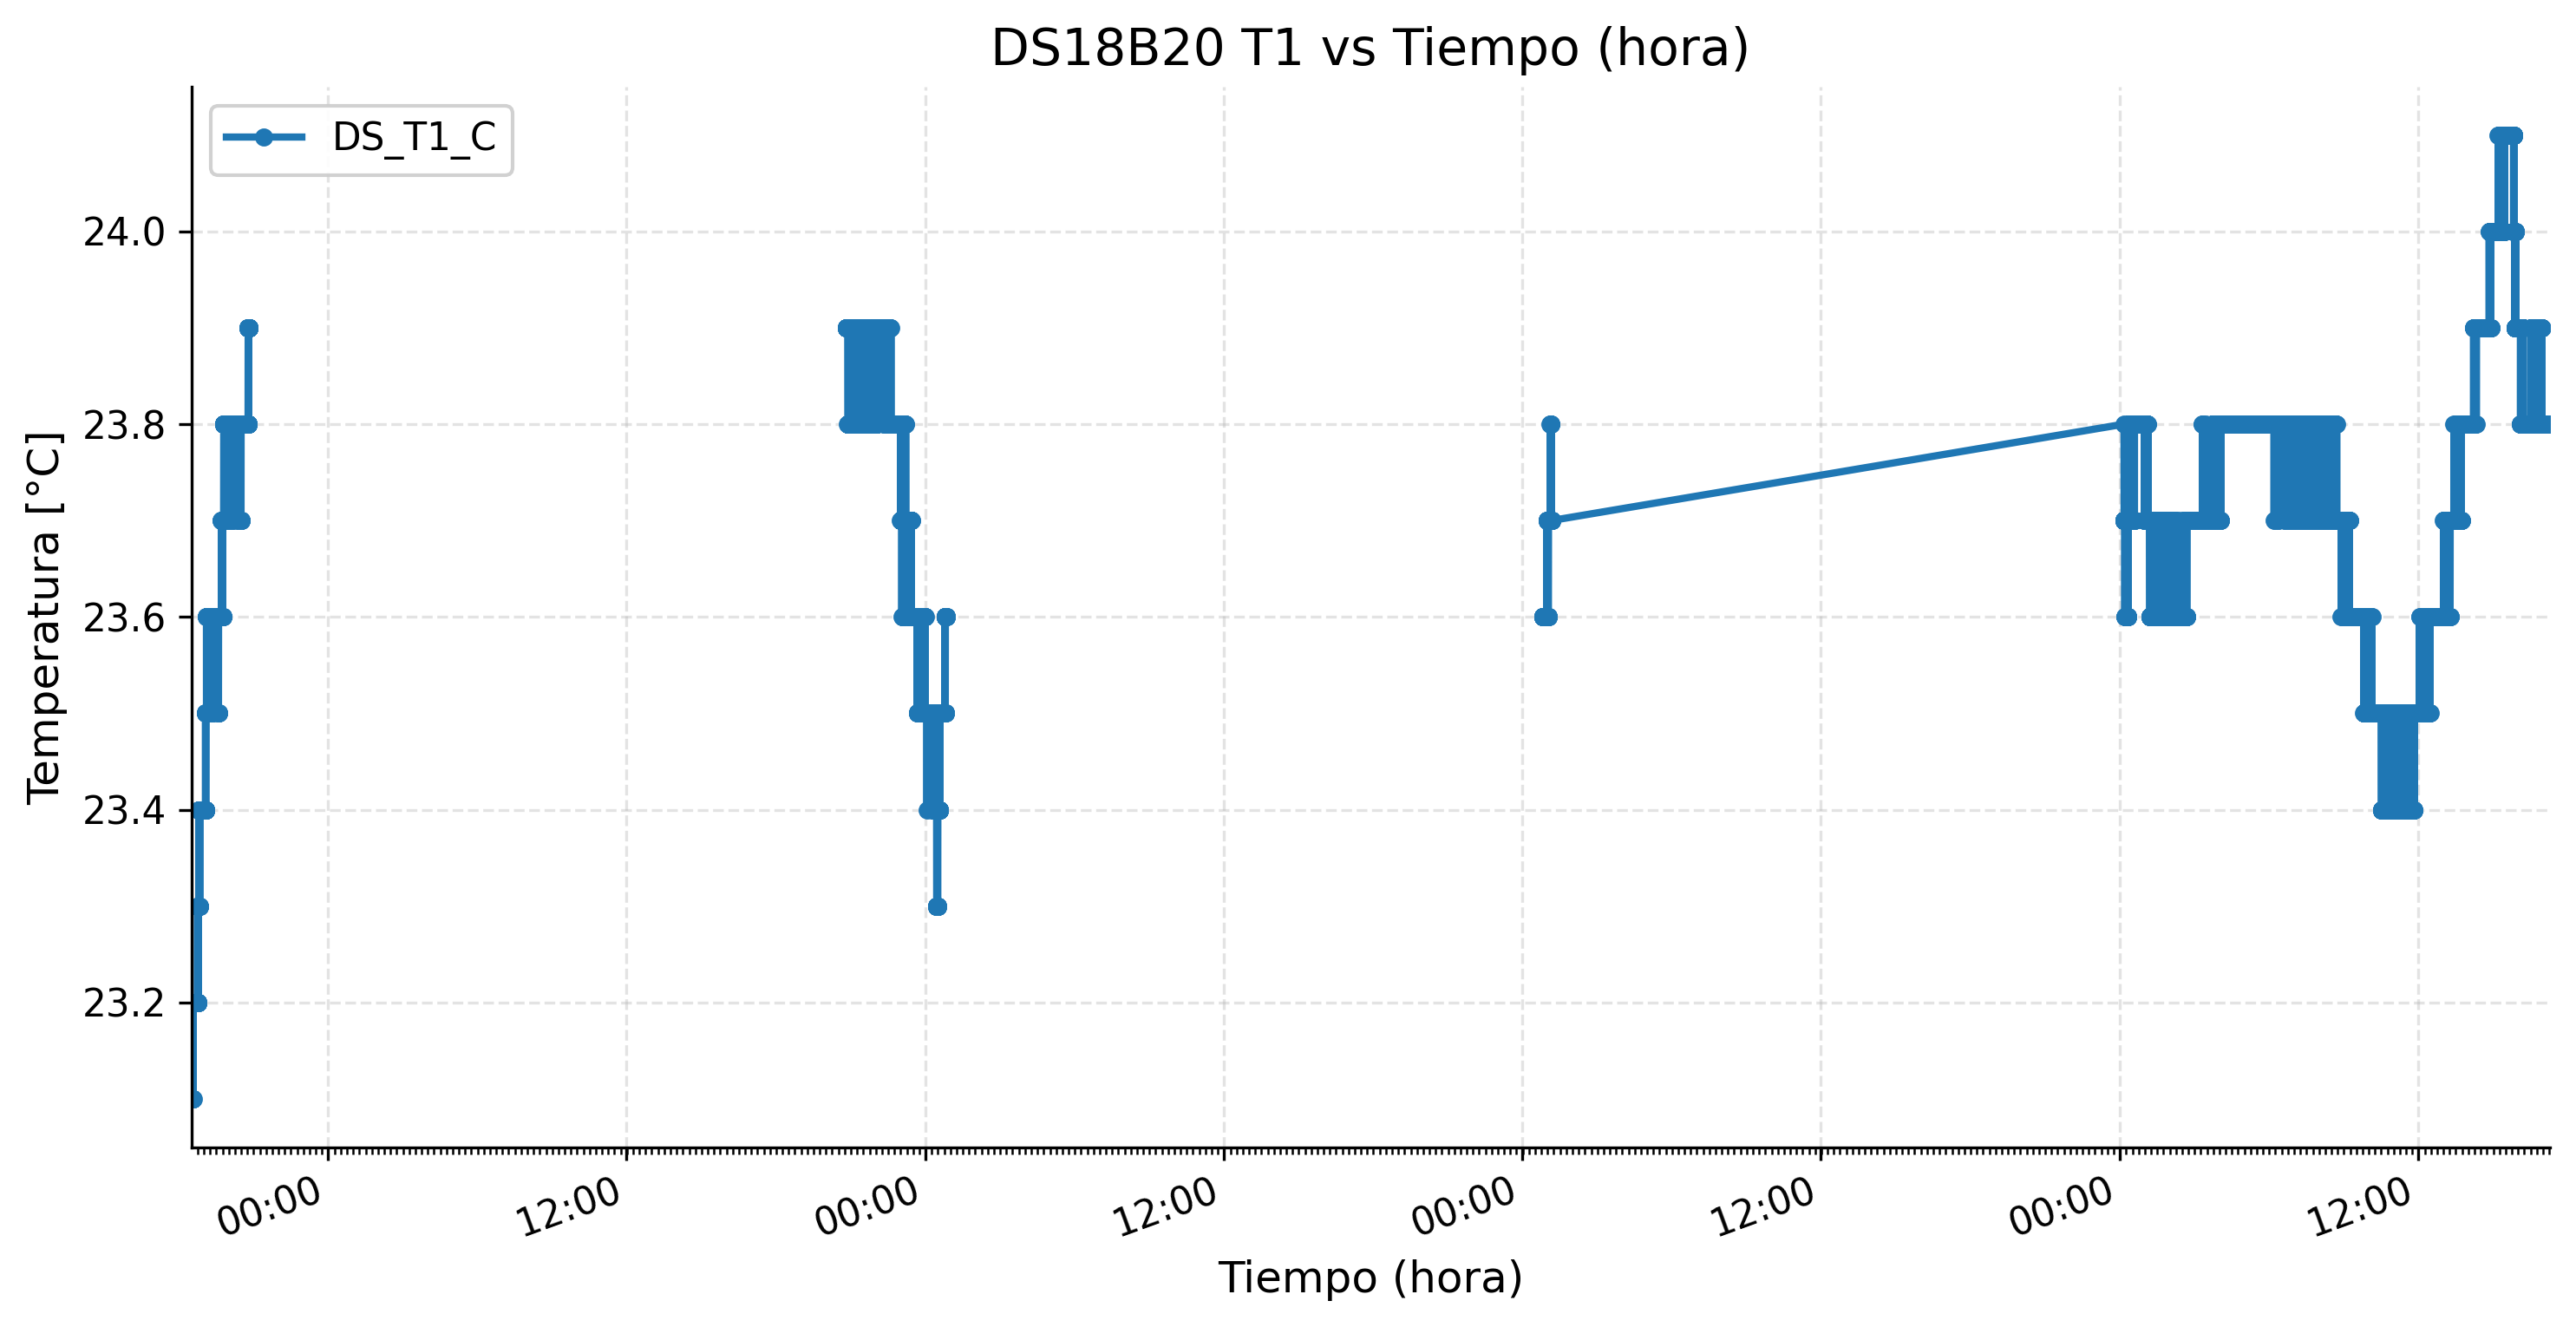

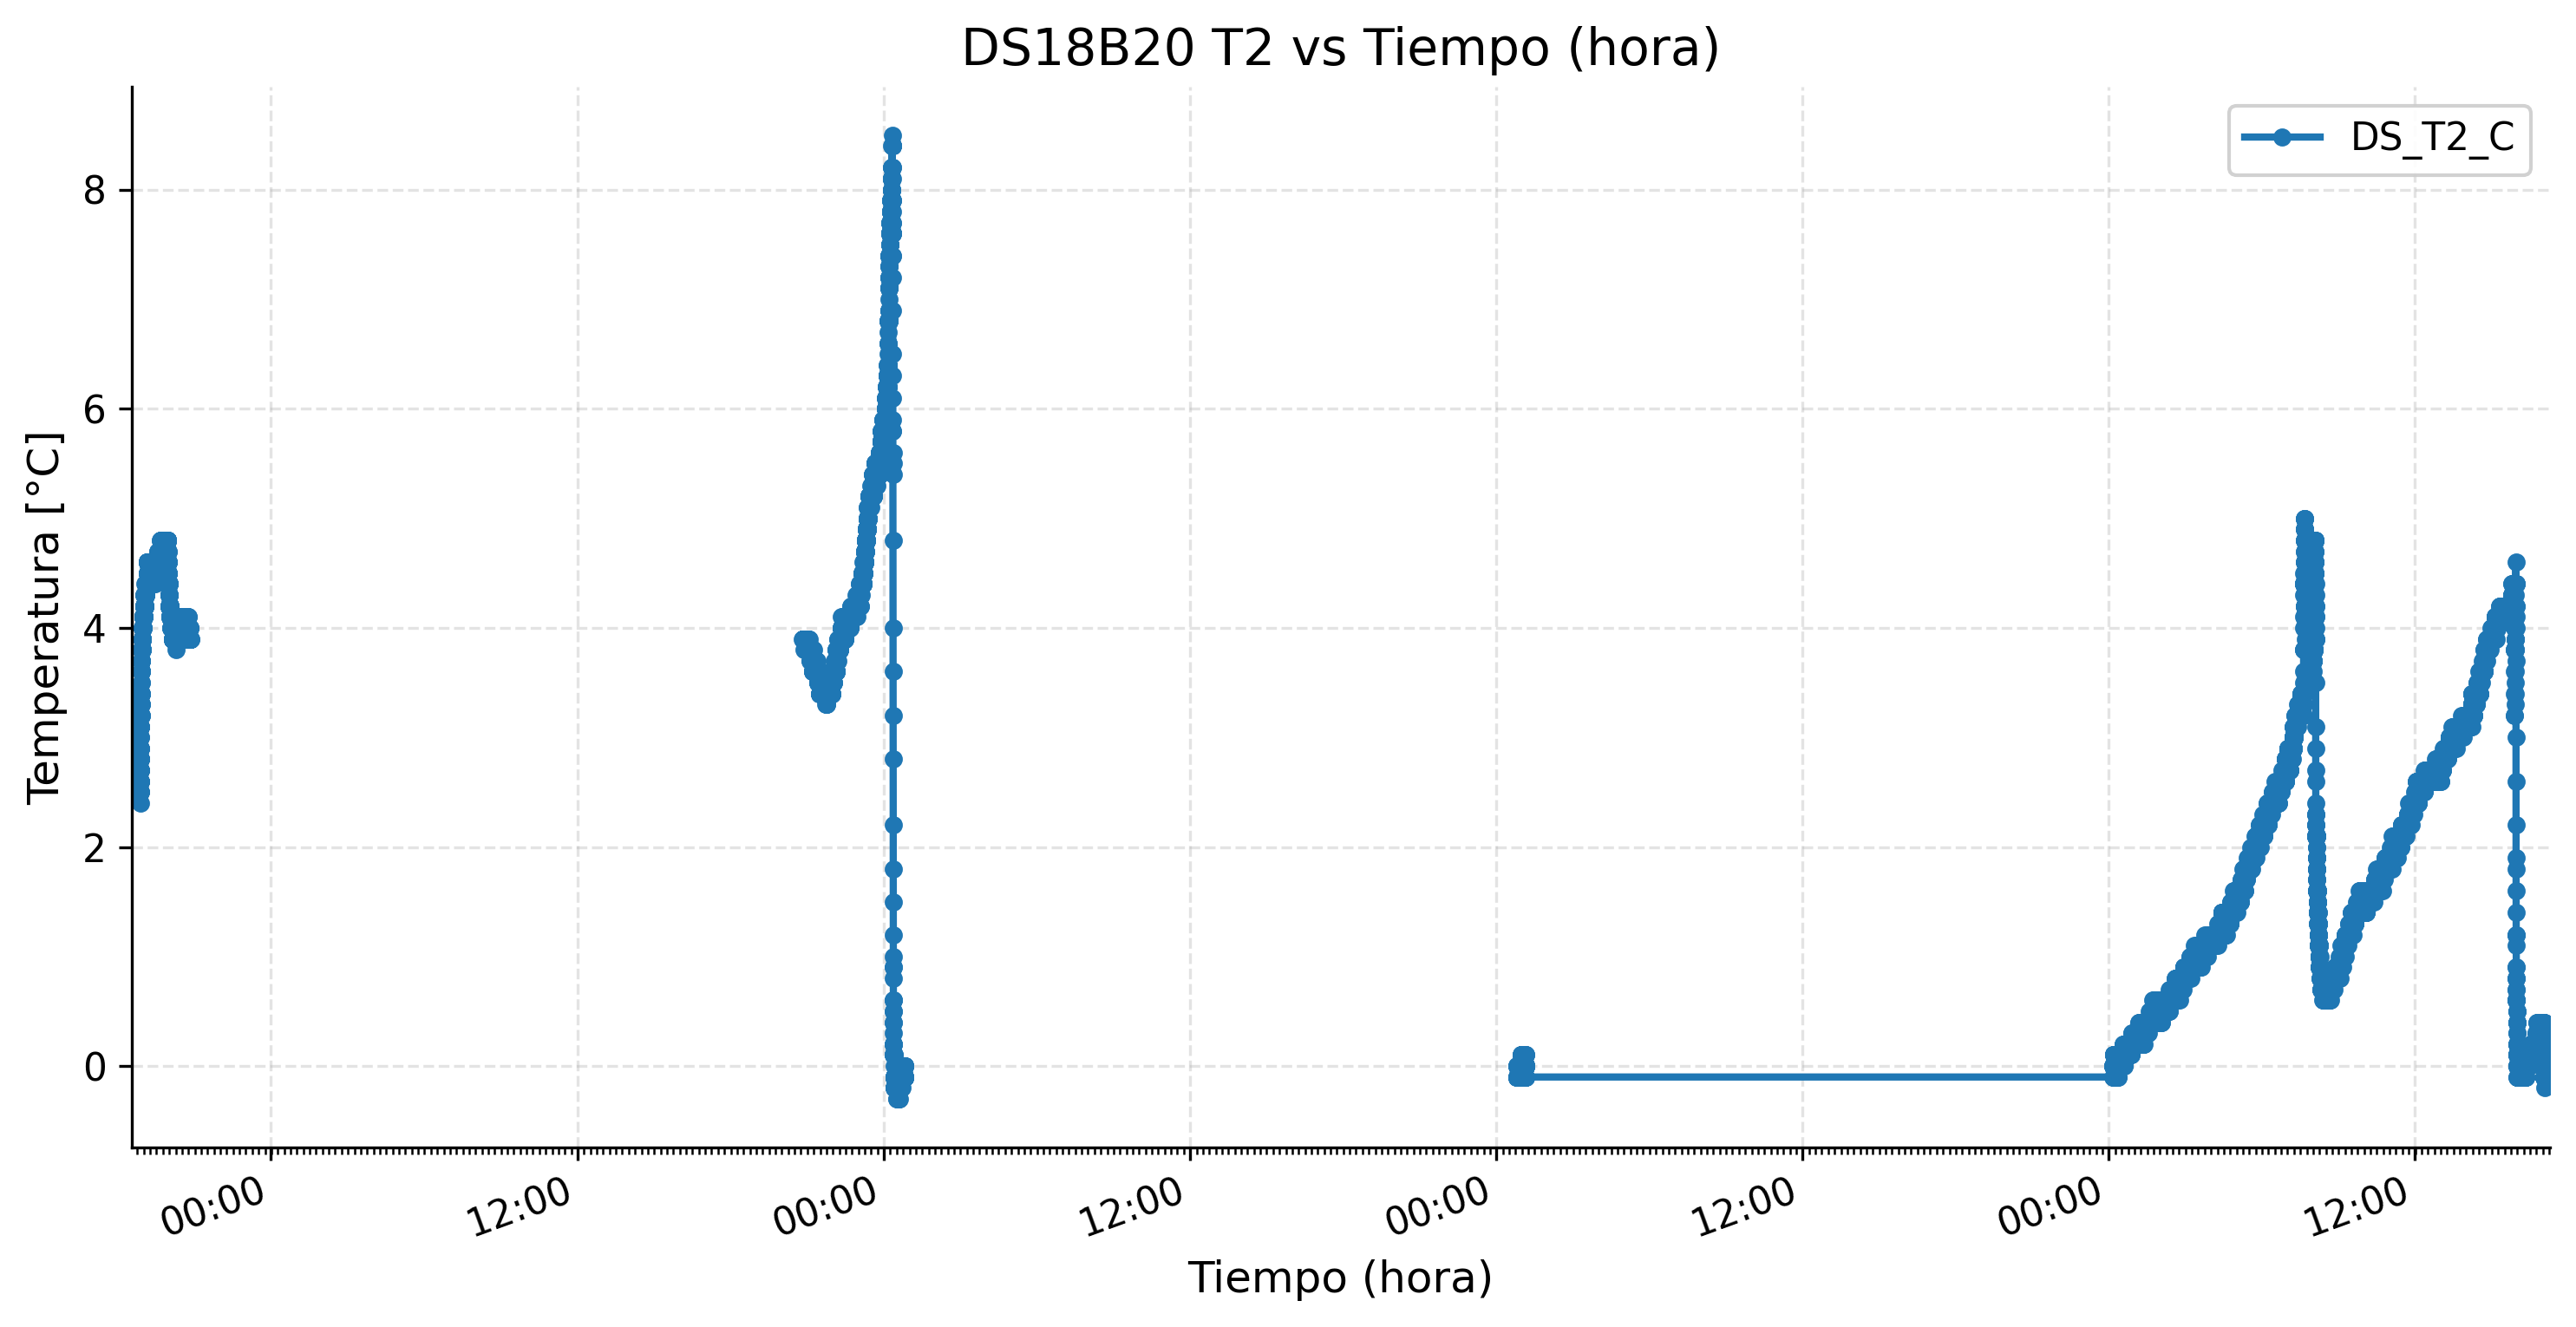

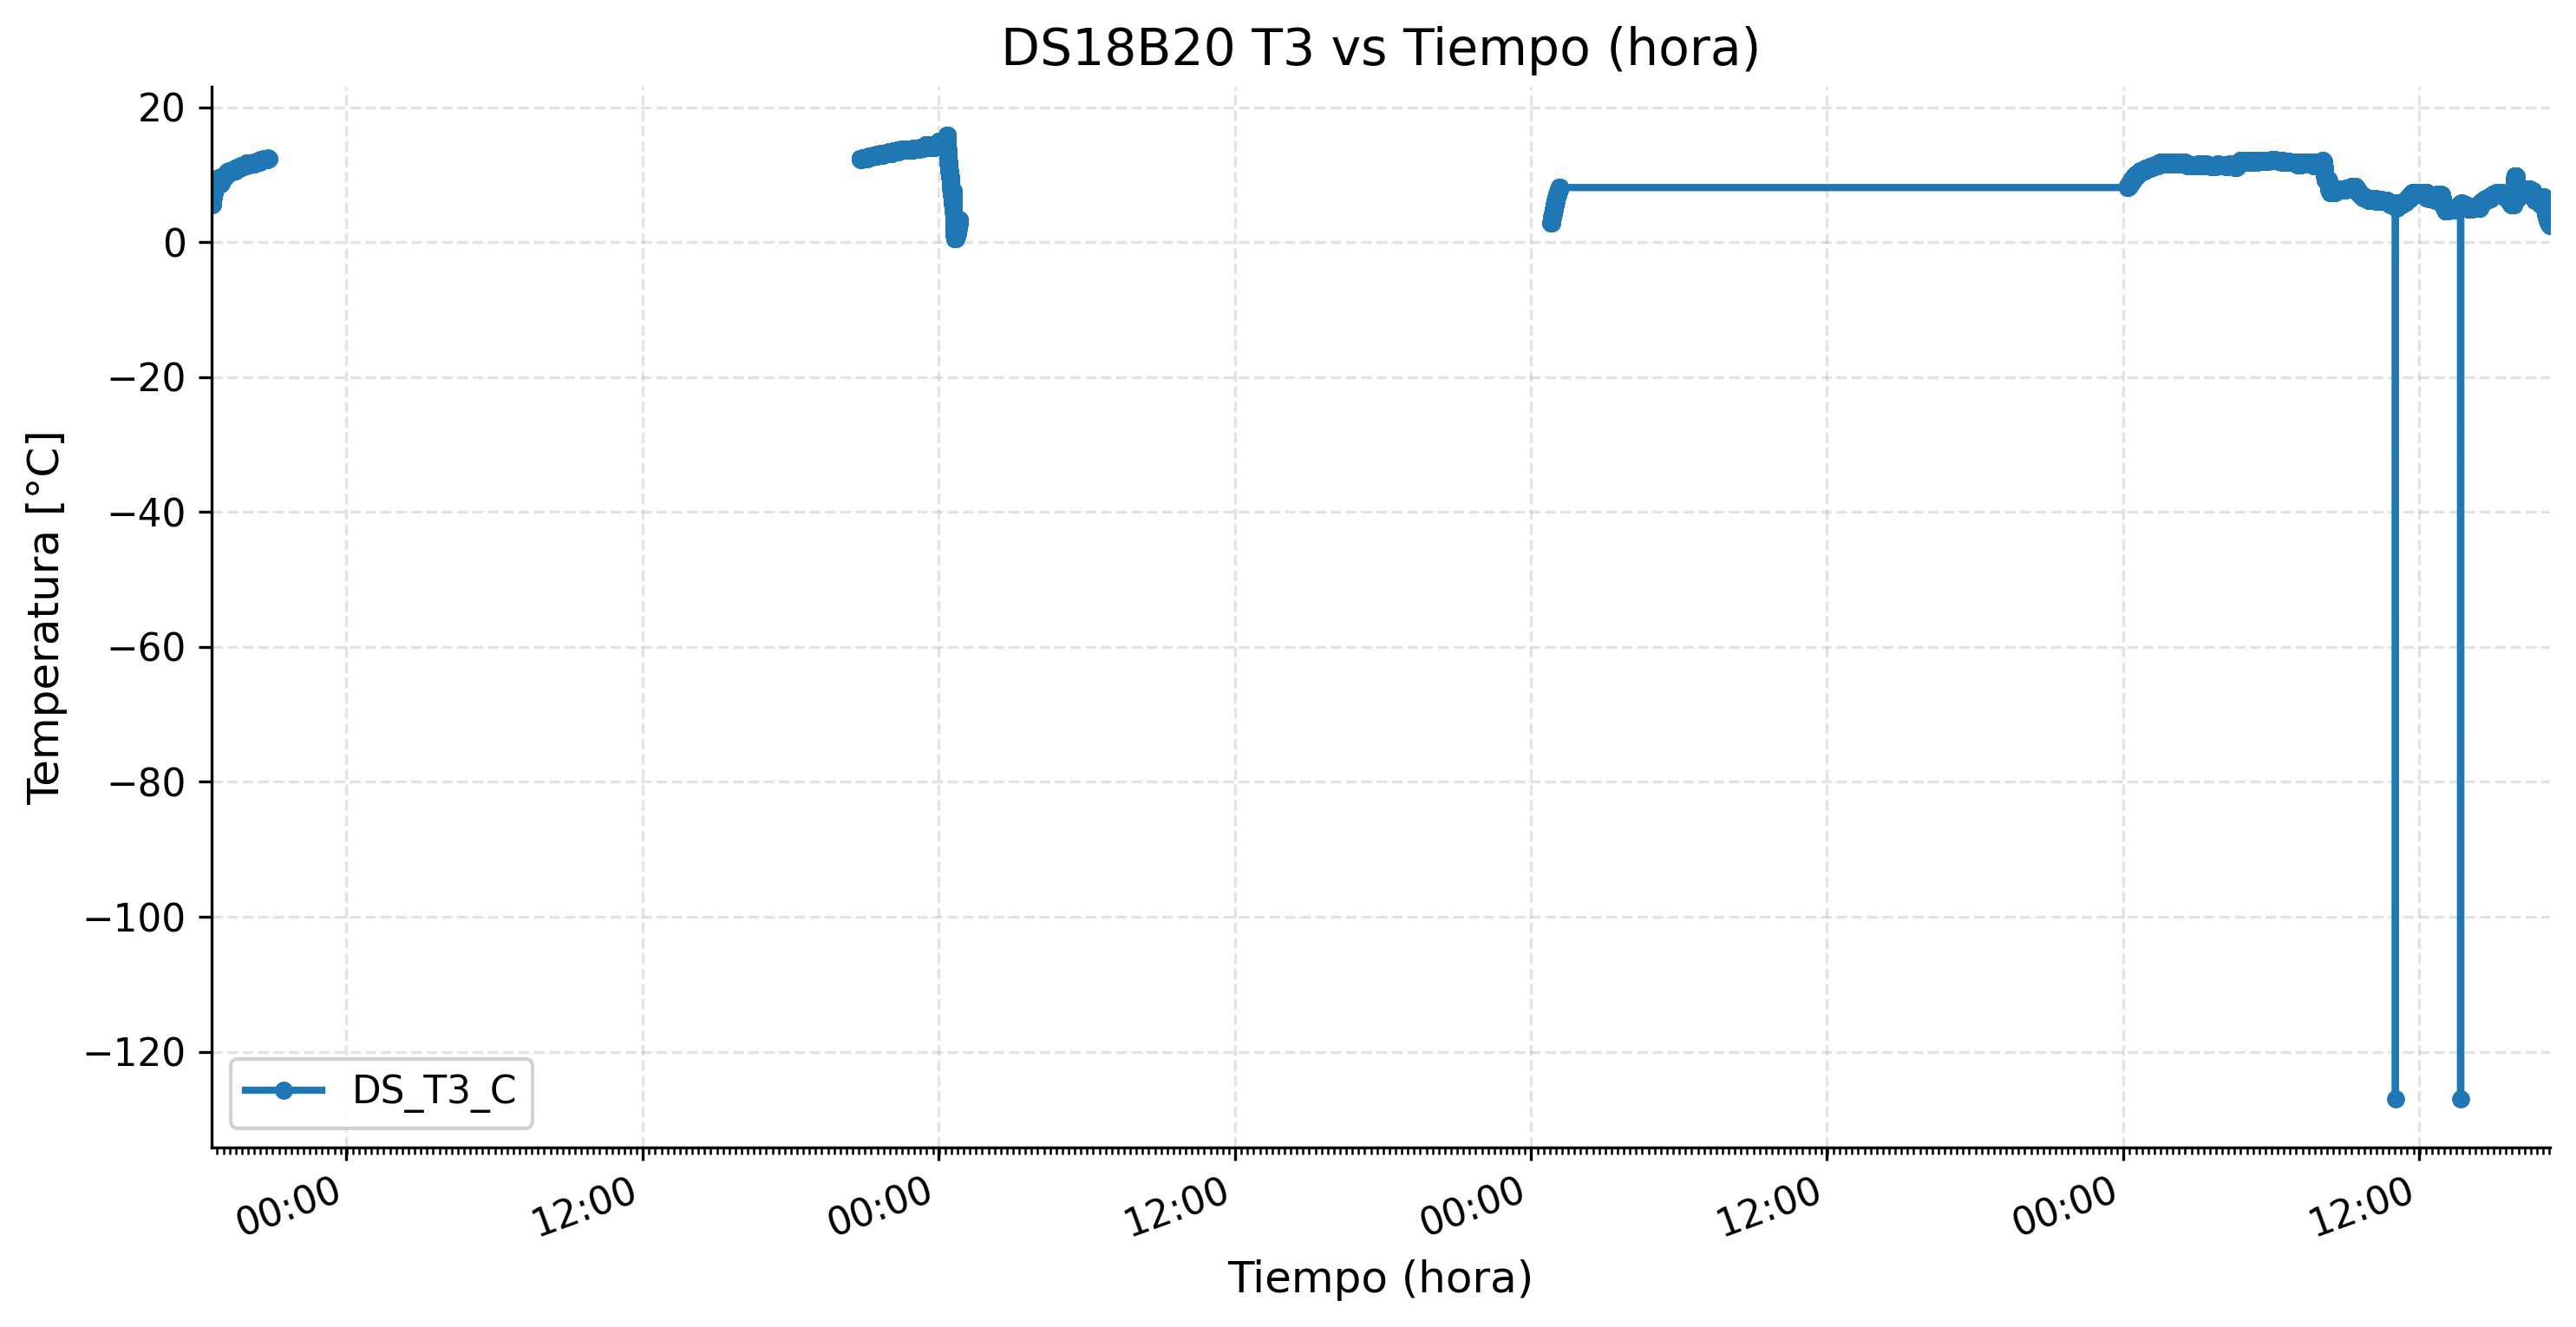

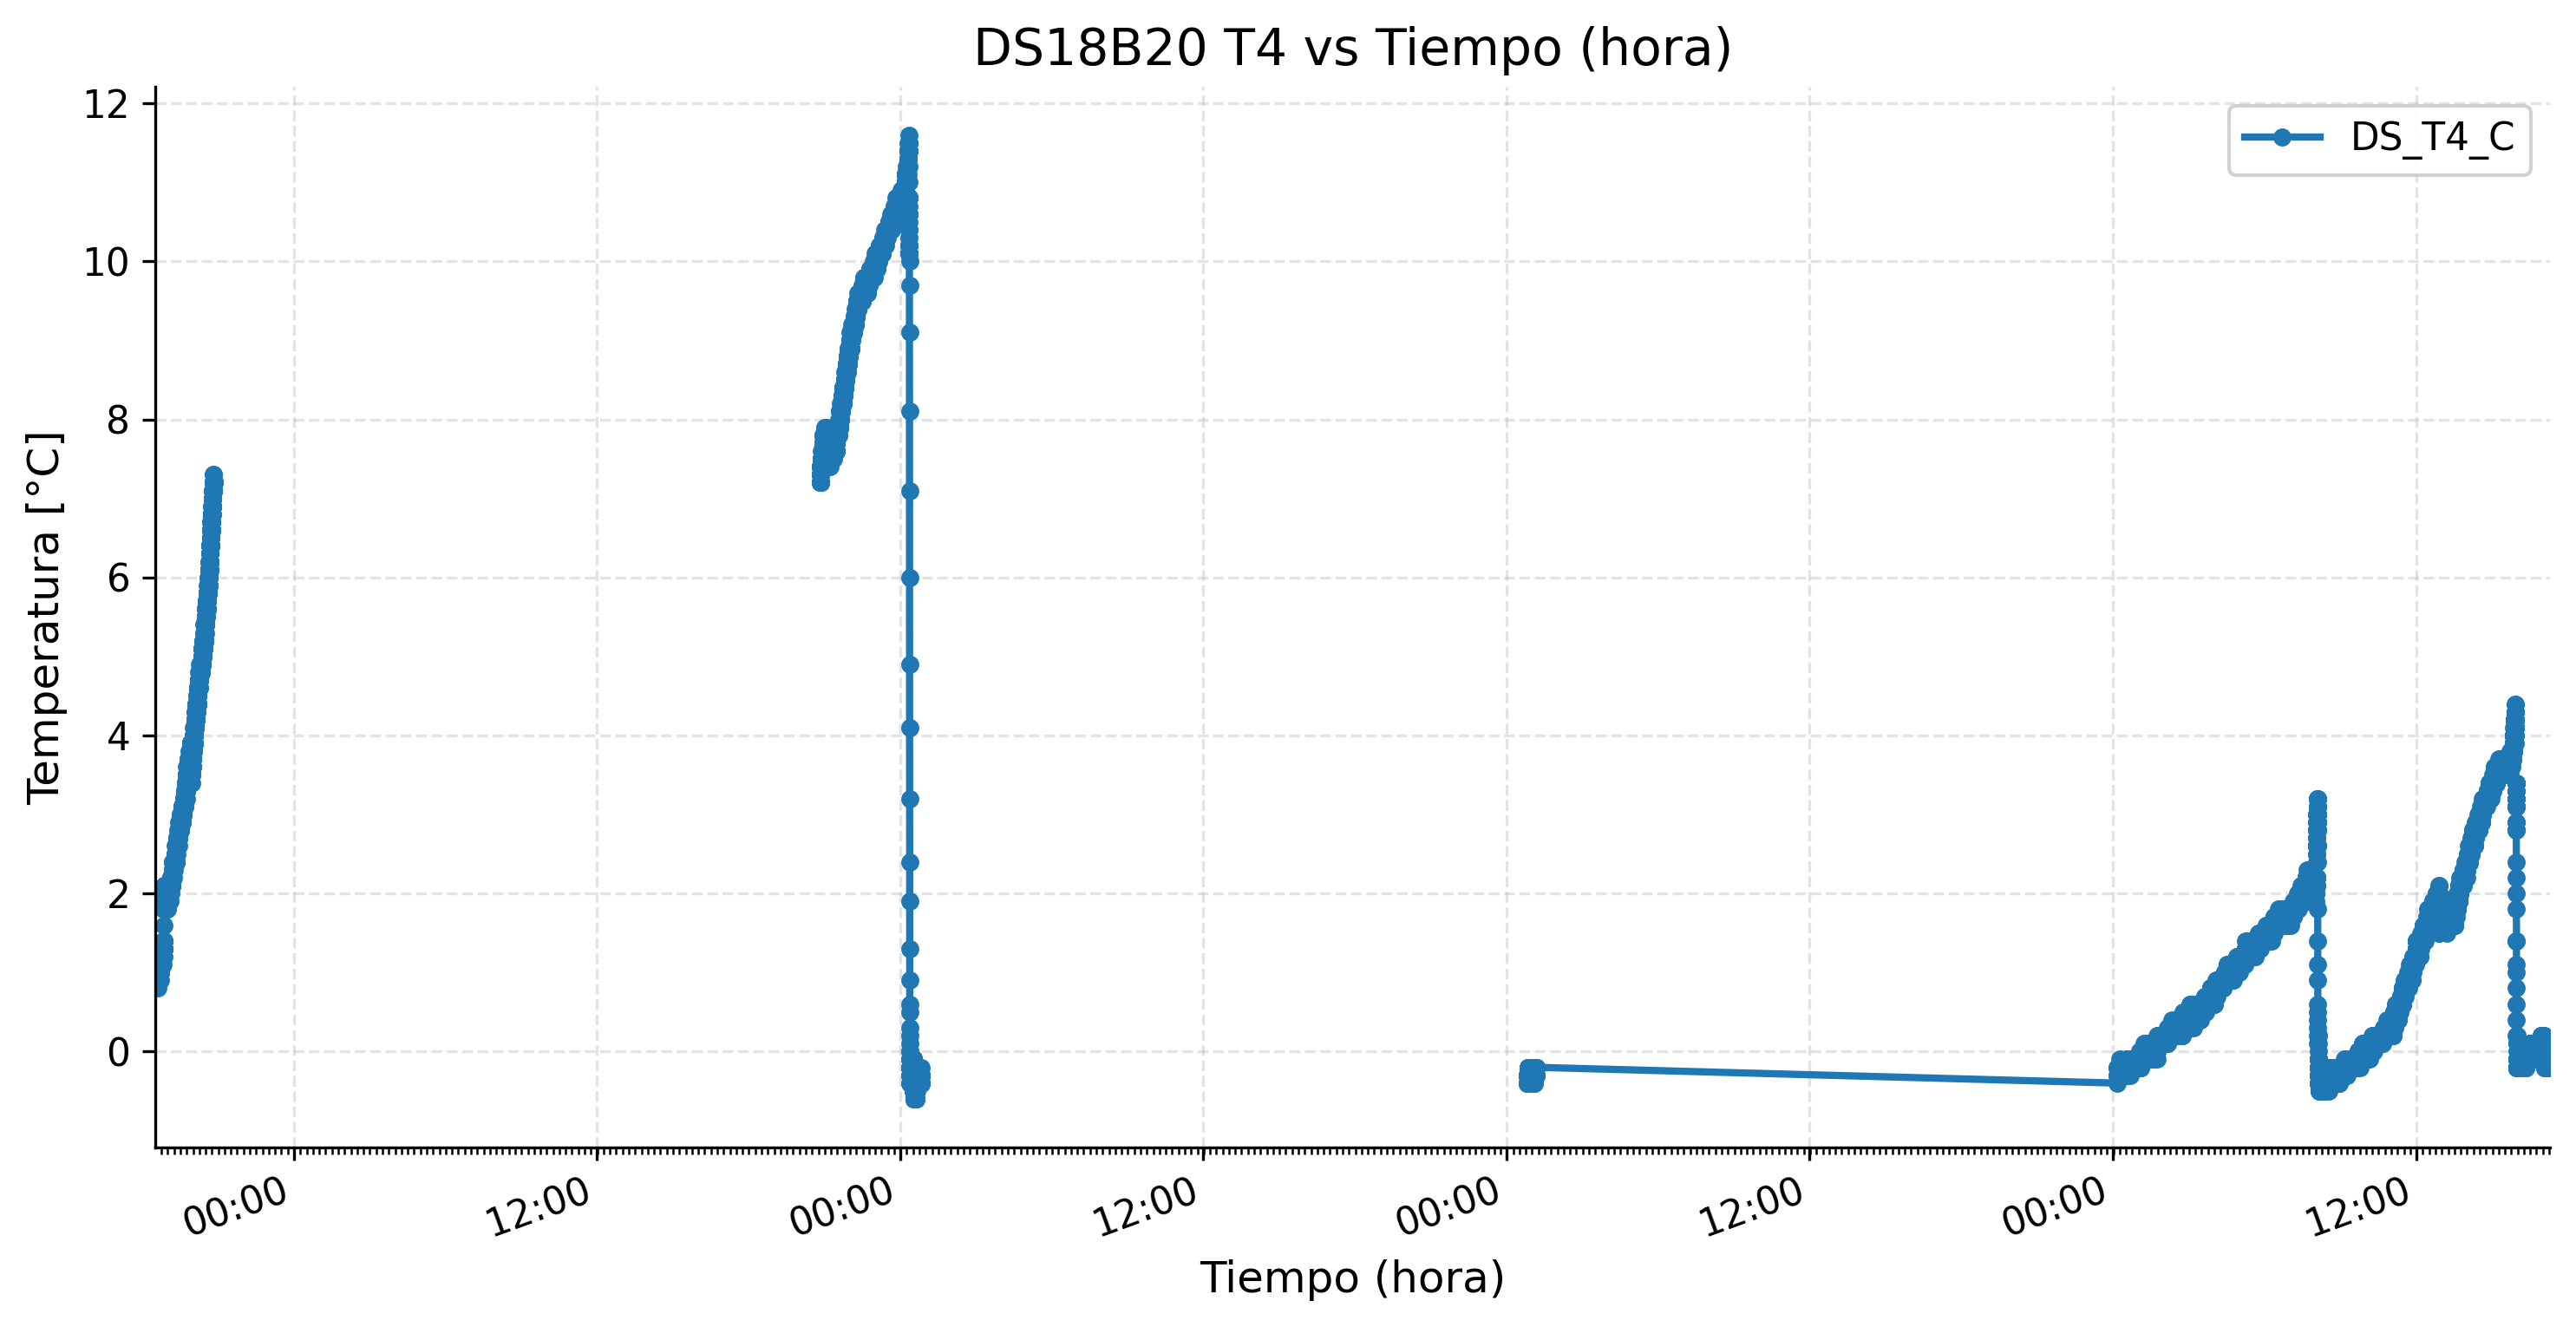

✅ Figuras generadas con eje horario real, continuo y formateado como HH:MM.


In [17]:
# -*- coding: utf-8 -*-
"""
Graficación profesional + muestreo por intervalos:
- Presiones, IR y DS18B20 (conjuntas e individuales)
- Usa 'time' (HH:MM:SS.mmm) respetando la hora real del primer dato
- Maneja rollover de medianoche (eje continuo)
- Eje X: solo hora (HH:MM) fijado al rango exacto de los datos
- Muestreo: none / nearest / mean / median
- Filtro [start, end] (HH:MM:SS) opcional
"""

from typing import Optional, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ================== Configura aquí ==================
CSV_PATH      = "salida_unida.csv"      # Soporta CSV o TSV (autodetección de separador)
OUT_PREFIX    = "fig_"                  # Prefijo de archivos de salida
SAVE_PNGS     = True                    # Guardar PNG
SAVE_PDFS     = False                   # Guardar PDF
SHOW_PLOTS    = True                    # Mostrar ventanas interactivas

DPI           = 300
FIGSIZE       = (10, 5.2)
LINEWIDTH     = 2.0
MARKERSIZE    = 4                       # 0 para sin puntos
GRID_ALPHA    = 0.35

# Eje temporal (usar 'time' real)
USE_ELAPSED   = False                   # False => usa 'time' (no relativo)
ELAPSED_ZERO_DATE = pd.Timestamp('2000-01-01')

# Filtros de tiempo (opcional) en formato 'HH:MM:SS' o None
RANGE_START: Optional[str] = None
RANGE_END:   Optional[str] = None

# Muestreo en un solo gráfico
SAMPLE_MODE = "none"                    # "none" | "nearest" | "mean" | "median"
SAMPLE_FREQ = "30min"                   # "5min" | "15min" | "30min" | "1h"
# ====================================================

# ---- Estilo global ----
plt.rcParams.update({
    "figure.figsize": FIGSIZE,
    "figure.dpi": 300,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": GRID_ALPHA,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10.5,
    "ytick.labelsize": 10.5,
    "legend.fontsize": 10.5,
    "lines.linewidth": LINEWIDTH,
    "lines.markersize": MARKERSIZE,
})

# ================== Helpers de tiempo ==================
def construir_tiempo_continuo(time_series: pd.Series) -> pd.Series:
    """Convierte 'time' a datetime continuo, cosiendo medianoches."""
    t_str = time_series.astype(str).str.strip()
    t_norm = t_str.str.replace(",", ".", regex=False)
    tiene_fecha = t_norm.str.contains("T")
    dt = pd.Series(pd.NaT, index=t_norm.index, dtype="datetime64[ns]")

    if tiene_fecha.any():
        dt.loc[tiene_fecha] = pd.to_datetime(t_norm[tiene_fecha], errors="coerce")

    if (~tiene_fecha).any():
        t_hora = "2000-01-01 " + t_norm[~tiene_fecha]
        dt_hora = pd.to_datetime(t_hora, format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
        mask_na = dt_hora.isna()
        if mask_na.any():
            dt_hora2 = pd.to_datetime(
                "2000-01-01 " + t_norm[~tiene_fecha][mask_na].str.split(".").str[0],
                format="%Y-%m-%d %H:%M:%S",
                errors="coerce",
            )
            dt_hora[mask_na] = dt_hora2
        dt.loc[~tiene_fecha] = dt_hora

    if dt.isna().any():
        ejemplos = t_str[dt.isna()].unique()[:5]
        raise ValueError("No se pudieron parsear marcas de tiempo: " + ", ".join(map(str, ejemplos)))

    neg = dt.diff() < pd.Timedelta(0)       # detecta rollover (hora “retrocede”)
    roll = neg.cumsum()                     # cuántas medianoches cruzadas
    return dt + pd.to_timedelta(roll, unit="D")

def construir_x(df: pd.DataFrame) -> pd.Series:
    if USE_ELAPSED:
        if "elapsed_s" not in df.columns:
            raise KeyError("USE_ELAPSED=True pero falta 'elapsed_s'.")
        return pd.to_timedelta(pd.to_numeric(df["elapsed_s"], errors="coerce"), unit='s') + ELAPSED_ZERO_DATE
    else:
        if "time" not in df.columns:
            raise KeyError("USE_ELAPSED=False pero falta 'time'.")
        return construir_tiempo_continuo(df["time"])

def parse_hhmmss_to_datetime(base_date: pd.Timestamp, hhmmss: str) -> pd.Timestamp:
    return base_date + pd.to_timedelta(hhmmss)

def filtrar_rango(x_dt: pd.Series, df: pd.DataFrame,
                  start_hhmmss: Optional[str], end_hhmmss: Optional[str]) -> Tuple[pd.Series, pd.DataFrame]:
    """Filtra por hora del primer día (solo si defines RANGE_*)"""
    if start_hhmmss is None and end_hhmmss is None:
        return x_dt, df
    base_date = x_dt.iloc[0].normalize()
    mask = pd.Series(True, index=df.index)
    if start_hhmmss is not None:
        t0 = parse_hhmmss_to_datetime(base_date, start_hhmmss)
        mask &= (x_dt >= t0)
    if end_hhmmss is not None:
        t1 = parse_hhmmss_to_datetime(base_date, end_hhmmss)
        mask &= (x_dt <= t1)
    return x_dt[mask], df.loc[mask].reset_index(drop=True)

def aplicar_muestreo(x_dt: pd.Series, df: pd.DataFrame) -> Tuple[pd.Series, pd.DataFrame]:
    """Muestreo temporal opcional en un único gráfico."""
    if SAMPLE_MODE == "none" or SAMPLE_FREQ is None:
        return x_dt, df

    tmp = df.copy().assign(_x=x_dt.values)
    tmp["_x_unique"] = tmp["_x"] + pd.to_timedelta(tmp.index, unit="ns")  # índice datetime único
    tmp = tmp.set_index("_x_unique").sort_index()

    if SAMPLE_MODE == "nearest":
        df_s = tmp.resample(SAMPLE_FREQ).nearest()
    elif SAMPLE_MODE == "mean":
        df_s = tmp.resample(SAMPLE_FREQ).mean(numeric_only=True)
    elif SAMPLE_MODE == "median":
        df_s = tmp.resample(SAMPLE_FREQ).median(numeric_only=True)
    else:
        raise ValueError("SAMPLE_MODE debe ser 'none', 'nearest', 'mean' o 'median'.")

    x_s = df_s.index.to_series().reset_index(drop=True)
    df_s = df_s.reset_index(drop=True)
    return x_s, df_s

# ================== Formato de eje X (hora real) ==================
def aplicar_eje_hora_real(ax, x_dt):
    """Eje X continuo mostrando solo la hora real (HH:MM) del rango de datos."""
    ax.set_xlim(x_dt.min(), x_dt.max())
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=6, maxticks=12))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))      # ajusta si quieres
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.figure.autofmt_xdate(rotation=20, ha="right")

# ================== Plotters ==================
def _save_and_show(fig, fname_base: str):
    if SAVE_PNGS:
        fig.savefig(f"{OUT_PREFIX}{fname_base}.png", dpi=DPI)
    if SAVE_PDFS:
        fig.savefig(f"{OUT_PREFIX}{fname_base}.pdf")
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close(fig)

def plot_lineas(x_dt, y_cols, df, titulo, ylabel, fname_base):
    fig, ax = plt.subplots()
    plotted = 0
    for col in y_cols:
        if col in df.columns:
            y = pd.to_numeric(df[col], errors="coerce")
            if np.isfinite(y).sum() == 0:
                continue
            ax.plot(x_dt, y, '-o', label=col, markersize=MARKERSIZE)
            plotted += 1
    if plotted == 0:
        plt.close(fig); print(f"[AVISO] Sin datos en {y_cols}"); return

    ax.set_title(titulo)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Tiempo (hora)")
    aplicar_eje_hora_real(ax, x_dt)

    ax.legend(ncol=2, frameon=True, fancybox=True, framealpha=0.9)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()
    _save_and_show(fig, fname_base)

def plot_individual(x_dt, col, df, titulo, ylabel, fname_base):
    if col not in df.columns:
        print(f"[AVISO] Columna '{col}' no encontrada."); return
    y = pd.to_numeric(df[col], errors="coerce")
    if not np.isfinite(y).any():
        print(f"[AVISO] '{col}' no tiene datos numéricos válidos."); return

    fig, ax = plt.subplots()
    ax.plot(x_dt, y, '-o', label=col, markersize=MARKERSIZE)
    ax.set_title(titulo)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Tiempo (hora)")
    aplicar_eje_hora_real(ax, x_dt)

    ax.legend(frameon=True, fancybox=True, framealpha=0.9)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    plt.tight_layout()
    _save_and_show(fig, fname_base)

def generar_todas_las_graficas(x_dt, df, sufijo=""):
    sfx = ("" if not sufijo else f"__{sufijo}")
    # Combinadas
    plot_lineas(x_dt, ["P1_mmHg", "P2_mmHg"], df,
                "Presiones vs Tiempo (hora)", "Presión [mmHg]",
                f"presiones_vs_tiempo{sfx}")
    plot_lineas(x_dt, ["IR2_Obj_C", "IR3_Obj_C"], df,
                "Temperaturas IR (Objetivo) vs Tiempo (hora)", "Temperatura [°C]",
                f"ir_obj_vs_tiempo{sfx}")
    plot_lineas(x_dt, ["DS_T1_C", "DS_T2_C", "DS_T3_C", "DS_T4_C"], df,
                "DS18B20 (T1–T4) vs Tiempo (hora)", "Temperatura [°C]",
                f"ds18b20_vs_tiempo{sfx}")

    # Individuales
    plot_individual(x_dt, "P1_mmHg", df, "Presión P1 vs Tiempo (hora)", "Presión [mmHg]", f"P1_vs_tiempo{sfx}")
    plot_individual(x_dt, "P2_mmHg", df, "Presión P2 vs Tiempo (hora)", "Presión [mmHg]", f"P2_vs_tiempo{sfx}")
    plot_individual(x_dt, "IR2_Obj_C", df, "IR Canal 2 (Obj) vs Tiempo (hora)", "Temperatura [°C]", f"IR2_obj_vs_tiempo{sfx}")
    plot_individual(x_dt, "IR3_Obj_C", df, "IR Canal 3 (Obj) vs Tiempo (hora)", "Temperatura [°C]", f"IR3_obj_vs_tiempo{sfx}")
    for col, etiqueta in [("DS_T1_C", "DS18B20 T1"), ("DS_T2_C", "DS18B20 T2"),
                          ("DS_T3_C", "DS18B20 T3"), ("DS_T4_C", "DS18B20 T4")]:
        plot_individual(x_dt, col, df, f"{etiqueta} vs Tiempo (hora)", "Temperatura [°C]", f"{col}_vs_tiempo{sfx}")

# ================== main ==================
def main():
    # Lectura robusta: autodetecta separador (, ; \t)
    df = pd.read_csv(CSV_PATH, sep=None, engine="python")

    # Eje X base (usar 'time' real)
    x_dt = construir_x(df)

    # Filtro de rango (opcional)
    x_use, df_use = filtrar_rango(x_dt, df, RANGE_START, RANGE_END)

    # Muestreo (si aplica)
    x_s, df_s = aplicar_muestreo(x_use, df_use)

    # Gráficas
    generar_todas_las_graficas(x_s, df_s)

    print("✅ Figuras generadas con eje horario real, continuo y formateado como HH:MM.")

if __name__ == "__main__":
    main()
